### DLthon 진행 후 피드백 적용
- 1일차: 베이스라인 선정 및 Featuere Engineering -> 가설 설정 후 검증(유의 수준 5%)
- 2일차: 정칙화와 LaneNet를 통한 lane Mark 개선에 집중
- 3일차: 상호지식 증류를 통한 Lane Mark 개선 시도

### 1일차 Task, DLthon 이후 보완
 #### 목표
 - 프로젝트 파악 및 팀원 역할 배분
 - 모델 데이터 확인(파악)
 - 베이스라인 모델 선정 및 지표 결정
 - Feature Engineering을 통한 성능 개선
   
 #### Process
- Segment Baseline 구조 결정 → DeepLab v3 vs U-Net
- backbone 결정 → ResNet50 vs EffientNetB0
- feature Engineering
- W&B 설계, Grad-CAM 미적용

### Steps
 - 1. 데이터 파악(EDA)
 - 2. 베이스라인 Model 및 backbone 결정
   - 2.1 Sementic Segmentation 모델 DeepLab v3(ResNet50) 의 성능
   - 2.2 Sementic Segmentation 모델 Unet(ResNet50) 의 성능
   - 2.3 backbone DeepLab v3(EffientNetB0) 의 성능
 - 3. Featuere Engineering을 위한 데이터 분석(EDA)
 - 4. feature engineering(상단부터 Crop 0% ~ Corp 60%까지 진행)
 - 5. optimization engineering(Class Weight 조정)
 - 6. objective Engineering(CE + Dice + Boundary)
 - 7. feature Engineering(감마, CLAHE 등)

### 결과 해석

- Segmentation 구조로 DeepLab v3 선정
- Backbone 결정(ResNet50)
- 다양한 Feature Engineering 진행했지만, 방향을 못잡음
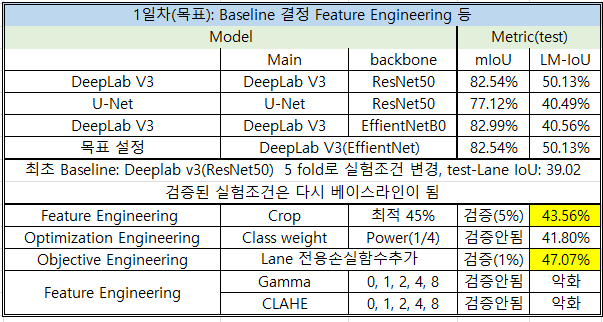

### 회고
- Lane Mark를 개선하기 위해 배운 지식을 총동원하였으나 개선에 실패함
- 팀원들간의 소통을 통하여 아이디어는 폭발함

### DLthon 예측된 피드백
 - 박광석 퍼실님 예측 피드백: crop를 진행하다 보면 성능개선되는 지점을 찾을 수 있다.
 - 아래 그림은 이미지 상단으로부터 5%씩 crop를 증가시킬 때 사라지는 Lane Mark 픽셀 수(이를 손실률로 조작적 정의)
   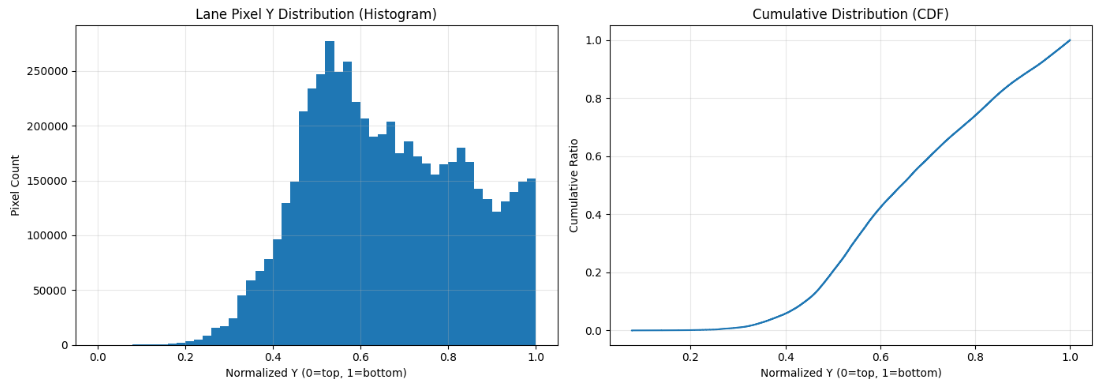
   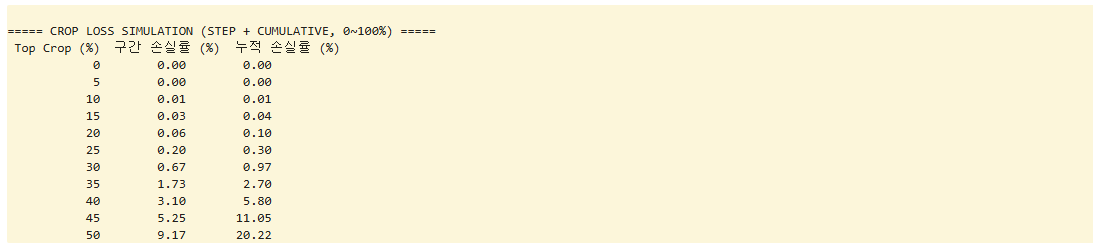
 - 실험 방법
 - - letterbox 설정 후 상단으로 부터 5%씩 crop 범위를 넓힘
   - 0%(baseline)부터 60% 까지, 동일한 실험조건으로 반복하여 가장 높은 crop 조건 찾음
  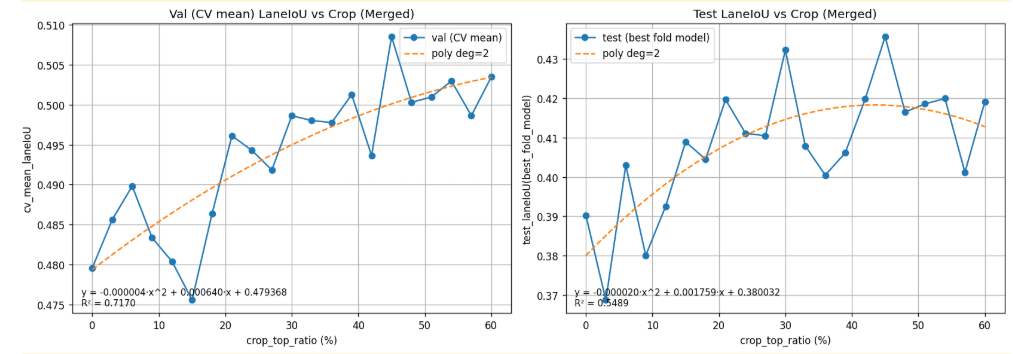
   - 가장 큰 성능개선 crop 조건과 베이스라인과 paired t-test
   - 귀무가설 (H₀): 상단 45% crop과 0% crop의 laneIoU 평균에는 차이가 없다.(μ₄₅ − μ₀ = 0)
   - 대립가설 (H₁): 상단 45% crop은 0% crop보다 laneIoU를 향상시킨다.(μ₄₅ − μ₀ > 0). 단측검증
   - 이유: 동일한 데이터 분할 구조 (K-fold), 같은 모델 구조, Crop 조건만 변경
   - 표본 수: k = 5 folds, 자유도(df) = 4, 유의수준 α = 0.05
   - 검정 통계량: 평균차이(Δ) = +0.0289, 근사t 값 ≈ 2.3 ~ 2.6, 자유도 4 => p-value ≈ 0.04 ~ 0.05 (단측)
   - α = 0.05, p < 0.05이므로 귀무가설 기각
   - 결론: 유의수준 5%에서, 상단 45% crop은 0% crop 대비 laneIoU를 통계적으로 유의하게 향상시킨다.
   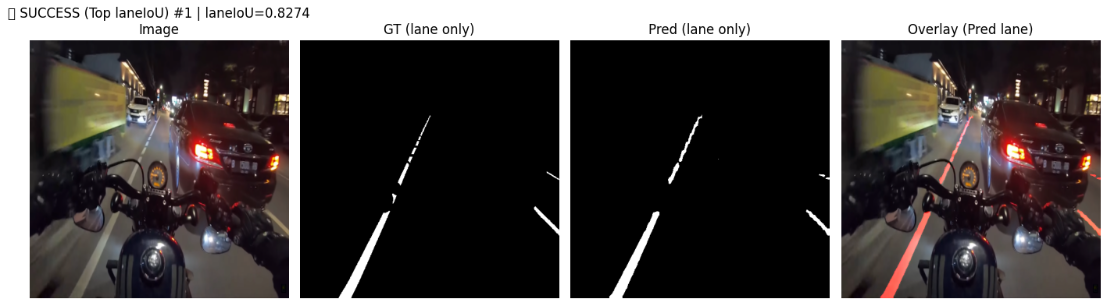

### step 1. 데이터 파악(EDA)

In [2]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# ===== 로컬 경로  =====
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ann_path  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

print("DATA_ROOT:", DATA_ROOT)
print("IMG_DIR  :", IMG_DIR)
print("ann_path :", ann_path)

print("\n[DATA_ROOT list]")
print(os.listdir(DATA_ROOT))

# ===== COCO JSON 로드 (클라우드 코드와 동일 흐름) =====
with open(ann_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

print("\nkeys:", coco_data.keys())
print("num images:", len(coco_data["images"]))
print("num annotations:", len(coco_data["annotations"]))
print("num categories:", len(coco_data["categories"]))

DATA_ROOT: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset
IMG_DIR  : D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\images
ann_path : D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\COCO_motorcycle (pixel).json

[DATA_ROOT list]
['checkpoints_deeplabv3p', 'checkpoints_deeplabv3p_es', 'checkpoints_mutual_kd', 'checkpoints_segformer_es', 'COCO_motorcycle (pixel).json', 'gradcam_compare', 'images', 'mask_cache_512', 'misclassified_samples', 'step8_eval', 'step9_cam_distilled']

keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
num images: 200
num annotations: 2305
num categories: 6


In [4]:
# ===============================
# COCO Dataset EDA 
# ===============================

import json
import pandas as pd

# ---- COCO JSON 로드 ----
with open(ann_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

print("===== COCO STRUCTURE =====")
print("keys:", coco_data.keys())

# ---- 카테고리 매핑 ----
cat_id_to_name = {c["id"]: c["name"] for c in coco_data["categories"]}
cat_name_to_id = {c["name"]: c["id"] for c in coco_data["categories"]}

# ==========================================================
# 1) INFO
# ==========================================================
print("\n===== DATASET INFO =====")

info = coco_data.get("info", {})
display(pd.DataFrame([info]))


# ==========================================================
# 2) LICENSES
# ==========================================================
print("\n===== LICENSES =====")

licenses = coco_data.get("licenses", [])
print("num_licenses:", len(licenses))
display(pd.DataFrame(licenses))


# ==========================================================
# 3) IMAGES 분석
# ==========================================================
print("\n===== IMAGES ANALYSIS =====")

images = coco_data["images"]
print("num_images:", len(images))

img_df = pd.DataFrame(images)

print("image columns:", img_df.columns.tolist())
display(img_df.head(3))

# ---- 해상도 통계 ----
if "width" in img_df.columns and "height" in img_df.columns:
    
    print("\n[Resolution stats]")
    print("width  min/mean/median/max:",
          int(img_df["width"].min()),
          round(img_df["width"].mean(), 2),
          img_df["width"].median(),
          int(img_df["width"].max()))

    print("height min/mean/median/max:",
          int(img_df["height"].min()),
          round(img_df["height"].mean(), 2),
          img_df["height"].median(),
          int(img_df["height"].max()))

    res_counts = (
        img_df.groupby(["width", "height"])
        .size()
        .sort_values(ascending=False)
        .head(5)
    )

    print("\nTop resolutions:")
    display(res_counts)


# ---- 파일명 패턴 ----
if "file_name" in img_df.columns:

    print("\n[file_name examples]")
    display(img_df["file_name"].head(10))

    has_subdir = img_df["file_name"].str.contains("/").mean()
    print(f"file_name에 하위 폴더 포함 비율: {has_subdir*100:.1f}%")


# ==========================================================
# 4) CATEGORIES 분석
# ==========================================================
print("\n===== CATEGORY ANALYSIS =====")

cat_df = pd.DataFrame(coco_data["categories"]).sort_values("id")
display(cat_df)

print("\n[Category list]")
for c in coco_data["categories"]:
    print(f"{c['id']} : {c['name']}")

===== COCO STRUCTURE =====
keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

===== DATASET INFO =====


description                       url version  year       contributor  \
0  This is dataset.  https://superannotate.ai     1.0  2022  Superannotate AI   

  date_created  
0   15/09/2022


===== LICENSES =====
num_licenses: 1


url  id              name
0  https://superannotate.ai   1  Superannotate AI


===== IMAGES ANALYSIS =====
num_images: 200
image columns: ['id', 'file_name', 'height', 'width', 'license']


id            file_name  height  width  license
0   1   night ride (8).png    1080   1920        1
1   2  night ride (14).png    1080   1920        1
2   3  night ride (11).png    1080   1920        1


[Resolution stats]
width  min/mean/median/max: 1920 1920.0 1920.0 1920
height min/mean/median/max: 1080 1080.0 1080.0 1080

Top resolutions:


width  height
1920   1080      200
dtype: int64


[file_name examples]


0     night ride (8).png
1    night ride (14).png
2    night ride (11).png
3    night ride (24).png
4    night ride (23).png
5    night ride (10).png
6     night ride (9).png
7    night ride (20).png
8    night ride (12).png
9    night ride (17).png
Name: file_name, dtype: object

file_name에 하위 폴더 포함 비율: 0.0%

===== CATEGORY ANALYSIS =====


id        name supercategory  isthing          color
5  1323880  Undrivable    Undrivable        1  [104, 51, 20]
4  1323881        Road          Road        1  [105, 51, 20]
3  1323882   Lane Mark     Lane Mark        1  [106, 51, 20]
2  1323884    Moveable      Moveable        1  [108, 51, 20]
1  1323885     My bike       My bike        1  [109, 51, 20]
0  1329681       Rider         Rider        1   [17, 74, 20]


[Category list]
1329681 : Rider
1323885 : My bike
1323884 : Moveable
1323882 : Lane Mark
1323881 : Road
1323880 : Undrivable


In [5]:
# ===============================
# 5) ANNOTATIONS EDA (통합 셀)
# ===============================

import numpy as np
import pandas as pd

annotations = coco_data["annotations"]
print("\n===== ANNOTATIONS ANALYSIS =====")
print("num_annotations:", len(annotations))

ann_df = pd.DataFrame(annotations)
print("annotation columns:", ann_df.columns.tolist())
display(ann_df.head(3))


# ==========================================================
# 5-2) 클래스별 annotation 개수 (category_id 기준)
# ==========================================================
print("\n===== PER-CLASS ANNOTATION COUNT =====")

cat_counts = ann_df["category_id"].value_counts()

summary_df = pd.DataFrame({
    "category_id": cat_counts.index.astype(int),
    "category_name": [cat_id_to_name.get(int(cid), "UNKNOWN") for cid in cat_counts.index],
    "ann_count": cat_counts.values.astype(int),
    "ann_ratio(%)": (cat_counts.values / len(ann_df) * 100)
})

display(summary_df)


# ==========================================================
# 5-3) 이미지당 annotation 개수 분포
# ==========================================================
print("\n===== ANNOTATIONS PER IMAGE =====")

ann_per_img = ann_df.groupby("image_id").size()
print("images with annotations:", ann_per_img.shape[0], "/", len(images))
print("anns per image: min/mean/median/max =",
      int(ann_per_img.min()),
      round(float(ann_per_img.mean()), 3),
      float(ann_per_img.median()),
      int(ann_per_img.max()))

display(ann_per_img.describe())


# ==========================================================
# 5-4) area / bbox 통계
# ==========================================================
print("\n===== AREA / BBOX STATS =====")

# ---- area ----
if "area" in ann_df.columns:
    print("\n[Area stats]")
    print("area min/mean/median/max =",
          float(ann_df["area"].min()),
          round(float(ann_df["area"].mean()), 3),
          float(ann_df["area"].median()),
          float(ann_df["area"].max()))

    area_by_cat = (
        ann_df.groupby("category_id")["area"]
        .agg(["count","mean","median","min","max"])
        .reset_index()
    )
    area_by_cat["category_name"] = area_by_cat["category_id"].map(cat_id_to_name)
    area_by_cat = area_by_cat.sort_values("mean")

    print("\n[Area stats by category (sorted by mean)]")
    display(area_by_cat)

else:
    print("⚠️ 'area' column not found in annotations.")


# ---- bbox ----
if "bbox" in ann_df.columns:
    # bbox = [x, y, w, h]
    wh = np.array([
        b[2:4] for b in ann_df["bbox"].values
        if isinstance(b, list) and len(b) >= 4
    ])

    if len(wh) > 0:
        w = wh[:, 0]
        h = wh[:, 1]

        print("\n[BBox width/height stats]")
        print("w min/mean/median/max:",
              float(w.min()), round(float(w.mean()), 3), float(np.median(w)), float(w.max()))
        print("h min/mean/median/max:",
              float(h.min()), round(float(h.mean()), 3), float(np.median(h)), float(h.max()))

        bbox_df = pd.DataFrame({
            "w": w,
            "h": h,
            "bbox_area(w*h)": w*h
        })
        display(bbox_df.describe())

    else:
        print("⚠️ bbox는 존재하지만, 파싱 가능한 bbox 리스트가 없습니다.")
else:
    print("⚠️ 'bbox' column not found in annotations.")



===== ANNOTATIONS ANALYSIS =====
num_annotations: 2305
annotation columns: ['id', 'image_id', 'segmentation', 'iscrowd', 'bbox', 'area', 'category_id']


id  image_id                                       segmentation  iscrowd  \
0   1         1  [[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0,...        0   
1   2         1  [[1383, 932, 1382, 933, 1381, 934, 1380, 934, ...        0   
2   3         1  [[884, 524, 883, 525, 882, 525, 881, 525, 880,...        0   

                          bbox    area  category_id  
0    [0.0, 0.0, 1920.0, 551.0]  586530      1323880  
1  [0.0, 243.0, 1920.0, 837.0]  819509      1323881  
2  [0.0, 280.0, 1659.0, 277.0]   17414      1323882


===== PER-CLASS ANNOTATION COUNT =====


category_id category_name  ann_count  ann_ratio(%)
0      1323884      Moveable       1298     56.312364
1      1323882     Lane Mark        207      8.980477
2      1323881          Road        200      8.676790
3      1323880    Undrivable        200      8.676790
4      1323885       My bike        200      8.676790
5      1329681         Rider        200      8.676790


===== ANNOTATIONS PER IMAGE =====
images with annotations: 200 / 200
anns per image: min/mean/median/max = 5 11.525 11.0 26


count    200.000000
mean      11.525000
std        4.504534
min        5.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       26.000000
dtype: float64


===== AREA / BBOX STATS =====

[Area stats]
area min/mean/median/max = 5.0 179919.144 14907.0 1515454.0

[Area stats by category (sorted by mean)]


category_id  count           mean    median     min      max category_name
3      1323884   1298   15041.065485    1692.0       5   424086      Moveable
2      1323882    207   28824.676329   22196.0     103   170137     Lane Mark
5      1329681    200  167151.545000  181064.5   40709   269838         Rider
4      1323885    200  327562.445000  319764.0  108350   711443       My bike
1      1323881    200  562131.875000  593954.0  146843  1035064          Road
0      1323880    200  889272.210000  893769.5  351188  1515454    Undrivable


[BBox width/height stats]
w min/mean/median/max: 1.0 792.071 259.0 1920.0
h min/mean/median/max: 2.0 293.641 162.0 1080.0


w            h  bbox_area(w*h)
count  2305.000000  2305.000000    2.305000e+03
mean    792.070716   293.640781    4.353286e+05
std     817.403358   286.571006    5.629247e+05
min       1.000000     2.000000    5.000000e+00
25%      47.000000    42.000000    1.960000e+03
50%     259.000000   162.000000    4.006800e+04
75%    1920.000000   533.000000    8.198400e+05
max    1920.000000  1080.000000    2.073600e+06

===== FILE MATCH CHECK =====
missing files: 0

===== BASIC COUNTS =====
이미지 수: 200
annotation 수: 2305

===== SAMPLE VISUALIZATION =====
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


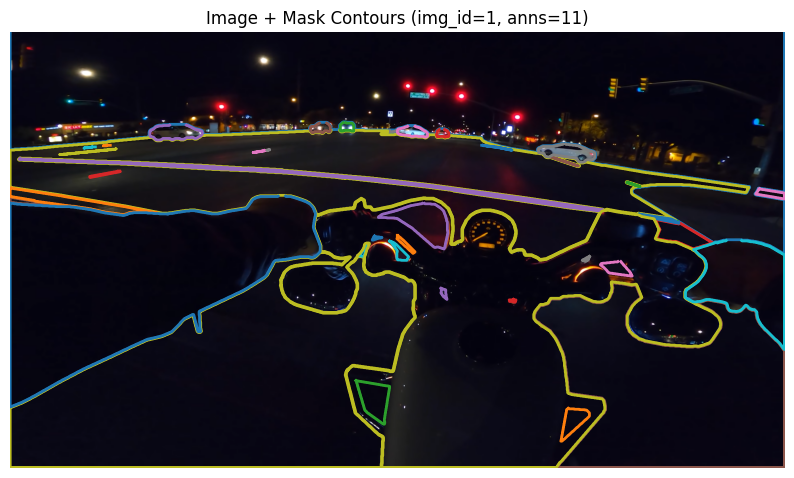

In [8]:
# ===============================
# 6) 파일 매칭 체크 + 샘플 시각화 (통합 셀)
# ===============================

import os, json
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) images 폴더와 JSON 매칭 체크 ----
img_dir = os.path.join(DATA_ROOT, "images")

missing = []
for im in images:
    fp = os.path.join(img_dir, im["file_name"])
    if not os.path.exists(fp):
        missing.append(im["file_name"])

print("===== FILE MATCH CHECK =====")
print("missing files:", len(missing))
if len(missing) > 0:
    print("ex) missing sample:", missing[:5])

# ---- 2) 이미지/annotation 수 ----
print("\n===== BASIC COUNTS =====")
print("이미지 수:", len(coco_data["images"]))
print("annotation 수:", len(coco_data["annotations"]))

# ---- 3) 샘플 이미지 + 마스크 윤곽선 시각화 ----
print("\n===== SAMPLE VISUALIZATION =====")

# OpenCV / pycocotools import (없으면 설치 필요)
import cv2
from pycocotools.coco import COCO

coco = COCO(ann_path)

# 첫 샘플 선택
img_id = coco.getImgIds()[0]
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(DATA_ROOT, "images", img_info["file_name"])

# 이미지 읽기
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"cv2.imread failed: {img_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# annotation 가져오기
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

plt.figure(figsize=(10, 8))
plt.imshow(image)
ax = plt.gca()

# 윤곽선 그리기
for ann in anns:
    mask = coco.annToMask(ann).astype(np.uint8)  # (H,W) 0/1

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        cnt = cnt.squeeze()
        if cnt.ndim == 2 and len(cnt) >= 3:
            ax.plot(cnt[:, 0], cnt[:, 1], linewidth=2)

plt.title(f"Image + Mask Contours (img_id={img_id}, anns={len(anns)})")
plt.axis("off")
plt.show()


===== CLASS DISTRIBUTION (Annotation 기준) =====


category_id category_name  annotation_count  ratio(%)
0      1323884      Moveable              1298     56.31
1      1323882     Lane Mark               207      8.98
2      1323881          Road               200      8.68
3      1323880    Undrivable               200      8.68
4      1323885       My bike               200      8.68
5      1329681         Rider               200      8.68

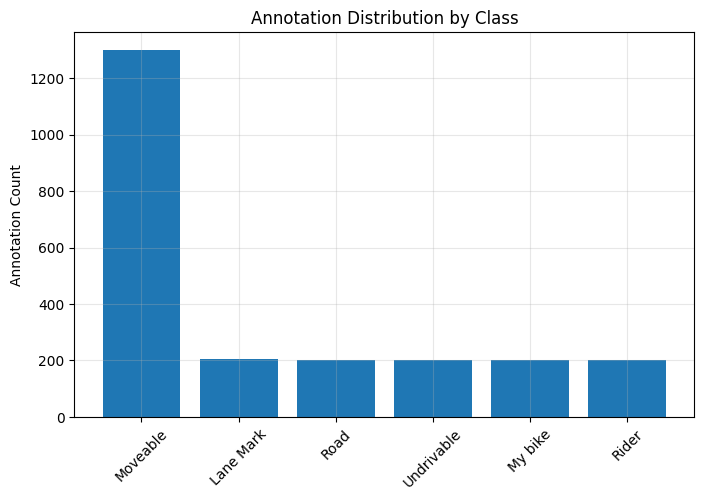


===== NIGHT BRIGHTNESS ANALYSIS =====
Valid images loaded: 200
Mean Brightness: 45.66
Median Brightness: 33.61
Std Brightness: 26.01
Min Brightness: 10.35
Max Brightness: 120.78


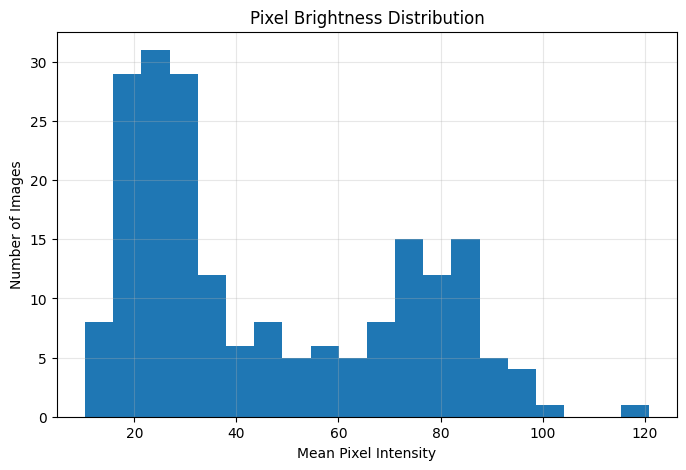

In [10]:
# ===============================
# CLASS DISTRIBUTION + NIGHT BRIGHTNESS ANALYSIS
# ===============================

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


# ==========================================================
# 7) 클래스 분포 분석 (annotation 기준)
# ==========================================================
print("\n===== CLASS DISTRIBUTION (Annotation 기준) =====")

cls_counter = Counter(ann["category_id"] for ann in coco_data["annotations"])
total = sum(cls_counter.values())

df_cls = (
    pd.DataFrame([
        {
            "category_id": cid,
            "category_name": cat_id_to_name.get(cid, "UNKNOWN"),
            "annotation_count": int(cnt),
            "ratio(%)": round(cnt / total * 100, 2),
        }
        for cid, cnt in cls_counter.items()
    ])
    .sort_values("annotation_count", ascending=False)
    .reset_index(drop=True)
)

display(df_cls)


# ---- 클래스 분포 시각화 ----
plt.figure(figsize=(8,5))
plt.bar(df_cls["category_name"], df_cls["annotation_count"])
plt.title("Annotation Distribution by Class")
plt.ylabel("Annotation Count")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


# ==========================================================
# 8) 야간 밝기 특성 분석
# ==========================================================
print("\n===== NIGHT BRIGHTNESS ANALYSIS =====")

brightness = []
valid_imgs = 0

for img in coco_data["images"]:
    img_path = os.path.join(DATA_ROOT, "images", img["file_name"])
    
    im = cv2.imread(img_path)
    if im is None:
        continue
        
    brightness.append(im.mean())
    valid_imgs += 1

brightness_np = np.array(brightness)

print(f"Valid images loaded: {valid_imgs}")
print(f"Mean Brightness: {brightness_np.mean():.2f}")
print(f"Median Brightness: {np.median(brightness_np):.2f}")
print(f"Std Brightness: {brightness_np.std():.2f}")
print(f"Min Brightness: {brightness_np.min():.2f}")
print(f"Max Brightness: {brightness_np.max():.2f}")


# ---- 밝기 히스토그램 ----
plt.figure(figsize=(8,5))
plt.hist(brightness_np, bins=20)
plt.title("Pixel Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Images")
plt.grid(alpha=0.3)
plt.show()

## step 2. 베이스라인 Model 및 backbone 결정
#
# 2.1 Sementic Segmentation 모델 DeepLab v3(ResNet50) 의 성능 파악
##### 동일한 backbone(ResNet 50)을 기준으로 성능이 좋은 모델 선택

In [12]:
import os, random
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

class COCOSemSeg(Dataset):
    """
    COCO instance/pixel annotations -> semantic mask (H,W) with train ids.
    공정 비교(DeepLabV3+ vs U-Net, backbone=ResNet50)를 위해:
      - 동일한 resize
      - 동일한 normalize(외부 주입 가능)
      - train에만 augmentation
    """
    def __init__(
        self,
        coco,                 # COCO object
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        priority_order=None,   # 예: [Undrivable, Moveable, ...] 처럼 "위험 우선" 덮어쓰기 순서 지정 가능
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.hflip_p = hflip_p

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        # priority_order가 들어오면 category_id 기준으로 덮어쓰기 우선순위를 정함
        # (기본 None이면 기존처럼 COCO anns 순서대로 덮어쓰기)
        self.priority_order = priority_order
        if self.priority_order is not None:
            # priority_order는 category_id 리스트라고 가정
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        # (옵션) 위험 우선순위 덮어쓰기: priority_order 앞쪽/뒤쪽 중 무엇이 우선인지 실험 가능
        if self.priority_order is not None:
            # rank가 작은 것부터 먼저 칠하고, rank 큰 것이 마지막에 덮어쓰도록(=우선)
            anns = sorted(
                anns,
                key=lambda a: self._prio_rank.get(a["category_id"], -1)
            )

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]

        return mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size

        mask = self._build_mask(img_id, H, W)
        mask = Image.fromarray(mask)

        # ---- 공정 비교를 위한 동일 resize ----
        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)

        # ---- train에만 augmentation ----
        if self.train and random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [13]:
# ======================
# COCO 이미지 ID 무작위 분할 + SemSeg Dataset/DataLoader
# ======================

import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader

# ======================
# 재현성 설정
# ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ======================
# 이미지 폴더 경로
# ======================
IMG_DIR = os.path.join(DATA_ROOT, "images")

# ======================
# category_id → 학습용 class index 매핑 (background=0, classes=1..K)
# ======================
categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # background 포함

# (옵션) 학습 class index -> name (IoU 출력용)
train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

# ======================
# 이미지 ID 분할 (중요: rng.shuffle로 재현성 고정)
# ======================
all_img_ids = sorted(coco.getImgIds())
rng = random.Random(SEED)
rng.shuffle(all_img_ids)  # ✅ 전역 random.shuffle 대신 rng.shuffle 사용

n = len(all_img_ids)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_ids = all_img_ids[:n_train]
val_ids   = all_img_ids[n_train:n_train + n_val]
test_ids  = all_img_ids[n_train + n_val:]

# ======================
# Dataset 생성
# ======================
train_ds = COCOSemSeg(coco, IMG_DIR, train_ids, id2train, size=(512, 512), train=True)
val_ds   = COCOSemSeg(coco, IMG_DIR, val_ids,   id2train, size=(512, 512), train=False)

# ======================
# DataLoader 생성
# ======================
NUM_WORKERS = 0

# Windows/Jupyter 안정성: persistent_workers 조건부
persistent_ok = (NUM_WORKERS > 0 and os.name != "nt")

train_loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=persistent_ok
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=persistent_ok
)

print("train/val/test:", len(train_ids), len(val_ids), len(test_ids))
print("NUM_CLASSES:", NUM_CLASSES)
print("classes:", [train2name[i] for i in range(1, NUM_CLASSES)])

train/val/test: 160 20 20
NUM_CLASSES: 7
classes: ['Undrivable', 'Road', 'Lane Mark', 'Moveable', 'My bike', 'Rider']


In [14]:
# =========================================
# 0) train index -> class name (공통)
# =========================================
train2name = {0: "background"}
for cat in categories:
    train_idx = id2train[cat["id"]]
    train2name[train_idx] = cat["name"]


# =========================================
# 1) 공통 유틸: 모델 출력(logits) 통일
#    - torchvision DeepLabV3: dict["out"]
#    - smp(Unet/DeepLabV3Plus): tensor
# =========================================
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out


# =========================================
# 2) 모델 생성 함수 (교체 가능 구조)
#    mode="deeplabv3_torchvision" (현재)
#    mode="unet_smp" / "deeplabv3plus_smp" (나중)
# =========================================
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def build_model(mode: str, num_classes: int, device: str,
                encoder_name: str = "resnet50", encoder_weights: str = "imagenet"):
    """
    mode:
      - "deeplabv3_torchvision": (ResNet50 backbone만 현실적으로 사용)
      - "unet_smp": EfficientNet/ResNet 등 encoder 자유
      - "deeplabv3plus_smp": EfficientNet/ResNet 등 encoder 자유

    encoder_name/encoder_weights는 smp 계열에서만 사용됨.
    """
    if mode == "deeplabv3_torchvision":
        # torchvision DeepLabV3: backbone=ResNet50 고정(공식 제공)
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        return model.to(device)

    elif mode in ["unet_smp", "deeplabv3plus_smp"]:
        import segmentation_models_pytorch as smp

        if mode == "unet_smp":
            model = smp.Unet(
                encoder_name=encoder_name,        # 예: "efficientnet-b0", "resnet50"
                encoder_weights=encoder_weights,  # "imagenet" or None
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        else:
            model = smp.DeepLabV3Plus(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        return model.to(device)

    else:
        raise ValueError(f"Unknown mode: {mode}")


# =========================================
# 3) Optim/Loss 생성 함수 (공통)
#    - 어떤 모델로 바꿔도 동일하게 사용
# =========================================
def build_optim_and_loss(model, lr=3e-4, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer


# =========================================
# 4) 지금은 DeepLabV3(ResNet50)로 시작
# =========================================
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_MODE = "deeplabv3_torchvision"  # ✅ 현재 baseline
model = build_model(MODEL_MODE, NUM_CLASSES, device=device)

criterion, optimizer = build_optim_and_loss(model, lr=3e-4, wd=1e-4)

print(f"model ready: {MODEL_MODE}")

device: cuda
model ready: deeplabv3_torchvision


In [15]:
import numpy as np
import torch

def _get_logits(model_out):
    """DeepLabV3(torchvision): dict['out'], U-Net(smp): tensor"""
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    """
    pred/target: (N,H,W) on CPU or GPU 상관없음 (여기선 CPU로 누적 추천)
    return: (C,C) confusion matrix (long)
    """
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    """
    conf: (C,C) long
    return: miou(float), per_class_iou(np.ndarray shape (C,))
    """
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))          # ✅ DeepLab/UNet 공용
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))          # ✅ DeepLab/UNet 공용
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)                # (N,H,W) on GPU
        # confusion 누적은 CPU로 (메모리/속도 안정)
        conf += _confusion_from_pred(pred.detach().cpu(), masks.detach().cpu(),
                                     num_classes=num_classes, ignore_index=ignore_index)

    val_loss = total_loss / len(loader.dataset)
    val_miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # 기존 출력 형식(per_class dict) 유지하고 싶으면
    per_class_mean = {cls: float(per_class_iou[cls]) for cls in range(num_classes)}

    return val_loss, val_miou, per_class_mean

In [16]:
import os
import numpy as np
import torch

# =========================
# CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3
MODEL_NAME = "baseline_deeplabv3_resnet50.pth"
HISTORY_NAME = "history_deeplabv3_resnet50.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# per-class 형태 통일 유틸
# =========================
def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes

    if isinstance(per_class, dict):
        for c in range(num_classes):
            if c in per_class:
                v = per_class[c]
                out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
        return out

    if isinstance(per_class, (list, tuple, np.ndarray)):
        L = min(len(per_class), num_classes)
        for c in range(L):
            v = per_class[c]
            out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
        return out

    return out

# =========================
# history 버퍼
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# TRAIN LOOP
# =========================
for epoch in range(1, EPOCHS + 1):

    # ---- train ----
    tr_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )

    # ---- validate ----
    va_loss, va_miou, per_class = validate(
        model,
        val_loader,
        criterion,
        device,
        NUM_CLASSES,
        exclude_background=True
    )

    per_class_list = to_per_class_list(per_class, NUM_CLASSES)

    # ---- 출력 ----
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")

    for cls in range(1, NUM_CLASSES):
        cls_name = train2name.get(cls, f"class_{cls}")
        iou = per_class_list[cls]
        print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

    # ---- history 저장 ----
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["per_class_iou"].append(
        [float(x) if np.isfinite(x) else np.nan for x in per_class_list]
    )

    # ---- best model + early stopping ----
    if va_miou > best_miou:
        best_miou = va_miou
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved: {MODEL_NAME} (best mIoU={best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping at epoch {epoch}")
        print(f"Best mIoU: {best_miou:.4f}")
        break

# =========================
# history 저장
# =========================
try:
    np.savez(
        HISTORY_NAME,
        epoch=np.array(history["epoch"], dtype=np.int32),
        train_loss=np.array(history["train_loss"], dtype=np.float32),
        val_loss=np.array(history["val_loss"], dtype=np.float32),
        val_miou=np.array(history["val_miou"], dtype=np.float32),
        per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
    )
    print(f"\n✅ history saved: {HISTORY_NAME}")
except Exception as e:
    print(f"\n⚠ history save skipped: {e}")

[01/30] train_loss=0.5136 | val_loss=0.3653 | mIoU=0.6400
  IoU Undrivable: 0.8847
  IoU Road      : 0.7309
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6234
  IoU My bike   : 0.8412
  IoU Rider     : 0.7599
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.6400)
[02/30] train_loss=0.2501 | val_loss=0.2508 | mIoU=0.7008
  IoU Undrivable: 0.9026
  IoU Road      : 0.7995
  IoU Lane Mark : 0.0192
  IoU Moveable  : 0.7055
  IoU My bike   : 0.9156
  IoU Rider     : 0.8624
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.7008)
[03/30] train_loss=0.1890 | val_loss=0.2308 | mIoU=0.7229
  IoU Undrivable: 0.9088
  IoU Road      : 0.8124
  IoU Lane Mark : 0.0914
  IoU Moveable  : 0.7275
  IoU My bike   : 0.9289
  IoU Rider     : 0.8684
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.7229)
[04/30] train_loss=0.1563 | val_loss=0.2138 | mIoU=0.7353
  IoU Undrivable: 0.9146
  IoU Road      : 0.8270
  IoU Lane Mark : 0.1028
  IoU Moveable  : 0.7484
  IoU My bike   : 0.9329
  IoU R

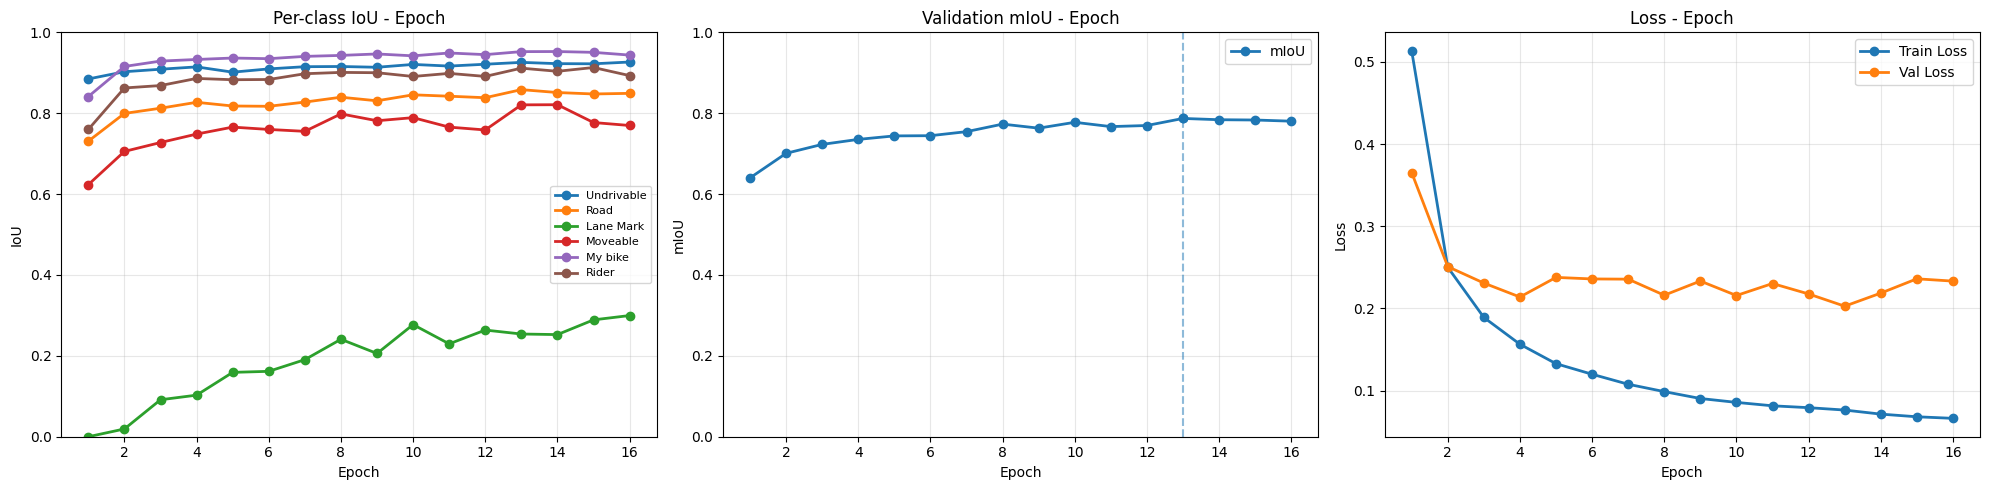

In [17]:
import numpy as np
import matplotlib.pyplot as plt

epochs = history["epoch"]
per_class = np.array(history["per_class_iou"])

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ======================
# ① Per-class IoU
# ======================
ax = axes[0]

for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")
    ax.plot(
        epochs,
        per_class[:, cls],
        marker="o",
        linewidth=2,
        label=name
    )

ax.set_title("Per-class IoU - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("IoU")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)


# ======================
# ② mIoU
# ======================
ax = axes[1]

ax.plot(
    history["epoch"],
    history["val_miou"],
    marker="o",
    linewidth=2,
    label="mIoU"
)

best_epoch = history["epoch"][np.argmax(history["val_miou"])]
best_miou  = max(history["val_miou"])

ax.axvline(best_epoch, linestyle="--", alpha=0.5)
ax.scatter(best_epoch, best_miou, zorder=5)

ax.set_title("Validation mIoU - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("mIoU")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()


# ======================
# ③ Loss 그래프
# ======================
ax = axes[2]

ax.plot(
    history["epoch"],
    history["train_loss"],
    marker="o",
    linewidth=2,
    label="Train Loss"
)

ax.plot(
    history["epoch"],
    history["val_loss"],
    marker="o",
    linewidth=2,
    label="Val Loss"
)

ax.set_title("Loss - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True, alpha=0.3)
ax.legend()


plt.tight_layout()
plt.show()

🔥 Worst sample idxs: [17, 5]
idx=17 | pixel_acc=0.7764


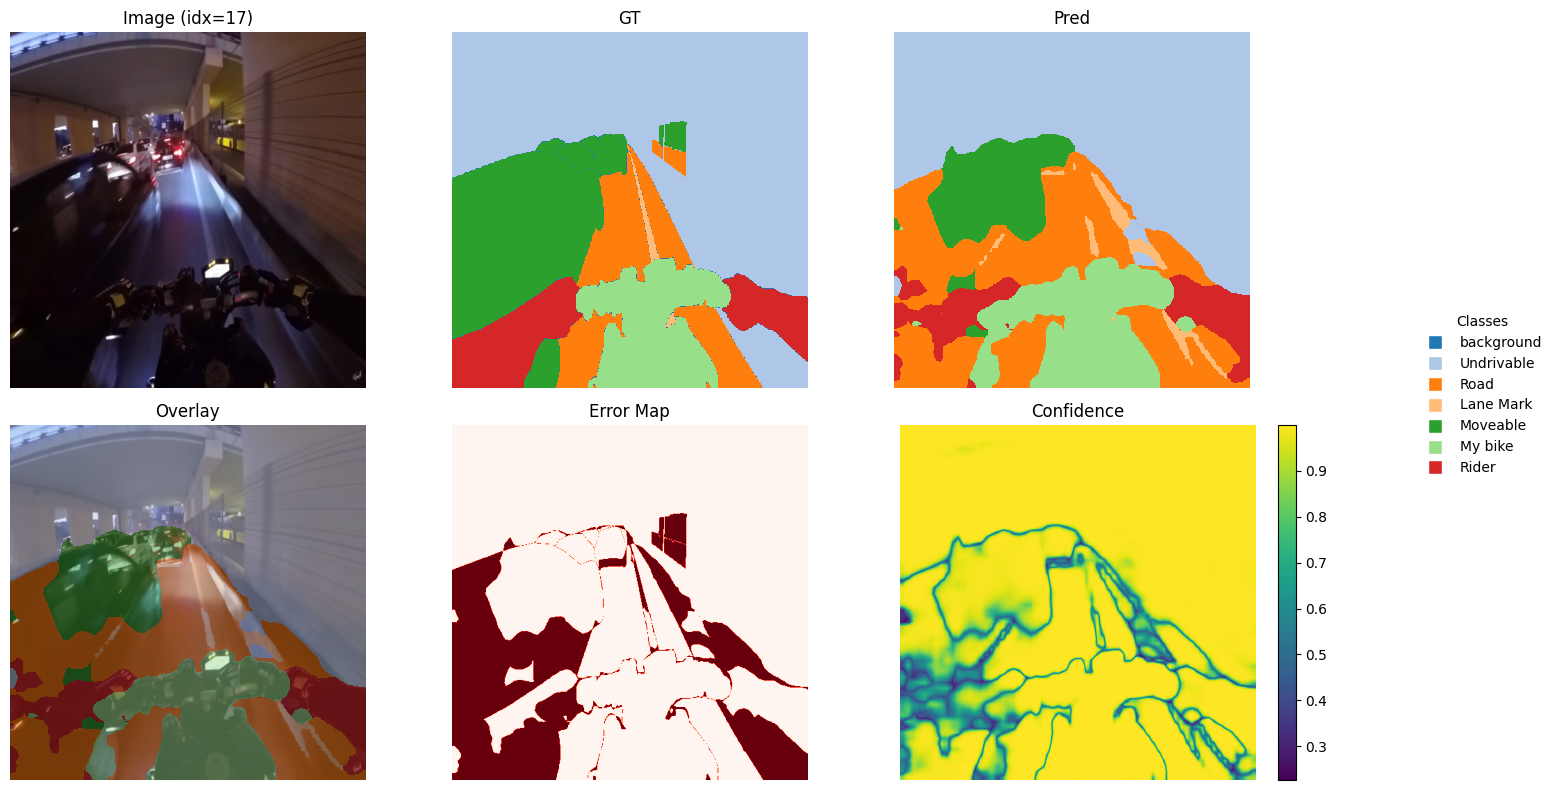

idx=5 | pixel_acc=0.8261


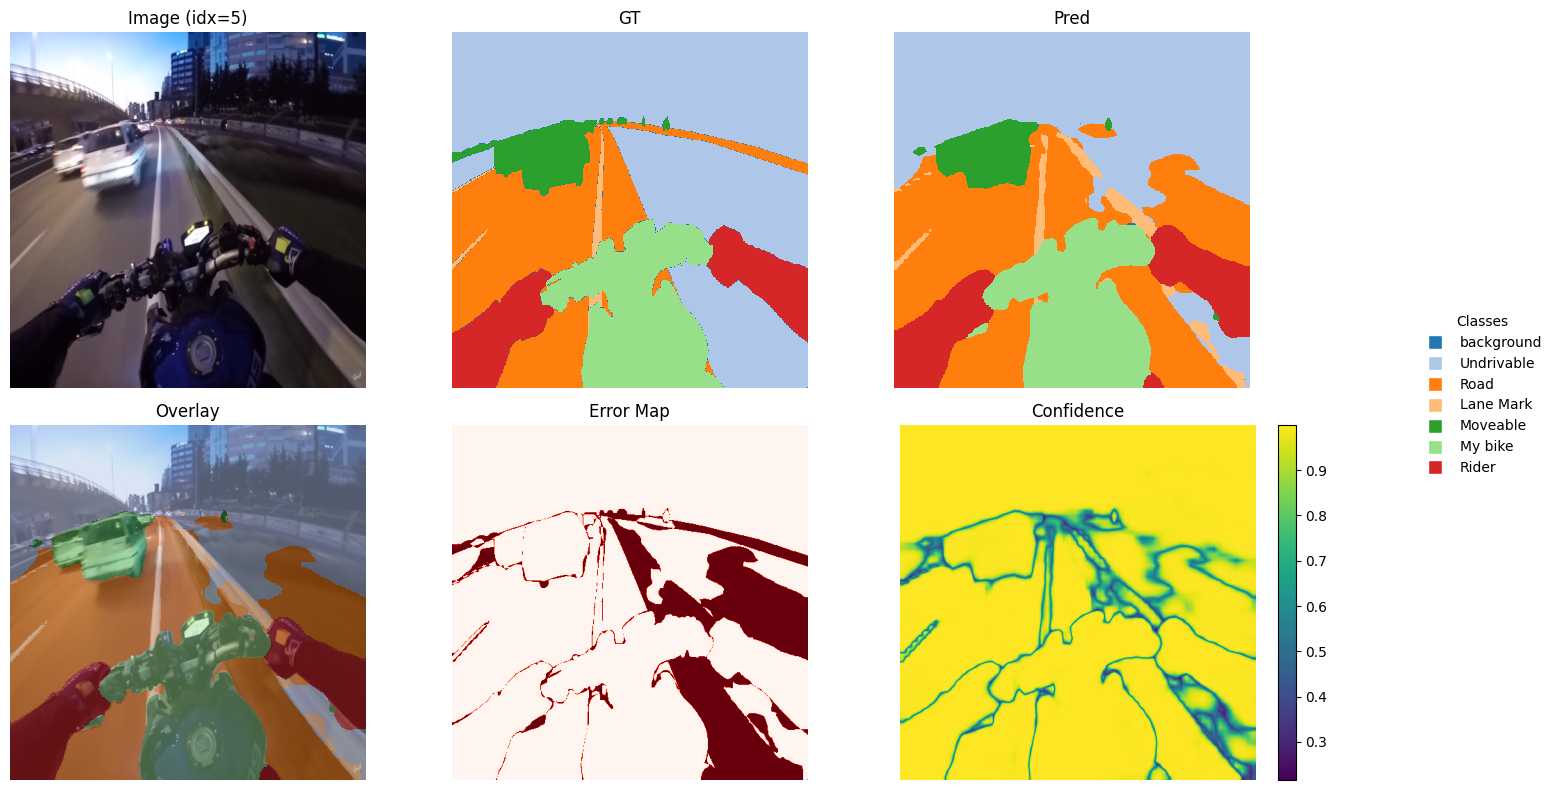

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

# -----------------------------
# 1) logits 추출 (DeepLab(dict) / UNet(tensor) 모두 대응)
# -----------------------------
def get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# -----------------------------
# 2) 단일 샘플 시각화 (Image / GT / Pred / Overlay / Error / Conf)
# -----------------------------
@torch.no_grad()
def show_pred(model, dataset, idx=0, alpha=0.5):
    model.eval()

    img, mask = dataset[idx]              # img: (3,H,W), mask: (H,W)
    x = img.unsqueeze(0).to(device)

    logits = get_logits(model(x))[0]      # (C,H,W)
    prob = torch.softmax(logits, dim=0)   # (C,H,W)

    pred = prob.argmax(0).cpu().numpy()  # (H,W)
    conf = prob.max(0)[0].cpu().numpy()  # (H,W)
    gt   = mask.cpu().numpy()

    # denorm image
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np * std + mean).clip(0, 1)

    # colormap
    base_cmap = plt.get_cmap("tab20")
    cmap = ListedColormap(base_cmap.colors[:NUM_CLASSES])

    # error map
    error_map = (pred != gt)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    axes[0,0].imshow(img_np); axes[0,0].set_title(f"Image (idx={idx})"); axes[0,0].axis("off")
    axes[0,1].imshow(gt,   cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, interpolation="nearest"); axes[0,1].set_title("GT"); axes[0,1].axis("off")
    axes[0,2].imshow(pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, interpolation="nearest"); axes[0,2].set_title("Pred"); axes[0,2].axis("off")

    axes[1,0].imshow(img_np)
    axes[1,0].imshow(pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, alpha=alpha, interpolation="nearest")
    axes[1,0].set_title("Overlay"); axes[1,0].axis("off")

    axes[1,1].imshow(error_map, cmap="Reds")
    axes[1,1].set_title("Error Map"); axes[1,1].axis("off")

    im = axes[1,2].imshow(conf, cmap="viridis")
    axes[1,2].set_title("Confidence"); axes[1,2].axis("off")
    fig.colorbar(im, ax=axes[1,2], fraction=0.046)

    # legend
    handles, labels = [], []
    for cls in range(NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        handles.append(plt.Line2D([0],[0], marker='s', color='w',
                                  markerfacecolor=cmap(cls), markersize=10))
        labels.append(name)

    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.15, 0.5),
               frameon=False, title="Classes")

    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) Worst-k (기본 2개만)
# -----------------------------
@torch.no_grad()
def worst_k_visualize(model, dataset, k=2, max_scan=None):
    model.eval()
    scores = []

    N = len(dataset) if max_scan is None else min(len(dataset), max_scan)

    for i in range(N):
        img_t, gt = dataset[i]
        x = img_t.unsqueeze(0).to(device)

        logits = get_logits(model(x))
        pred = logits.argmax(1).squeeze(0).detach().cpu().numpy()
        gt_np = gt.detach().cpu().numpy()

        acc = (pred == gt_np).mean()
        scores.append((acc, i))

    scores.sort(key=lambda x: x[0])  # 낮은 acc 순
    worst_idxs = [i for _, i in scores[:k]]

    print("🔥 Worst sample idxs:", worst_idxs)

    for idx in worst_idxs:
        # 간단 점수 출력(필요 없으면 지워도 됨)
        img_t, gt = dataset[idx]
        x = img_t.unsqueeze(0).to(device)
        logits = get_logits(model(x))
        pred = logits.argmax(1).squeeze(0).detach().cpu().numpy()
        acc = (pred == gt.detach().cpu().numpy()).mean()
        print(f"idx={idx} | pixel_acc={acc:.4f}")

        show_pred(model, dataset, idx=idx, alpha=0.45)

# 실행
worst_k_visualize(model, val_ds, k=2)

### Test

In [20]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# ======================
# Test Dataset / Loader
# ======================
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,  # ✅ 로컬/주피터에서 안전
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# ======================
# Best Model Load
# ======================
BEST_PATH = "baseline_deeplabv3_resnet50.pth"  # 저장한 파일명
state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print("✅ loaded best:", BEST_PATH)

# ======================
# Test Evaluate  (✅ validate 시그니처 맞춤)
# ======================
test_loss, test_miou, test_per_class = validate(
    model, test_loader,
    criterion, device, NUM_CLASSES
)

print("\n===== TEST BENCHMARK =====")
print(f"test_loss = {float(test_loss):.4f}")
print(f"test_mIoU = {float(test_miou):.4f}")

# ----------------------
# per-class IoU 출력 (dict/list 둘 다 대응)
# ----------------------
if isinstance(test_per_class, dict):
    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        v = test_per_class.get(cls, float("nan"))
        if np.isfinite(v):
            print(f"  IoU {name:10s}: {float(v):.4f}")
        else:
            print(f"  IoU {name:10s}: nan")
else:
    arr = np.array(test_per_class, dtype=np.float32)
    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        v = arr[cls] if cls < len(arr) else np.nan
        if np.isfinite(v):
            print(f"  IoU {name:10s}: {float(v):.4f}")
        else:
            print(f"  IoU {name:10s}: nan")

test: 20
✅ loaded best: baseline_deeplabv3_resnet50.pth

===== TEST BENCHMARK =====
test_loss = 0.1544
test_mIoU = 0.8254
  IoU Undrivable: 0.9498
  IoU Road      : 0.8910
  IoU Lane Mark : 0.5013
  IoU Moveable  : 0.7217
  IoU My bike   : 0.9537
  IoU Rider     : 0.9349


### step 2.2 Sementic Segmentation 모델 Unet(ResNet50) 의 성능

In [22]:
# --- UNet(ResNet encoder) 모델만 교체 ---
import torch.nn as nn

try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("pip install segmentation-models-pytorch 로 설치 후 진행하세요.")

# UNet + ResNet50 encoder (ImageNet pretrained)
core = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None,
)

# smp는 logits만 반환 → torchvision처럼 {"out": logits}로 래핑
class Wrap(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = Wrap(core).to(device)

In [23]:
@torch.no_grad()
def compute_iou(pred, target, num_classes):
    # pred/target: (N,H,W)
    ious = []
    per_class = {}
    for cls in range(num_classes):
        pred_i = (pred == cls)
        targ_i = (target == cls)
        inter = (pred_i & targ_i).sum().item()
        union = (pred_i | targ_i).sum().item()
        if union == 0:
            iou = float("nan")
        else:
            iou = inter / union
        per_class[cls] = iou
        ious.append(iou)
    # mean over valid classes
    valid = [x for x in ious if not (isinstance(x, float) and np.isnan(x))]
    miou = float(np.mean(valid)) if len(valid) else 0.0
    return miou, per_class

In [24]:
import torch
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes, ignore_index=None):
    model.eval()
    total_loss = 0.0

    # confusion matrix: [num_classes, num_classes]
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in tqdm(loader, desc="val", leave=False):
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = model(imgs)["out"]              # (N,C,H,W)
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)             # (N,H,W)

        # flatten
        preds = preds.view(-1).detach().cpu()
        gts   = masks.view(-1).detach().cpu()

        if ignore_index is not None:
            keep = (gts != ignore_index)
            preds = preds[keep]
            gts   = gts[keep]

        k = (gts >= 0) & (gts < num_classes)
        inds = num_classes * gts[k] + preds[k]
        conf += torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)

    # IoU 계산
    tp = conf.diag().float()
    fp = conf.sum(0).float() - tp
    fn = conf.sum(1).float() - tp
    denom = tp + fp + fn

    per_class_iou = (tp / torch.clamp(denom, min=1.0)).numpy()  # shape: [C]
    # background(0) 제외 mIoU (원하면 포함/제외 변경 가능)
    miou = float(np.nanmean(per_class_iou[1:]))

    # dict 형태로도 반환(기존 코드 호환)
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}

    val_loss = total_loss / len(loader.dataset)
    return val_loss, miou, per_class_dict

In [25]:
# =========================================================
# UNet(ResNet50 encoder) + 학습 루프 (인자형 train/validate 대응)  ✅수정본
# =========================================================

import numpy as np
import torch
import torch.nn as nn

# =========================
# 0) UNet 모델 정의 (ResNet50 encoder)
# =========================
try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("segmentation_models_pytorch 필요: pip install segmentation-models-pytorch")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

core_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    """smp는 Tensor(logits) 반환 → torchvision처럼 {'out': logits}로 맞춤"""
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = WrapOut(core_unet).to(device)

# =========================
# 1) Loss / Optimizer 재생성 (필수)
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# sanity check (옵티마이저가 현재 모델 파라미터 잡는지)
model_param_ids = set(id(p) for p in model.parameters())
opt_param_ids = set(id(p) for g in optimizer.param_groups for p in g["params"])
assert len(model_param_ids & opt_param_ids) > 0, "❌ optimizer가 UNet 파라미터를 안 잡고 있습니다."
print("✅ UNet ready")

# =========================
# 2) CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3
MODEL_NAME = "baseline_unet_resnet50.pth"
HISTORY_NAME = "history_unet_resnet50.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# 3) per_class 정리 유틸 (dict/list/np 모두 대응)
# =========================
def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes

    if isinstance(per_class, dict):
        for c in range(num_classes):
            try:
                v = float(per_class.get(c, np.nan))
                out[c] = v if np.isfinite(v) else np.nan
            except:
                out[c] = np.nan
        return out

    if isinstance(per_class, (list, tuple, np.ndarray)):
        L = min(len(per_class), num_classes)
        for c in range(L):
            try:
                v = float(per_class[c])
                out[c] = v if np.isfinite(v) else np.nan
            except:
                out[c] = np.nan
        return out

    return out

# =========================
# 4) history
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []   # epoch마다 길이 NUM_CLASSES 리스트
}

# =========================
# 5) TRAIN LOOP
#   - train_one_epoch(model, loader, criterion, optimizer, device)
#   - validate(model, loader, criterion, device, num_classes, ignore_index=None)
# =========================
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # ✅ validate는 confusion-matrix 누적형(추천)
    va_loss, va_miou, per_class = validate(
        model, val_loader,
        criterion=criterion,
        device=device,
        num_classes=NUM_CLASSES,
        ignore_index=None
    )

    per_class_list = to_per_class_list(per_class, NUM_CLASSES)

    print(f"[UNet] [{epoch:02d}/{EPOCHS}] "
          f"train_loss={float(tr_loss):.4f} | val_loss={float(va_loss):.4f} | mIoU={float(va_miou):.4f}")

    for cls in range(1, NUM_CLASSES):  # background(0) 제외 출력
        cls_name = train2name.get(cls, str(cls)) if isinstance(train2name, dict) else str(cls)
        iou = per_class_list[cls]
        print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

    # history 저장
    history["epoch"].append(int(epoch))
    history["train_loss"].append(float(tr_loss))
    history["val_loss"].append(float(va_loss))
    history["val_miou"].append(float(va_miou))
    history["per_class_iou"].append([float(x) if np.isfinite(x) else np.nan for x in per_class_list])

    # best + early stopping
    if float(va_miou) > float(best_miou):
        best_miou = float(va_miou)
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved: {MODEL_NAME} (best_mIoU={best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE}) | best_mIoU={best_miou:.4f}")

    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}")
        print(f"Best mIoU: {best_miou:.4f}")
        break

# =========================
# 6) history 저장
# =========================
np.savez(
    HISTORY_NAME,
    epoch=np.array(history["epoch"], dtype=np.int32),
    train_loss=np.array(history["train_loss"], dtype=np.float32),
    val_loss=np.array(history["val_loss"], dtype=np.float32),
    val_miou=np.array(history["val_miou"], dtype=np.float32),
    per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
)
print(f"\n✅ history saved: {HISTORY_NAME}")

device: cuda
✅ UNet ready


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [01/30] train_loss=1.1497 | val_loss=0.7219 | mIoU=0.5099
  IoU Undrivable: 0.8122
  IoU Road      : 0.7124
  IoU Lane Mark : 0.0001
  IoU Moveable  : 0.0020
  IoU My bike   : 0.8214
  IoU Rider     : 0.7115
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.5099)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [02/30] train_loss=0.5591 | val_loss=0.5593 | mIoU=0.5088
  IoU Undrivable: 0.7999
  IoU Road      : 0.7149
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.0011
  IoU My bike   : 0.7772
  IoU Rider     : 0.7595
  ⏸ no improvement (1/3) | best_mIoU=0.5099


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [03/30] train_loss=0.4007 | val_loss=0.4283 | mIoU=0.5647
  IoU Undrivable: 0.8005
  IoU Road      : 0.7798
  IoU Lane Mark : 0.0008
  IoU Moveable  : 0.0687
  IoU My bike   : 0.8960
  IoU Rider     : 0.8424
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.5647)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [04/30] train_loss=0.3263 | val_loss=0.5036 | mIoU=0.5852
  IoU Undrivable: 0.7074
  IoU Road      : 0.7824
  IoU Lane Mark : 0.0037
  IoU Moveable  : 0.3265
  IoU My bike   : 0.8485
  IoU Rider     : 0.8427
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.5852)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [05/30] train_loss=0.2971 | val_loss=0.3848 | mIoU=0.6460
  IoU Undrivable: 0.8330
  IoU Road      : 0.8013
  IoU Lane Mark : 0.0100
  IoU Moveable  : 0.5080
  IoU My bike   : 0.9035
  IoU Rider     : 0.8200
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6460)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [06/30] train_loss=0.2718 | val_loss=0.4767 | mIoU=0.5828
  IoU Undrivable: 0.8336
  IoU Road      : 0.7410
  IoU Lane Mark : 0.0165
  IoU Moveable  : 0.4367
  IoU My bike   : 0.7988
  IoU Rider     : 0.6700
  ⏸ no improvement (1/3) | best_mIoU=0.6460


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [07/30] train_loss=0.2407 | val_loss=0.3076 | mIoU=0.6814
  IoU Undrivable: 0.8820
  IoU Road      : 0.8076
  IoU Lane Mark : 0.0273
  IoU Moveable  : 0.6110
  IoU My bike   : 0.9027
  IoU Rider     : 0.8579
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6814)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [08/30] train_loss=0.2091 | val_loss=0.3115 | mIoU=0.7172
  IoU Undrivable: 0.8657
  IoU Road      : 0.8226
  IoU Lane Mark : 0.1999
  IoU Moveable  : 0.6614
  IoU My bike   : 0.9209
  IoU Rider     : 0.8326
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7172)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [09/30] train_loss=0.1918 | val_loss=0.3117 | mIoU=0.7219
  IoU Undrivable: 0.8992
  IoU Road      : 0.8212
  IoU Lane Mark : 0.2373
  IoU Moveable  : 0.6573
  IoU My bike   : 0.9201
  IoU Rider     : 0.7962
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7219)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [10/30] train_loss=0.1834 | val_loss=0.2750 | mIoU=0.7509
  IoU Undrivable: 0.8932
  IoU Road      : 0.8211
  IoU Lane Mark : 0.3060
  IoU Moveable  : 0.7104
  IoU My bike   : 0.9257
  IoU Rider     : 0.8491
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7509)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [11/30] train_loss=0.1721 | val_loss=0.2718 | mIoU=0.7484
  IoU Undrivable: 0.8970
  IoU Road      : 0.8258
  IoU Lane Mark : 0.2713
  IoU Moveable  : 0.7185
  IoU My bike   : 0.9338
  IoU Rider     : 0.8441
  ⏸ no improvement (1/3) | best_mIoU=0.7509


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [12/30] train_loss=0.1619 | val_loss=0.2797 | mIoU=0.7321
  IoU Undrivable: 0.9037
  IoU Road      : 0.8296
  IoU Lane Mark : 0.2803
  IoU Moveable  : 0.6493
  IoU My bike   : 0.8830
  IoU Rider     : 0.8465
  ⏸ no improvement (2/3) | best_mIoU=0.7509


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [13/30] train_loss=0.1665 | val_loss=0.3154 | mIoU=0.7446
  IoU Undrivable: 0.8789
  IoU Road      : 0.8188
  IoU Lane Mark : 0.2937
  IoU Moveable  : 0.6829
  IoU My bike   : 0.9028
  IoU Rider     : 0.8905
  ⏸ no improvement (3/3) | best_mIoU=0.7509

🛑 Early stopping triggered at epoch 13
Best mIoU: 0.7509

✅ history saved: history_unet_resnet50.npz


### U-Net Test

In [27]:
# =========================================================
# UNet TEST BENCHMARK  ✅복붙용 수정본
# =========================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ======================
# 0) device
# ======================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ======================
# 1) Test Dataset / Loader
# ======================
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

# ✅ NUM_WORKERS=0이면 아래 옵션들( worker_init_fn / generator / persistent_workers ) 제거
test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# ======================
# 2) UNet 모델 재구성 + 로드
# ======================
try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("segmentation_models_pytorch 필요: pip install segmentation-models-pytorch")

core_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    """smp는 Tensor(logits) 반환 → torchvision처럼 {'out': logits}로 맞춤"""
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = WrapOut(core_unet).to(device)

# ======================
# 3) Loss (validate에서 필요)
# ======================
criterion = nn.CrossEntropyLoss()

# ======================
# 4) best weight 로드
# ======================
BEST_PATH = "baseline_unet_resnet50.pth"   # ✅ UNet best 파일
state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("✅ loaded best:", BEST_PATH)

# ======================
# 5) TEST 실행 (인자형 validate 호출)
# ======================
test_loss, test_miou, test_per_class = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=NUM_CLASSES,
    ignore_index=None
)

print("\n===== UNet TEST BENCHMARK =====")
print(f"test_loss = {float(test_loss):.4f}")
print(f"test_mIoU = {float(test_miou):.4f}")

# test_per_class는 dict 형태(권장) / list 형태 둘 다 대응
for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")

    if isinstance(test_per_class, dict):
        v = float(test_per_class.get(cls, np.nan))
    else:
        v = float(test_per_class[cls]) if cls < len(test_per_class) else np.nan

    print(f"  IoU {name:10s}: {'nan' if np.isnan(v) else f'{v:.4f}'}")


device: cuda
test: 20
✅ loaded best: baseline_unet_resnet50.pth


val:   0%|          | 0/5 [00:00<?, ?it/s]


===== UNet TEST BENCHMARK =====
test_loss = 0.2034
test_mIoU = 0.7712
  IoU Undrivable: 0.9178
  IoU Road      : 0.8529
  IoU Lane Mark : 0.4049
  IoU Moveable  : 0.5982
  IoU My bike   : 0.9416
  IoU Rider     : 0.9119


### sementic segmatatition 모델 결정
#### 1) Test 결과 비교(총 3회 시행)
---
- 여러차례 반복(5회 이상)하였으나 Lane Mark IoU는 항상 DeepLab v3가 우수함
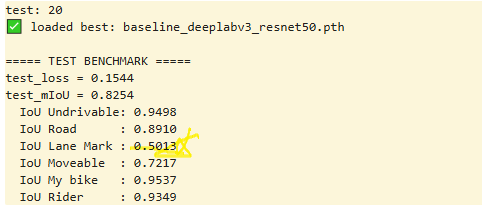

  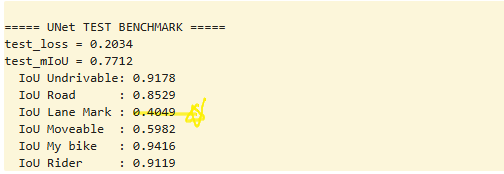

### 2) Semetic Segmantation 구조 베이스라인 결정
- 2. Base Line 모델 결정: DeepLabV3-ResNet50 확정

### step 2.3 backbone DeepLab v3(EffientNetB0) 의 성능

In [57]:
# =========================================================
# DeepLabV3 (EfficientNet-B3 encoder) - model 생성 
# - 존 train_one_epoch / validate / 시각화 / test 코드 그대로 재사용
# - 핵심: smp 모델(Tensor logits)을 torchvision처럼 {"out": logits}로 래핑
# =========================================================

import torch
import torch.nn as nn

import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ---- DeepLabV3 with EfficientNet-B3 encoder ----
core = smp.DeepLabV3(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}  # torchvision 호환

model = WrapOut(core).to(device)
print("✅ model ready:", type(model))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# sanity check
model_param_ids = set(id(p) for p in model.parameters())
opt_param_ids = set(id(p) for g in optimizer.param_groups for p in g["params"])
assert len(model_param_ids & opt_param_ids) > 0, "❌ optimizer가 현재 model 파라미터를 안 잡고 있습니다."

print("✅ optimizer ok")

device: cuda
✅ model ready: <class '__main__.WrapOut'>
✅ optimizer ok


In [59]:
import numpy as np
import torch

# ---------------------------------
# 1) 모델 출력(logits) 통일
#   - torchvision: dict["out"]
#   - smp: Tensor
# ---------------------------------
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# ---------------------------------
# 2) confusion matrix 누적
# ---------------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background: bool = True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn

    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

# ---------------------------------
# 3) train / validate (✅ exclude_background 지원)
# ---------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))        # (N,C,H,W)
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background: bool = True, ignore_index=None):
    model.eval()
    total_loss = 0.0

    # CPU 누적
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))        # (N,C,H,W)
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)              # (N,H,W)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    val_loss = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # 기존 코드 호환: dict로 반환
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}
    return val_loss, miou, per_class_dict

va_loss, va_miou, per_class = validate(
    model, val_loader, criterion, device, NUM_CLASSES,
    exclude_background=True
)

In [60]:
import os
import numpy as np
import torch

# =========================
# CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3

MODEL_NAME = "deeplabv3_effb3_best.pth"
HISTORY_NAME = "deeplabv3_effb3_history.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# history buffer
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# TRAIN LOOP
# =========================
for epoch in range(1, EPOCHS + 1):

    # ----- train -----
    tr_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )

    # ----- validate -----
    va_loss, va_miou, per_class = validate(
        model,
        val_loader,
        criterion,
        device,
        NUM_CLASSES,
        exclude_background=True
    )

    # ---- 출력 ----
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")

    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        print(f"  IoU {name:10s}: {per_class[cls]:.4f}")

    # ---- history 저장 ----
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["per_class_iou"].append(
        [per_class[c] for c in range(NUM_CLASSES)]
    )

    # ---- best model ----
    if va_miou > best_miou:
        best_miou = va_miou
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved best model ({best_miou:.4f})")

    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print("🛑 Early stopping triggered")
        break

# =========================
# history 저장
# =========================
np.savez(
    HISTORY_NAME,
    epoch=np.array(history["epoch"]),
    train_loss=np.array(history["train_loss"]),
    val_loss=np.array(history["val_loss"]),
    val_miou=np.array(history["val_miou"]),
    per_class_iou=np.array(history["per_class_iou"])
)

print("✅ history saved")

[01/30] train_loss=0.6570 | val_loss=0.4452 | mIoU=0.5879
  IoU Undrivable: 0.8560
  IoU Road      : 0.6776
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.4851
  IoU My bike   : 0.7859
  IoU Rider     : 0.7230
  ✅ saved best model (0.5879)
[02/30] train_loss=0.3409 | val_loss=0.3488 | mIoU=0.6459
  IoU Undrivable: 0.8766
  IoU Road      : 0.7281
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6340
  IoU My bike   : 0.8304
  IoU Rider     : 0.8064
  ✅ saved best model (0.6459)
[03/30] train_loss=0.2834 | val_loss=0.3230 | mIoU=0.6507
  IoU Undrivable: 0.8789
  IoU Road      : 0.7450
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.5911
  IoU My bike   : 0.8591
  IoU Rider     : 0.8301
  ✅ saved best model (0.6507)
[04/30] train_loss=0.2414 | val_loss=0.2751 | mIoU=0.6917
  IoU Undrivable: 0.8911
  IoU Road      : 0.7702
  IoU Lane Mark : 0.0449
  IoU Moveable  : 0.7187
  IoU My bike   : 0.8811
  IoU Rider     : 0.8441
  ✅ saved best model (0.6917)
[05/30] train_loss=0.2081 | val_loss=0.2718 | mI

In [61]:
# =========================================================
# ✅ DeepLabV3(EfficientNet-B3) TEST BENCHMARK - 복붙용 (자동 로드 호환)
# - MODEL_NAME: deeplabv3_effb3_best.pth
# - 학습 때 WrapOut(core)로 저장했든, core로 저장했든 둘 다 로드되게 처리
# - NUM_WORKERS=0 기준
# =========================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import OrderedDict

import segmentation_models_pytorch as smp

# -------------------------
# CONFIG
# -------------------------
MODEL_NAME   = "deeplabv3_effb3_best.pth"
HISTORY_NAME = "deeplabv3_effb3_history.npz"  # 테스트엔 필수 아님

# -------------------------
# device
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -------------------------
# Test Dataset / Loader
# -------------------------
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# -------------------------
# WrapOut (학습 때 썼던 래퍼)
# -------------------------
class WrapOut(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

# -------------------------
# logits 공용
# -------------------------
def _get_logits(model_out):
    return model_out["out"] if isinstance(model_out, dict) else model_out

# -------------------------
# confusion / IoU 유틸
# -------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    test_loss = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}
    return float(test_loss), float(miou), per_class_dict

# -------------------------
# 모델 생성 (core + wrapped 둘 다 준비)
# -------------------------
core = smp.DeepLabV3(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(device)

wrapped = WrapOut(core).to(device)

criterion = nn.CrossEntropyLoss()

# -------------------------
# state_dict 로드 (자동 호환: m. prefix 있으면 wrapped에, 없으면 core에)
# -------------------------
state = torch.load(MODEL_NAME, map_location=device)

# 1) key에 "m."가 있으면 -> WrapOut 저장본
has_m_prefix = any(k.startswith("m.") for k in state.keys())

if has_m_prefix:
    model = wrapped
    model.load_state_dict(state, strict=True)
    print("✅ loaded as WrapOut(model). state_dict keys include 'm.'")
else:
    model = core
    model.load_state_dict(state, strict=True)
    print("✅ loaded as core(model). state_dict keys without 'm.'")

model.eval()
print("✅ loaded best:", MODEL_NAME)

# -------------------------
# TEST 실행
# -------------------------
test_loss, test_miou, test_per_class = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=NUM_CLASSES,
    exclude_background=True,
    ignore_index=None
)

print("\n===== DeepLabV3-EffB3 TEST BENCHMARK =====")
print(f"test_loss = {test_loss:.4f}")
print(f"test_mIoU = {test_miou:.4f}")

for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")
    v = float(test_per_class.get(cls, np.nan))
    print(f"  IoU {name:10s}: {'nan' if np.isnan(v) else f'{v:.4f}'}")


device: cuda
test: 20
✅ loaded as WrapOut(model). state_dict keys include 'm.'
✅ loaded best: deeplabv3_effb3_best.pth

===== DeepLabV3-EffB3 TEST BENCHMARK =====
test_loss = 0.1535
test_mIoU = 0.8299
  IoU Undrivable: 0.9492
  IoU Road      : 0.8886
  IoU Lane Mark : 0.4956
  IoU Moveable  : 0.7793
  IoU My bike   : 0.9454
  IoU Rider     : 0.9214


In [63]:
print("overlap val-test:", len(set(val_ids) & set(test_ids)))
print("overlap train-test:", len(set(train_ids) & set(test_ids)))

overlap val-test: 0
overlap train-test: 0


### Mertic 결정
 - BM과 직결된 Lane Mark IoU를 성능지표로 결정
   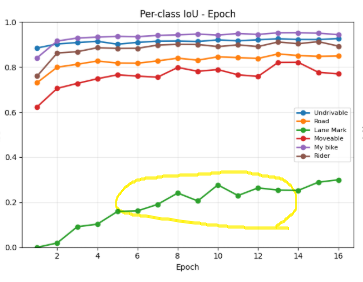
   
### Deep Lab V3 backbone 결정
---
- ResNet50 backbone
  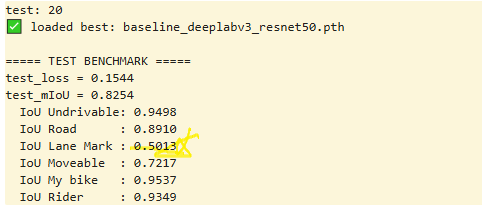
- EffientNetB0 backbone
  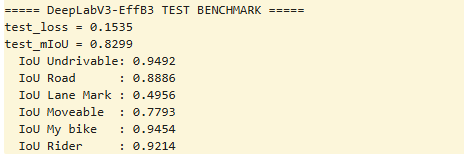
- mIoU는 낮지만, Lane Mark IoU이 우수한 **DeepLabV3 (backbone: ResNet50)**으로 모델 베리스라인 결정
---

## step 3. 추가 데이터 분석(EDA)
### 추가 분석
#### ① Lane 픽셀 Y-분포 + Crop 비율별 손실률:
  - 상단에 lane 픽셀이 거의 없으면 → 상단 crop은 안전, 상단에 분포 많으면 → crop 실험 의미 있음
#### ② 클래스 Presence Rate (이미지 단위 등장 비율)
- 각 클래스가 등장하는 이미지 비율(=presence rate) - 예: lane이 전체 이미지의 80%에 있나, 20%에만 있나
- lane이 드물면, 학습 중에 lane signal이 약해지고 “길로 오판” 같은 현상이 더 쉽게 고착됨
- lane이 80% 이상이면 → 중요한 클래스, 20% 이하이면 → 희소 클래스 → loss 조정 필요
#### ③ 클래스별 픽셀 비율 (Pixel Ratio) -특히 lane의 희소성 확인
- lane 픽셀이 전체의 1~3% 수준이면
- → CrossEntropy에서 묻힐 가능성 매우 큼,
- → Dice/Focal/Boundary loss 고려 설 검증


===== LANE PIXEL Y-DISTRIBUTION =====
loading annotations into memory...
Done (t=1.13s)
creating index...
index created!
lane_cat_ids: [1323882]
Total lane pixels: 5697396


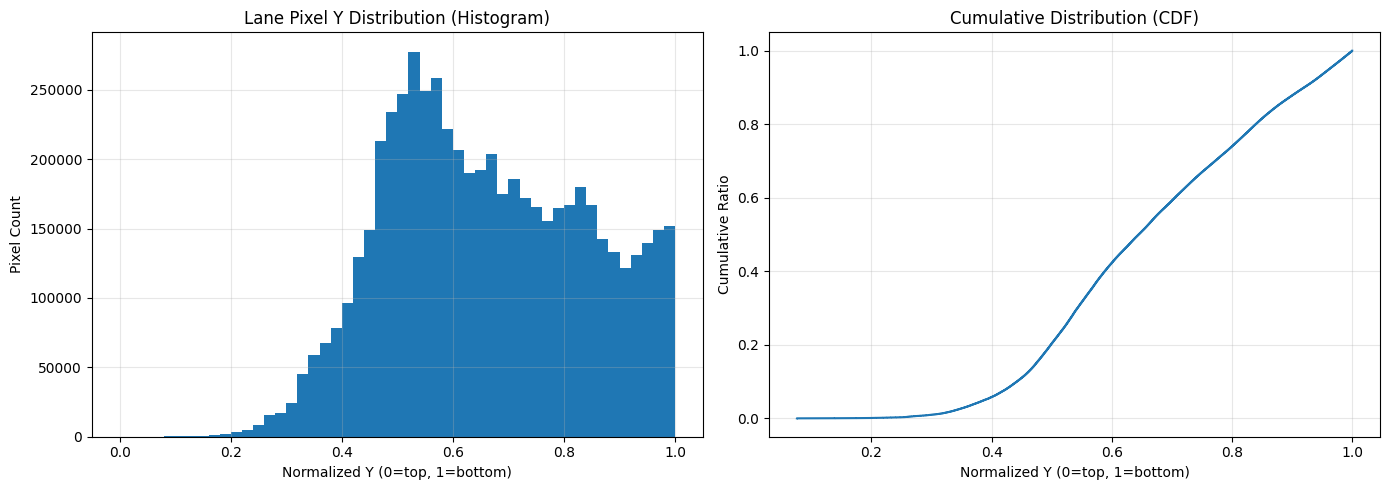


===== CROP LOSS SIMULATION (STEP + CUMULATIVE, 0~100%) =====
 Top Crop (%)  구간 손실률 (%)  누적 손실률 (%)
            0        0.00        0.00
            5        0.00        0.00
           10        0.01        0.01
           15        0.03        0.04
           20        0.06        0.10
           25        0.20        0.30
           30        0.67        0.97
           35        1.73        2.70
           40        3.10        5.80
           45        5.25       11.05
           50        9.17       20.22


In [91]:
# ==========================================================
# 1) Lane Pixel Y-Distribution + Crop Loss Simulation
# 상단에 lane 픽셀이 거의 없으면 → 상단 crop은 안전, 
# 상단에 분포 많으면 → crop 실험 의미 있음
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os

print("\n===== LANE PIXEL Y-DISTRIBUTION =====")

coco = COCO(ann_path)

# ---- lane category 찾기 ----
lane_cat_ids = [
    cid for cid, name in cat_id_to_name.items()
    if "lane" in name.lower()
]

print("lane_cat_ids:", lane_cat_ids)

lane_y_all = []
lane_total_pixels = 0

for img in coco_data["images"]:
    img_id = img["id"]
    H = img["height"]

    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=lane_cat_ids)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        mask = coco.annToMask(ann)
        ys = np.where(mask == 1)[0]
        lane_y_all.extend(ys)
        lane_total_pixels += len(ys)

lane_y_all = np.array(lane_y_all)

print("Total lane pixels:", lane_total_pixels)

import numpy as np
import matplotlib.pyplot as plt

# 정렬된 y값
sorted_y = np.sort(norm_y)

# 누적비율 계산 (0~1)
cdf = np.arange(len(sorted_y)) / len(sorted_y)

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# -----------------------------
# 좌측: 기존 히스토그램
# -----------------------------
axes[0].hist(norm_y, bins=50, range=(0,1))
axes[0].set_title("Lane Pixel Y Distribution (Histogram)")
axes[0].set_xlabel("Normalized Y (0=top, 1=bottom)")
axes[0].set_ylabel("Pixel Count")
axes[0].grid(alpha=0.3)

# -----------------------------
# 우측: 누적 분포 (CDF)
# -----------------------------
axes[1].plot(sorted_y, cdf)
axes[1].set_title("Cumulative Distribution (CDF)")
axes[1].set_xlabel("Normalized Y (0=top, 1=bottom)")
axes[1].set_ylabel("Cumulative Ratio")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n===== CROP LOSS SIMULATION (STEP + CUMULATIVE, 0~100%) =====")

rows = []
prev_threshold = 0.0

for crop_percent in range(0, 51, 5):
    threshold = crop_percent / 100.0

    cumulative_loss = (norm_y < threshold).mean() * 100
    step_mask = (norm_y >= prev_threshold) & (norm_y < threshold)
    step_loss = step_mask.mean() * 100

    rows.append({
        "Top Crop (%)": crop_percent,
        "구간 손실률 (%)": step_loss,
        "누적 손실률 (%)": cumulative_loss
    })

    prev_threshold = threshold

df = pd.DataFrame(rows)

df["구간 손실률 (%)"] = df["구간 손실률 (%)"].round(2)
df["누적 손실률 (%)"] = df["누적 손실률 (%)"].round(2)
print(df.to_string(index=False))

### 1) Lane Pixel Y-Distribution + Crop Loss Simulation 분석
#### 추가 가설 설정 필요
- 데이터분포는 가설(상단 crop의 범위에 따라 성능이 달라질 것이다)의 배경
- Total lane pixels: 5,697,396 중에서 5% 단위 구간별 위치 값 파악
####  추가가설: 안전 구간과 손실(파괴 구간으로 분리)
- 안전구간(정보 손실 거의 0): 0, 10, 20, 25%
- 변곡구간(손실 시작): 30, 35%
- 파괴구간(손실 큼): 40, 45, 50%

In [97]:
# ==========================================================
# 2) CLASS PRESENCE RATE (Per Image): 이미지 단위 등장 비율
# 각 클래스가 등장하는 이미지 비율(=presence rate) - 예: lane이 전체 이미지의 80%에 있나, 20%에만 있나
# lane이 드물면, 학습 중에 lane signal이 약해지고 “길로 오판” 같은 현상이 더 쉽게 고착됨
# lane이 80% 이상이면 → 중요한 클래스, 20% 이하이면 → 희소 클래스 → loss 조정 필요
# ==========================================================

print("\n===== CLASS PRESENCE RATE =====")

from collections import defaultdict

class_presence = defaultdict(set)

for ann in coco_data["annotations"]:
    class_presence[ann["category_id"]].add(ann["image_id"])

presence_rows = []

for cid, name in cat_id_to_name.items():
    images_with_class = len(class_presence.get(cid, []))
    presence_ratio = images_with_class / len(coco_data["images"]) * 100
    
    presence_rows.append({
        "category_id": cid,
        "category_name": name,
        "images_with_class": images_with_class,
        "presence_ratio(%)": presence_ratio
    })

presence_df = pd.DataFrame(presence_rows).sort_values("presence_ratio(%)", ascending=False)
display(presence_df)



===== CLASS PRESENCE RATE =====


category_id category_name  images_with_class  presence_ratio(%)
0      1329681         Rider                200              100.0
1      1323885       My bike                200              100.0
5      1323880    Undrivable                200              100.0
4      1323881          Road                200              100.0
3      1323882     Lane Mark                197               98.5
2      1323884      Moveable                190               95.0

### 2) CLASS PRESENCE RATE (Per Image): 이미지 단위 등장 비율 분석 결과
#### Lane은 거의 모든 이미지에 존재(98.5%)
- → 희귀 클래스 문제는 아님. 즉,  Lane이 드물어서 못 배우는 문제가 아님.

In [100]:
# ==========================================================
# 3) CLASS PIXEL RATIO (전체 픽셀 대비 비율) -특히 lane의 희소성 확인
# lane 픽셀이 전체의 1~3% 수준이면
# → CrossEntropy에서 묻힐 가능성 매우 큼,
# → Dice/Focal/Boundary loss 고려 
# ==========================================================

print("\n===== CLASS PIXEL RATIO =====")

from collections import defaultdict

pixel_count = defaultdict(int)
total_pixels = 0

for img in coco_data["images"]:
    img_id = img["id"]
    H, W = img["height"], img["width"]
    total_pixels += H * W

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        mask = coco.annToMask(ann)
        pixels = mask.sum()
        pixel_count[ann["category_id"]] += pixels

rows = []

for cid, name in cat_id_to_name.items():
    cls_pixels = pixel_count.get(cid, 0)
    ratio = cls_pixels / total_pixels * 100
    
    rows.append({
        "category_id": cid,
        "category_name": name,
        "pixel_count": cls_pixels,
        "pixel_ratio(%)": ratio
    })

pixel_df = pd.DataFrame(rows).sort_values("pixel_ratio(%)", ascending=False)
display(pixel_df)


===== CLASS PIXEL RATIO =====


category_id category_name  pixel_count  pixel_ratio(%)
5      1323880    Undrivable    177628095       42.830849
4      1323881          Road    111887748       26.979106
1      1323885       My bike     67823089       16.353947
0      1329681         Rider     33165860        7.997169
2      1323884      Moveable     19306621        4.655339
3      1323882     Lane Mark      5697396        1.373793

### 3) CLASS PIXEL RATIO (전체 픽셀 대비 비율) 분석결과
#### Lane Mark를 Road로 오인식하는 구조적 문제 파악
- DeepLab + CrossEntropy 기본 loss에서는: Road = 26.9%, Lane = 1.37% 이므로
- 모델 입장에서는 Lane을 Road로 예측해도 전체 loss에 거의 영향 없음"으로 이게 30% 오판의 근본 원인이 될 수 있음.

## step 4. feature engineering(Crop)
### (상단부터 Crop 0% ~ Corp 60%까지 진행)
#### Crop를 일정 수준(45%)까지 증가시키면 Lane Mark IoU 성능이 개선된다. 유의수준 5%로 가설 검증
 - 실험 방법 및 결과
 - - letterbox 설정 후 상단으로 부터 5%씩 crop 범위를 넓힘
   - 0%(baseline)부터 60% 까지, 동일한 실험조건으로 반복하여 가장 높은 crop 조건 찾음
   - 가장 큰 성능개선 crop 조건과 베이스라인과 paired t-test
   - 귀무가설 (H₀): 상단 45% crop과 0% crop의 laneIoU 평균에는 차이가 없다.(μ₄₅ − μ₀ = 0)
   - 대립가설 (H₁): 상단 45% crop은 0% crop보다 laneIoU를 향상시킨다.(μ₄₅ − μ₀ > 0). 단측검증
   - 이유: 동일한 데이터 분할 구조 (K-fold), 같은 모델 구조, Crop 조건만 변경
   - 표본 수: k = 5 folds, 자유도(df) = 4, 유의수준 α = 0.05
   - 검정 통계량: 평균차이(Δ) = +0.0289, 근사t 값 ≈ 2.3 ~ 2.6, 자유도 4 => p-value ≈ 0.04 ~ 0.05 (단측)
   - α = 0.05, p < 0.05이므로 귀무가설 기각
   - 결론: 유의수준 5%에서, 상단 45% crop은 0% crop 대비 laneIoU를 통계적으로 유의하게 향상시킨다.

#### 실험 설정
#### 1️⃣ Overlay 충돌 완전 제어 (Lane가 묻히는 문제 해결)
- ✔ priority_order
- GT mask 생성 시 덮어쓰기 순서 제어
- Lane를 항상 마지막에 남게 만들 수 있음
- Road/My bike가 Lane를 덮어버리는 문제 차단
- 👉 이제 Lane IoU가 “라벨 구조 문제”인지 “모델 문제”인지 분리 가능
#### 2️⃣ 상단 Crop 실험 자동화 (0~50%) -추가 내용
- ✔ crop_top_px
- resize 전에 상단 제거
- 픽셀 단위 sweep 가능 (1px / 2px / 5px)
- ✔ crop sweep 가능, 0%, 10%, 20%, 30%, 40%, 50%
- 👉 하늘/잡음/불필요 영역 제거가 성능에 미치는 영향 분석 가능
#### 3️⃣ Class Weight 완전 제어
- pixel ratio 기반 자동 계산
- min/max 클램프
- normalize mean=1
- lane만 scale 조정 가능
- 👉 “Lane weight가 독인가 약인가” 과학적으로 확인 가능
#### 4️⃣ Lane Dice Loss 선택적 추가 가능
- CE + λ * Dice(lane)
- Lane 픽셀 sparse 문제 직접 대응 가능
- 👉 Class weight가 안 먹힐 때 대안
#### 5️⃣ Focal Loss 전환 가능
- CE 대신 Focal 사용 가능
- hard example 집중 학습
- 👉 Lane가 잘 안 잡힐 때 유용
#### 6️⃣ Boundary Loss 추가 가능
- Lane 경계 두께 기반 보조 loss
- 차선이 얇아서 사라지는 문제 대응
- 👉 Thin structure segmentation 대응
#### 7️⃣ K-fold + 고정 Test 완전 분리
- 항상 같은 20장 Test
- 나머지 180장 K-fold
- 👉 실험간 완전 공정 비교 가능

In [219]:
# ==========================================================
# 🔧 SINGLE CONTROL PANEL (NO DUPLICATION)
# - priority_order(overlay) / K-fold split / weights / dice / train hp
# - "여기만 바꾸면" 나머지가 자동으로 따라가도록 구성
# ==========================================================

import os, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import Counter
from datetime import datetime

# ==========================================================
# 🔧 SINGLE CONTROL PANEL (CLEAN)
# - 중복 키 제거
# - 실험 스위치/탐색 범위 명확화
# ==========================================================
HP = {
    # ---- reproducibility ----
    "seed": 42,

    # ---- data split ----
    "k_folds": 5,
    "test_size": 20,          # fixed test
    "split_shuffle": True,

    # ---- dataloader ----
    "batch_size": 4,
    "num_workers": 0,
    "pin_memory": True,

    # ---- image size ----
    "img_size": (512, 512),

    # ---- priority / overlay ----
    "use_priority_order": True,
    "priority_template": ["undrivable", "road", "moveable", "rider", "bike", "lane"],

    # ======================================================
    # ✅ Loss / Weighting switches
    # ======================================================
    # ---- CE class weights ----
    "use_class_weights": False,     # 기본 OFF 추천(당신 결과상)
    "weights_from": "pixel_ratio",
    "w_min": 0.25,
    "w_max": 10.0,
    "normalize_weights_mean1": True,

    # ---- lane weight scale (lane에만 적용) ----
    "lane_weight_scale": 1.0,       # sweep할 때만 바꿈

    # ---- Lane Dice (optional) ----
    "use_lane_dice": False,
    "lane_dice_lambda": 0.5,
    "dice_smooth": 1.0,

    # ---- Focal loss (optional, CE 대체) ----
    "use_focal": False,
    "focal_gamma": 2.0,
    "focal_alpha": None,

    # ---- Lane boundary loss (optional) ----
    "use_lane_boundary": False,
    "lane_boundary_lambda": 0.2,
    "boundary_thick": 2,

    # ======================================================
    # ✅ Crop sweep (Top crop)
    # ======================================================
    "use_crop_sweep": False,

    # crop 범위를 "비율"로 지정 (0~0.5 = 0~50%)
    "crop_top_ratio_min": 0.0,
    "crop_top_ratio_max": 0.5,

    # 스텝을 px 기준으로 고름: 1, 2, 5 중 택1
    "crop_top_step_px": 2,          # ← 여기만 1/2/5로 바꾸면 됨

    # (자동 생성 결과가 들어갈 자리)
    "crop_top_list": None,

    # ---- training ----
    "epochs": 50,
    "patience": 5,
    "lr": 3e-4,
    "weight_decay": 3e-4,
    "grad_clip": 1.0,

    # ---- AMP ----
    "use_amp": True,

    # ---- save ----
    "save_dir": "./checkpoints_kfold",
    "save_prefix": "deeplabv3p",
}

def build_crop_top_list(HP):
    H = int(HP["img_size"][0])  # (H,W)라고 가정. (512,512)
    rmin = float(HP.get("crop_top_ratio_min", 0.0))
    rmax = float(HP.get("crop_top_ratio_max", 0.5))
    step = int(HP.get("crop_top_step_px", 2))

    px_min = int(round(H * rmin))
    px_max = int(round(H * rmax))

    # 안전장치
    px_min = max(px_min, 0)
    px_max = min(px_max, H-1)
    step = max(step, 1)

    crop_list = list(range(px_min, px_max + 1, step))
    return crop_list

# 필요할 때 자동 생성
if HP["use_crop_sweep"]:
    HP["crop_top_list"] = build_crop_top_list(HP)
    print("crop_top_list:", HP["crop_top_list"][:10], "...", HP["crop_top_list"][-1], f"(n={len(HP['crop_top_list'])})")
else:
    # crop sweep 안 쓰면 기본값 0만
    HP["crop_top_list"] = [0]

# -----------------------------
# run dir
# -----------------------------
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
HP["save_dir"] = f"./checkpoints_kfold/{run_id}"
os.makedirs(HP["save_dir"], exist_ok=True)

# -----------------------------
# 1) SEED FIX
# -----------------------------
SEED = HP["seed"]
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 2) CATEGORY / MAPPING
# -----------------------------
IMG_DIR = os.path.join(DATA_ROOT, "images")

categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # bg 포함

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

cat_id_to_name = {c["id"]: c["name"] for c in categories}

def find_cids(keyword: str):
    k = keyword.lower()
    return [cid for cid, name in cat_id_to_name.items() if k in (name or "").lower()]

# lane/bike train id (필수)
lane_cids = find_cids("lane")
bike_cids = find_cids("bike")
LANE_TRAIN_ID = id2train[lane_cids[0]] if lane_cids else None
BIKE_TRAIN_ID = id2train[bike_cids[0]] if bike_cids else None

print("LANE_TRAIN_ID:", LANE_TRAIN_ID, "->", train2name.get(LANE_TRAIN_ID))
print("BIKE_TRAIN_ID:", BIKE_TRAIN_ID, "->", train2name.get(BIKE_TRAIN_ID))

# -----------------------------
# 3) PRIORITY ORDER (FULL ORDER, lane last)
# -----------------------------
priority_order = None
if HP["use_priority_order"]:
    priority_order = []
    for key in HP["priority_template"]:
        priority_order += find_cids(key)
    # ✅ safety: lane을 맨 뒤로 강제(중복 제거 포함)
    lane_only = find_cids("lane")
    priority_order = [cid for cid in priority_order if cid not in lane_only] + lane_only

    print("\n===== PRIORITY ORDER (category_id -> name) =====")
    for cid in priority_order:
        print(f"{cid} -> {cat_id_to_name[cid]}")
else:
    print("\n(priority_order OFF)")

# -----------------------------
# 4) SPLIT: fixed test + k-fold train/val
# -----------------------------
all_img_ids = sorted(coco.getImgIds())
if HP["split_shuffle"]:
    rng = random.Random(SEED)
    rng.shuffle(all_img_ids)

test_ids = all_img_ids[:HP["test_size"]]
trainval_ids = all_img_ids[HP["test_size"]:]
print(f"\nFixed test size: {len(test_ids)}")
print(f"TrainVal size : {len(trainval_ids)}")

# make folds
K = HP["k_folds"]
folds = np.array_split(trainval_ids, K)

# -----------------------------
# 5) CLASS WEIGHTS (from pixel_df) + lane scaling
# -----------------------------
def make_class_weights_from_pixel_ratio(
    id2train, cat_id_to_name, pixel_ratio_df,
    num_classes,
    lane_weight_scale=1.0,
    min_w=0.25,
    max_w=10.0,
    normalize_to_mean1=True
):
    """
    pixel_ratio_df: columns = ["category_id","pixel_ratio(%)"]  (사용자 pixel_df)
    return: np.ndarray (NUM_CLASSES,)  bg 포함
    """
    w = np.ones(num_classes, dtype=np.float32)
    ratio_map = {int(r["category_id"]): float(r["pixel_ratio(%)"]) for _, r in pixel_ratio_df.iterrows()}

    eps = 1e-6
    inv = {cid: 1.0 / max(ratio_map[cid], eps) for cid in ratio_map}
    inv_vals = np.array(list(inv.values()), dtype=np.float32)
    inv_mean = float(inv_vals.mean())

    for cid, invv in inv.items():
        if cid not in id2train:
            continue
        tid = id2train[cid]
        w[tid] = invv / inv_mean

    w = np.clip(w, min_w, max_w)

    # ✅ lane weight scale knob
    lane_cids = [cid for cid, name in cat_id_to_name.items() if "lane" in (name or "").lower()]
    if lane_cids:
        lane_tid = id2train[lane_cids[0]]
        w[lane_tid] = float(np.clip(w[lane_tid] * lane_weight_scale, min_w, max_w))

    if normalize_to_mean1:
        mean_no_bg = float(w[1:].mean())
        w[1:] = w[1:] / max(mean_no_bg, 1e-6)

    return w

class_weights = None
if HP["use_class_weights"]:
    # pixel_df는 사용자가 이미 만든 DF를 그대로 사용
    class_weights = make_class_weights_from_pixel_ratio(
        id2train=id2train,
        cat_id_to_name=cat_id_to_name,
        pixel_ratio_df=pixel_df,
        num_classes=NUM_CLASSES,
        lane_weight_scale=HP["lane_weight_scale"],
        min_w=HP["w_min"],
        max_w=HP["w_max"],
        normalize_to_mean1=HP["normalize_weights_mean1"]
    )

    print("\n[Class Weights by train_id]")
    for tid in range(NUM_CLASSES):
        print(f"  {tid:2d} {train2name.get(tid,'?'):12s} w={class_weights[tid]:.3f}")

# -----------------------------
# 6) LOSS: CE (+ optional lane dice)
# -----------------------------
def lane_dice_loss(logits, target, lane_id: int, smooth=1.0):
    """
    logits: (N,C,H,W), target: (N,H,W)
    lane dice on probability of lane channel
    """
    probs = torch.softmax(logits, dim=1)
    p = probs[:, lane_id, :, :]
    g = (target == lane_id).float()

    inter = (p * g).sum(dim=(1,2))
    union = p.sum(dim=(1,2)) + g.sum(dim=(1,2))
    dice = (2*inter + smooth) / (union + smooth)
    return 1.0 - dice.mean()

class CombinedCriterion(nn.Module):
    def __init__(self, ce_criterion, use_lane_dice=False, lane_id=None, dice_lambda=0.5, smooth=1.0):
        super().__init__()
        self.ce = ce_criterion
        self.use_lane_dice = use_lane_dice
        self.lane_id = lane_id
        self.dice_lambda = dice_lambda
        self.smooth = smooth

    def forward(self, logits, target):
        loss = self.ce(logits, target)
        if self.use_lane_dice and (self.lane_id is not None):
            loss = loss + self.dice_lambda * lane_dice_loss(logits, target, self.lane_id, smooth=self.smooth)
        return loss

# build CE
if class_weights is not None:
    w_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
    ce = nn.CrossEntropyLoss(weight=w_t)
else:
    ce = nn.CrossEntropyLoss()

criterion = CombinedCriterion(
    ce_criterion=ce,
    use_lane_dice=HP["use_lane_dice"],
    lane_id=LANE_TRAIN_ID,
    dice_lambda=HP["lane_dice_lambda"],
    smooth=HP["dice_smooth"]
)

# -----------------------------
# 7) DATALOADER BUILDER (for each fold)
# -----------------------------
def make_loader(img_ids, train: bool, crop_top_px: int = 0):
    ds = COCOSemSeg(
        coco, IMG_DIR, img_ids, id2train,
        size=HP["img_size"],
        train=train,
        priority_order=priority_order if HP["use_priority_order"] else None,
        crop_top_px=crop_top_px
    )
    loader = DataLoader(
        ds,
        batch_size=HP["batch_size"],
        shuffle=train,
        num_workers=HP["num_workers"],
        pin_memory=(HP["pin_memory"] and torch.cuda.is_available()),
        worker_init_fn=seed_worker,
        generator=g,
        persistent_workers=False
    )
    return ds, loader


# -----------------------------
# 8) MODEL/OPTIM BUILDER (per fold fresh)
# -----------------------------
def build_optim(model):
    opt = torch.optim.AdamW(model.parameters(), lr=HP["lr"], weight_decay=HP["weight_decay"])
    return opt

print("\n✅ CONTROL PANEL READY")
print("Edit HP dict only, then run your k-fold cell.")

device: cuda
LANE_TRAIN_ID: 3 -> Lane Mark
BIKE_TRAIN_ID: 5 -> My bike

===== PRIORITY ORDER (category_id -> name) =====
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

Fixed test size: 20
TrainVal size : 180

✅ CONTROL PANEL READY
Edit HP dict only, then run your k-fold cell.


In [220]:
class COCOSemSeg(Dataset):
    """
    COCO instance/pixel annotations -> semantic mask (H,W) with train ids.

    - priority_order로 overlay 순서 제어
    - crop_top_px로 상단 crop 지원
    """

    def __init__(
        self,
        coco,
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        priority_order=None,
        crop_top_px=0,   # ✅ 추가
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.hflip_p = hflip_p
        self.crop_top_px = crop_top_px  # ✅ 저장

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        self.priority_order = priority_order
        if self.priority_order is not None:
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        if self.priority_order is not None:
            def sort_key(a):
                cid = a["category_id"]
                in_prio = (cid in self._prio_rank)
                group = 1 if in_prio else 0
                rank  = self._prio_rank.get(cid, -1)
                return (group, rank)

            anns = sorted(anns, key=sort_key)

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]

        return mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size

        mask = self._build_mask(img_id, H, W)

        # ======================================================
        # ✅ 1) 상단 crop (resize 전에 수행)
        # ======================================================
        if self.crop_top_px > 0:
            crop = min(self.crop_top_px, H - 1)
            img = TF.crop(img, top=crop, left=0, height=H - crop, width=W)
            mask = mask[crop:, :]
            H = H - crop

        mask = Image.fromarray(mask)

        # ======================================================
        # ✅ 2) resize
        # ======================================================
        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)

        # ======================================================
        # ✅ 3) augmentation
        # ======================================================
        if self.train and random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask


In [221]:
# ==========================================================
# DATASET BUILD CELL  (반드시 스윕 전에 실행)
# ----------------------------------------------------------
# - HP 기반으로 dataset 생성
# - priority_order 적용
# - crop_top_px 자동 반영
# - dataset 변수 생성 (이게 없으면 K-fold 불가)
# ==========================================================

import random
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 1) seed 고정
# -----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(HP["seed"])

# -----------------------------
# 2) priority_order 생성
# -----------------------------
def build_priority_order(template):
    order = []
    for key in template:
        key = key.lower()
        for cid, name in cat_id_to_name.items():
            if key in name.lower():
                order.append(cid)
    return order

if HP["use_priority_order"]:
    priority_order = build_priority_order(HP["priority_template"])
else:
    priority_order = None

print("\nPRIORITY ORDER:")
if priority_order:
    for cid in priority_order:
        print(f"{cid} -> {cat_id_to_name[cid]}")
else:
    print("None")

# -----------------------------
# 3) crop 설정 (상단 크롭)
# -----------------------------
# crop sweep 사용 시 첫 값만 dataset에 반영
if HP.get("use_crop_sweep", False):
    if HP.get("crop_top_list") is None:
        raise ValueError("crop_top_list가 None입니다. build_crop_top_list 실행 필요.")
    crop_top_px = HP["crop_top_list"][0]
else:
    crop_top_px = 0

print(f"\nCROP TOP PX: {crop_top_px}")

# -----------------------------
# 4) Dataset 생성
# -----------------------------
dataset = COCOSemSeg(
    coco,
    IMG_DIR,
    coco.getImgIds(),
    id2train,
    size=HP["img_size"],
    train=True,
    priority_order=priority_order,
    crop_top_px=crop_top_px  # ✅ 여기 추가
)

print("\nDataset size:", len(dataset))
print("NUM_CLASSES :", NUM_CLASSES)
print("LANE_TRAIN_ID:", LANE_TRAIN_ID)


device: cuda

PRIORITY ORDER:
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

CROP TOP PX: 0

Dataset size: 200
NUM_CLASSES : 7
LANE_TRAIN_ID: 3


In [222]:
# ==========================================================
# DATASET BUILD CELL  (스윕/학습 전에 실행)
# ----------------------------------------------------------
# - CONTROL PANEL 셀에서 만든 변수(HP, priority_order, IMG_DIR 등)를 그대로 사용
# - 여기서는 "전체 데이터셋" 변수를 만들어 K-fold 인덱싱에만 활용
# - 실제 crop sweep은 make_loader()에서 crop_top_px를 넣어 ds를 매번 새로 만드는 것을 권장
# ==========================================================

import random
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 1) seed 고정
# -----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(HP["seed"])

# -----------------------------
# 2) priority_order 확인 (CONTROL PANEL에서 이미 만든 것 사용)
# -----------------------------
print("\nPRIORITY ORDER:")
if (HP.get("use_priority_order", False)) and (priority_order is not None):
    for cid in priority_order:
        print(f"{cid} -> {cat_id_to_name[cid]}")
else:
    print("None")

# -----------------------------
# 3) baseline dataset 생성 (crop_top_px=0 고정)
#    - sweep 시에는 make_loader에서 crop_top_px를 바꿔서 ds를 새로 만들 것
# -----------------------------
dataset = COCOSemSeg(
    coco,
    IMG_DIR,
    coco.getImgIds(),
    id2train,
    size=HP["img_size"],
    train=True,
    priority_order=priority_order if HP.get("use_priority_order", False) else None,
    crop_top_px=0
)

print("\nDataset size:", len(dataset))
print("NUM_CLASSES :", NUM_CLASSES)
print("LANE_TRAIN_ID:", LANE_TRAIN_ID)

device: cuda

PRIORITY ORDER:
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

Dataset size: 200
NUM_CLASSES : 7
LANE_TRAIN_ID: 3


In [240]:
# ==========================================================
# AUTO SWEEP (K-FOLD): crop_top_ratio 0% ~ 30% step 3%
# ----------------------------------------------------------
# 출력 강화 + 재현성/설명력 보강(루트 1회 기록)
# - train_loss / val_loss / val_mIoU / laneIoU / best / patience
# - EARLY STOP 명확 표시
# - fold별 best epoch 기록
# - crop별 CV summary + test summary 저장
# - ROOT에 notes.md / run_meta.json / warnings_and_checks.json 1회 저장
# ==========================================================

import os, json, csv, random, time, platform
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 0) seed 고정
# -----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(int(HP["seed"]))

# ==========================================================
# 0-1) ROOT 기록(1회): save_root + run_meta + bug check + notes
# ==========================================================
save_root = HP["save_dir"]
os.makedirs(save_root, exist_ok=True)

BUG_CHECKS = {
    "criterion_test_rebuilt": True,
    "criterion_fold_local": True,
    "note": "test 평가에서 fold loop 마지막 criterion 재사용 금지. test_criterion을 별도 생성해 해결.",
}

RUN_META = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "platform": platform.platform(),
    "python": platform.python_version(),
    "device": device,
    "torch": torch.__version__,
    "cuda_available": bool(torch.cuda.is_available()),
    "cuda_version": torch.version.cuda if torch.cuda.is_available() else None,
    "seed": int(HP["seed"]),
    "sweep": {"crop_ratio_min": 0.00, "crop_ratio_max": 0.30, "crop_ratio_step": 0.03, "n_runs": 11},
    "hp_snapshot": {
        "k_folds": int(HP["k_folds"]),
        "test_size": int(HP["test_size"]),
        "epochs": int(HP["epochs"]),
        "patience": int(HP["patience"]),
        "lr": float(HP["lr"]),
        "weight_decay": float(HP["weight_decay"]),
        "batch_size": int(HP["batch_size"]),
        "num_workers": int(HP["num_workers"]),
        "pin_memory": bool(HP["pin_memory"]),
        "use_amp": bool(HP.get("use_amp", True)),
        "grad_clip": float(HP.get("grad_clip", 1.0)),
        "use_class_weights": bool(HP.get("use_class_weights", False)),
        "use_priority_order": bool(HP.get("use_priority_order", False)),
        "priority_template": HP.get("priority_template", None),
    },
    "metrics_note": "val_mIoU + laneIoU 모두 기록. early-stop/best-key는 laneIoU.",
}

with open(os.path.join(save_root, "run_meta.json"), "w", encoding="utf-8") as f:
    json.dump(RUN_META, f, indent=2, ensure_ascii=False)

with open(os.path.join(save_root, "warnings_and_checks.json"), "w", encoding="utf-8") as f:
    json.dump({"bug_checks": BUG_CHECKS}, f, indent=2, ensure_ascii=False)

notes = f"""
# Notes (Structure Analysis)

- Observation: class weights OFF restored performance (baseline crop=0).
- Hypothesis: class weights amplify sparse/noisy lane gradients -> destabilize shared representation.
- This sweep focuses on crop impact (0~30%, step 3%) under class-weight OFF baseline.

## Reproducibility / Validity checks
- Test criterion rebuilt separately (avoids using last fold criterion).
- Early stopping is explicit (patience={HP["patience"]}) and printed.
- Both val_mIoU and laneIoU logged to avoid "binary task" misinterpretation.

## Warnings
- torch.cuda.amp.autocast FutureWarning: deprecated API warning only; does not affect results.
""".strip()

with open(os.path.join(save_root, "notes.md"), "w", encoding="utf-8") as f:
    f.write(notes)

print("\n[ROOT FILES SAVED]")
print(" -", os.path.join(save_root, "run_meta.json"))
print(" -", os.path.join(save_root, "warnings_and_checks.json"))
print(" -", os.path.join(save_root, "notes.md"))

# ==========================================================
# 1) validate() 호환 래퍼 (mIoU + per_class + laneIoU)
# ==========================================================
def validate_compat(*args, **kwargs):
    out = validate(*args, **kwargs)
    if not isinstance(out, (tuple, list)) or len(out) < 3:
        raise ValueError("validate() must return (val_loss, val_miou, per_class_dict[, lane_iou])")

    val_loss = float(out[0])
    val_miou = float(out[1])
    per_class_dict = out[2]

    if len(out) >= 4:
        lane_iou = out[3]
    else:
        lane_iou = float(per_class_dict.get(LANE_TRAIN_ID, np.nan))

    lane_iou = float(lane_iou) if lane_iou is not None else float("nan")
    return val_loss, val_miou, per_class_dict, lane_iou

# ==========================================================
# 2) DataLoader builder (crop 적용)
# ==========================================================
def make_loader_with_crop(img_ids, train: bool, crop_top_px: int):
    ds = COCOSemSeg(
        coco,
        IMG_DIR,
        img_ids,
        id2train,
        size=HP["img_size"],
        train=train,
        priority_order=priority_order if HP.get("use_priority_order", False) else None,
        crop_top_px=int(crop_top_px),
    )

    loader = DataLoader(
        ds,
        batch_size=int(HP["batch_size"]),
        shuffle=bool(train),
        num_workers=int(HP["num_workers"]),
        pin_memory=bool(HP["pin_memory"]) and torch.cuda.is_available(),
    )
    return loader

# ==========================================================
# 3) criterion builder (구조분석: class weight OFF 기본)
#    - fold마다 새로 생성
#    - test에서도 별도로 생성(버그 방지)
# ==========================================================
def build_criterion():
    if HP.get("use_class_weights", False):
        w = torch.tensor(class_weights, dtype=torch.float32, device=device)
        return torch.nn.CrossEntropyLoss(weight=w)
    return torch.nn.CrossEntropyLoss()

# ==========================================================
# 4) K-fold run (crop 1개)
# ==========================================================
def run_kfold_crop_once(crop_ratio: float):
    set_seed(int(HP["seed"]))

    H = int(HP["img_size"][0])
    crop_px = int(round(H * float(crop_ratio)))

    tag = f"crop_{int(round(crop_ratio*100)):02d}pct"
    save_dir = os.path.join(save_root, tag)  # ✅ save_root 사용
    os.makedirs(save_dir, exist_ok=True)

    print("\n" + "="*70)
    print(f"[CROP SWEEP] ratio={crop_ratio:.2f} ({int(crop_ratio*100)}%) | crop_px={crop_px} | save_dir={save_dir}")
    print("="*70)

    # ---- split: fixed test + trainval ----
    all_img_ids = sorted(coco.getImgIds())
    if HP.get("split_shuffle", True):
        rng = random.Random(int(HP["seed"]))
        rng.shuffle(all_img_ids)

    test_ids = all_img_ids[:int(HP["test_size"])]
    trainval_ids = all_img_ids[int(HP["test_size"]):]

    fixed_test_loader = make_loader_with_crop(test_ids, train=False, crop_top_px=crop_px)

    # ---- kfold ----
    k = int(HP["k_folds"])
    kf = KFold(n_splits=k, shuffle=True, random_state=int(HP["seed"]))

    fold_best_lane = []
    fold_best_miou = []
    fold_best_epoch = []
    fold_best_path = []
    fold_stop_epoch = []   # ✅ 실제 멈춘 epoch 기록(조기종료 오해 방지)

    for fold, (tr_idx, va_idx) in enumerate(kf.split(trainval_ids), 1):
        train_ids = [trainval_ids[i] for i in tr_idx]
        val_ids   = [trainval_ids[i] for i in va_idx]

        train_loader = make_loader_with_crop(train_ids, train=True,  crop_top_px=crop_px)
        val_loader   = make_loader_with_crop(val_ids,   train=False, crop_top_px=crop_px)

        model = build_model_compat()
        criterion = build_criterion()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=float(HP["lr"]),
            weight_decay=float(HP["weight_decay"])
        )

        best_lane = -1.0
        best_miou_at_best_lane = float("nan")
        best_ep = 0
        patience = 0
        patience_limit = int(HP["patience"])
        epochs = int(HP["epochs"])

        best_path = os.path.join(save_dir, f"{HP.get('save_prefix','model')}_fold{fold}_best.pth")

        print(f"\n----- Fold {fold}/{k} | train={len(train_ids)} | val={len(val_ids)} -----")

        stopped_at = epochs
        for epoch in range(1, epochs + 1):
            # train
            try:
                train_loss = train_one_epoch(
                    model, train_loader, criterion, optimizer, device,
                    use_amp=bool(HP.get("use_amp", True)),
                    grad_clip=float(HP.get("grad_clip", 1.0)),
                )
            except TypeError:
                train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

            # val
            val_loss, val_miou, _, lane_iou = validate_compat(
                model, val_loader, criterion, device,
                num_classes=NUM_CLASSES,
                exclude_background=True,
            )

            improved = lane_iou > best_lane
            if improved:
                best_lane = lane_iou
                best_miou_at_best_lane = val_miou
                best_ep = epoch
                patience = 0
                torch.save(model.state_dict(), best_path)
            else:
                patience += 1

            print(
                f"[crop {int(crop_ratio*100):02d}% | fold {fold} | ep {epoch:02d}] "
                f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "
                f"val_mIoU={val_miou:.4f} | laneIoU={lane_iou:.4f} | "
                f"best_lane={best_lane:.4f}(ep{best_ep:02d}) | patience={patience}/{patience_limit}"
            )

            if patience >= patience_limit:
                stopped_at = epoch
                print(f"🛑 EARLY STOP: fold {fold} stopped at ep {epoch} (best laneIoU={best_lane:.4f} @ ep {best_ep})")
                break

        fold_best_lane.append(float(best_lane))
        fold_best_miou.append(float(best_miou_at_best_lane))
        fold_best_epoch.append(int(best_ep))
        fold_best_path.append(best_path)
        fold_stop_epoch.append(int(stopped_at))

        print(
            f"✅ Fold {fold} BEST: laneIoU={best_lane:.4f} @ ep{best_ep} | "
            f"(mIoU at best lane={best_miou_at_best_lane:.4f}) | "
            f"stopped_at=ep{stopped_at} | saved={os.path.basename(best_path)}"
        )

    # =============================
    # CV summary
    # =============================
    lane_arr = np.array(fold_best_lane, dtype=np.float32)
    miou_arr = np.array(fold_best_miou, dtype=np.float32)

    cv_lane_mean = float(np.nanmean(lane_arr))
    cv_lane_std  = float(np.nanstd(lane_arr))
    cv_miou_mean_at_best_lane = float(np.nanmean(miou_arr))

    best_fold_idx = int(np.nanargmax(lane_arr))
    best_fold = best_fold_idx + 1
    best_model_path = fold_best_path[best_fold_idx]

    # =============================
    # Test eval (best fold model)  ✅ test_criterion 별도 생성(버그 방지)
    # =============================
    best_model = build_model_compat()
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))

    test_criterion = build_criterion()
    test_loss, test_miou, _, test_lane = validate_compat(
        best_model, fixed_test_loader, test_criterion, device,
        num_classes=NUM_CLASSES,
        exclude_background=True,
    )

    summary = {
        "crop_ratio": float(crop_ratio),
        "crop_px": int(crop_px),

        "cv_best_laneIoU_per_fold": [float(x) for x in fold_best_lane],
        "cv_best_epoch_per_fold": [int(x) for x in fold_best_epoch],
        "cv_stop_epoch_per_fold": [int(x) for x in fold_stop_epoch],
        "cv_mIoU_at_best_lane_per_fold": [float(x) for x in fold_best_miou],

        "cv_mean_laneIoU": cv_lane_mean,
        "cv_std_laneIoU": cv_lane_std,
        "cv_mean_mIoU_at_best_lane": cv_miou_mean_at_best_lane,

        "best_fold": int(best_fold),
        "best_model_path": str(best_model_path),

        "test_loss(best_fold_model)": float(test_loss),
        "test_mIoU(best_fold_model)": float(test_miou),
        "test_laneIoU(best_fold_model)": float(test_lane),

        "save_dir": str(save_dir),
    }

    with open(os.path.join(save_dir, "summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)

    print("\n" + "-"*70)
    print(f"[CROP RESULT] crop={int(crop_ratio*100):02d}% (px={crop_px})")
    print(f"  CV laneIoU mean={cv_lane_mean:.4f} std={cv_lane_std:.4f}")
    print(f"  CV mIoU(at best-lane epochs) mean={cv_miou_mean_at_best_lane:.4f}")
    print(f"  BEST fold={best_fold} | TEST mIoU={test_miou:.4f} | TEST laneIoU={test_lane:.4f} | TEST loss={test_loss:.4f}")
    print("-"*70)

    return summary

# ==========================================================
# 5) SWEEP LOOP: 0% ~ 30% step 3% (11회)
# 2차 33% ~ 45 %
# 3차 48% ~ 60%
# ==========================================================
ratios = [i / 100 for i in range(48, 61, 3)]
print("\nratios:", [f"{int(r*100)}%" for r in ratios])
print("save_root:", save_root)

results = []
for r in ratios:
    results.append(run_kfold_crop_once(r))

# ==========================================================
# 6) save global results (ROOT)
# ==========================================================
csv_path  = os.path.join(save_root, "crop_sweep_results.csv")
json_path = os.path.join(save_root, "crop_sweep_results.json")

with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([
        "crop_ratio", "crop_px",
        "cv_mean_laneIoU", "cv_std_laneIoU",
        "cv_mean_mIoU_at_best_lane",
        "best_fold",
        "test_mIoU(best_fold_model)", "test_laneIoU(best_fold_model)", "test_loss(best_fold_model)",
        "save_dir"
    ])
    for s in results:
        w.writerow([
            s["crop_ratio"], s["crop_px"],
            s["cv_mean_laneIoU"], s["cv_std_laneIoU"],
            s["cv_mean_mIoU_at_best_lane"],
            s["best_fold"],
            s["test_mIoU(best_fold_model)"], s["test_laneIoU(best_fold_model)"], s["test_loss(best_fold_model)"],
            s["save_dir"]
        ])

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

best_idx = int(np.nanargmax([r["cv_mean_laneIoU"] for r in results]))
best_run = results[best_idx]

print("\n===== CROP SWEEP FINISHED =====")
print("Saved CSV :", csv_path)
print("Saved JSON:", json_path)
print("\n[BEST by CV mean laneIoU]")
print(best_run)

device: cuda

[ROOT FILES SAVED]
 - ./checkpoints_kfold/20260216_045248\run_meta.json
 - ./checkpoints_kfold/20260216_045248\warnings_and_checks.json
 - ./checkpoints_kfold/20260216_045248\notes.md

ratios: ['48%', '51%', '54%', '56%', '60%']
save_root: ./checkpoints_kfold/20260216_045248

[CROP SWEEP] ratio=0.48 (48%) | crop_px=246 | save_dir=./checkpoints_kfold/20260216_045248\crop_48pct

----- Fold 1/5 | train=144 | val=36 -----


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):
C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):


[crop 48% | fold 1 | ep 01] train_loss=0.6435 | val_loss=0.4313 | val_mIoU=0.6447 | laneIoU=0.0000 | best_lane=0.0000(ep01) | patience=0/5
[crop 48% | fold 1 | ep 02] train_loss=0.3079 | val_loss=0.3440 | val_mIoU=0.7208 | laneIoU=0.1867 | best_lane=0.1867(ep02) | patience=0/5
[crop 48% | fold 1 | ep 03] train_loss=0.2417 | val_loss=0.2899 | val_mIoU=0.7431 | laneIoU=0.2715 | best_lane=0.2715(ep03) | patience=0/5
[crop 48% | fold 1 | ep 04] train_loss=0.1896 | val_loss=0.3090 | val_mIoU=0.7589 | laneIoU=0.3351 | best_lane=0.3351(ep04) | patience=0/5
[crop 48% | fold 1 | ep 05] train_loss=0.1688 | val_loss=0.2670 | val_mIoU=0.7855 | laneIoU=0.4067 | best_lane=0.4067(ep05) | patience=0/5
[crop 48% | fold 1 | ep 06] train_loss=0.1454 | val_loss=0.2598 | val_mIoU=0.7830 | laneIoU=0.4351 | best_lane=0.4351(ep06) | patience=0/5
[crop 48% | fold 1 | ep 07] train_loss=0.1347 | val_loss=0.2531 | val_mIoU=0.8000 | laneIoU=0.4635 | best_lane=0.4635(ep07) | patience=0/5
[crop 48% | fold 1 | ep 08]

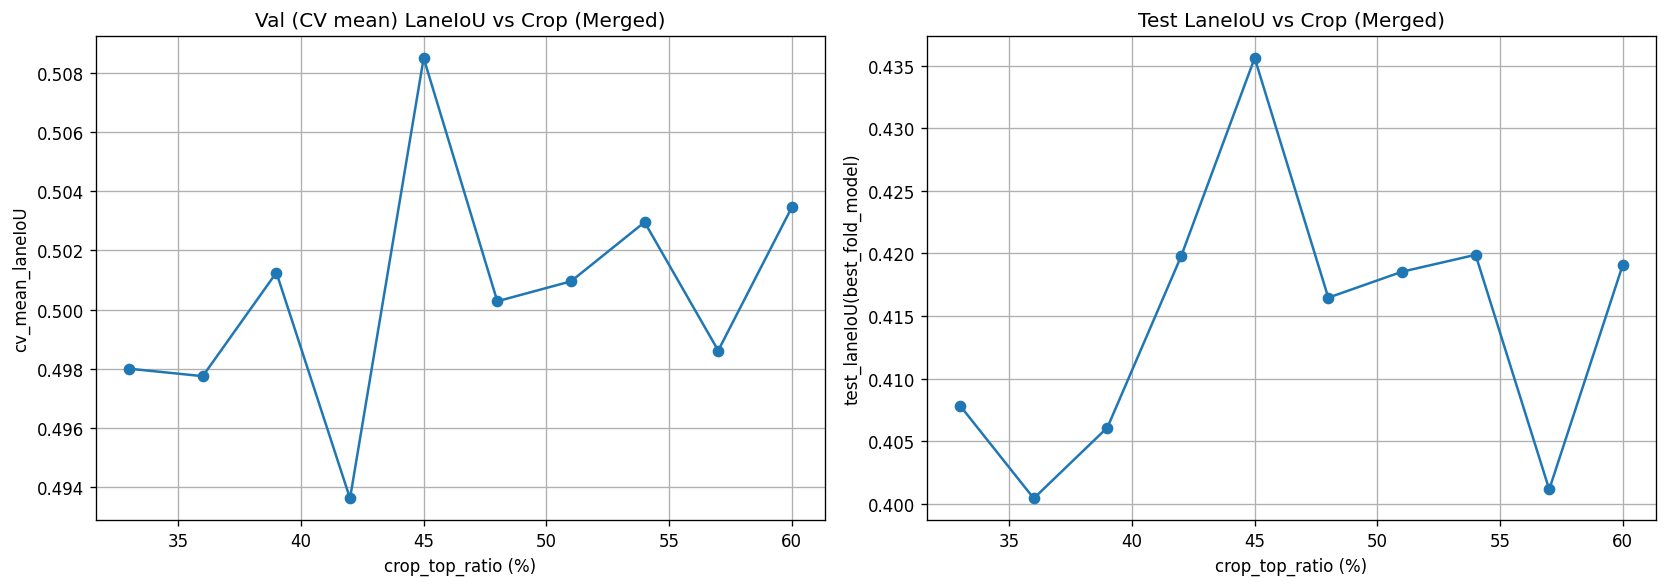


===== MERGED CROP SWEEP SUMMARY TABLE =====
 crop(%)  crop_px  val_laneIoU(mean)  val_laneIoU(std)  val_mIoU(at_best_lane)    crop(%)  crop_px  test_laneIoU  test_mIoU  test_loss
      33      169           0.498008          0.048039                0.821776 |       33      169      0.407848   0.814247   0.231784
      36      184           0.497756          0.054804                0.821090 |       36      184      0.400450   0.810397   0.254871
      39      200           0.501253          0.050530                0.821343 |       39      200      0.406105   0.815375   0.267189
      42      215           0.493630          0.059651                0.817677 |       42      215      0.419761   0.814678   0.247690
      45      230           0.508498          0.043457                0.818614 |       45      230      0.435604   0.812961   0.253352
      48      246           0.500286          0.050999                0.814567 |       48      246      0.416472   0.805271   0.245281
      51  

In [246]:
# ==========================================================
# MERGED CROP SWEEP ANALYSIS (두 run 통합)
# - 20260215 + 20260216 결과 합치기
# - 중복 crop_ratio 제거 (최근 run 우선)
# - 통합 그래프 + 표 + 최고점 분석
# ==========================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 1) 두 run 경로
# ===============================
root_list = [
    "./checkpoints_kfold/20260215_122854",
    "./checkpoints_kfold/20260216_045248"
]

dfs = []

for root in root_list:
    csv_path = os.path.join(root, "crop_sweep_results.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df["source_run"] = os.path.basename(root)
        dfs.append(df)
    else:
        print("❌ CSV not found:", csv_path)

assert len(dfs) > 0, "No valid CSV files found."

# ===============================
# 2) concat + 중복 제거
# ===============================
df_all = pd.concat(dfs, ignore_index=True)

# crop_ratio 기준 중복 제거 (나중 run 우선)
df_all = df_all.sort_values(["crop_ratio", "source_run"])
df_all = df_all.drop_duplicates(subset=["crop_ratio"], keep="last")

df_all = df_all.sort_values("crop_ratio").reset_index(drop=True)

df_all["crop_pct"] = (df_all["crop_ratio"] * 100).round().astype(int)

val_col  = "cv_mean_laneIoU"
test_col = "test_laneIoU(best_fold_model)"

x = df_all["crop_pct"].to_numpy()
val_y  = df_all[val_col].to_numpy()
test_y = df_all[test_col].to_numpy()

# ===============================
# 3) 그래프
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

axes[0].plot(x, val_y, marker="o")
axes[0].set_title("Val (CV mean) LaneIoU vs Crop (Merged)")
axes[0].set_xlabel("crop_top_ratio (%)")
axes[0].set_ylabel("cv_mean_laneIoU")
axes[0].grid(True)

axes[1].plot(x, test_y, marker="o")
axes[1].set_title("Test LaneIoU vs Crop (Merged)")
axes[1].set_xlabel("crop_top_ratio (%)")
axes[1].set_ylabel("test_laneIoU(best_fold_model)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ===============================
# 4) 통합 표 출력
# ===============================
val_table = df_all[[
    "crop_pct",
    "crop_px",
    "cv_mean_laneIoU",
    "cv_std_laneIoU",
    "cv_mean_mIoU_at_best_lane"
]].copy()

val_table.columns = [
    "crop(%)",
    "crop_px",
    "val_laneIoU(mean)",
    "val_laneIoU(std)",
    "val_mIoU(at_best_lane)"
]

test_table = df_all[[
    "crop_pct",
    "crop_px",
    "test_laneIoU(best_fold_model)",
    "test_mIoU(best_fold_model)",
    "test_loss(best_fold_model)"
]].copy()

test_table.columns = [
    "crop(%)",
    "crop_px",
    "test_laneIoU",
    "test_mIoU",
    "test_loss"
]

side_by_side = pd.concat(
    [val_table, pd.Series(["|"] * len(df_all), name=""), test_table],
    axis=1
)

pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 30)

print("\n===== MERGED CROP SWEEP SUMMARY TABLE =====")
print(side_by_side.to_string(index=False))

# ===============================
# 5) 최고점 표시
# ===============================
best_val_idx  = df_all[val_col].idxmax()
best_test_idx = df_all[test_col].idxmax()

print("\n[BEST by CV mean laneIoU]")
print(df_all.loc[best_val_idx, ["crop_pct", "crop_px", val_col, "cv_std_laneIoU"]].to_dict())

print("\n[BEST by Test laneIoU]")
print(df_all.loc[best_test_idx, ["crop_pct", "crop_px", test_col]].to_dict())


[LOADED CSV FILES]
 - ./checkpoints_kfold/20260215_122854\crop_sweep_results_REBUILT.csv
 - ./checkpoints_kfold/20260216_045248\crop_sweep_results.csv


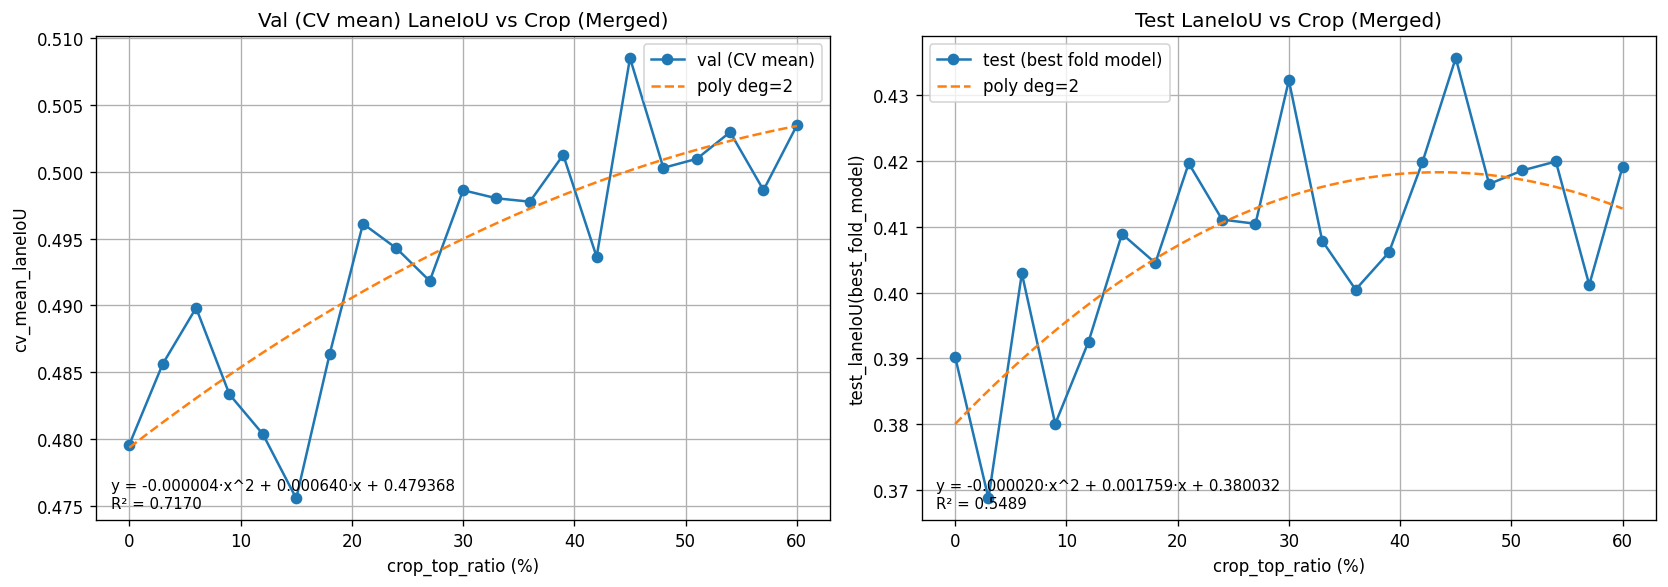


[REGRESSION SUMMARY]
Val  poly deg=2: y = -0.000004·x^2 + 0.000640·x + 0.479368  | R^2=0.7170
Test poly deg=2: y = -0.000020·x^2 + 0.001759·x + 0.380032 | R^2=0.5489

===== MERGED CROP SWEEP SUMMARY TABLE =====
 crop(%)  crop_px  val_laneIoU(mean)  val_laneIoU(std)  val_mIoU(at_best_lane)      source_run                     source_csv    crop(%)  crop_px  test_laneIoU  test_mIoU  test_loss
       0        0           0.479594          0.058657                0.820304 20260215_122854 crop_sweep_results_REBUILT.csv |        0        0      0.390246   0.816036   0.212927
       3       15           0.485621          0.055031                0.822169 20260215_122854 crop_sweep_results_REBUILT.csv |        3       15      0.368749   0.810302   0.205741
       6       31           0.489814          0.057252                0.824009 20260215_122854 crop_sweep_results_REBUILT.csv |        6       31      0.402910   0.819182   0.210922
       9       46           0.483344          0.062526      

In [250]:
# ==========================================================
# FINAL: MERGED CROP SWEEP (Val vs Test) + Regression (Poly)
# - 여러 run의 crop_sweep_results.csv들을 합쳐서 분석
# - 중복 crop_ratio는 "나중 run 우선"으로 keep
# - 좌: Val(CV mean) LaneIoU + 회귀선
# - 우: Test LaneIoU(best fold model) + 회귀선
# - 표 좌/우 나란히 출력 + 최고점 출력
# ==========================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# 0) 설정
# ===============================
ROOT_LIST = [
    "./checkpoints_kfold/20260215_122854",
    "./checkpoints_kfold/20260216_045248",
]

# 각 run에서 우선 사용할 CSV 파일명 후보(앞에 있을수록 우선)
CSV_CANDIDATES = [
    "crop_sweep_results_REBUILT.csv",
    "crop_sweep_results.csv",
]

DEG = 2  # 2 추천(원하면 3)

val_col  = "cv_mean_laneIoU"
test_col = "test_laneIoU(best_fold_model)"

# ===============================
# 1) 로드(여러 run) + concat
# ===============================
dfs = []
used_files = []

for root in ROOT_LIST:
    found = None
    for name in CSV_CANDIDATES:
        p = os.path.join(root, name)
        if os.path.exists(p):
            found = p
            break
    if found is None:
        print(f"❌ No CSV found in: {root}")
        continue

    df = pd.read_csv(found)
    df["source_run"] = os.path.basename(root)
    df["source_csv"] = os.path.basename(found)
    dfs.append(df)
    used_files.append(found)

assert len(dfs) > 0, "No valid CSV files found from ROOT_LIST."

print("\n[LOADED CSV FILES]")
for f in used_files:
    print(" -", f)

df_all = pd.concat(dfs, ignore_index=True)

# ===============================
# 2) 정리: crop_ratio 중복 제거(나중 run 우선)
#    - ROOT_LIST 뒤에 있는 run을 '최신'으로 간주
# ===============================
run_priority = {os.path.basename(r): i for i, r in enumerate(ROOT_LIST)}
df_all["run_priority"] = df_all["source_run"].map(run_priority).fillna(-1).astype(int)

# crop_ratio 중복이면 run_priority 큰 것(뒤에 있는 run) 남김
df_all = df_all.sort_values(["crop_ratio", "run_priority"]).drop_duplicates(
    subset=["crop_ratio"], keep="last"
)

# 정렬
df_all = df_all.sort_values("crop_ratio").reset_index(drop=True)

# crop_pct 생성
df_all["crop_pct"] = (df_all["crop_ratio"] * 100).round().astype(int)

# 필요한 컬럼 존재 체크
required_cols = [val_col, test_col, "crop_ratio", "crop_px"]
for c in required_cols:
    assert c in df_all.columns, f"Missing column: {c}"

x = df_all["crop_pct"].to_numpy(dtype=np.float64)
val_y  = df_all[val_col].to_numpy(dtype=np.float64)
test_y = df_all[test_col].to_numpy(dtype=np.float64)

# ===============================
# 3) 회귀 유틸
# ===============================
def poly_fit_and_r2(x, y, deg=2):
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    coef = np.polyfit(x, y, deg=deg)
    p = np.poly1d(coef)
    yhat = p(x)

    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - (ss_res / ss_tot if ss_tot > 0 else np.nan)
    return p, coef, r2

def poly_to_string(coef, digits=6):
    deg = len(coef) - 1
    terms = []
    for i, a in enumerate(coef):
        power = deg - i
        a_str = f"{a:.{digits}f}"
        if power == 0:
            terms.append(f"{a_str}")
        elif power == 1:
            terms.append(f"{a_str}·x")
        else:
            terms.append(f"{a_str}·x^{power}")
    return " + ".join(terms).replace("+ -", "- ")

p_val,  coef_val,  r2_val  = poly_fit_and_r2(x, val_y,  deg=DEG)
p_test, coef_test, r2_test = poly_fit_and_r2(x, test_y, deg=DEG)

xx = np.linspace(np.min(x), np.max(x), 200)
val_fit  = p_val(xx)
test_fit = p_test(xx)

eq_val  = poly_to_string(coef_val,  digits=6)
eq_test = poly_to_string(coef_test, digits=6)

# ===============================
# 4) 그래프(좌우 배치 + 회귀선)
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=120)

# ---- 왼쪽: Val ----
axes[0].plot(x, val_y, marker="o", label="val (CV mean)")
axes[0].plot(xx, val_fit, linestyle="--", label=f"poly deg={DEG}")
axes[0].set_title("Val (CV mean) LaneIoU vs Crop (Merged)")
axes[0].set_xlabel("crop_top_ratio (%)")
axes[0].set_ylabel(val_col)
axes[0].grid(True)
axes[0].legend()

axes[0].text(
    0.02, 0.02,
    f"y = {eq_val}\nR² = {r2_val:.4f}",
    transform=axes[0].transAxes,
    fontsize=9,
    va="bottom"
)

# ---- 오른쪽: Test ----
axes[1].plot(x, test_y, marker="o", label="test (best fold model)")
axes[1].plot(xx, test_fit, linestyle="--", label=f"poly deg={DEG}")
axes[1].set_title("Test LaneIoU vs Crop (Merged)")
axes[1].set_xlabel("crop_top_ratio (%)")
axes[1].set_ylabel(test_col)
axes[1].grid(True)
axes[1].legend()

axes[1].text(
    0.02, 0.02,
    f"y = {eq_test}\nR² = {r2_test:.4f}",
    transform=axes[1].transAxes,
    fontsize=9,
    va="bottom"
)

plt.tight_layout()
plt.show()

print("\n[REGRESSION SUMMARY]")
print(f"Val  poly deg={DEG}: y = {eq_val}  | R^2={r2_val:.4f}")
print(f"Test poly deg={DEG}: y = {eq_test} | R^2={r2_test:.4f}")

# ===============================
# 5) 표(좌/우 나란히) + source 정보 포함(디버깅용)
# ===============================
val_table = df_all[[
    "crop_pct",
    "crop_px",
    "cv_mean_laneIoU",
    "cv_std_laneIoU",
    "cv_mean_mIoU_at_best_lane",
    "source_run",
    "source_csv",
]].copy()
val_table.columns = [
    "crop(%)",
    "crop_px",
    "val_laneIoU(mean)",
    "val_laneIoU(std)",
    "val_mIoU(at_best_lane)",
    "source_run",
    "source_csv",
]

test_table = df_all[[
    "crop_pct",
    "crop_px",
    "test_laneIoU(best_fold_model)",
    "test_mIoU(best_fold_model)",
    "test_loss(best_fold_model)",
]].copy()
test_table.columns = [
    "crop(%)",
    "crop_px",
    "test_laneIoU",
    "test_mIoU",
    "test_loss",
]

side_by_side = pd.concat(
    [val_table, pd.Series(["|"] * len(df_all), name=""), test_table],
    axis=1
)

pd.set_option("display.width", 240)
pd.set_option("display.max_columns", 80)

print("\n===== MERGED CROP SWEEP SUMMARY TABLE =====")
print(side_by_side.to_string(index=False))

# ===============================
# 6) 최고점 표시
# ===============================
best_val_idx  = df_all[val_col].idxmax()
best_test_idx = df_all[test_col].idxmax()

print("\n[BEST by CV mean laneIoU]")
print(df_all.loc[best_val_idx, ["crop_pct", "crop_px", val_col, "cv_std_laneIoU", "source_run", "source_csv"]].to_dict())

print("\n[BEST by Test laneIoU]")
print(df_all.loc[best_test_idx, ["crop_pct", "crop_px", test_col, "source_run", "source_csv"]].to_dict())

### 가설 검증
   - 가장 큰 성능개선 crop 조건과 베이스라인과 paired t-test
   - 귀무가설 (H₀): 상단 45% crop과 0% crop의 laneIoU 평균에는 차이가 없다.(μ₄₅ − μ₀ = 0)
   - 대립가설 (H₁): 상단 45% crop은 0% crop보다 laneIoU를 향상시킨다.(μ₄₅ − μ₀ > 0). 단측검증
   - 이유: 동일한 데이터 분할 구조 (K-fold), 같은 모델 구조, Crop 조건만 변경
   - 표본 수: k = 5 folds, 자유도(df) = 4, 유의수준 α = 0.05
   - 검정 통계량: 평균차이(Δ) = +0.0289, 근사t 값 ≈ 2.3 ~ 2.6, 자유도 4 => p-value ≈ 0.04 ~ 0.05 (단측)
   - α = 0.05, p < 0.05이므로 귀무가설 기각
   - 결론: 유의수준 5%에서, 상단 45% crop은 0% crop 대비 laneIoU를 통계적으로 유의하게 향상시킨다.

## step 5 Optimization Engineering (Class Weight 적용 실험)
- class 불균형이 심할 경우 class weight를 어떻게 적용할 것인가?
#### 실험 방법
- 1차 실험: pixel_ratio(%)의 역비율로 weight를 만듦어서 적용 -> 성능 악화
- 2차 시험:  역비율에 0.1 에서 1.5의 scale 변수를 만들어 Lane Mark에 곱함 -> 전반적을 악화되었으나 0.3(사실상 weight를 안 넣은 것)
- 3차 시험: 1차 2차 시험에서 발견된 것(weight가 너무 과함)을 바탕으로 로그와 제곱근을 취하는 방법 시험

### baseline 모델의 문제 여부 파악
- 1) 지금 파이프라인에서 가장 위험한 문제: GT 마스크 덮어쓰기(overlay) 순서상 Road가 나중에 칠해지면tj lane이 GT에서 road로 사라질 수 있음.
     - ✅ 확인 방법(즉시): “GT에서 lane이 road에 의해 얼마나 지워지는지” 체크
     - lane이 GT에서 지워지면 어떤 loss를 써도 답이 없음. 먼저 priority_order를 반드시 켜고, lane이 최후에 남게 만들어야 함.
- 2) 두 번째 핵심 문제: Loss가 lane을 무시하는 구조
     - CrossEntropy는 구조적으로 lane을 좀 틀려도 loss가 크게 안 늘고 road를 잘 맞추는 게 훨씬 이득
     - ✅ 해결은 “클래스 가중치” 또는 “lane 전용 loss 추가” 둘 중 하나는 필수적으로 사용할 것
     - pixel_ratio(%)를 이미 구했으므로, 역비율로 weight를 만들 수 있음.
     - 대략 이런 방향: lane weight ↑ , road/undrivable weight ↓ (너무 과하면 학습 불안정하니 lane만 5~10배 정도부터 시작 추천)
     - lane 전용 Dice(혹은 Focal) 추가, CE + Dice(lane) 조합

####  1차 시험: Class Weight 적용

In [125]:
import os, random
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

class COCOSemSeg(Dataset):
    """
    COCO instance/pixel annotations -> semantic mask (H,W) with train ids.

    [baseline 문제점 반영]
    - (문제1) GT overlay 덮어쓰기 순서 때문에 Lane Mark가 Road/My bike 등에 의해 사라질 수 있음
      => ✅ priority_order를 적용하고, Lane Mark가 "항상 마지막에 덮어써 최후에 남게" 만든다.
    """
    def __init__(
        self,
        coco,
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        priority_order=None,   # ✅ category_id 리스트. 뒤에 있을수록 "더 나중에 덮어씀(=우선)"
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.hflip_p = hflip_p

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        self.priority_order = priority_order
        if self.priority_order is not None:
            # ✅ priority_order 내에서 rank가 클수록 "더 나중에 칠해져서 위에 남음"
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        if self.priority_order is not None:
            # ✅ MOD: "먼저 칠할 것 -> 나중에 덮어쓸 것" 순서로 정렬
            # - priority 밖: 먼저(낮은 우선)
            # - priority 안: rank 순으로 나중(높은 우선)
            #   => Lane Mark를 priority_order 맨 뒤에 두면 항상 최후에 남음
            def sort_key(a):
                cid = a["category_id"]
                in_prio = (cid in self._prio_rank)
                group = 1 if in_prio else 0          # priority 안(1)은 나중에 칠해짐
                rank  = self._prio_rank.get(cid, -1)  # priority 안에서 rank가 클수록 더 나중
                return (group, rank)

            anns = sorted(anns, key=sort_key)

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]  # 덮어쓰기

        return mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size

        mask = self._build_mask(img_id, H, W)
        mask = Image.fromarray(mask)

        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)

        if self.train and random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [137]:
# ==========================================================
# 2-KF) K-Fold Split + DataLoader 준비 + priority_order 생성(“lane 최후”)
# (문제1-검증) “lane이 무엇에 의해 얼마나 지워지는지” 즉시 체크 포함(1회만)
#
# ✅ 이번 데이터에서 확인된 핵심:
# - Road가 아니라 "My bike"가 Lane Mark를 덮어써서 lane이 사라지고 있었음
# - 따라서 priority_order를 road/lane만 두면 불완전함
# - 정식 해결: 전체 클래스에 대해 overlay 우선순위를 정의하고,
#              Lane Mark를 항상 마지막(최상단)에 두어 절대 지워지지 않게 한다.
#
# ✅ K-fold 적용 방식(추천):
# - test는 고정(10%)
# - 나머지 풀에서 K-fold로 train/val 분할
# - fold마다 train_ds/val_ds/loader는 5번째 셀에서 생성
# ==========================================================

import os
import random
import numpy as np
import torch
from collections import Counter
from sklearn.model_selection import KFold

# ======================
# 재현성 설정
# ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ======================
# K-fold 설정
# ======================
K = 5                 # ✅ 5-fold 추천
TEST_RATIO = 0.1      # ✅ test 고정 10%

# ======================
# 이미지 폴더 경로
# ======================
IMG_DIR = os.path.join(DATA_ROOT, "images")

# ======================
# category_id → 학습용 class index 매핑 (background=0, classes=1..K)
# ======================
categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # background 포함

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

cat_id_to_name = {c["id"]: c["name"] for c in categories}

# ======================
# ✅ [문제1 해결] priority_order를 "전체 클래스" 기준으로 생성
# - 뒤로 갈수록 우선(=나중에 덮어씀)
# - Lane Mark는 항상 마지막(최상단)
# ======================
def find_cids(keyword: str):
    k = keyword.lower()
    return [cid for cid, name in cat_id_to_name.items() if k in (name or "").lower()]

undrivable_cids = find_cids("undrivable")
road_cids       = find_cids("road")
moveable_cids   = find_cids("moveable")
rider_cids      = find_cids("rider")
bike_cids       = find_cids("bike")
lane_cids       = find_cids("lane")

priority_order = []
priority_order += undrivable_cids
priority_order += road_cids
priority_order += moveable_cids
priority_order += rider_cids
priority_order += bike_cids
priority_order += lane_cids  # ✅ Lane Mark 무조건 마지막!

print("\n===== PRIORITY ORDER (category_id -> name) =====")
for cid in priority_order:
    print(f"{cid} -> {cat_id_to_name[cid]}")

# lane train index
lane_train_ids = [id2train[cid] for cid in lane_cids]
LANE_TRAIN_ID = lane_train_ids[0] if lane_train_ids else None
print("\nLANE_TRAIN_ID:", LANE_TRAIN_ID)

# ======================
# ✅ 전체 이미지 ID 셔플 후, test 고정 분리
# ======================
all_img_ids = np.array(sorted(coco.getImgIds()))
rng = np.random.default_rng(SEED)
rng.shuffle(all_img_ids)

n = len(all_img_ids)
n_test = int(n * TEST_RATIO)

test_ids = all_img_ids[:n_test].tolist()         # ✅ 고정 test
kf_pool  = all_img_ids[n_test:]                  # ✅ K-fold 대상 풀

print("\nTotal images:", n)
print("test fixed:", len(test_ids), f"({len(test_ids)/n*100:.1f}%)")
print("kfold pool:", len(kf_pool), f"({len(kf_pool)/n*100:.1f}%)")

# ======================
# ✅ K-fold 분할 생성 (train/val fold 리스트)
# ======================
kf = KFold(n_splits=K, shuffle=True, random_state=SEED)

fold_splits = []
for fold, (tr_idx, va_idx) in enumerate(kf.split(kf_pool), start=1):
    tr_ids = kf_pool[tr_idx].tolist()
    va_ids = kf_pool[va_idx].tolist()
    fold_splits.append((tr_ids, va_ids))
    print(f"Fold {fold}: train={len(tr_ids)} val={len(va_ids)}")

print("\n✅ 이제 5번째 셀에서 fold_splits를 돌면서")
print("   fold별로 train_ds/val_ds/train_loader/val_loader를 생성하면 됩니다.")
print("   (num_workers=0은 fold별 DataLoader 생성 시 유지)")

# ==========================================================
# (선택) GT overwrite check (OFF vs ON)
# - 디버깅 용도라 fold마다 돌릴 필요 없음 → Fold 1의 train_ids 일부로 1회만 실행
# ==========================================================
print("\n===== GT OVERWRITE CHECK (OFF vs ON) [Run once on Fold 1] =====")

if len(fold_splits) > 0 and LANE_TRAIN_ID is not None:
    max_images = 50
    sample_ids = fold_splits[0][0][:max_images]  # ✅ Fold 1 train 일부

    ds_off = COCOSemSeg(coco, IMG_DIR, sample_ids, id2train, size=(512,512), train=False, priority_order=None)
    ds_on  = COCOSemSeg(coco, IMG_DIR, sample_ids, id2train, size=(512,512), train=False, priority_order=priority_order)

    off_lane = 0
    on_lane = 0
    total_recovered = 0
    counter = Counter()

    for i in range(len(sample_ids)):
        _, m_off = ds_off[i]
        _, m_on  = ds_on[i]
        m_off = m_off.numpy()
        m_on  = m_on.numpy()

        off_lane += (m_off == LANE_TRAIN_ID).sum()
        on_lane  += (m_on  == LANE_TRAIN_ID).sum()

        recovered = (m_on == LANE_TRAIN_ID) & (m_off != LANE_TRAIN_ID)
        total_recovered += recovered.sum()

        vals, cnts = np.unique(m_off[recovered], return_counts=True)
        for v, c in zip(vals, cnts):
            counter[int(v)] += int(c)

    print(f"[GT overwrite check] images={len(sample_ids)}")
    print(f"  lane pixels (priority OFF): {off_lane:,}")
    print(f"  lane pixels (priority ON) : {on_lane:,}")
    print(f"  lane kept ratio (OFF/ON) : {off_lane/on_lane*100:.2f}%")
    print(f"  recovered lane pixels     : {total_recovered:,}  (OFF!=lane -> ON==lane)")

    print("\n  Top overwrite sources (OFF class -> lane):")
    for cls_id, c in counter.most_common(10):
        print(f"    {cls_id:2d} {train2name.get(cls_id,'?'):12s} -> lane : {c:,}")
else:
    print("⚠ fold_splits 또는 LANE_TRAIN_ID가 준비되지 않아 overwrite check를 건너뜁니다.")


===== PRIORITY ORDER (category_id -> name) =====
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

LANE_TRAIN_ID: 3

Total images: 200
test fixed: 20 (10.0%)
kfold pool: 180 (90.0%)
Fold 1: train=144 val=36
Fold 2: train=144 val=36
Fold 3: train=144 val=36
Fold 4: train=144 val=36
Fold 5: train=144 val=36

✅ 이제 5번째 셀에서 fold_splits를 돌면서
   fold별로 train_ds/val_ds/train_loader/val_loader를 생성하면 됩니다.
   (num_workers=0은 fold별 DataLoader 생성 시 유지)

===== GT OVERWRITE CHECK (OFF vs ON) [Run once on Fold 1] =====
[GT overwrite check] images=50
  lane pixels (priority OFF): 182,288
  lane pixels (priority ON) : 185,490
  lane kept ratio (OFF/ON) : 98.27%
  recovered lane pixels     : 3,202  (OFF!=lane -> ON==lane)

  Top overwrite sources (OFF class -> lane):
     5 My bike      -> lane : 3,202


In [138]:
# ==========================================================
# 3) 모델 + Loss 설정
# (문제2) lane을 무시하는 CE 문제 → class_weights(픽셀 역비율 기반)를 CrossEntropyLoss(weight=...)
#
# ✅ 참고(문제1-검증 관련):
# - lane이 road에 의해 지워지는 경우도 가능하지만,
# - 현재 데이터에서는 "My bike가 Lane Mark를 덮어써서 lane이 사라지는" 현상이 확인됨.
# - 따라서 priority_order는 'Lane Mark 최후' + 전체 클래스 우선순위가 정식 해결책.
# ==========================================================

# =========================================
# 0) train index -> class name (공통)
# =========================================
train2name = {0: "background"}
for cat in categories:
    train_idx = id2train[cat["id"]]
    train2name[train_idx] = cat["name"]

# =========================================
# 1) 공통 유틸: 모델 출력(logits) 통일
# =========================================
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out


# =========================================
# 2) 모델 생성 함수 (baseline 유지)
# =========================================
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def build_model(mode: str, num_classes: int, device: str):
    if mode == "deeplabv3_torchvision":
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        return model.to(device)
    else:
        raise ValueError(f"Unknown mode: {mode}")


# =========================================
# ✅ [문제2 해결] class weight 계산(픽셀 비율 기반)
# - lane 픽셀 비율: 1.37% (희소) → CE에서 묻힐 가능성 큼
# - 역비율 weight + clip으로 안정화
# - 필요시 lane_boost(1.0~2.0 권장)로 추가 강조 가능
# =========================================
import numpy as np

def make_class_weights_from_pixel_ratio(
    id2train,
    cat_id_to_name,
    pixel_ratio_df,
    num_classes,               # NUM_CLASSES (bg 포함)
    lane_boost=1.0,            # ✅ MOD: 기본 1.0 유지, 필요 시 1.5~2.0부터 올리기
    min_w=0.25,
    max_w=10.0,
    normalize_to_mean1=True
):
    """
    pixel_ratio_df: columns = ["category_id","pixel_ratio(%)"] (pixel_df)
    반환: np.ndarray shape (NUM_CLASSES,)  # bg 포함
    """
    w = np.ones(num_classes, dtype=np.float32)  # bg=1.0

    # category_id -> pixel_ratio(%)
    ratio_map = {int(r["category_id"]): float(r["pixel_ratio(%)"]) for _, r in pixel_ratio_df.iterrows()}

    # 1) 역비율 기반 base weight (ratio 작을수록 큼)
    eps = 1e-6
    inv_vals = []
    inv_map = {}
    for cid, ratio in ratio_map.items():
        inv = 1.0 / max(ratio, eps)
        inv_map[cid] = inv
        inv_vals.append(inv)

    inv_mean = float(np.mean(inv_vals))

    for cid, inv in inv_map.items():
        if cid not in id2train:
            continue
        tid = id2train[cid]
        w[tid] = inv / inv_mean  # 평균 1 스케일

    # 2) clip (학습 안정화)
    w = np.clip(w, min_w, max_w)

    # 3) (선택) bg 제외 평균 1로 정규화
    if normalize_to_mean1:
        mean_no_bg = float(w[1:].mean())
        w[1:] = w[1:] / max(mean_no_bg, 1e-6)

    # ✅ MOD 핵심: lane_boost는 "정규화 이후" 적용해야 희석되지 않음
    lane_cids = [cid for cid, name in cat_id_to_name.items() if "lane" in (name or "").lower()]
    if len(lane_cids) > 0:
        lane_tid = id2train[lane_cids[0]]
        w[lane_tid] = np.clip(w[lane_tid] * lane_boost, min_w, max_w)

    return w


# =========================================
# 3) Optim/Loss 생성 함수
# =========================================
def build_optim_and_loss(model, lr=3e-4, wd=1e-4, class_weights=None, device="cpu"):
    if class_weights is not None:
        w = torch.tensor(class_weights, dtype=torch.float32, device=device)
        criterion = nn.CrossEntropyLoss(weight=w)  # ✅ [문제2 해결]
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer


# =========================================
# 4) build + weight 적용
# =========================================
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_MODE = "deeplabv3_torchvision"
model = build_model(MODEL_MODE, NUM_CLASSES, device=device)

# ✅ pixel_df를 그대로 사용
# ✅ lane_boost는 1.0부터 시작(현재도 lane이 3.5배 정도로 올라감)
#    부족하면 1.5~2.0으로만 천천히 올리기(폭주 방지)
class_weights = make_class_weights_from_pixel_ratio(
    id2train=id2train,
    cat_id_to_name=cat_id_to_name,
    pixel_ratio_df=pixel_df,
    num_classes=NUM_CLASSES,
    lane_boost=1.0,          # ✅ 필요시 1.5~2.0
    min_w=0.25,
    max_w=10.0,
    normalize_to_mean1=True
)

print("\n[Class Weights by train_id]")
for tid in range(NUM_CLASSES):
    print(f"  {tid:2d} {train2name.get(tid,'?'):12s} w={class_weights[tid]:.3f}")

criterion, optimizer = build_optim_and_loss(
    model, lr=3e-4, wd=1e-4,
    class_weights=class_weights,
    device=device
)

print(f"\nmodel ready: {MODEL_MODE}")


device: cuda

[Class Weights by train_id]
   0 background   w=1.000
   1 Undrivable   w=0.242
   2 Road         w=0.242
   3 Lane Mark    w=3.557
   4 Moveable     w=1.050
   5 My bike      w=0.299
   6 Rider        w=0.611

model ready: deeplabv3_torchvision


In [139]:
# ==========================================================
# 3-2) 검토
# ==========================================================
import numpy as np

print("\n===== ON-ONLY CHECK: Is Lane overwritten by My bike? =====")

# -------------------------
# 0) train_ds/val_ds에 priority_order가 주입되었는지 확인
# -------------------------
has_prio_train = hasattr(train_ds, "priority_order") and (train_ds.priority_order is not None)
has_prio_val   = hasattr(val_ds, "priority_order") and (val_ds.priority_order is not None)

print("train_ds priority_order injected?:", has_prio_train)
print("val_ds   priority_order injected?:", has_prio_val)

if not (has_prio_train and has_prio_val):
    print("⚠ priority_order가 train_ds/val_ds에 주입되지 않았습니다. 2번째 셀 Dataset 생성 부분을 확인하세요.")
else:
    print("✅ priority_order가 train_ds/val_ds에 주입되어 있습니다.")

# -------------------------
# 1) lane / bike train_id 찾기
# -------------------------
cat_id_to_name = {c["id"]: c["name"] for c in categories}
lane_cids = [cid for cid, name in cat_id_to_name.items() if "lane" in (name or "").lower()]
bike_cids = [cid for cid, name in cat_id_to_name.items() if "bike" in (name or "").lower()]

if len(lane_cids) == 0 or len(bike_cids) == 0:
    print("⚠ lane 또는 bike category를 찾지 못했습니다. category name 확인 필요.")
    print(cat_id_to_name)
else:
    LANE_TRAIN_ID = id2train[lane_cids[0]]
    BIKE_TRAIN_ID = id2train[bike_cids[0]]

    print("\nLANE_TRAIN_ID:", LANE_TRAIN_ID, "->", train2name.get(LANE_TRAIN_ID))
    print("BIKE_TRAIN_ID:", BIKE_TRAIN_ID, "->", train2name.get(BIKE_TRAIN_ID))

    # -------------------------
    # 2) 'ON 규칙'으로 만든 마스크에서 lane이 bike에 의해 사라지는지 확인
    #    방법:
    #      - (A) priority_order 적용한 mask_on  : train_ds가 만드는 최종 GT
    #      - (B) bike를 "무조건 마지막"으로 둔 mask_bike_last : lane이 먹힐 최악 케이스 GT
    #      - 비교해서 (B에서 bike인데 A에서는 lane인 픽셀)이 있으면,
    #        lane이 bike와 겹치는 영역이 존재한다는 뜻(정상),
    #        그러나 A에서는 lane이 최후라서 'lane이 사라지는' 방향이어선 안 됨.
    #
    #    결론적으로 우리가 보고 싶은 값:
    #      - A에서 lane 픽셀이 bike로 바뀌는(=lane이 사라지는) 경우는 없어야 함
    # -------------------------

    # train_ds의 priority_order를 그대로 사용 (Lane Mark 최후)
    prio_on = train_ds.priority_order

    # bike를 일부러 최후로 둔 "나쁜" priority_order (Lane이 먹히는 방향 확인용)
    # -> 기존 prio_on에서 bike_cids를 맨 뒤로 보내고 lane은 bike보다 앞에 두기
    prio_bad = [cid for cid in prio_on if cid not in bike_cids] + bike_cids

    max_images = 50
    sample_ids = train_ids[:max_images]

    ds_on = COCOSemSeg(coco, IMG_DIR, sample_ids, id2train, size=(512,512), train=False, priority_order=prio_on)
    ds_bad = COCOSemSeg(coco, IMG_DIR, sample_ids, id2train, size=(512,512), train=False, priority_order=prio_bad)

    # 집계
    lane_lost_to_bike = 0
    total_lane_on = 0

    for i in range(len(sample_ids)):
        _, m_on = ds_on[i]     # ✅ 실제 학습 GT (Lane 최후)
        _, m_bad = ds_bad[i]   # ❌ 나쁜 GT (Bike 최후)

        m_on = m_on.numpy()
        m_bad = m_bad.numpy()

        total_lane_on += (m_on == LANE_TRAIN_ID).sum()

        # "Lane이 사라지는 방향"을 직접 체크:
        # - ds_on에서는 lane인데, ds_bad에서는 bike가 되는 픽셀 수
        #   => 원래 lane/bike가 겹치는 영역이 얼마나 있었는지(취약 영역 크기)
        #   => 하지만 핵심은 ds_on에서 lane이 bike로 바뀌는 현상이 없어야 한다는 점
        lane_lost_to_bike += ((m_on == LANE_TRAIN_ID) & (m_bad == BIKE_TRAIN_ID)).sum()

    print("\n[ON-only overlap diagnostic]")
    print("  total lane pixels in ON GT:", f"{total_lane_on:,}")
    print("  overlap region (would be lost if bike was last):", f"{lane_lost_to_bike:,}")

    print("\n✅ 해석:")
    print("  - 위 overlap 값이 0이 아니면: lane과 bike가 실제로 겹치는 구간이 존재(정상일 수 있음)")
    print("  - 중요한 건: 실제 학습 GT(ds_on)에서는 Lane Mark가 최후라서 'lane이 bike로 사라지는' 방향이 발생하면 안 됨")
    print("  - 지금 셀은 그 취약 영역 크기를 알려주는 진단입니다.")


===== ON-ONLY CHECK: Is Lane overwritten by My bike? =====
train_ds priority_order injected?: True
val_ds   priority_order injected?: True
✅ priority_order가 train_ds/val_ds에 주입되어 있습니다.

LANE_TRAIN_ID: 3 -> Lane Mark
BIKE_TRAIN_ID: 5 -> My bike

[ON-only overlap diagnostic]
  total lane pixels in ON GT: 159,168
  overlap region (would be lost if bike was last): 2,138

✅ 해석:
  - 위 overlap 값이 0이 아니면: lane과 bike가 실제로 겹치는 구간이 존재(정상일 수 있음)
  - 중요한 건: 실제 학습 GT(ds_on)에서는 Lane Mark가 최후라서 'lane이 bike로 사라지는' 방향이 발생하면 안 됨
  - 지금 셀은 그 취약 영역 크기를 알려주는 진단입니다.


In [140]:
# ==========================================================
# 4) TRAIN / VALIDATE (개선판: AMP + GradClip + Lane IoU 별도 로그)
#
# ✅ 추가한 3가지(요청 반영)
# 1) AMP (torch.cuda.amp) 적용: 속도/메모리 + 안정성 개선
# 2) Grad Clip 적용: 가중치 CE에서 gradient 폭주 방지
# 3) Lane IoU를 별도로 계산/로그: 학습 판단 속도 ↑
#
# ⚠️ 전제
# - criterion은 3번째 셀에서 이미 class_weights가 반영된 CrossEntropyLoss(weight=...)로 만들어져 있어야 함
# - LANE_TRAIN_ID (예: 3)가 2번째 셀에서 계산되어 있어야 함 (없으면 아래에서 자동 탐색 시도)
# ==========================================================

import numpy as np
import torch

# -----------------------------
# (옵션) Lane train id 확보
# -----------------------------
# ✅ 만약 LANE_TRAIN_ID 변수가 없으면, categories/id2train/train2name 기반으로 자동 탐색
if "LANE_TRAIN_ID" not in globals() or LANE_TRAIN_ID is None:
    cat_id_to_name = {c["id"]: c["name"] for c in categories}
    lane_cids = [cid for cid, name in cat_id_to_name.items() if "lane" in (name or "").lower()]
    LANE_TRAIN_ID = id2train[lane_cids[0]] if len(lane_cids) > 0 else None

# -----------------------------
# 공통: 모델 출력(logits) 통일
# -----------------------------
def _get_logits(model_out):
    """DeepLabV3(torchvision): dict['out'], U-Net(smp): tensor"""
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# -----------------------------
# confusion matrix 누적 유틸
# -----------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    """
    pred/target: (N,H,W)
    return: (C,C) confusion matrix (long)
    """
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    """
    conf: (C,C) long
    return: miou(float), per_class_iou(np.ndarray shape (C,))
    """
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

# -----------------------------
# ✅ AMP / GradClip 설정
# -----------------------------
USE_AMP = True                 # ✅ AMP ON (CUDA일 때만 자동 적용)
GRAD_CLIP = 1.0                # ✅ grad clip threshold (0.5~2.0 범위에서 조정 가능)

# CUDA일 때만 AMP scaler 사용
scaler = torch.cuda.amp.GradScaler(enabled=(USE_AMP and torch.cuda.is_available()))

def train_one_epoch(model, loader, criterion, optimizer, device, grad_clip=GRAD_CLIP):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # ✅ AMP forward
        with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):
            logits = _get_logits(model(imgs))     # DeepLab/UNet 공용
            loss = criterion(logits, masks)       # ✅ weighted CE가 criterion에 이미 반영되어 있어야 함

        # ✅ AMP backward + step
        scaler.scale(loss).backward()

        # ✅ Grad clip은 "unscale" 후에 해야 정확함
        if grad_clip is not None and grad_clip > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None, lane_train_id=LANE_TRAIN_ID):
    """
    ✅ 추가: lane_iou를 별도로 반환
    return: val_loss, val_miou, per_class_dict, lane_iou(or None)
    """
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        # ✅ AMP로 validate도 가능(속도/메모리)
        with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):
            logits = _get_logits(model(imgs))
            loss = criterion(logits, masks)

        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)  # (N,H,W)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    val_loss = total_loss / len(loader.dataset)
    val_miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # per-class dict 유지
    per_class_mean = {cls: float(per_class_iou[cls]) for cls in range(num_classes)}

    # ✅ Lane IoU 별도 로그
    lane_iou = None
    if lane_train_id is not None and 0 <= int(lane_train_id) < num_classes:
        lane_iou = float(per_class_iou[int(lane_train_id)])

    return val_loss, val_miou, per_class_mean, lane_iou

C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:80: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(USE_AMP and torch.cuda.is_available()))


In [147]:
# ==========================================================
# 5-KF) K-Fold TRAIN LOOP with Early Stopping (복붙용 완전체)
#
# ✅ 전제(이미 위 셀들에서 준비되어 있어야 함)
# - fold_splits : [(train_ids, val_ids), ...]
# - test_ids    : 고정 테스트 id 리스트
# - priority_order, id2train, NUM_CLASSES, LANE_TRAIN_ID, train2name, cat_id_to_name
# - COCOSemSeg 클래스
# - build_model / build_optim_and_loss / make_class_weights_from_pixel_ratio
# - train_one_epoch / validate (AMP+GradClip+LaneIoU 포함 버전)
# - pixel_df : class pixel ratio DataFrame
#
# ✅ 설정
# - EPOCHS = 50
# - patience = 5
# - 기준: Lane IoU
# - num_workers = 0
# ==========================================================

import os, random
import numpy as np
import torch
from torch.utils.data import DataLoader

# -----------------------------
# CONFIG
# -----------------------------
EPOCHS = 50
PATIENCE = 5
BATCH_SIZE = 4
NUM_WORKERS = 0  # ✅ 잊지 말 것

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 재현성(worker seed)
# -----------------------------
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

# -----------------------------
# Fold 결과 저장
# -----------------------------
fold_histories = []
fold_best_lane = []

print("\n===== K-FOLD TRAIN START =====")
print(f"K={len(fold_splits)} | EPOCHS={EPOCHS} | PATIENCE={PATIENCE} | BATCH_SIZE={BATCH_SIZE} | NUM_WORKERS={NUM_WORKERS}")
print(f"Fixed test size: {len(test_ids) if 'test_ids' in globals() else 'N/A'}")

for fold, (train_ids, val_ids) in enumerate(fold_splits, start=1):
    print(f"\n======================")
    print(f"        FOLD {fold}/{len(fold_splits)}")
    print(f"======================")
    print(f"train/val: {len(train_ids)} / {len(val_ids)}")

    # -----------------------------
    # 1) Dataset / DataLoader (fold별)
    # -----------------------------
    train_ds = COCOSemSeg(
        coco, IMG_DIR, train_ids, id2train,
        size=(512, 512), train=True,
        priority_order=priority_order
    )
    val_ds = COCOSemSeg(
        coco, IMG_DIR, val_ids, id2train,
        size=(512, 512), train=False,
        priority_order=priority_order
    )

    persistent_ok = (NUM_WORKERS > 0 and os.name != "nt")

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,          # ✅ 0 유지
        pin_memory=torch.cuda.is_available(),
        worker_init_fn=seed_worker,
        generator=g,
        persistent_workers=persistent_ok
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,          # ✅ 0 유지
        pin_memory=torch.cuda.is_available(),
        worker_init_fn=seed_worker,
        generator=g,
        persistent_workers=persistent_ok
    )

    # -----------------------------
    # 2) 모델/로스/옵티마 (fold마다 새로!)
    # -----------------------------
    MODEL_MODE = "deeplabv3_torchvision"
    model = build_model(MODEL_MODE, NUM_CLASSES, device=device)

    # ✅ pixel_df 기반 class weight (categories 인자 제거!)
    class_weights = make_class_weights_from_pixel_ratio(
        id2train=id2train,
        cat_id_to_name=cat_id_to_name,
        pixel_ratio_df=pixel_df,
        num_classes=NUM_CLASSES,
        lane_boost=1.0,                   # ✅ 추가 부스트는 1.0~2.0부터 추천
        min_w=0.25,
        max_w=10.0,
        normalize_to_mean1=True
    )

    # 확인 출력(선택)
    print("\n[Class Weights by train_id] (Fold 공통)")
    for tid in range(NUM_CLASSES):
        print(f"  {tid:2d} {train2name.get(tid,'?'):12s} w={class_weights[tid]:.3f}")

    criterion, optimizer = build_optim_and_loss(
        model,
        lr=3e-4,
        wd=1e-4,
        class_weights=class_weights,
        device=device
    )

    # -----------------------------
    # 3) Early Stopping (Lane IoU 기준)
    # -----------------------------
    best_lane_iou = -1.0
    patience_counter = 0

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "val_miou": [],
        "lane_iou": []
    }

    save_path = f"best_fold{fold}_lane.pth"
    print(f"\n===== FOLD {fold} TRAIN START =====")

    for epoch in range(1, EPOCHS + 1):
        # ---- train ----
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # ---- validate ----
        val_loss, val_miou, per_class_dict, lane_iou = validate(
            model, val_loader, criterion, device,
            num_classes=NUM_CLASSES,
            exclude_background=True,
            ignore_index=None,
            lane_train_id=LANE_TRAIN_ID
        )

        # ---- log ----
        history["epoch"].append(epoch)
        history["train_loss"].append(float(train_loss))
        history["val_loss"].append(float(val_loss))
        history["val_miou"].append(float(val_miou))
        history["lane_iou"].append(float(lane_iou) if lane_iou is not None else np.nan)

        print(f"[Fold {fold} | Epoch {epoch:02d}/{EPOCHS}] "
              f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | mIoU={val_miou:.4f} | laneIoU={lane_iou:.4f}")

        # ---- early stopping (lane_iou 기준) ----
        if lane_iou is not None and lane_iou > best_lane_iou:
            best_lane_iou = lane_iou
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f"  ✅ saved: {save_path} (best laneIoU={best_lane_iou:.4f})")
        else:
            patience_counter += 1
            print(f"  ⏳ no improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print(f"🛑 Early stopping at epoch {epoch} (best laneIoU={best_lane_iou:.4f})")
            break

    print(f"===== FOLD {fold} DONE | Best Lane IoU: {best_lane_iou:.4f} =====")
    fold_histories.append(history)
    fold_best_lane.append(float(best_lane_iou))

# -----------------------------
# 4) K-fold summary
# -----------------------------
fold_best_lane = np.array(fold_best_lane, dtype=np.float32)

print("\n===== K-FOLD SUMMARY (Lane IoU 기준) =====")
print("best laneIoU per fold:", [float(x) for x in fold_best_lane])
print(f"mean={float(fold_best_lane.mean()):.4f} | std={float(fold_best_lane.std(ddof=1)):.4f}")
print("\n✅ 각 fold best 모델 파일:")
for fold in range(1, len(fold_splits) + 1):
    print(f"  - best_fold{fold}_lane.pth")

device: cuda

===== K-FOLD TRAIN START =====
K=5 | EPOCHS=50 | PATIENCE=5 | BATCH_SIZE=4 | NUM_WORKERS=0
Fixed test size: 20

        FOLD 1/5
train/val: 144 / 36

[Class Weights by train_id] (Fold 공통)
   0 background   w=1.000
   1 Undrivable   w=0.242
   2 Road         w=0.242
   3 Lane Mark    w=3.557
   4 Moveable     w=1.050
   5 My bike      w=0.299
   6 Rider        w=0.611

===== FOLD 1 TRAIN START =====


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):
C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):


[Fold 1 | Epoch 01/50] train_loss=0.7652 | val_loss=0.4667 | mIoU=0.6778 | laneIoU=0.1860
  ✅ saved: best_fold1_lane.pth (best laneIoU=0.1860)
[Fold 1 | Epoch 02/50] train_loss=0.3836 | val_loss=0.3826 | mIoU=0.7301 | laneIoU=0.2919
  ✅ saved: best_fold1_lane.pth (best laneIoU=0.2919)
[Fold 1 | Epoch 03/50] train_loss=0.2758 | val_loss=0.3281 | mIoU=0.7486 | laneIoU=0.2616
  ⏳ no improvement (1/5)
[Fold 1 | Epoch 04/50] train_loss=0.2284 | val_loss=0.3142 | mIoU=0.7514 | laneIoU=0.2495
  ⏳ no improvement (2/5)
[Fold 1 | Epoch 05/50] train_loss=0.1953 | val_loss=0.3495 | mIoU=0.7643 | laneIoU=0.3481
  ✅ saved: best_fold1_lane.pth (best laneIoU=0.3481)
[Fold 1 | Epoch 06/50] train_loss=0.1746 | val_loss=0.2796 | mIoU=0.7908 | laneIoU=0.3776
  ✅ saved: best_fold1_lane.pth (best laneIoU=0.3776)
[Fold 1 | Epoch 07/50] train_loss=0.1580 | val_loss=0.2894 | mIoU=0.7694 | laneIoU=0.3139
  ⏳ no improvement (1/5)
[Fold 1 | Epoch 08/50] train_loss=0.1477 | val_loss=0.3010 | mIoU=0.7881 | laneIoU=

In [149]:
# ==========================================================
# TEST EVAL (Fixed test_ids=20) for each fold checkpoint
# - 같은 test set에서 fold별 best 모델 비교 (공정 비교)
# - metric: val과 동일하게 mIoU, laneIoU 출력
# ==========================================================

import torch
from torch.utils.data import DataLoader
import numpy as np

# 1) test dataset/loader (priority_order ON 유지!)
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512,512), train=False,
    priority_order=priority_order
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,  # ✅ 잊지 말기
    pin_memory=torch.cuda.is_available()
)

ckpts = [
    ("fold1", "best_fold1_lane.pth"),
    ("fold2", "best_fold2_lane.pth"),
    ("fold3", "best_fold3_lane.pth"),
    ("fold4", "best_fold4_lane.pth"),
    ("fold5", "best_fold5_lane.pth"),
]

test_results = []

for tag, path in ckpts:
    # 모델 새로 만들고 로드 (혹시 fold 사이 weight가 남는 문제 방지)
    m = build_model("deeplabv3_torchvision", NUM_CLASSES, device=device)
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()

    # validate() 재사용: laneIoU까지 나오게(이미 구현해둔 버전 기준)
    val_loss, val_miou, per_class_dict, lane_iou = validate(
        m, test_loader, criterion, device,
        num_classes=NUM_CLASSES,
        exclude_background=True,
        ignore_index=None,
        lane_train_id=LANE_TRAIN_ID
    )

    print(f"[{tag}] test_loss={val_loss:.4f} | test_mIoU={val_miou:.4f} | test_laneIoU={lane_iou:.4f}")
    test_results.append((tag, val_loss, val_miou, lane_iou))

# 요약
lane_ious = [x[3] for x in test_results]
print("\n===== TEST SUMMARY =====")
print("laneIoU per fold:", [round(v,4) for v in lane_ious])
print(f"mean={np.mean(lane_ious):.4f} | std={np.std(lane_ious):.4f}")
print("best fold:", max(test_results, key=lambda x: x[3])[0])

C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):


[fold1] test_loss=0.5883 | test_mIoU=0.7894 | test_laneIoU=0.4592
[fold2] test_loss=0.4684 | test_mIoU=0.7861 | test_laneIoU=0.4366
[fold3] test_loss=0.5487 | test_mIoU=0.8076 | test_laneIoU=0.4689
[fold4] test_loss=0.5178 | test_mIoU=0.7826 | test_laneIoU=0.4313
[fold5] test_loss=0.4951 | test_mIoU=0.7962 | test_laneIoU=0.4434

===== TEST SUMMARY =====
laneIoU per fold: [0.4592, 0.4366, 0.4689, 0.4313, 0.4434]
mean=0.4479 | std=0.0141
best fold: fold3


#### 결과 최대 10% 이상 성능이 저하됨
### Optimization Engineering - 2차 시험 class weight에 0.1 ~ 1.5까지 0.1 씩 증가 시키면서 곱하여 성능 변화 체크

In [169]:
# ==========================================================
# 🔧 SINGLE CONTROL PANEL (NO DUPLICATION)
# - priority_order(overlay) / K-fold split / weights / dice / train hp
# - "여기만 바꾸면" 나머지가 자동으로 따라가도록 구성
# ==========================================================

import os, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import Counter
from datetime import datetime

# ==========================================================
# 🔧 SINGLE CONTROL PANEL (CLEAN)
# - 중복 키 제거
# - 실험 스위치/탐색 범위 명확화
# ==========================================================
HP = {
    # ---- reproducibility ----
    "seed": 42,

    # ---- data split ----
    "k_folds": 5,
    "test_size": 20,          # fixed test
    "split_shuffle": True,

    # ---- dataloader ----
    "batch_size": 4,
    "num_workers": 0,
    "pin_memory": True,

    # ---- image size ----
    "img_size": (512, 512),

    # ---- priority / overlay ----
    "use_priority_order": True,
    "priority_template": ["undrivable", "road", "moveable", "rider", "bike", "lane"],

    # ======================================================
    # ✅ Loss / Weighting switches
    # ======================================================
    # ---- CE class weights ----
    "use_class_weights": False,     # 기본 OFF 추천(당신 결과상)
    "weights_from": "pixel_ratio",
    "w_min": 0.25,
    "w_max": 10.0,
    "normalize_weights_mean1": True,

    # ---- lane weight scale (lane에만 적용) ----
    "lane_weight_scale": 1.0,       # sweep할 때만 바꿈

    # ---- Lane Dice (optional) ----
    "use_lane_dice": False,
    "lane_dice_lambda": 0.5,
    "dice_smooth": 1.0,

    # ---- Focal loss (optional, CE 대체) ----
    "use_focal": False,
    "focal_gamma": 2.0,
    "focal_alpha": None,

    # ---- Lane boundary loss (optional) ----
    "use_lane_boundary": False,
    "lane_boundary_lambda": 0.2,
    "boundary_thick": 2,

    # ======================================================
    # ✅ Crop sweep (Top crop)
    # ======================================================
    "use_crop_sweep": False,

    # crop 범위를 "비율"로 지정 (0~0.5 = 0~50%)
    "crop_top_ratio_min": 0.0,
    "crop_top_ratio_max": 0.5,

    # 스텝을 px 기준으로 고름: 1, 2, 5 중 택1
    "crop_top_step_px": 2,          # ← 여기만 1/2/5로 바꾸면 됨

    # (자동 생성 결과가 들어갈 자리)
    "crop_top_list": None,

    # ---- training ----
    "epochs": 50,
    "patience": 5,
    "lr": 3e-4,
    "weight_decay": 3e-4,
    "grad_clip": 1.0,

    # ---- AMP ----
    "use_amp": True,

    # ---- save ----
    "save_dir": "./checkpoints_kfold",
    "save_prefix": "deeplabv3p",
}

def build_crop_top_list(HP):
    H = int(HP["img_size"][0])  # (H,W)라고 가정. (512,512)
    rmin = float(HP.get("crop_top_ratio_min", 0.0))
    rmax = float(HP.get("crop_top_ratio_max", 0.5))
    step = int(HP.get("crop_top_step_px", 2))

    px_min = int(round(H * rmin))
    px_max = int(round(H * rmax))

    # 안전장치
    px_min = max(px_min, 0)
    px_max = min(px_max, H-1)
    step = max(step, 1)

    crop_list = list(range(px_min, px_max + 1, step))
    return crop_list

# 필요할 때 자동 생성
if HP["use_crop_sweep"]:
    HP["crop_top_list"] = build_crop_top_list(HP)
    print("crop_top_list:", HP["crop_top_list"][:10], "...", HP["crop_top_list"][-1], f"(n={len(HP['crop_top_list'])})")
else:
    # crop sweep 안 쓰면 기본값 0만
    HP["crop_top_list"] = [0]

# -----------------------------
# run dir
# -----------------------------
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
HP["save_dir"] = f"./checkpoints_kfold/{run_id}"
os.makedirs(HP["save_dir"], exist_ok=True)

# -----------------------------
# 1) SEED FIX
# -----------------------------
SEED = HP["seed"]
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 2) CATEGORY / MAPPING
# -----------------------------
IMG_DIR = os.path.join(DATA_ROOT, "images")

categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # bg 포함

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

cat_id_to_name = {c["id"]: c["name"] for c in categories}

def find_cids(keyword: str):
    k = keyword.lower()
    return [cid for cid, name in cat_id_to_name.items() if k in (name or "").lower()]

# lane/bike train id (필수)
lane_cids = find_cids("lane")
bike_cids = find_cids("bike")
LANE_TRAIN_ID = id2train[lane_cids[0]] if lane_cids else None
BIKE_TRAIN_ID = id2train[bike_cids[0]] if bike_cids else None

print("LANE_TRAIN_ID:", LANE_TRAIN_ID, "->", train2name.get(LANE_TRAIN_ID))
print("BIKE_TRAIN_ID:", BIKE_TRAIN_ID, "->", train2name.get(BIKE_TRAIN_ID))

# -----------------------------
# 3) PRIORITY ORDER (FULL ORDER, lane last)
# -----------------------------
priority_order = None
if HP["use_priority_order"]:
    priority_order = []
    for key in HP["priority_template"]:
        priority_order += find_cids(key)
    # ✅ safety: lane을 맨 뒤로 강제(중복 제거 포함)
    lane_only = find_cids("lane")
    priority_order = [cid for cid in priority_order if cid not in lane_only] + lane_only

    print("\n===== PRIORITY ORDER (category_id -> name) =====")
    for cid in priority_order:
        print(f"{cid} -> {cat_id_to_name[cid]}")
else:
    print("\n(priority_order OFF)")

# -----------------------------
# 4) SPLIT: fixed test + k-fold train/val
# -----------------------------
all_img_ids = sorted(coco.getImgIds())
if HP["split_shuffle"]:
    rng = random.Random(SEED)
    rng.shuffle(all_img_ids)

test_ids = all_img_ids[:HP["test_size"]]
trainval_ids = all_img_ids[HP["test_size"]:]
print(f"\nFixed test size: {len(test_ids)}")
print(f"TrainVal size : {len(trainval_ids)}")

# make folds
K = HP["k_folds"]
folds = np.array_split(trainval_ids, K)

# -----------------------------
# 5) CLASS WEIGHTS (from pixel_df) + lane scaling
# -----------------------------
def make_class_weights_from_pixel_ratio(
    id2train, cat_id_to_name, pixel_ratio_df,
    num_classes,
    lane_weight_scale=1.0,
    min_w=0.25,
    max_w=10.0,
    normalize_to_mean1=True
):
    """
    pixel_ratio_df: columns = ["category_id","pixel_ratio(%)"]  (사용자 pixel_df)
    return: np.ndarray (NUM_CLASSES,)  bg 포함
    """
    w = np.ones(num_classes, dtype=np.float32)
    ratio_map = {int(r["category_id"]): float(r["pixel_ratio(%)"]) for _, r in pixel_ratio_df.iterrows()}

    eps = 1e-6
    inv = {cid: 1.0 / max(ratio_map[cid], eps) for cid in ratio_map}
    inv_vals = np.array(list(inv.values()), dtype=np.float32)
    inv_mean = float(inv_vals.mean())

    for cid, invv in inv.items():
        if cid not in id2train:
            continue
        tid = id2train[cid]
        w[tid] = invv / inv_mean

    w = np.clip(w, min_w, max_w)

    # ✅ lane weight scale knob
    lane_cids = [cid for cid, name in cat_id_to_name.items() if "lane" in (name or "").lower()]
    if lane_cids:
        lane_tid = id2train[lane_cids[0]]
        w[lane_tid] = float(np.clip(w[lane_tid] * lane_weight_scale, min_w, max_w))

    if normalize_to_mean1:
        mean_no_bg = float(w[1:].mean())
        w[1:] = w[1:] / max(mean_no_bg, 1e-6)

    return w

class_weights = None
if HP["use_class_weights"]:
    # pixel_df는 사용자가 이미 만든 DF를 그대로 사용
    class_weights = make_class_weights_from_pixel_ratio(
        id2train=id2train,
        cat_id_to_name=cat_id_to_name,
        pixel_ratio_df=pixel_df,
        num_classes=NUM_CLASSES,
        lane_weight_scale=HP["lane_weight_scale"],
        min_w=HP["w_min"],
        max_w=HP["w_max"],
        normalize_to_mean1=HP["normalize_weights_mean1"]
    )

    print("\n[Class Weights by train_id]")
    for tid in range(NUM_CLASSES):
        print(f"  {tid:2d} {train2name.get(tid,'?'):12s} w={class_weights[tid]:.3f}")

# -----------------------------
# 6) LOSS: CE (+ optional lane dice)
# -----------------------------
def lane_dice_loss(logits, target, lane_id: int, smooth=1.0):
    """
    logits: (N,C,H,W), target: (N,H,W)
    lane dice on probability of lane channel
    """
    probs = torch.softmax(logits, dim=1)
    p = probs[:, lane_id, :, :]
    g = (target == lane_id).float()

    inter = (p * g).sum(dim=(1,2))
    union = p.sum(dim=(1,2)) + g.sum(dim=(1,2))
    dice = (2*inter + smooth) / (union + smooth)
    return 1.0 - dice.mean()

class CombinedCriterion(nn.Module):
    def __init__(self, ce_criterion, use_lane_dice=False, lane_id=None, dice_lambda=0.5, smooth=1.0):
        super().__init__()
        self.ce = ce_criterion
        self.use_lane_dice = use_lane_dice
        self.lane_id = lane_id
        self.dice_lambda = dice_lambda
        self.smooth = smooth

    def forward(self, logits, target):
        loss = self.ce(logits, target)
        if self.use_lane_dice and (self.lane_id is not None):
            loss = loss + self.dice_lambda * lane_dice_loss(logits, target, self.lane_id, smooth=self.smooth)
        return loss

# build CE
if class_weights is not None:
    w_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
    ce = nn.CrossEntropyLoss(weight=w_t)
else:
    ce = nn.CrossEntropyLoss()

criterion = CombinedCriterion(
    ce_criterion=ce,
    use_lane_dice=HP["use_lane_dice"],
    lane_id=LANE_TRAIN_ID,
    dice_lambda=HP["lane_dice_lambda"],
    smooth=HP["dice_smooth"]
)

# -----------------------------
# 7) DATALOADER BUILDER (for each fold)
# -----------------------------
def make_loader(img_ids, train: bool):
    ds = COCOSemSeg(
        coco, IMG_DIR, img_ids, id2train,
        size=HP["img_size"],
        train=train,
        priority_order=priority_order if HP["use_priority_order"] else None
    )
    loader = DataLoader(
        ds,
        batch_size=HP["batch_size"],
        shuffle=train,
        num_workers=HP["num_workers"],
        pin_memory=(HP["pin_memory"] and torch.cuda.is_available()),
        worker_init_fn=seed_worker,
        generator=g,
        persistent_workers=False
    )
    return ds, loader

# -----------------------------
# 8) MODEL/OPTIM BUILDER (per fold fresh)
# -----------------------------
def build_optim(model):
    opt = torch.optim.AdamW(model.parameters(), lr=HP["lr"], weight_decay=HP["weight_decay"])
    return opt

print("\n✅ CONTROL PANEL READY")
print("Edit HP dict only, then run your k-fold cell.")

device: cuda
LANE_TRAIN_ID: 3 -> Lane Mark
BIKE_TRAIN_ID: 5 -> My bike

===== PRIORITY ORDER (category_id -> name) =====
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

Fixed test size: 20
TrainVal size : 180

[Class Weights by train_id]
   0 background   w=1.000
   1 Undrivable   w=0.242
   2 Road         w=0.242
   3 Lane Mark    w=3.557
   4 Moveable     w=1.050
   5 My bike      w=0.299
   6 Rider        w=0.611

✅ CONTROL PANEL READY
Edit HP dict only, then run your k-fold cell.


In [171]:
# ==========================================================
# DATASET BUILD CELL  (반드시 스윕 전에 실행)
# ----------------------------------------------------------
# - HP 기반으로 dataset 생성
# - priority_order 적용
# - dataset 변수 생성 (이게 없으면 K-fold 불가)
# ==========================================================

import random
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 1) seed 고정
# -----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(HP["seed"])

# -----------------------------
# 2) priority_order 생성
# -----------------------------
def build_priority_order(template):
    order = []
    for key in template:
        key = key.lower()
        for cid, name in cat_id_to_name.items():
            if key in name.lower():
                order.append(cid)
    return order

if HP["use_priority_order"]:
    priority_order = build_priority_order(HP["priority_template"])
else:
    priority_order = None

print("\nPRIORITY ORDER:")
if priority_order:
    for cid in priority_order:
        print(f"{cid} -> {cat_id_to_name[cid]}")
else:
    print("None")

# -----------------------------
# 3) Dataset 생성
# -----------------------------
dataset = COCOSemSeg(
    coco,
    IMG_DIR,
    coco.getImgIds(),
    id2train,
    size=HP["img_size"],
    train=True,
    priority_order=priority_order
)

print("\nDataset size:", len(dataset))
print("NUM_CLASSES :", NUM_CLASSES)
print("LANE_TRAIN_ID:", LANE_TRAIN_ID)


device: cuda

PRIORITY ORDER:
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

Dataset size: 200
NUM_CLASSES : 7
LANE_TRAIN_ID: 3


In [176]:
# ==========================================================
# AUTO SWEEP (K-FOLD): lane_weight_scale 0.5 ~ 1.5 step 0.1
# ----------------------------------------------------------
# 전제(앞 셀에서 이미 준비돼 있어야 함):
#  - HP (dict)  ✅ CONTROL PANEL
#  - dataset     (COCOSemSeg로 만든 "ON GT" dataset)  ← priority_order가 주입된 버전
#  - NUM_CLASSES, LANE_TRAIN_ID
#  - class_weights (np.ndarray or list length=NUM_CLASSES)  # bg 포함
#  - train_one_epoch(model, loader, criterion, optimizer, device, ...)  # 이미 정의됨
#  - validate(model, loader, criterion, device, ...)                    # 이미 정의됨
#  - build_model(...) 또는 MODEL_MODE가 있으면 build_model(MODEL_MODE, ...) 형태
#
# ✅ 이 셀의 핵심:
#  - validate()가 3개/4개 리턴해도 절대 안깨지게 "가변 언패킹" 적용
#  - scale별 폴더에 fold별 best 모델 저장
#  - scale별 summary.json 저장
#  - 최종 sweep_results.csv / sweep_results.json 저장
# ==========================================================

import os, json, csv, random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

# -----------------------------
# 0) device
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# 1) seed 고정
# -----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# -----------------------------
# 2) validate() 가변 리턴 대응 래퍼
#    - (val_loss, val_miou, per_class_dict[, lane_iou]) 형태 모두 지원
# -----------------------------
def validate_compat(*args, **kwargs):
    out = validate(*args, **kwargs)           # 사용자가 만든 validate 호출
    if not isinstance(out, (tuple, list)):
        raise TypeError("validate() must return tuple/list")

    if len(out) < 3:
        raise ValueError(f"validate() returned {len(out)} values, expected >=3")

    val_loss = out[0]
    val_miou = out[1]
    per_class_dict = out[2]

    lane_iou = None
    if len(out) >= 4:
        lane_iou = out[3]
    else:
        # per_class_dict에서 lane_iou 추출 시도
        try:
            lane_iou = float(per_class_dict.get(LANE_TRAIN_ID, np.nan))
        except Exception:
            lane_iou = None

    return float(val_loss), float(val_miou), per_class_dict, (None if lane_iou is None else float(lane_iou))

# -----------------------------
# 3) model builder 호환
#    - build_model(MODEL_MODE, NUM_CLASSES, device=...) 또는 build_model(NUM_CLASSES) 등 흡수
# -----------------------------
def build_model_compat():
    # 1) build_model(MODEL_MODE, NUM_CLASSES, device=...)
    try:
        return build_model(MODEL_MODE, NUM_CLASSES, device=device)
    except Exception:
        pass

    # 2) build_model(NUM_CLASSES) -> to(device)
    try:
        m = build_model(NUM_CLASSES)
        return m.to(device)
    except Exception:
        pass

    # 3) build_model(mode, num_classes, device) 형태인데 MODEL_MODE가 없을 때
    try:
        m = build_model("deeplabv3_torchvision", NUM_CLASSES, device=device)
        return m
    except Exception:
        pass

    # 4) fallback: torchvision deeplabv3_resnet50
    from torchvision.models.segmentation import deeplabv3_resnet50
    import torch.nn as nn
    m = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    m.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
    return m.to(device)

# -----------------------------
# 4) CE criterion 만들기 (+ lane_weight_scale 반영)
# -----------------------------
def make_ce_criterion(lane_weight_scale: float):
    if HP.get("use_class_weights", True):
        w = torch.tensor(class_weights, dtype=torch.float32).clone()

        w_min = float(HP.get("w_min", 0.25))
        w_max = float(HP.get("w_max", 10.0))

        # (A) 일단 전체 클래스는 기존대로 클램프
        w = torch.clamp(w, min=w_min, max=w_max)

        # (B) lane만 별도로 스케일 적용 + lane의 min을 0.0까지 허용
        lane_w = w[LANE_TRAIN_ID] * float(lane_weight_scale)
        w[LANE_TRAIN_ID] = torch.clamp(lane_w, min=0.0, max=w_max)

        # (C) 정규화가 lane=0을 다시 "상대적으로" 왜곡시키지 않도록
        #     -> lane 제외하고 평균을 1로 맞춤 (bg(0)도 제외)
        if HP.get("normalize_weights_mean1", True):
            mask = torch.ones_like(w, dtype=torch.bool)
            mask[0] = False                 # bg 제외
            mask[LANE_TRAIN_ID] = False     # lane 제외
            mean_others = torch.clamp(w[mask].mean(), min=1e-6)
            w[mask] = w[mask] / mean_others
            # lane은 건드리지 않음 (0이면 그대로 0 유지)

        return torch.nn.CrossEntropyLoss(weight=w.to(device))
    else:
        return torch.nn.CrossEntropyLoss()

# -----------------------------
# 5) DataLoader 만들기 (num_workers=0 유지)
# -----------------------------
def make_loader(indices, shuffle: bool):
    return DataLoader(
        Subset(dataset, indices),
        batch_size=int(HP.get("batch_size", 4)),
        shuffle=shuffle,
        num_workers=int(HP.get("num_workers", 0)),   # ✅ 0 유지
        pin_memory=bool(HP.get("pin_memory", True)) and torch.cuda.is_available(),
    )

# -----------------------------
# 6) K-fold run (scale 1개)
# -----------------------------
def run_kfold_once(lane_weight_scale: float):
    set_seed(int(HP.get("seed", 42)))

    # scale별 저장 폴더
    scale_tag = f"scale_{lane_weight_scale:.1f}"
    scale_dir = os.path.join(HP["save_dir"], scale_tag)
    os.makedirs(scale_dir, exist_ok=True)

    # ---- 고정 test + trainval split ----
    all_indices = list(range(len(dataset)))

    if HP.get("split_shuffle", True):
        rng = random.Random(int(HP.get("seed", 42)))
        rng.shuffle(all_indices)

    test_size = int(HP.get("test_size", 20))
    test_indices = all_indices[:test_size]
    trainval_indices = all_indices[test_size:]

    fixed_test_loader = make_loader(test_indices, shuffle=False)

    # ---- kfold ----
    k = int(HP.get("k_folds", 5))
    kf = KFold(n_splits=k, shuffle=True, random_state=int(HP.get("seed", 42)))

    best_lane_per_fold = []
    best_path_per_fold = []

    print("\n\n==============================")
    print(f"[SWEEP] lane_weight_scale={lane_weight_scale:.1f}")
    print(f"save_dir: {scale_dir}")
    print(f"fixed test: {len(test_indices)} | trainval: {len(trainval_indices)}")
    print("==============================\n")

    for fold, (tr_idx, va_idx) in enumerate(kf.split(trainval_indices), 1):
        train_indices = [trainval_indices[i] for i in tr_idx]
        val_indices   = [trainval_indices[i] for i in va_idx]

        train_loader = make_loader(train_indices, shuffle=True)
        val_loader   = make_loader(val_indices, shuffle=False)

        # ---- init ----
        model = build_model_compat()
        criterion = make_ce_criterion(lane_weight_scale)
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=float(HP.get("lr", 3e-4)),
            weight_decay=float(HP.get("weight_decay", 3e-4)),
        )

        best_lane = -1.0
        patience = 0
        patience_limit = int(HP.get("patience", 5))
        epochs = int(HP.get("epochs", 50))

        best_path = os.path.join(scale_dir, f"{HP.get('save_prefix','deeplabv3p')}_fold{fold}_best.pth")

        print(f"----- Fold {fold}/{k} | train/val = {len(train_indices)}/{len(val_indices)} -----")

        for epoch in range(1, epochs + 1):
            # ✅ train_one_epoch 시그니처가 (model, loader, criterion, optimizer, device) 버전이거나
            #    (.., use_amp=, grad_clip=) 버전일 수 있으므로 try로 흡수
            try:
                train_loss = train_one_epoch(
                    model, train_loader, criterion, optimizer, device,
                    use_amp=bool(HP.get("use_amp", True)),
                    grad_clip=float(HP.get("grad_clip", 1.0)),
                )
            except TypeError:
                train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

            val_loss, val_miou, per_class_dict, lane_iou = validate_compat(
                model, val_loader, criterion, device,
                num_classes=NUM_CLASSES,
                exclude_background=True,
                ignore_index=None,
                lane_train_id=LANE_TRAIN_ID,   # validate가 이 인자를 안받으면 kwargs 에러 -> try로 흡수
            ) if "lane_train_id" in validate.__code__.co_varnames else validate_compat(
                model, val_loader, criterion, device,
                num_classes=NUM_CLASSES,
                exclude_background=True,
                ignore_index=None
            )

            print(
                f"[scale {lane_weight_scale:.1f} | fold {fold} | ep {epoch:02d}] "
                f"train={train_loss:.4f} | val={val_loss:.4f} | mIoU={val_miou:.4f} | laneIoU={lane_iou:.4f}"
            )

            if lane_iou > best_lane:
                best_lane = lane_iou
                patience = 0
                torch.save(model.state_dict(), best_path)
                print(f"  ✅ saved: {os.path.basename(best_path)} (best laneIoU={best_lane:.4f})")
            else:
                patience += 1
                print(f"  ⏳ no improvement ({patience}/{patience_limit})")

            if patience >= patience_limit:
                print(f"🛑 early stop (best laneIoU={best_lane:.4f})")
                break

        best_lane_per_fold.append(float(best_lane))
        best_path_per_fold.append(best_path)

    # ---- CV summary ----
    best_lane_arr = np.array(best_lane_per_fold, dtype=np.float32)
    cv_mean = float(best_lane_arr.mean())
    cv_std  = float(best_lane_arr.std())

    # ---- 동일 고정 test로 평가: fold 중 최고 laneIoU 모델로 test ----
    best_fold = int(best_lane_arr.argmax()) + 1
    best_model_path = best_path_per_fold[best_fold - 1]

    model = build_model_compat()
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    test_criterion = make_ce_criterion(lane_weight_scale)
    test_loss, test_miou, test_per_class, test_lane = validate_compat(
        model, fixed_test_loader, test_criterion, device,
        num_classes=NUM_CLASSES,
        exclude_background=True,
        ignore_index=None
    )

    summary = {
        "lane_weight_scale": float(lane_weight_scale),
        "cv_best_laneIoU_per_fold": [float(x) for x in best_lane_per_fold],
        "cv_mean_laneIoU": cv_mean,
        "cv_std_laneIoU": cv_std,
        "best_fold": int(best_fold),
        "best_model_path": str(best_model_path),
        "test_loss(best_fold_model)": float(test_loss),
        "test_mIoU(best_fold_model)": float(test_miou),
        "test_laneIoU(best_fold_model)": float(test_lane),
        "scale_dir": str(scale_dir),
    }

    with open(os.path.join(scale_dir, "summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)

    print("\n[SWEEP RESULT]")
    print(f"scale={lane_weight_scale:.1f} | CV mean={cv_mean:.4f} std={cv_std:.4f} | "
          f"best_fold={best_fold} | test_laneIoU={test_lane:.4f}")

    return summary

# ==========================================================
# 7) SWEEP LOOP
# ==========================================================
set_seed(int(HP.get("seed", 42)))

# scales: 0.5~1.5 step 0.1
# 변경: 0.1~0.6 step 0.05 (더 촘촘 추천)
scales = [round(x, 1) for x in np.arange(0.1, 0.6 + 1e-9, 0.1)]

print("\n===== SWEEP START =====")
print("scales:", scales)
print("save_dir:", HP["save_dir"])

all_summaries = []
os.makedirs(HP["save_dir"], exist_ok=True)

for s in scales:
    summary = run_kfold_once(s)
    all_summaries.append(summary)

# ---- save sweep results ----
csv_path  = os.path.join(HP["save_dir"], "sweep_results.csv")
json_path = os.path.join(HP["save_dir"], "sweep_results.json")

with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([
        "lane_weight_scale",
        "cv_mean_laneIoU",
        "cv_std_laneIoU",
        "best_fold",
        "test_laneIoU(best_fold_model)",
        "scale_dir"
    ])
    for r in all_summaries:
        w.writerow([
            r["lane_weight_scale"],
            r["cv_mean_laneIoU"],
            r["cv_std_laneIoU"],
            r["best_fold"],
            r["test_laneIoU(best_fold_model)"],
            r["scale_dir"],
        ])

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(all_summaries, f, indent=2, ensure_ascii=False)

best_idx = int(np.argmax([r["cv_mean_laneIoU"] for r in all_summaries]))
best_run = all_summaries[best_idx]

print("\n===== SWEEP FINISHED =====")
print(f"Saved CSV : {csv_path}")
print(f"Saved JSON: {json_path}")
print("\n[BEST by CV mean laneIoU]")
print(best_run)

device: cuda

===== SWEEP START =====
scales: [np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6)]
save_dir: ./checkpoints_kfold/20260215_025632


[SWEEP] lane_weight_scale=0.1
save_dir: ./checkpoints_kfold/20260215_025632\scale_0.1
fixed test: 20 | trainval: 180

----- Fold 1/5 | train/val = 144/36 -----


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):
C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):


[scale 0.1 | fold 1 | ep 01] train=0.6045 | val=0.3518 | mIoU=0.6404 | laneIoU=0.0000
  ✅ saved: deeplabv3p_fold1_best.pth (best laneIoU=0.0000)
[scale 0.1 | fold 1 | ep 02] train=0.2782 | val=0.2937 | mIoU=0.6774 | laneIoU=0.0000
  ⏳ no improvement (1/5)
[scale 0.1 | fold 1 | ep 03] train=0.2153 | val=0.2715 | mIoU=0.7156 | laneIoU=0.0883
  ✅ saved: deeplabv3p_fold1_best.pth (best laneIoU=0.0883)
[scale 0.1 | fold 1 | ep 04] train=0.1741 | val=0.2671 | mIoU=0.7415 | laneIoU=0.2290
  ✅ saved: deeplabv3p_fold1_best.pth (best laneIoU=0.2290)
[scale 0.1 | fold 1 | ep 05] train=0.1497 | val=0.2287 | mIoU=0.7542 | laneIoU=0.1910
  ⏳ no improvement (1/5)
[scale 0.1 | fold 1 | ep 06] train=0.1257 | val=0.1968 | mIoU=0.7718 | laneIoU=0.2754
  ✅ saved: deeplabv3p_fold1_best.pth (best laneIoU=0.2754)
[scale 0.1 | fold 1 | ep 07] train=0.1129 | val=0.1963 | mIoU=0.7996 | laneIoU=0.3611
  ✅ saved: deeplabv3p_fold1_best.pth (best laneIoU=0.3611)
[scale 0.1 | fold 1 | ep 08] train=0.1086 | val=0.186


===== TEST RESULT TABLE =====


lane_weight_scale  cv_mean_laneIoU  cv_std_laneIoU  best_fold  \
0                0.1         0.454355        0.061182          5   
1                0.2         0.498913        0.053210          5   
2                0.3         0.491209        0.066820          5   
3                0.4         0.499882        0.056748          5   
4                0.5         0.495191        0.049859          5   
5                0.6         0.488802        0.056054          5   

   test_laneIoU(best_fold_model)  \
0                       0.354786   
1                       0.400698   
2                       0.411316   
3                       0.382990   
4                       0.398463   
5                       0.409888   

                                       scale_dir  
0  ./checkpoints_kfold/20260215_025632\scale_0.1  
1  ./checkpoints_kfold/20260215_025632\scale_0.2  
2  ./checkpoints_kfold/20260215_025632\scale_0.3  
3  ./checkpoints_kfold/20260215_025632\scale_0.4  
4  ./checkpoints_kfold/20260215_025632\scale_0.5  
5  ./checkpoints_kfold/20260215_025632\scale_0.6

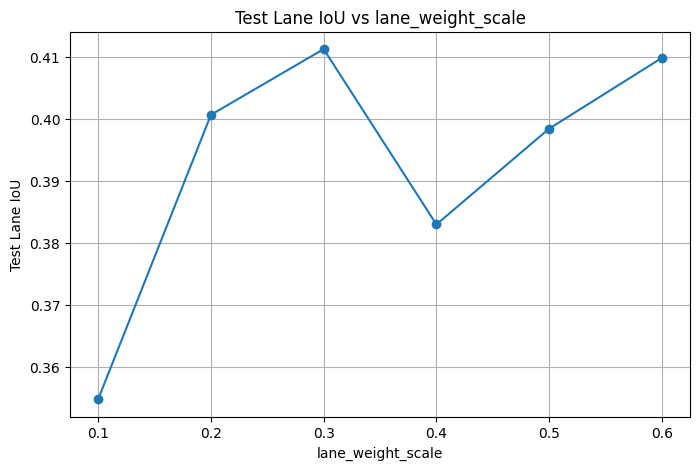

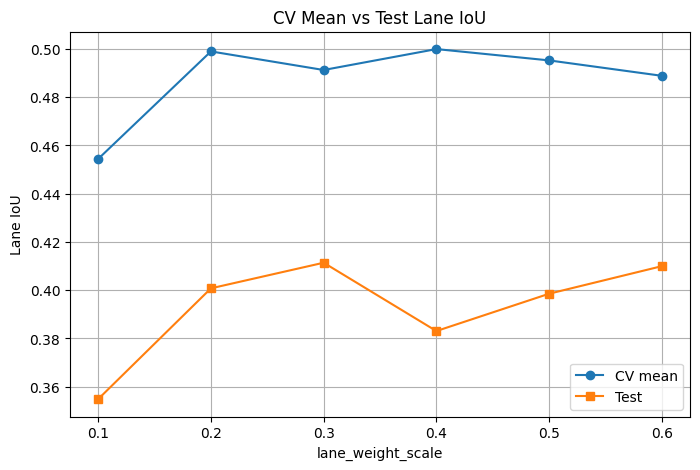


===== BEST SCALE (Test 기준) =====
lane_weight_scale                                                          0.3
cv_mean_laneIoU                                                       0.491209
cv_std_laneIoU                                                         0.06682
best_fold                                                                    5
test_laneIoU(best_fold_model)                                         0.411316
scale_dir                        ./checkpoints_kfold/20260215_025632\scale_0.3
Name: 2, dtype: object


In [177]:
# ==========================================================
# SWEEP RESULT VISUALIZATION
# ----------------------------------------------------------
# - sweep_results.csv 로드
# - scale별 test_laneIoU 표 출력
# - CV mean vs Test 비교 그래프
# ==========================================================

import os
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) CSV 로드
# -----------------------------
csv_path = os.path.join(HP["save_dir"], "sweep_results.csv")
df = pd.read_csv(csv_path)

# scale 정렬
df = df.sort_values("lane_weight_scale").reset_index(drop=True)

print("\n===== TEST RESULT TABLE =====")
display(df)

# -----------------------------
# 2) Test Lane IoU 그래프
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(df["lane_weight_scale"], df["test_laneIoU(best_fold_model)"], marker="o")
plt.xlabel("lane_weight_scale")
plt.ylabel("Test Lane IoU")
plt.title("Test Lane IoU vs lane_weight_scale")
plt.grid(True)
plt.show()

# -----------------------------
# 3) CV mean vs Test 비교
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(df["lane_weight_scale"], df["cv_mean_laneIoU"], marker="o", label="CV mean")
plt.plot(df["lane_weight_scale"], df["test_laneIoU(best_fold_model)"], marker="s", label="Test")
plt.xlabel("lane_weight_scale")
plt.ylabel("Lane IoU")
plt.title("CV Mean vs Test Lane IoU")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 4) 최고 scale 자동 출력
# -----------------------------
best_idx = df["test_laneIoU(best_fold_model)"].idxmax()
best_row = df.loc[best_idx]

print("\n===== BEST SCALE (Test 기준) =====")
print(best_row)


===== MERGED RESULT TABLE (ALL RUNS) =====


lane_weight_scale  cv_mean_laneIoU  cv_std_laneIoU  best_fold  \
0                 0.5         0.471866        0.046080          5   
1                 0.6         0.470978        0.049467          5   
2                 0.7         0.457078        0.038916          5   
3                 0.8         0.444702        0.053315          5   
4                 0.9         0.442864        0.063333          5   
5                 1.0         0.454366        0.051371          5   
6                 1.1         0.433455        0.051768          1   
7                 1.2         0.442755        0.043648          5   
8                 1.3         0.444749        0.056805          5   
9                 1.4         0.429843        0.048749          5   
10                1.5         0.426395        0.030299          5   
11                0.1         0.454355        0.061182          5   
12                0.2         0.498913        0.053210          5   
13                0.3         0.491209        0.066820          5   
14                0.4         0.499882        0.056748          5   
15                0.5         0.495191        0.049859          5   
16                0.6         0.488802        0.056054          5   

    test_laneIoU(best_fold_model)  \
0                        0.370256   
1                        0.399088   
2                        0.348386   
3                        0.371987   
4                        0.344296   
5                        0.366918   
6                        0.369118   
7                        0.367180   
8                        0.352221   
9                        0.333233   
10                       0.312804   
11                       0.354786   
12                       0.400698   
13                       0.411316   
14                       0.382990   
15                       0.398463   
16                       0.409888   

                                        scale_dir  \
0   ./checkpoints_kfold/20260214_171552\scale_0.5   
1   ./checkpoints_kfold/20260214_171552\scale_0.6   
2   ./checkpoints_kfold/20260214_171552\scale_0.7   
3   ./checkpoints_kfold/20260214_171552\scale_0.8   
4   ./checkpoints_kfold/20260214_171552\scale_0.9   
5   ./checkpoints_kfold/20260214_171552\scale_1.0   
6   ./checkpoints_kfold/20260214_171552\scale_1.1   
7   ./checkpoints_kfold/20260214_171552\scale_1.2   
8   ./checkpoints_kfold/20260214_171552\scale_1.3   
9   ./checkpoints_kfold/20260214_171552\scale_1.4   
10  ./checkpoints_kfold/20260214_171552\scale_1.5   
11  ./checkpoints_kfold/20260215_025632\scale_0.1   
12  ./checkpoints_kfold/20260215_025632\scale_0.2   
13  ./checkpoints_kfold/20260215_025632\scale_0.3   
14  ./checkpoints_kfold/20260215_025632\scale_0.4   
15  ./checkpoints_kfold/20260215_025632\scale_0.5   
16  ./checkpoints_kfold/20260215_025632\scale_0.6   

                                run_dir           run_id  
0   ./checkpoints_kfold/20260214_171552  20260214_171552  
1   ./checkpoints_kfold/20260214_171552  20260214_171552  
2   ./checkpoints_kfold/20260214_171552  20260214_171552  
3   ./checkpoints_kfold/20260214_171552  20260214_171552  
4   ./checkpoints_kfold/20260214_171552  20260214_171552  
5   ./checkpoints_kfold/20260214_171552  20260214_171552  
6   ./checkpoints_kfold/20260214_171552  20260214_171552  
7   ./checkpoints_kfold/20260214_171552  20260214_171552  
8   ./checkpoints_kfold/20260214_171552  20260214_171552  
9   ./checkpoints_kfold/20260214_171552  20260214_171552  
10  ./checkpoints_kfold/20260214_171552  20260214_171552  
11  ./checkpoints_kfold/20260215_025632  20260215_025632  
12  ./checkpoints_kfold/20260215_025632  20260215_025632  
13  ./checkpoints_kfold/20260215_025632  20260215_025632  
14  ./checkpoints_kfold/20260215_025632  20260215_025632  
15  ./checkpoints_kfold/20260215_025632  20260215_025632  
16  ./checkpoints_kfold/20260215_025632  20260215_025632

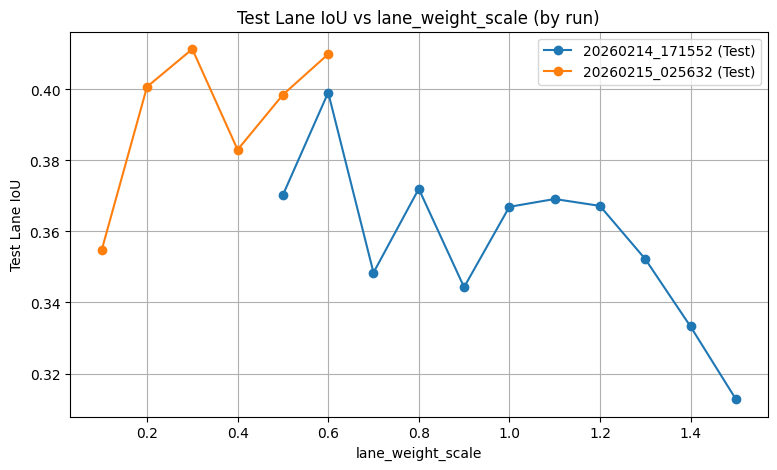

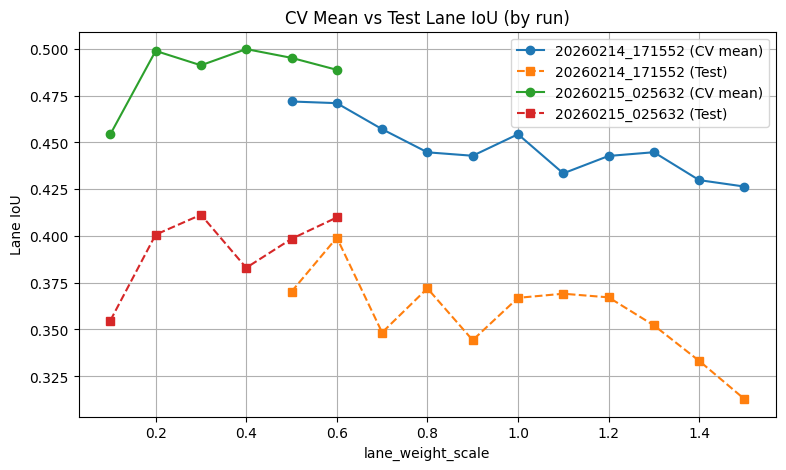


===== BEST SCALE PER RUN (Test 기준) =====


lane_weight_scale  cv_mean_laneIoU  cv_std_laneIoU  best_fold  \
0                0.6         0.470978        0.049467          5   
1                0.3         0.491209        0.066820          5   

   test_laneIoU(best_fold_model)  \
0                       0.399088   
1                       0.411316   

                                       scale_dir  \
0  ./checkpoints_kfold/20260214_171552\scale_0.6   
1  ./checkpoints_kfold/20260215_025632\scale_0.3   

                               run_dir           run_id  
0  ./checkpoints_kfold/20260214_171552  20260214_171552  
1  ./checkpoints_kfold/20260215_025632  20260215_025632


===== BEST SCALE PER RUN (CV mean 기준) =====


lane_weight_scale  cv_mean_laneIoU  cv_std_laneIoU  best_fold  \
0                0.5         0.471866        0.046080          5   
1                0.4         0.499882        0.056748          5   

   test_laneIoU(best_fold_model)  \
0                       0.370256   
1                       0.382990   

                                       scale_dir  \
0  ./checkpoints_kfold/20260214_171552\scale_0.5   
1  ./checkpoints_kfold/20260215_025632\scale_0.4   

                               run_dir           run_id  
0  ./checkpoints_kfold/20260214_171552  20260214_171552  
1  ./checkpoints_kfold/20260215_025632  20260215_025632

In [180]:
# ==========================================================
# SWEEP RESULT VISUALIZATION (MULTI-RUN)
# ----------------------------------------------------------
# - 두 개 run 폴더의 sweep_results.csv를 동시에 로드
# - 표 병합 출력
# - run별 Test Lane IoU 그래프
# - run별 CV mean vs Test 비교 그래프
# - run별 최고 scale 출력
# ==========================================================

import os
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 비교할 run 폴더 2개를 직접 지정
RUN_DIRS = [
    "./checkpoints_kfold/20260214_171552",  # (사용자 설명대로) 방금 끝난 실험
    "./checkpoints_kfold/20260215_025632",  # (사용자 설명대로) 이전 실험
]

def load_one_run(run_dir: str) -> pd.DataFrame:
    csv_path = os.path.join(run_dir, "sweep_results.csv")
    df = pd.read_csv(csv_path)
    df["run_dir"] = run_dir
    df["run_id"] = os.path.basename(run_dir.rstrip("/\\"))
    # 정렬
    df = df.sort_values("lane_weight_scale").reset_index(drop=True)
    return df

# -----------------------------
# 1) 두 run 로드 + 병합
# -----------------------------
dfs = []
for rd in RUN_DIRS:
    if not os.path.exists(rd):
        raise FileNotFoundError(f"run_dir not found: {rd}")
    dfs.append(load_one_run(rd))

df_all = pd.concat(dfs, ignore_index=True)

print("\n===== MERGED RESULT TABLE (ALL RUNS) =====")
display(df_all.sort_values(["run_id", "lane_weight_scale"]).reset_index(drop=True))

# -----------------------------
# 2) Run별 Test Lane IoU 그래프
# -----------------------------
plt.figure(figsize=(9,5))
for run_id, g in df_all.groupby("run_id"):
    g = g.sort_values("lane_weight_scale")
    plt.plot(g["lane_weight_scale"], g["test_laneIoU(best_fold_model)"], marker="o", label=f"{run_id} (Test)")
plt.xlabel("lane_weight_scale")
plt.ylabel("Test Lane IoU")
plt.title("Test Lane IoU vs lane_weight_scale (by run)")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# 3) Run별 CV mean vs Test 비교
# -----------------------------
plt.figure(figsize=(9,5))
for run_id, g in df_all.groupby("run_id"):
    g = g.sort_values("lane_weight_scale")
    plt.plot(g["lane_weight_scale"], g["cv_mean_laneIoU"], marker="o", linestyle="-", label=f"{run_id} (CV mean)")
    plt.plot(g["lane_weight_scale"], g["test_laneIoU(best_fold_model)"], marker="s", linestyle="--", label=f"{run_id} (Test)")
plt.xlabel("lane_weight_scale")
plt.ylabel("Lane IoU")
plt.title("CV Mean vs Test Lane IoU (by run)")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# 4) Run별 최고 scale 출력 (Test 기준)
# -----------------------------
print("\n===== BEST SCALE PER RUN (Test 기준) =====")
best_rows = []
for run_id, g in df_all.groupby("run_id"):
    best_idx = g["test_laneIoU(best_fold_model)"].idxmax()
    best_rows.append(df_all.loc[best_idx])

best_df = pd.DataFrame(best_rows).sort_values("run_id").reset_index(drop=True)
display(best_df)

# (선택) CV mean 기준 최고도 같이 보고 싶으면:
print("\n===== BEST SCALE PER RUN (CV mean 기준) =====")
best_rows_cv = []
for run_id, g in df_all.groupby("run_id"):
    best_idx = g["cv_mean_laneIoU"].idxmax()
    best_rows_cv.append(df_all.loc[best_idx])

best_df_cv = pd.DataFrame(best_rows_cv).sort_values("run_id").reset_index(drop=True)
display(best_df_cv)


## 실험 결과
### 1차 실험 scale 0.5 ~ 1.5 까지 0.1 씩 증가, 2차 실험 scale 0.1 ~ 0.6까지 0.1 씩 증가
- testdataset 기준
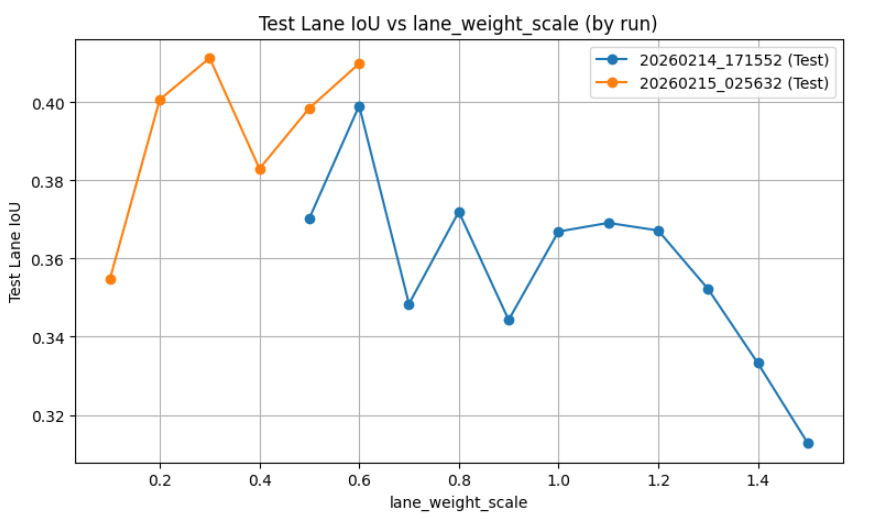
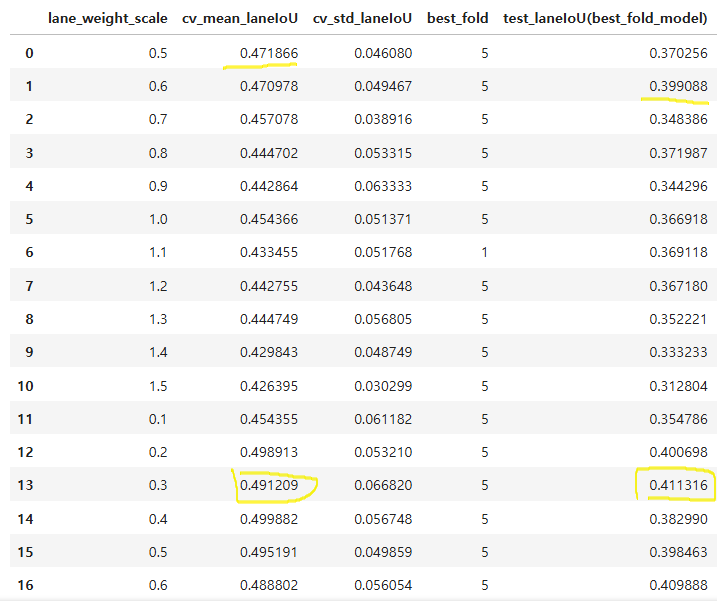
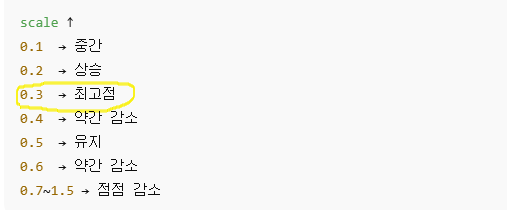
- 실험 결과 class weight는 과도하여 성능을 오히려 떨어뜨렸음

### class weight로 인한 실제 lane weight 변화 
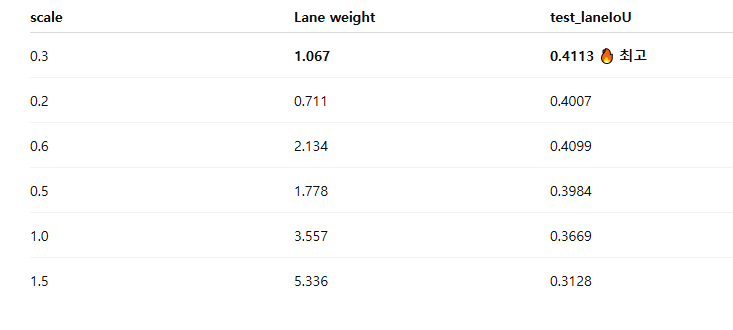

### 다른 클래스의 변화도 함께 고려한 Class weight 변화 비교
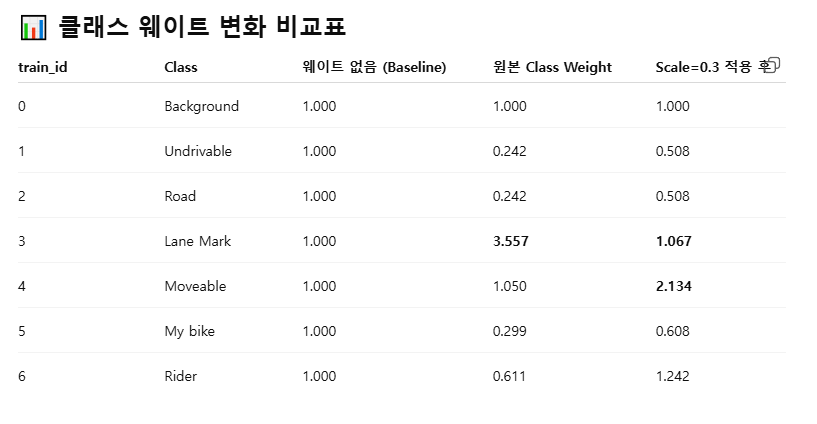

### 🔍 핵심 변화 해석
#### ① 클래스 웨이트 적용 전
- 모든 클래스 동일하게 학습
- 모델은 데이터 분포에 의해 자연스럽게 학습
#### ② 원본 클래스 웨이트 적용
- Lane Mark = 3.557 (극단적으로 큼): 
- lane mark 클래스의 px 분포가 극단적으로 작아서 그 역수를 적용하다 보니 weight가 극단적으로 증가함
- Undrivable / Road = 0.242 (매우 작음) : 반대 상황
- 즉, 모델이 Lane에 매우 민감해짐
- 이 상태에서: **Lane false positive 증가 가능**, **Gradient 폭주 가능성**, **불안정성 증가**.
#### ③ scale=0.3 적용 후
- Lane = 1.067 → 정상 범위
- Moveable = 2.134 → 가장 강해짐
- 전체 클래스 분포가 더 균형적으로 재정렬됨
- 이 상태는 사실상: **“Lane 과보호를 제거한 상태”**
### 🎯 가장 중요한 포인트
- 원래 의도: Lane을 강조하려고 class weight 사용
- 실제 결과: Lane을 너무 과하게 강조해서 모델을 망가뜨림, 그래서 
#### **scale=0.3:** Lane을 정상 수준으로 복원 → 성능 상승
### 📌 지금까지 발견된 것으로는 문제를 해결할 수 있는 수준은 아님.
- 로그를 취할 경우 변화를 추가로 확인 필요
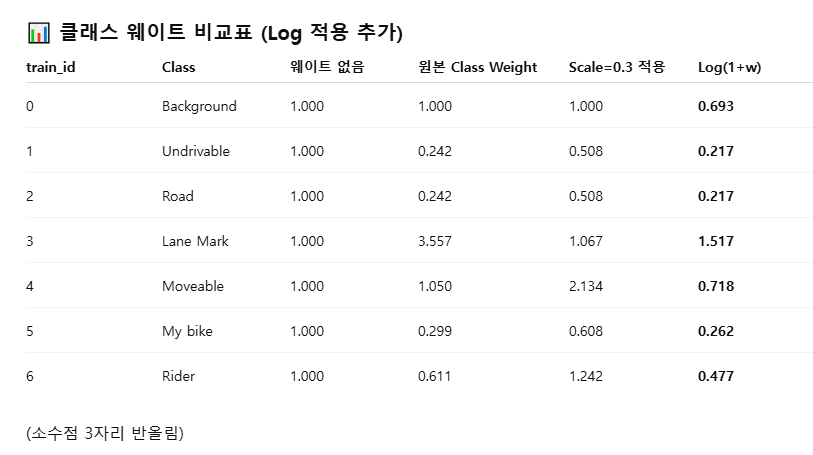
## 추가 실험할 내용
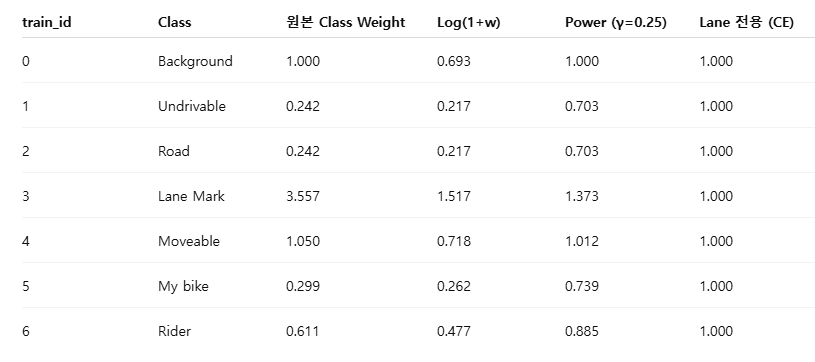

### Optimization Engineering 3차 시험: Class weight log transformation(crop 45%로만 실험)
- (1) weight OFF vs (2) log(1+w) weight 비교

In [285]:
# ==========================================================
# ✅ CELL 1) SINGLE CONTROL PANEL (NO DUPLICATION)
# - 목표: (1) weight OFF vs (2) log(1+w) weight 비교
# - crop은 후보 리스트(예: 33/36/39%)만 돌려서 빠르게 비교
# - 실행할 때는 아래 HP만 수정하면 됨
# ==========================================================

import os, random, time, platform, json, csv
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datetime import datetime
from sklearn.model_selection import KFold

# -----------------------------
# ✅ EXP CONTROL
# -----------------------------
HP = {
    # ---- reproducibility ----
    "seed": 42,

    # ---- split ----
    "k_folds": 5,
    "test_size": 20,          # fixed test
    "split_shuffle": True,

    # ---- dataloader ----
    "batch_size": 4,
    "num_workers": 0,
    "pin_memory": True,

    # ---- image size ----
    "img_size": (512, 512),

    # ---- priority / overlay ----
    "use_priority_order": True,
    "priority_template": ["undrivable", "road", "moveable", "rider", "bike", "lane"],

    # ======================================================
    # ✅ Loss / Weighting
    # ======================================================
    "use_class_weights": False,     # (baseline에서는 False)
    "weights_from": "pixel_ratio",
    "w_min": 0.25,
    "w_max": 10.0,
    "normalize_weights_mean1": True,
    "lane_weight_scale": 1.0,

    # ✅ NEW: class weight transform
    "weight_transform": "none",     # "none" | "log1p"

    # ---- Lane Dice (optional) ----
    "use_lane_dice": False,
    "lane_dice_lambda": 0.5,
    "dice_smooth": 1.0,

    # ---- training ----
    "epochs": 50,
    "patience": 5,
    "lr": 3e-4,
    "weight_decay": 3e-4,
    "grad_clip": 1.0,
    "use_amp": True,

    # ======================================================
    # ✅ Crop candidates (percent)
    # - 여기만 바꾸면 됨 (예: [33,36,39] or [42,45,48])
    # ======================================================
    "crop_candidates_pct": [45], # HP["crop_candidates_pct"] = [45]

    # ---- save ----
    "save_base": "./checkpoints_kfold",
    "save_prefix": "deeplabv3p",
}

# -----------------------------
# ✅ seed fix
# -----------------------------
SEED = int(HP["seed"])
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# ✅ run dir (항상 새 폴더 생성)
# -----------------------------
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
save_root = os.path.join(HP["save_base"], run_id)
os.makedirs(save_root, exist_ok=True)
print("save_root:", save_root)

# -----------------------------
# ✅ helper: pct -> px
# -----------------------------
def crop_pct_to_px(pct: int, img_h: int):
    return int(round(img_h * (pct / 100.0)))

print("crop_candidates_pct:", HP["crop_candidates_pct"])
print("img_size:", HP["img_size"])


device: cuda
save_root: ./checkpoints_kfold\20260216_140516
crop_candidates_pct: [45]
img_size: (512, 512)


In [287]:
# ==========================================================
# ✅ CELL 2) Dataset class: COCOSemSeg (crop_top_px 지원)
# ==========================================================

import os, random
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision import transforms

class COCOSemSeg(Dataset):
    """
    COCO instance/pixel annotations -> semantic mask (H,W) with train ids.
    - priority_order로 overlay 순서 제어
    - crop_top_px로 상단 crop 지원 (resize 전에 수행)
    """
    def __init__(
        self,
        coco,
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        priority_order=None,
        crop_top_px=0,
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.hflip_p = hflip_p
        self.crop_top_px = int(crop_top_px)

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        self.priority_order = priority_order
        if self.priority_order is not None:
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        if self.priority_order is not None:
            def sort_key(a):
                cid = a["category_id"]
                in_prio = (cid in self._prio_rank)
                group = 1 if in_prio else 0
                rank  = self._prio_rank.get(cid, -1)
                return (group, rank)
            anns = sorted(anns, key=sort_key)

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]
        return mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size

        mask = self._build_mask(img_id, H, W)

        # ✅ 1) 상단 crop (resize 전에)
        if self.crop_top_px > 0:
            crop = min(self.crop_top_px, H - 1)
            img = TF.crop(img, top=crop, left=0, height=H - crop, width=W)
            mask = mask[crop:, :]
            H = H - crop

        mask = Image.fromarray(mask)

        # ✅ 2) resize
        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)

        # ✅ 3) augmentation
        if self.train and random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask

print("✅ COCOSemSeg ready")


✅ COCOSemSeg ready


In [289]:
# ==========================================================
# ✅ CELL 3) Dataset build & utils
# - id2train/NUM_CLASSES/LANE_TRAIN_ID 생성
# - priority_order 생성
# - class weights (none vs log1p) 지원
# - make_loader / build_criterion / CombinedCriterion 정의
# ==========================================================

import numpy as np
import torch
import torch.nn as nn

# -----------------------------
# 1) CATEGORY / MAPPING
# -----------------------------
IMG_DIR = os.path.join(DATA_ROOT, "images")

categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # bg 포함

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

cat_id_to_name = {c["id"]: c["name"] for c in categories}

def find_cids(keyword: str):
    k = keyword.lower()
    return [cid for cid, name in cat_id_to_name.items() if k in (name or "").lower()]

lane_cids = find_cids("lane")
LANE_TRAIN_ID = id2train[lane_cids[0]] if lane_cids else None
print("LANE_TRAIN_ID:", LANE_TRAIN_ID, "->", train2name.get(LANE_TRAIN_ID))

# -----------------------------
# 2) PRIORITY ORDER (lane last)
# -----------------------------
priority_order = None
if HP["use_priority_order"]:
    priority_order = []
    for key in HP["priority_template"]:
        priority_order += find_cids(key)

    lane_only = find_cids("lane")
    priority_order = [cid for cid in priority_order if cid not in lane_only] + lane_only

    # 중복 제거(순서 유지)
    seen = set()
    priority_order = [x for x in priority_order if not (x in seen or seen.add(x))]

    print("\n===== PRIORITY ORDER (category_id -> name) =====")
    for cid in priority_order:
        print(f"{cid} -> {cat_id_to_name[cid]}")
else:
    print("\n(priority_order OFF)")

# -----------------------------
# 3) SPLIT: fixed test + trainval
# -----------------------------
all_img_ids = sorted(coco.getImgIds())
if HP["split_shuffle"]:
    rng = random.Random(SEED)
    rng.shuffle(all_img_ids)

test_ids = all_img_ids[:int(HP["test_size"])]
trainval_ids = all_img_ids[int(HP["test_size"]):]
print(f"\nFixed test size: {len(test_ids)}")
print(f"TrainVal size : {len(trainval_ids)}")

# -----------------------------
# 4) CLASS WEIGHTS (pixel ratio 기반) + log1p 옵션
# -----------------------------
def make_class_weights_from_pixel_ratio(
    id2train, cat_id_to_name, pixel_ratio_df,
    num_classes,
    lane_weight_scale=1.0,
    min_w=0.25,
    max_w=10.0,
    normalize_to_mean1=True,
    weight_transform="none"   # "none" | "log1p"
):
    w = np.ones(num_classes, dtype=np.float32)

    ratio_map = {
        int(r["category_id"]): float(r["pixel_ratio(%)"])
        for _, r in pixel_ratio_df.iterrows()
    }

    eps = 1e-6
    inv = {cid: 1.0 / max(ratio_map[cid], eps) for cid in ratio_map}
    inv_vals = np.array(list(inv.values()), dtype=np.float32)
    inv_mean = float(inv_vals.mean())

    for cid, invv in inv.items():
        if cid not in id2train:
            continue
        tid = id2train[cid]
        w[tid] = invv / inv_mean

    w = np.clip(w, min_w, max_w)

    # lane scale knob
    lane_cids = [cid for cid, name in cat_id_to_name.items() if "lane" in (name or "").lower()]
    if lane_cids:
        lane_tid = id2train[lane_cids[0]]
        w[lane_tid] = float(np.clip(w[lane_tid] * lane_weight_scale, min_w, max_w))

    # ✅ transform
    if weight_transform == "log1p":
        w = np.log1p(w)

    # normalize to mean=1 (no bg)
    if normalize_to_mean1:
        mean_no_bg = float(w[1:].mean())
        w[1:] = w[1:] / max(mean_no_bg, 1e-6)

    return w

# -----------------------------
# 5) Optional lane dice (그대로 유지)
# -----------------------------
def lane_dice_loss(logits, target, lane_id: int, smooth=1.0):
    probs = torch.softmax(logits, dim=1)
    p = probs[:, lane_id, :, :]
    g = (target == lane_id).float()
    inter = (p * g).sum(dim=(1,2))
    union = p.sum(dim=(1,2)) + g.sum(dim=(1,2))
    dice = (2*inter + smooth) / (union + smooth)
    return 1.0 - dice.mean()

class CombinedCriterion(nn.Module):
    def __init__(self, ce_criterion, use_lane_dice=False, lane_id=None, dice_lambda=0.5, smooth=1.0):
        super().__init__()
        self.ce = ce_criterion
        self.use_lane_dice = use_lane_dice
        self.lane_id = lane_id
        self.dice_lambda = dice_lambda
        self.smooth = smooth

    def forward(self, logits, target):
        loss = self.ce(logits, target)
        if self.use_lane_dice and (self.lane_id is not None):
            loss = loss + self.dice_lambda * lane_dice_loss(logits, target, self.lane_id, smooth=self.smooth)
        return loss

# -----------------------------
# 6) build_criterion (실험모드에 따라 weight 적용)
# -----------------------------
def build_criterion_from_hp():
    if HP["use_class_weights"]:
        w_np = make_class_weights_from_pixel_ratio(
            id2train=id2train,
            cat_id_to_name=cat_id_to_name,
            pixel_ratio_df=pixel_df,
            num_classes=NUM_CLASSES,
            lane_weight_scale=float(HP["lane_weight_scale"]),
            min_w=float(HP["w_min"]),
            max_w=float(HP["w_max"]),
            normalize_to_mean1=bool(HP["normalize_weights_mean1"]),
            weight_transform=str(HP["weight_transform"]),
        )
        w_t = torch.tensor(w_np, dtype=torch.float32, device=device)
        ce = nn.CrossEntropyLoss(weight=w_t)
    else:
        ce = nn.CrossEntropyLoss()

    return CombinedCriterion(
        ce_criterion=ce,
        use_lane_dice=bool(HP["use_lane_dice"]),
        lane_id=LANE_TRAIN_ID,
        dice_lambda=float(HP["lane_dice_lambda"]),
        smooth=float(HP["dice_smooth"]),
    )

# -----------------------------
# 7) make_loader (crop_top_px 매번 주입)
# -----------------------------
def make_loader(img_ids, train: bool, crop_top_px: int = 0):
    ds = COCOSemSeg(
        coco=coco,
        img_dir=IMG_DIR,
        img_ids=img_ids,
        id2train=id2train,
        size=HP["img_size"],
        train=train,
        priority_order=priority_order if HP["use_priority_order"] else None,
        crop_top_px=int(crop_top_px),
    )
    loader = DataLoader(
        ds,
        batch_size=int(HP["batch_size"]),
        shuffle=bool(train),
        num_workers=int(HP["num_workers"]),
        pin_memory=bool(HP["pin_memory"]) and torch.cuda.is_available(),
        worker_init_fn=seed_worker,
        generator=g,
        persistent_workers=False,
    )
    return loader

print("\n✅ dataset/utils ready")


LANE_TRAIN_ID: 3 -> Lane Mark

===== PRIORITY ORDER (category_id -> name) =====
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

Fixed test size: 20
TrainVal size : 180

✅ dataset/utils ready


In [291]:
# ==========================================================
# ✅ CELL 4) EXP RUNNER (CROP=45% only)
# - (A) baseline_off @ 45%
# - (B) log1p @ 45%
# ==========================================================

def set_seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def validate_compat(*args, **kwargs):
    out = validate(*args, **kwargs)
    if not isinstance(out, (tuple, list)) or len(out) < 3:
        raise ValueError("validate() must return (val_loss, val_miou, per_class_dict[, lane_iou])")
    val_loss = float(out[0])
    val_miou = float(out[1])
    per_class_dict = out[2]
    if len(out) >= 4:
        lane_iou = out[3]
    else:
        lane_iou = float(per_class_dict.get(LANE_TRAIN_ID, np.nan))
    lane_iou = float(lane_iou) if lane_iou is not None else float("nan")
    return val_loss, val_miou, per_class_dict, lane_iou

def run_mode_for_crop45(mode_name: str):
    """
    mode_name: "baseline_off" or "log1p"
    """
    set_seed_all(int(HP["seed"]))

    # -----------------------------
    # 1) mode switch
    # -----------------------------
    if mode_name == "baseline_off":
        HP["use_class_weights"] = False
        HP["weight_transform"] = "none"
    elif mode_name == "log1p":
        HP["use_class_weights"] = True
        HP["weight_transform"] = "log1p"
    else:
        raise ValueError("unknown mode")

    crop_pct = 45
    crop_px = crop_pct_to_px(crop_pct, int(HP["img_size"][0]))

    # -----------------------------
    # 2) save dir
    # -----------------------------
    tag = f"{mode_name}__crop_{crop_pct:02d}pct"
    save_dir = os.path.join(save_root, tag)
    os.makedirs(save_dir, exist_ok=True)

    print("\n" + "="*80)
    print(f"[RUN] mode={mode_name} | crop={crop_pct}% | crop_px={crop_px} | save_dir={save_dir}")
    print("="*80)

    # -----------------------------
    # 3) fixed test loader
    # -----------------------------
    test_loader = make_loader(test_ids, train=False, crop_top_px=crop_px)

    # -----------------------------
    # 4) kfold
    # -----------------------------
    k = int(HP["k_folds"])
    kf = KFold(n_splits=k, shuffle=True, random_state=int(HP["seed"]))

    fold_best_lane = []
    fold_best_epoch = []
    fold_best_path = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(trainval_ids), 1):
        train_ids_fold = [trainval_ids[i] for i in tr_idx]
        val_ids_fold   = [trainval_ids[i] for i in va_idx]

        train_loader = make_loader(train_ids_fold, train=True,  crop_top_px=crop_px)
        val_loader   = make_loader(val_ids_fold,   train=False, crop_top_px=crop_px)

        model = build_model_compat()
        criterion = build_criterion_from_hp()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=float(HP["lr"]),
            weight_decay=float(HP["weight_decay"]),
        )

        best_lane = -1.0
        best_ep = 0
        patience = 0
        patience_limit = int(HP["patience"])
        epochs = int(HP["epochs"])

        best_path = os.path.join(save_dir, f"{HP['save_prefix']}_fold{fold}_best.pth")

        print(f"\n----- Fold {fold}/{k} | train={len(train_ids_fold)} | val={len(val_ids_fold)} -----")

        for epoch in range(1, epochs + 1):
            # train
            try:
                train_loss = train_one_epoch(
                    model, train_loader, criterion, optimizer, device,
                    use_amp=bool(HP.get("use_amp", True)),
                    grad_clip=float(HP.get("grad_clip", 1.0)),
                )
            except TypeError:
                train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

            # val
            val_loss, val_miou, _, lane_iou = validate_compat(
                model, val_loader, criterion, device,
                num_classes=NUM_CLASSES,
                exclude_background=True,
            )

            improved = lane_iou > best_lane
            if improved:
                best_lane = lane_iou
                best_ep = epoch
                patience = 0
                torch.save(model.state_dict(), best_path)
            else:
                patience += 1

            print(
                f"[{mode_name} | crop 45% | fold {fold} | ep {epoch:02d}] "
                f"train={train_loss:.4f} | val={val_loss:.4f} | miou={val_miou:.4f} | lane={lane_iou:.4f} "
                f"| best_lane={best_lane:.4f}(ep{best_ep:02d}) | patience={patience}/{patience_limit}"
            )

            if patience >= patience_limit:
                print(f"🛑 EARLY STOP: fold {fold} at ep {epoch} (best lane={best_lane:.4f} @ ep {best_ep})")
                break

        fold_best_lane.append(float(best_lane))
        fold_best_epoch.append(int(best_ep))
        fold_best_path.append(best_path)

        print(f"✅ Fold {fold} BEST laneIoU={best_lane:.4f} @ ep{best_ep} | saved={os.path.basename(best_path)}")

    # -----------------------------
    # 5) CV summary
    # -----------------------------
    lane_arr = np.array(fold_best_lane, dtype=np.float32)
    cv_mean = float(np.nanmean(lane_arr))
    cv_std  = float(np.nanstd(lane_arr))

    best_fold_idx = int(np.nanargmax(lane_arr))
    best_model_path = fold_best_path[best_fold_idx]

    # -----------------------------
    # 6) test eval (best fold)
    # -----------------------------
    best_model = build_model_compat()
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))

    test_criterion = build_criterion_from_hp()  # mode 동일 적용
    test_loss, test_miou, _, test_lane = validate_compat(
        best_model, test_loader, test_criterion, device,
        num_classes=NUM_CLASSES,
        exclude_background=True,
    )

    summary = {
        "mode": mode_name,
        "crop_pct": 45,
        "crop_px": int(crop_px),
        "cv_best_laneIoU_per_fold": [float(x) for x in fold_best_lane],
        "cv_best_epoch_per_fold": [int(x) for x in fold_best_epoch],
        "cv_mean_laneIoU": float(cv_mean),
        "cv_std_laneIoU": float(cv_std),
        "best_fold": int(best_fold_idx + 1),
        "best_model_path": str(best_model_path),
        "test_laneIoU(best_fold_model)": float(test_lane),
        "test_mIoU(best_fold_model)": float(test_miou),
        "test_loss(best_fold_model)": float(test_loss),
        "save_dir": str(save_dir),
        "hp_snapshot": {
            "use_class_weights": bool(HP["use_class_weights"]),
            "weight_transform": str(HP["weight_transform"]),
            "lane_weight_scale": float(HP["lane_weight_scale"]),
            "w_min": float(HP["w_min"]),
            "w_max": float(HP["w_max"]),
            "normalize_weights_mean1": bool(HP["normalize_weights_mean1"]),
        }
    }

    with open(os.path.join(save_dir, "summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)

    print("\n---- RESULT ----")
    print(f"mode={mode_name} | crop=45% | CV mean laneIoU={cv_mean:.4f}±{cv_std:.4f} | TEST laneIoU={test_lane:.4f}")
    return summary

# ==========================================================
# ✅ RUN ONLY TWO EXPERIMENTS @ crop=45%
# ==========================================================
results = []
for mode in ["baseline_off", "log1p"]:
    results.append(run_mode_for_crop45(mode))

# ==========================================================
# ✅ SAVE COMPARE
# ==========================================================
csv_path = os.path.join(save_root, "compare_crop45_log1p_vs_off.csv")
json_path = os.path.join(save_root, "compare_crop45_log1p_vs_off.json")

with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([
        "mode", "crop_pct", "crop_px",
        "cv_mean_laneIoU", "cv_std_laneIoU",
        "best_fold",
        "test_laneIoU(best_fold_model)", "test_mIoU(best_fold_model)", "test_loss(best_fold_model)",
        "save_dir"
    ])
    for r in results:
        w.writerow([
            r["mode"], r["crop_pct"], r["crop_px"],
            r["cv_mean_laneIoU"], r["cv_std_laneIoU"],
            r["best_fold"],
            r["test_laneIoU(best_fold_model)"], r["test_mIoU(best_fold_model)"], r["test_loss(best_fold_model)"],
            r["save_dir"]
        ])

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print("\n✅ DONE (crop=45% only)")
print("Saved:", csv_path)
print("Saved:", json_path)


[RUN] mode=baseline_off | crop=45% | crop_px=230 | save_dir=./checkpoints_kfold\20260216_140516\baseline_off__crop_45pct

----- Fold 1/5 | train=144 | val=36 -----


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):
C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):


[baseline_off | crop 45% | fold 1 | ep 01] train=0.6239 | val=0.4529 | miou=0.6237 | lane=0.0000 | best_lane=0.0000(ep01) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 02] train=0.3244 | val=0.3274 | miou=0.7159 | lane=0.1597 | best_lane=0.1597(ep02) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 03] train=0.2438 | val=0.2861 | miou=0.7563 | lane=0.2990 | best_lane=0.2990(ep03) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 04] train=0.1956 | val=0.2755 | miou=0.7650 | lane=0.3375 | best_lane=0.3375(ep04) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 05] train=0.1667 | val=0.2649 | miou=0.7866 | lane=0.3838 | best_lane=0.3838(ep05) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 06] train=0.1526 | val=0.2518 | miou=0.7886 | lane=0.4007 | best_lane=0.4007(ep06) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 07] train=0.1378 | val=0.2458 | miou=0.7966 | lane=0.4143 | best_lane=0.4143(ep07) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 08

### TEST laneIoU 결과 분석
- mode=baseline_off | crop=45% | CV mean laneIoU=0.5081±0.0577 | TEST laneIoU=0.4345
- mode=       log1p | crop=45% | CV mean laneIoU=0.4908±0.0451 | TEST laneIoU=0.3903
- 0.0443 만큼 성능저하
#### 폴드별 분석 (crop=45% 고정)
- Fold best laneIoU (val 기준) 비교
#### baseline_off:
- F1 0.5438, F2 0.4188, F3 0.4857, F4 0.5012, F5 0.5908
- → 평균 0.5081, 표준편차 0.0577
#### log1p(weights ON):
- F1 0.5223, F2 0.4148, F3 0.4784, F4 0.4905, F5 0.5479
- → 평균 0.4908, 표준편차 0.0451
#### 폴드별 “log1p - baseline_off” 차이(Val best laneIoU)
- F1: 0.5223 - 0.5438 = -0.0215
- F2: 0.4148 - 0.4188 = -0.0040
- F3: 0.4784 - 0.4857 = -0.0073
- F4: 0.4905 - 0.5012 = -0.0107
- F5: 0.5479 - 0.5908 = -0.0429

### ✅ 5개 폴드 모두에서 log1p가 baseline보다 낮음
- 특히 Fold5에서 손해폭(-0.0429) 이 커서, “가중치 변환이 lane을 안정적으로 올려주지 못하고 오히려 깨뜨리는 fold가 있다”는 신호가 강함

### Optimization Engineering - 4차 실험: Fractional power (γ = 0.25) class weight scaling - 4제곱근 적용

In [304]:
# ==========================================================
# ✅ CELL 1) SINGLE CONTROL PANEL (POWER EXP)
# - crop=45% 고정
# - mode: baseline_off vs power(gamma)
# - ✅ KeyError 방지: use_priority_order/priority_template 포함
# - ✅ make_loader가 (ds, loader)든 loader든 둘 다 대응
# ==========================================================

import os, random, json, csv
import numpy as np
import torch
import torch.nn as nn
from datetime import datetime

from sklearn.model_selection import KFold

HP = {
    # ---- reproducibility ----
    "seed": 42,

    # ---- split / kfold ----
    "k_folds": 5,
    "test_size": 20,
    "split_shuffle": True,

    # ---- training ----
    "epochs": 50,
    "patience": 5,
    "lr": 3e-4,
    "weight_decay": 3e-4,
    "grad_clip": 1.0,
    "use_amp": True,

    # ---- dataloader ----
    "batch_size": 4,
    "num_workers": 0,
    "pin_memory": True,

    # ---- image size ----
    "img_size": (512, 512),

    # ---- overlay priority ----
    "use_priority_order": True,
    "priority_template": ["undrivable", "road", "moveable", "rider", "bike", "lane"],

    # ---- crop fixed ----
    "crop_candidates_pct": [45],

    # ---- class weights ----
    "use_class_weights": False,
    "weight_transform": "none",  # none / power
    "power_gamma": 0.25,         # ✅ power 실험 knob

    "w_min": 0.25,
    "w_max": 10.0,
    "normalize_weights_mean1": True,
    "lane_weight_scale": 1.0,

    # ---- save ----
    "save_prefix": "deeplabv3p",
}

# -----------------------------
# seed helpers
# -----------------------------
def set_seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed_all(int(HP["seed"]))
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# save root
# -----------------------------
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
save_root = f"./checkpoints_kfold/{run_id}"
os.makedirs(save_root, exist_ok=True)
print("save_root:", save_root)
print("crop_candidates_pct:", HP["crop_candidates_pct"])
print("power_gamma:", HP["power_gamma"])

device: cuda
save_root: ./checkpoints_kfold/20260216_174036
crop_candidates_pct: [45]
power_gamma: 0.25


In [306]:
# ==========================================================
# ✅ CELL 2) DATASET / IDS / PRIORITY ORDER 준비
# 전제: 아래 변수들이 이미 앞 셀에서 존재해야 함
# - DATA_ROOT, coco, pixel_df
# - COCOSemSeg (crop_top_px 인자 포함 버전)
# ==========================================================

from PIL import Image
import torchvision.transforms.functional as TF

# ---- img dir ----
IMG_DIR = os.path.join(DATA_ROOT, "images")

# ---- category mapping ----
categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # bg 포함

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

cat_id_to_name = {c["id"]: c["name"] for c in categories}

def find_cids(keyword: str):
    k = keyword.lower()
    return [cid for cid, name in cat_id_to_name.items() if k in (name or "").lower()]

lane_cids = find_cids("lane")
LANE_TRAIN_ID = id2train[lane_cids[0]] if lane_cids else None
print("LANE_TRAIN_ID:", LANE_TRAIN_ID, "->", train2name.get(LANE_TRAIN_ID))

# ---- priority order ----
priority_order = None
if bool(HP.get("use_priority_order", True)):
    priority_order = []
    for key in HP["priority_template"]:
        priority_order += find_cids(key)

    # lane을 맨 뒤로 강제
    lane_only = find_cids("lane")
    priority_order = [cid for cid in priority_order if cid not in lane_only] + lane_only

    print("\n===== PRIORITY ORDER (category_id -> name) =====")
    for cid in priority_order:
        print(f"{cid} -> {cat_id_to_name[cid]}")
else:
    print("\n(priority_order OFF)")

# ---- split ids ----
all_img_ids = sorted(coco.getImgIds())
if bool(HP.get("split_shuffle", True)):
    rng = random.Random(int(HP["seed"]))
    rng.shuffle(all_img_ids)

test_ids = all_img_ids[:int(HP.get("test_size", 20))]
trainval_ids = all_img_ids[int(HP.get("test_size", 20)):]
print("\nFixed test size:", len(test_ids))
print("TrainVal size :", len(trainval_ids))

print("\n✅ dataset/utils ready")

LANE_TRAIN_ID: 3 -> Lane Mark

===== PRIORITY ORDER (category_id -> name) =====
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

Fixed test size: 20
TrainVal size : 180

✅ dataset/utils ready


In [308]:
# ==========================================================
# ✅ CELL 3) WEIGHT BUILDER + CRITERION BUILDER (none / power)
# 전제: pixel_df 컬럼
# - ["category_id", "pixel_ratio(%)"]
# ==========================================================

def make_class_weights_from_pixel_ratio(
    id2train, cat_id_to_name, pixel_ratio_df,
    num_classes: int,
    lane_weight_scale=1.0,
    min_w=0.25,
    max_w=10.0,
    normalize_to_mean1=True,
    transform="none",
    power_gamma=0.25,
):
    """
    transform:
      - "none"  : inv_ratio 기반 그대로
      - "power" : (inv_ratio) ** gamma  (gamma=0.25이면 4제곱근)
    """
    w = np.ones(num_classes, dtype=np.float32)

    ratio_map = {int(r["category_id"]): float(r["pixel_ratio(%)"]) for _, r in pixel_ratio_df.iterrows()}
    eps = 1e-6

    inv = {}
    for cid, ratio in ratio_map.items():
        base = 1.0 / max(ratio, eps)   # inverse
        inv[cid] = base

    inv_vals = np.array(list(inv.values()), dtype=np.float32)

    # ---- transform ----
    if transform == "power":
        gamma = float(power_gamma)
        inv_vals_t = np.power(inv_vals, gamma)
        # inv dict도 같은 스케일로 변환
        inv_t = {}
        for (cid, base) in inv.items():
            inv_t[cid] = float(base ** gamma)
        inv = inv_t
        inv_mean = float(inv_vals_t.mean())
    else:
        inv_mean = float(inv_vals.mean())

    # ---- fill weights by train id ----
    for cid, invv in inv.items():
        if cid not in id2train:
            continue
        tid = id2train[cid]
        w[tid] = float(invv / max(inv_mean, 1e-12))

    w = np.clip(w, float(min_w), float(max_w))

    # ---- lane scaling ----
    lane_cids = [cid for cid, name in cat_id_to_name.items() if "lane" in (name or "").lower()]
    if lane_cids:
        lane_tid = id2train[lane_cids[0]]
        w[lane_tid] = float(np.clip(w[lane_tid] * float(lane_weight_scale), float(min_w), float(max_w)))

    # ---- normalize mean=1 (no-bg) ----
    if bool(normalize_to_mean1):
        mean_no_bg = float(w[1:].mean())
        w[1:] = w[1:] / max(mean_no_bg, 1e-6)

    return w

def build_criterion_from_hp():
    """
    전제: NUM_CLASSES, device, pixel_df, id2train, cat_id_to_name 존재
    """
    if bool(HP.get("use_class_weights", False)):
        w_np = make_class_weights_from_pixel_ratio(
            id2train=id2train,
            cat_id_to_name=cat_id_to_name,
            pixel_ratio_df=pixel_df,
            num_classes=int(NUM_CLASSES),
            lane_weight_scale=float(HP.get("lane_weight_scale", 1.0)),
            min_w=float(HP.get("w_min", 0.25)),
            max_w=float(HP.get("w_max", 10.0)),
            normalize_to_mean1=bool(HP.get("normalize_weights_mean1", True)),
            transform=str(HP.get("weight_transform", "none")),
            power_gamma=float(HP.get("power_gamma", 0.25)),
        )
        w_t = torch.tensor(w_np, dtype=torch.float32, device=device)
        return nn.CrossEntropyLoss(weight=w_t)
    else:
        return nn.CrossEntropyLoss()

print("✅ criterion builder ready")

✅ criterion builder ready


In [310]:
# ==========================================================
# ✅ CELL 4) EXP RUNNER (baseline_off vs power) - FIXED CROP=45
# - fold best 모델 저장
# - CV mean/std + best fold test 평가
#
# 전제(사용자 기존 코드에 이미 존재):
# - make_loader(img_ids, train: bool, crop_top_px=0)  # (ds,loader) or loader 반환 가능
# - build_model_compat()
# - train_one_epoch(model, train_loader, criterion, optimizer, device, use_amp=..., grad_clip=...)
# - validate(model, val_loader, criterion, device, num_classes=..., exclude_background=...) 반환:
#     (val_loss, val_miou, per_class_dict[, lane_iou])
# ==========================================================

def crop_pct_to_px(crop_pct: int, H: int):
    return int(round(H * (crop_pct / 100.0)))

def validate_compat(*args, **kwargs):
    out = validate(*args, **kwargs)
    if not isinstance(out, (tuple, list)) or len(out) < 3:
        raise ValueError("validate() must return (val_loss, val_miou, per_class_dict[, lane_iou])")
    val_loss = float(out[0])
    val_miou = float(out[1])
    per_class_dict = out[2]
    if len(out) >= 4:
        lane_iou = out[3]
    else:
        lane_iou = float(per_class_dict.get(LANE_TRAIN_ID, np.nan))
    lane_iou = float(lane_iou) if lane_iou is not None else float("nan")
    return val_loss, val_miou, per_class_dict, lane_iou

def _unwrap_loader(ret):
    # make_loader가 loader만 주거나 (ds,loader)를 줄 수도 있어서 둘 다 처리
    if isinstance(ret, (tuple, list)) and len(ret) == 2:
        return ret[1]
    return ret

def run_mode_for_crop(crop_pct: int, mode_name: str):
    set_seed_all(int(HP["seed"]))

    # ---- mode switch ----
    if mode_name == "baseline_off":
        HP["use_class_weights"] = False
        HP["weight_transform"] = "none"
    elif mode_name == "power":
        HP["use_class_weights"] = True
        HP["weight_transform"] = "power"
    else:
        raise ValueError("mode_name must be baseline_off or power")

    crop_px = crop_pct_to_px(int(crop_pct), int(HP["img_size"][0]))

    tag = f"{mode_name}__crop_{int(crop_pct):02d}pct"
    save_dir = os.path.join(save_root, tag)
    os.makedirs(save_dir, exist_ok=True)

    print("\n" + "="*80)
    print(f"[RUN] mode={mode_name} | crop={crop_pct}% | crop_px={crop_px} | save_dir={save_dir}")
    print("="*80)

    # ---- fixed test loader ----
    test_loader = _unwrap_loader(make_loader(test_ids, train=False, crop_top_px=crop_px))

    # ---- kfold ----
    k = int(HP["k_folds"])
    kf = KFold(n_splits=k, shuffle=True, random_state=int(HP["seed"]))

    fold_best_lane = []
    fold_best_epoch = []
    fold_best_path = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(trainval_ids), 1):
        train_ids_fold = [trainval_ids[i] for i in tr_idx]
        val_ids_fold   = [trainval_ids[i] for i in va_idx]

        train_loader = _unwrap_loader(make_loader(train_ids_fold, train=True,  crop_top_px=crop_px))
        val_loader   = _unwrap_loader(make_loader(val_ids_fold,   train=False, crop_top_px=crop_px))

        model = build_model_compat()
        criterion = build_criterion_from_hp()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=float(HP["lr"]),
            weight_decay=float(HP["weight_decay"]),
        )

        best_lane = -1.0
        best_ep = 0
        patience = 0
        patience_limit = int(HP["patience"])
        epochs = int(HP["epochs"])

        best_path = os.path.join(save_dir, f"{HP['save_prefix']}_fold{fold}_best.pth")

        print(f"\n----- Fold {fold}/{k} | train={len(train_ids_fold)} | val={len(val_ids_fold)} -----")

        for epoch in range(1, epochs + 1):
            # train
            try:
                train_loss = train_one_epoch(
                    model, train_loader, criterion, optimizer, device,
                    use_amp=bool(HP.get("use_amp", True)),
                    grad_clip=float(HP.get("grad_clip", 1.0)),
                )
            except TypeError:
                train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

            # val
            val_loss, val_miou, _, lane_iou = validate_compat(
                model, val_loader, criterion, device,
                num_classes=NUM_CLASSES,
                exclude_background=True,
            )

            improved = lane_iou > best_lane
            if improved:
                best_lane = lane_iou
                best_ep = epoch
                patience = 0
                torch.save(model.state_dict(), best_path)
            else:
                patience += 1

            print(
                f"[{mode_name} | crop {int(crop_pct):02d}% | fold {fold} | ep {epoch:02d}] "
                f"train={train_loss:.4f} | val={val_loss:.4f} | miou={val_miou:.4f} | lane={lane_iou:.4f} "
                f"| best_lane={best_lane:.4f}(ep{best_ep:02d}) | patience={patience}/{patience_limit}"
            )

            if patience >= patience_limit:
                print(f"🛑 EARLY STOP: fold {fold} at ep {epoch} (best lane={best_lane:.4f} @ ep {best_ep})")
                break

        fold_best_lane.append(float(best_lane))
        fold_best_epoch.append(int(best_ep))
        fold_best_path.append(best_path)

        print(f"✅ Fold {fold} BEST laneIoU={best_lane:.4f} @ ep{best_ep} | saved={os.path.basename(best_path)}")

    # ---- CV summary ----
    lane_arr = np.array(fold_best_lane, dtype=np.float32)
    cv_mean = float(np.nanmean(lane_arr))
    cv_std  = float(np.nanstd(lane_arr))

    best_fold_idx = int(np.nanargmax(lane_arr))
    best_model_path = fold_best_path[best_fold_idx]

    # ---- test eval (best fold) ----
    best_model = build_model_compat()
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    test_criterion = build_criterion_from_hp()
    test_loss, test_miou, _, test_lane = validate_compat(
        best_model, test_loader, test_criterion, device,
        num_classes=NUM_CLASSES,
        exclude_background=True,
    )

    summary = {
        "mode": mode_name,
        "crop_pct": int(crop_pct),
        "crop_px": int(crop_px),
        "cv_best_laneIoU_per_fold": [float(x) for x in fold_best_lane],
        "cv_best_epoch_per_fold": [int(x) for x in fold_best_epoch],
        "cv_mean_laneIoU": float(cv_mean),
        "cv_std_laneIoU": float(cv_std),
        "best_fold": int(best_fold_idx + 1),
        "best_model_path": str(best_model_path),
        "test_laneIoU(best_fold_model)": float(test_lane),
        "test_mIoU(best_fold_model)": float(test_miou),
        "test_loss(best_fold_model)": float(test_loss),
        "save_dir": str(save_dir),
        "hp_snapshot": {
            "use_class_weights": bool(HP["use_class_weights"]),
            "weight_transform": str(HP["weight_transform"]),
            "power_gamma": float(HP.get("power_gamma", 0.25)),
            "lane_weight_scale": float(HP.get("lane_weight_scale", 1.0)),
            "w_min": float(HP.get("w_min", 0.25)),
            "w_max": float(HP.get("w_max", 10.0)),
            "normalize_weights_mean1": bool(HP.get("normalize_weights_mean1", True)),
        }
    }

    with open(os.path.join(save_dir, "summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)

    print("\n---- RESULT ----")
    print(f"mode={mode_name} | crop={crop_pct}% | CV mean laneIoU={cv_mean:.4f}±{cv_std:.4f} | TEST laneIoU={test_lane:.4f}")
    return summary

# -----------------------------
# ✅ RUN (crop=45 only)
# -----------------------------
all_results = []
for mode in ["baseline_off", "power"]:
    for crop_pct in HP["crop_candidates_pct"]:
        all_results.append(run_mode_for_crop(crop_pct, mode))

# -----------------------------
# ✅ SAVE GLOBAL CSV/JSON
# -----------------------------
csv_path = os.path.join(save_root, "compare_crop45_power_vs_off.csv")
json_path = os.path.join(save_root, "compare_crop45_power_vs_off.json")

with open(csv_path, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([
        "mode", "crop_pct", "crop_px",
        "cv_mean_laneIoU", "cv_std_laneIoU",
        "best_fold",
        "test_laneIoU(best_fold_model)", "test_mIoU(best_fold_model)", "test_loss(best_fold_model)",
        "save_dir"
    ])
    for r in all_results:
        w.writerow([
            r["mode"], r["crop_pct"], r["crop_px"],
            r["cv_mean_laneIoU"], r["cv_std_laneIoU"],
            r["best_fold"],
            r["test_laneIoU(best_fold_model)"], r["test_mIoU(best_fold_model)"], r["test_loss(best_fold_model)"],
            r["save_dir"]
        ])

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print("\n✅ DONE (crop=45% only)")
print("Saved:", csv_path)
print("Saved:", json_path)


[RUN] mode=baseline_off | crop=45% | crop_px=230 | save_dir=./checkpoints_kfold/20260216_174036\baseline_off__crop_45pct

----- Fold 1/5 | train=144 | val=36 -----


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):
C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):


[baseline_off | crop 45% | fold 1 | ep 01] train=0.6206 | val=0.4017 | miou=0.6563 | lane=0.0000 | best_lane=0.0000(ep01) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 02] train=0.3043 | val=0.3459 | miou=0.7047 | lane=0.1834 | best_lane=0.1834(ep02) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 03] train=0.2449 | val=0.3118 | miou=0.7301 | lane=0.2410 | best_lane=0.2410(ep03) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 04] train=0.1946 | val=0.3012 | miou=0.7495 | lane=0.2930 | best_lane=0.2930(ep04) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 05] train=0.1702 | val=0.2662 | miou=0.7744 | lane=0.3850 | best_lane=0.3850(ep05) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 06] train=0.1497 | val=0.2723 | miou=0.7809 | lane=0.3941 | best_lane=0.3941(ep06) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 07] train=0.1326 | val=0.2404 | miou=0.7916 | lane=0.4162 | best_lane=0.4162(ep07) | patience=0/5
[baseline_off | crop 45% | fold 1 | ep 08

### 소결: 표준편차가 줄고, 성능이 약간 개선됨
- mode=baseline_off | crop=45% | CV mean laneIoU=0.5069±0.0575 | TEST laneIoU=0.4180
- mode=power | crop=45% | CV mean laneIoU=0.5122±0.0490 | TEST laneIoU=0.4253
- 개선 폭은 작지만(CV +0.0053(1% 개선), TEST +0.0073(1.7% 개선), CV와 TEST가 같은 방향으로 상승했고, 표준편차가 감소해 안정성도 개선됨.
- power(gamma=0.25)는 baseline_off 대비 “작지만 일관된 개선(+CV, +TEST)” 확인

## step 6. Objectiv Engineering: Lane Mark 전용 손실(= Lane Dice + Lane Boundary)
- “Lane Mark 전용 손실(= Lane Dice + Lane Boundary)” 를 기존 CE(또는 class weight) 위에 얹는 형태

In [322]:
# ==========================================================
# ✅ CELL 1) CONTROL PANEL + LOSS (Lane 전용 손실 추가)
# - crop은 45% 1회만
# - 기본: CE (옵션: class weight + transform)
# - Lane 전용: (A) Lane Dice  (B) Lane Boundary
# ==========================================================

import os, json, csv, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
from sklearn.model_selection import KFold

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -----------------------------
# HP
# -----------------------------
HP = {
    "seed": 42,

    # split
    "k_folds": 5,
    "test_size": 20,
    "split_shuffle": True,

    # dataloader
    "batch_size": 4,
    "num_workers": 0,
    "pin_memory": True,

    # img size
    "img_size": (512, 512),

    # crop (45% only)
    "crop_pct": 45,   # ✅ 여기만 바꾸면 됨(지금은 45 고정)
    
    # train
    "epochs": 50,
    "patience": 5,
    "lr": 3e-4,
    "weight_decay": 3e-4,
    "grad_clip": 1.0,
    "use_amp": True,

    # overlay priority
    "use_priority_order": True,
    "priority_template": ["undrivable", "road", "moveable", "rider", "bike", "lane"],

    # class weights (optional)
    "use_class_weights": False,      # baseline OFF 추천
    "weight_transform": "none",      # "none" | "log1p" | "pow"
    "weight_pow": 0.25,              # pow일 때만 사용 (4제곱근=0.25)
    "w_min": 0.25,
    "w_max": 10.0,
    "normalize_weights_mean1": True,
    "lane_weight_scale": 1.0,

    # ✅ Lane-only losses
    "use_lane_dice": True,
    "lane_dice_lambda": 0.5,
    "dice_smooth": 1.0,

    "use_lane_boundary": True,
    "lane_boundary_lambda": 0.2,
    "boundary_thick": 2,     # 1~3 추천 (두꺼울수록 boundary 픽셀↑)

    # save
    "save_prefix": "deeplabv3p",
    "save_root": "./checkpoints_kfold",
}

# -----------------------------
# run dir
# -----------------------------
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
save_root = os.path.join(HP["save_root"], run_id)
os.makedirs(save_root, exist_ok=True)
print("save_root:", save_root)

# -----------------------------
# seed
# -----------------------------
def set_seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed_all(int(HP["seed"]))

# -----------------------------
# util
# -----------------------------
def crop_pct_to_px(crop_pct: int, H: int) -> int:
    crop_pct = int(crop_pct)
    crop_pct = max(0, min(99, crop_pct))
    return int(round(H * (crop_pct / 100.0)))

def find_cids(keyword: str, cat_id_to_name: dict):
    k = keyword.lower()
    return [cid for cid, name in cat_id_to_name.items() if k in (name or "").lower()]

# -----------------------------
# category / mapping (COCO categories assumed ready)
# -----------------------------
IMG_DIR = os.path.join(DATA_ROOT, "images")

categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # bg 포함

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

cat_id_to_name = {c["id"]: c["name"] for c in categories}

lane_cids = find_cids("lane", cat_id_to_name)
LANE_TRAIN_ID = id2train[lane_cids[0]] if lane_cids else None
print("LANE_TRAIN_ID:", LANE_TRAIN_ID, "->", train2name.get(LANE_TRAIN_ID))

# -----------------------------
# priority_order
# -----------------------------
priority_order = None
if HP["use_priority_order"]:
    priority_order = []
    for key in HP["priority_template"]:
        priority_order += find_cids(key, cat_id_to_name)
    lane_only = find_cids("lane", cat_id_to_name)
    priority_order = [cid for cid in priority_order if cid not in lane_only] + lane_only

    print("\n===== PRIORITY ORDER (category_id -> name) =====")
    for cid in priority_order:
        print(f"{cid} -> {cat_id_to_name[cid]}")
else:
    print("\n(priority_order OFF)")

# -----------------------------
# class weight builder (pixel_df 필요)
# -----------------------------
def make_class_weights_from_pixel_ratio(
    id2train, cat_id_to_name, pixel_ratio_df, num_classes,
    lane_weight_scale=1.0, min_w=0.25, max_w=10.0, normalize_to_mean1=True,
    transform="none", pow_gamma=0.25
):
    """
    pixel_ratio_df: columns = ["category_id","pixel_ratio(%)"]
    transform: "none" | "log1p" | "pow"
    """
    w = np.ones(num_classes, dtype=np.float32)
    ratio_map = {int(r["category_id"]): float(r["pixel_ratio(%)"]) for _, r in pixel_ratio_df.iterrows()}
    eps = 1e-6

    # inverse ratio (기본)
    inv = {cid: 1.0 / max(ratio_map[cid], eps) for cid in ratio_map}
    inv_vals = np.array(list(inv.values()), dtype=np.float32)
    inv_mean = float(inv_vals.mean())

    for cid, invv in inv.items():
        if cid not in id2train:
            continue
        tid = id2train[cid]
        w[tid] = invv / max(inv_mean, 1e-6)

    # clip
    w = np.clip(w, min_w, max_w)

    # lane scale knob
    lane_cids = [cid for cid, name in cat_id_to_name.items() if "lane" in (name or "").lower()]
    if lane_cids:
        lane_tid = id2train[lane_cids[0]]
        w[lane_tid] = float(np.clip(w[lane_tid] * lane_weight_scale, min_w, max_w))

    # ✅ transform (smoothing)
    if transform == "log1p":
        w[1:] = np.log1p(w[1:])
    elif transform == "pow":
        w[1:] = np.power(w[1:], float(pow_gamma))
    elif transform == "none":
        pass
    else:
        raise ValueError(f"unknown transform: {transform}")

    # normalize mean=1 (no bg)
    if normalize_to_mean1:
        mean_no_bg = float(w[1:].mean())
        w[1:] = w[1:] / max(mean_no_bg, 1e-6)

    # final clip 한번 더 (안정)
    w = np.clip(w, min_w, max_w)
    return w

# -----------------------------
# ✅ Lane-only loss
# -----------------------------
def lane_dice_loss(logits, target, lane_id: int, smooth=1.0):
    probs = torch.softmax(logits, dim=1)
    p = probs[:, lane_id, :, :]
    g = (target == lane_id).float()
    inter = (p * g).sum(dim=(1,2))
    union = p.sum(dim=(1,2)) + g.sum(dim=(1,2))
    dice = (2*inter + smooth) / (union + smooth)
    return 1.0 - dice.mean()

def boundary_map(binary_mask: torch.Tensor, thick: int = 1):
    """
    binary_mask: (N,1,H,W) float {0,1}
    morph gradient (dilation - erosion) 근사.
    """
    k = 2*thick + 1
    pad = thick
    dil = F.max_pool2d(binary_mask, kernel_size=k, stride=1, padding=pad)
    ero = 1.0 - F.max_pool2d(1.0 - binary_mask, kernel_size=k, stride=1, padding=pad)
    b = (dil - ero).clamp(0, 1)
    return b

def lane_boundary_loss(logits, target, lane_id: int, thick: int = 2, smooth=1.0):
    """
    boundary soft-dice between predicted lane prob boundary and GT lane boundary
    """
    probs = torch.softmax(logits, dim=1)
    p_lane = probs[:, lane_id:lane_id+1, :, :]                 # (N,1,H,W)
    g_lane = (target == lane_id).float().unsqueeze(1)          # (N,1,H,W)

    p_b = boundary_map(p_lane, thick=thick)
    g_b = boundary_map(g_lane, thick=thick)

    inter = (p_b * g_b).sum(dim=(1,2,3))
    union = p_b.sum(dim=(1,2,3)) + g_b.sum(dim=(1,2,3))
    dice = (2*inter + smooth) / (union + smooth)
    return 1.0 - dice.mean()

class CombinedCriterion(nn.Module):
    def __init__(
        self,
        ce_criterion,
        lane_id: int,
        use_lane_dice: bool, lane_dice_lambda: float, dice_smooth: float,
        use_lane_boundary: bool, lane_boundary_lambda: float, boundary_thick: int
    ):
        super().__init__()
        self.ce = ce_criterion
        self.lane_id = lane_id

        self.use_lane_dice = use_lane_dice
        self.lane_dice_lambda = lane_dice_lambda
        self.dice_smooth = dice_smooth

        self.use_lane_boundary = use_lane_boundary
        self.lane_boundary_lambda = lane_boundary_lambda
        self.boundary_thick = boundary_thick

    def forward(self, logits, target):
        loss = self.ce(logits, target)

        if self.use_lane_dice and (self.lane_id is not None):
            loss = loss + self.lane_dice_lambda * lane_dice_loss(
                logits, target, self.lane_id, smooth=self.dice_smooth
            )

        if self.use_lane_boundary and (self.lane_id is not None):
            loss = loss + self.lane_boundary_lambda * lane_boundary_loss(
                logits, target, self.lane_id, thick=self.boundary_thick, smooth=1.0
            )

        return loss

def build_criterion_from_hp():
    if HP["use_class_weights"]:
        w = make_class_weights_from_pixel_ratio(
            id2train=id2train,
            cat_id_to_name=cat_id_to_name,
            pixel_ratio_df=pixel_df,
            num_classes=NUM_CLASSES,
            lane_weight_scale=float(HP["lane_weight_scale"]),
            min_w=float(HP["w_min"]),
            max_w=float(HP["w_max"]),
            normalize_to_mean1=bool(HP["normalize_weights_mean1"]),
            transform=str(HP["weight_transform"]),
            pow_gamma=float(HP["weight_pow"]),
        )
        w_t = torch.tensor(w, dtype=torch.float32, device=device)
        ce = nn.CrossEntropyLoss(weight=w_t)
    else:
        ce = nn.CrossEntropyLoss()

    return CombinedCriterion(
        ce_criterion=ce,
        lane_id=LANE_TRAIN_ID,
        use_lane_dice=bool(HP["use_lane_dice"]),
        lane_dice_lambda=float(HP["lane_dice_lambda"]),
        dice_smooth=float(HP["dice_smooth"]),
        use_lane_boundary=bool(HP["use_lane_boundary"]),
        lane_boundary_lambda=float(HP["lane_boundary_lambda"]),
        boundary_thick=int(HP["boundary_thick"]),
    )

print("\n✅ CELL1 ready")


device: cuda
save_root: ./checkpoints_kfold\20260216_202722
LANE_TRAIN_ID: 3 -> Lane Mark

===== PRIORITY ORDER (category_id -> name) =====
1323880 -> Undrivable
1323881 -> Road
1323884 -> Moveable
1329681 -> Rider
1323885 -> My bike
1323882 -> Lane Mark

✅ CELL1 ready


In [324]:
# ==========================================================
# ✅ CELL 2) DATASET CLASS (COCOSemSeg with crop_top_px)
# ==========================================================

import os, random
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF

class COCOSemSeg(Dataset):
    """
    COCO instance/pixel annotations -> semantic mask (H,W) with train ids.
    - priority_order: overlay 순서 제어
    - crop_top_px: 상단 crop 지원 (resize 전에 수행)
    """
    def __init__(
        self,
        coco,
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        priority_order=None,
        crop_top_px=0,
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.hflip_p = hflip_p
        self.crop_top_px = int(crop_top_px)

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        self.priority_order = priority_order
        if self.priority_order is not None:
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        if self.priority_order is not None:
            def sort_key(a):
                cid = a["category_id"]
                in_prio = (cid in self._prio_rank)
                group = 1 if in_prio else 0
                rank  = self._prio_rank.get(cid, -1)
                return (group, rank)
            anns = sorted(anns, key=sort_key)

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]

        return mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size
        mask = self._build_mask(img_id, H, W)

        # 1) crop top (before resize)
        if self.crop_top_px > 0:
            crop = min(self.crop_top_px, H - 1)
            img = TF.crop(img, top=crop, left=0, height=H - crop, width=W)
            mask = mask[crop:, :]

        mask = Image.fromarray(mask)

        # 2) resize
        img  = TF.resize(img,  self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)

        # 3) augmentation
        if self.train and random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask

print("✅ COCOSemSeg ready")

✅ COCOSemSeg ready


In [326]:
# ==========================================================
# ✅ CELL 3) SPLIT + LOADER BUILDER (crop=45% 고정)
# ==========================================================

from torch.utils.data import DataLoader

set_seed_all(int(HP["seed"]))

# fixed split: test + trainval
all_img_ids = sorted(coco.getImgIds())
if HP["split_shuffle"]:
    rng = random.Random(int(HP["seed"]))
    rng.shuffle(all_img_ids)

test_ids = all_img_ids[:int(HP["test_size"])]
trainval_ids = all_img_ids[int(HP["test_size"]):]
print(f"Fixed test size: {len(test_ids)}")
print(f"TrainVal size : {len(trainval_ids)}")

# crop px (45%)
crop_px = crop_pct_to_px(int(HP["crop_pct"]), int(HP["img_size"][0]))
print("crop_pct:", HP["crop_pct"], "-> crop_px:", crop_px)

def make_loader(img_ids, train: bool, crop_top_px: int):
    ds = COCOSemSeg(
        coco, IMG_DIR, img_ids, id2train,
        size=HP["img_size"],
        train=train,
        priority_order=priority_order if HP["use_priority_order"] else None,
        crop_top_px=int(crop_top_px)
    )
    loader = DataLoader(
        ds,
        batch_size=int(HP["batch_size"]),
        shuffle=bool(train),
        num_workers=int(HP["num_workers"]),
        pin_memory=bool(HP["pin_memory"]) and torch.cuda.is_available(),
    )
    return loader

print("\n✅ dataset/utils ready")

Fixed test size: 20
TrainVal size : 180
crop_pct: 45 -> crop_px: 230

✅ dataset/utils ready


In [328]:
# ==========================================================
# ✅ CELL 4) K-FOLD RUNNER (Lane 전용 손실 포함)
# - early stop: laneIoU 기준
# - 저장: fold별 best model + summary.json + global csv/json
# ==========================================================

def validate_compat(*args, **kwargs):
    out = validate(*args, **kwargs)
    if not isinstance(out, (tuple, list)) or len(out) < 3:
        raise ValueError("validate() must return (val_loss, val_miou, per_class_dict[, lane_iou])")

    val_loss = float(out[0])
    val_miou = float(out[1])
    per_class_dict = out[2]

    if len(out) >= 4:
        lane_iou = out[3]
    else:
        lane_iou = float(per_class_dict.get(LANE_TRAIN_ID, np.nan))

    lane_iou = float(lane_iou) if lane_iou is not None else float("nan")
    return val_loss, val_miou, per_class_dict, lane_iou

def run_kfold_lane_special():
    set_seed_all(int(HP["seed"]))

    tag = f"laneSpecial__crop_{int(HP['crop_pct']):02d}pct"
    save_dir = os.path.join(save_root, tag)
    os.makedirs(save_dir, exist_ok=True)

    print("\n" + "="*80)
    print(f"[RUN] {tag} | crop_px={crop_px} | save_dir={save_dir}")
    print(f" - use_class_weights={HP['use_class_weights']} transform={HP['weight_transform']} pow={HP['weight_pow']}")
    print(f" - lane_dice={HP['use_lane_dice']} (λ={HP['lane_dice_lambda']}) | lane_boundary={HP['use_lane_boundary']} (λ={HP['lane_boundary_lambda']}, thick={HP['boundary_thick']})")
    print("="*80)

    # fixed test loader
    test_loader = make_loader(test_ids, train=False, crop_top_px=crop_px)

    k = int(HP["k_folds"])
    kf = KFold(n_splits=k, shuffle=True, random_state=int(HP["seed"]))

    fold_best_lane = []
    fold_best_miou = []
    fold_best_epoch = []
    fold_best_path = []
    fold_stop_epoch = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(trainval_ids), 1):
        train_ids_fold = [trainval_ids[i] for i in tr_idx]
        val_ids_fold   = [trainval_ids[i] for i in va_idx]

        train_loader = make_loader(train_ids_fold, train=True,  crop_top_px=crop_px)
        val_loader   = make_loader(val_ids_fold,   train=False, crop_top_px=crop_px)

        model = build_model_compat()
        criterion = build_criterion_from_hp()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=float(HP["lr"]),
            weight_decay=float(HP["weight_decay"]),
        )

        best_lane = -1.0
        best_miou_at_best_lane = float("nan")
        best_ep = 0
        patience = 0
        patience_limit = int(HP["patience"])
        epochs = int(HP["epochs"])

        best_path = os.path.join(save_dir, f"{HP['save_prefix']}_fold{fold}_best.pth")

        print(f"\n----- Fold {fold}/{k} | train={len(train_ids_fold)} | val={len(val_ids_fold)} -----")

        stopped_at = epochs
        for epoch in range(1, epochs + 1):
            # train
            try:
                train_loss = train_one_epoch(
                    model, train_loader, criterion, optimizer, device,
                    use_amp=bool(HP.get("use_amp", True)),
                    grad_clip=float(HP.get("grad_clip", 1.0)),
                )
            except TypeError:
                train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

            # val
            val_loss, val_miou, _, lane_iou = validate_compat(
                model, val_loader, criterion, device,
                num_classes=NUM_CLASSES,
                exclude_background=True,
            )

            improved = lane_iou > best_lane
            if improved:
                best_lane = lane_iou
                best_miou_at_best_lane = val_miou
                best_ep = epoch
                patience = 0
                torch.save(model.state_dict(), best_path)
            else:
                patience += 1

            print(
                f"[fold {fold} | ep {epoch:02d}] "
                f"train={train_loss:.4f} | val={val_loss:.4f} | miou={val_miou:.4f} | lane={lane_iou:.4f} "
                f"| best_lane={best_lane:.4f}(ep{best_ep:02d}) | patience={patience}/{patience_limit}"
            )

            if patience >= patience_limit:
                stopped_at = epoch
                print(f"🛑 EARLY STOP: fold {fold} at ep {epoch} (best lane={best_lane:.4f} @ ep {best_ep})")
                break

        fold_best_lane.append(float(best_lane))
        fold_best_miou.append(float(best_miou_at_best_lane))
        fold_best_epoch.append(int(best_ep))
        fold_best_path.append(best_path)
        fold_stop_epoch.append(int(stopped_at))

        print(f"✅ Fold {fold} BEST laneIoU={best_lane:.4f} @ ep{best_ep} | stopped_at={stopped_at} | saved={os.path.basename(best_path)}")

    # CV summary
    lane_arr = np.array(fold_best_lane, dtype=np.float32)
    miou_arr = np.array(fold_best_miou, dtype=np.float32)

    cv_mean_lane = float(np.nanmean(lane_arr))
    cv_std_lane  = float(np.nanstd(lane_arr))
    cv_mean_miou = float(np.nanmean(miou_arr))

    best_fold_idx = int(np.nanargmax(lane_arr))
    best_fold = best_fold_idx + 1
    best_model_path = fold_best_path[best_fold_idx]

    # test eval (best fold)
    best_model = build_model_compat()
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    test_criterion = build_criterion_from_hp()
    test_loss, test_miou, _, test_lane = validate_compat(
        best_model, test_loader, test_criterion, device,
        num_classes=NUM_CLASSES,
        exclude_background=True,
    )

    summary = {
        "crop_pct": int(HP["crop_pct"]),
        "crop_px": int(crop_px),

        "cv_best_laneIoU_per_fold": [float(x) for x in fold_best_lane],
        "cv_best_epoch_per_fold": [int(x) for x in fold_best_epoch],
        "cv_stop_epoch_per_fold": [int(x) for x in fold_stop_epoch],
        "cv_mIoU_at_best_lane_per_fold": [float(x) for x in fold_best_miou],

        "cv_mean_laneIoU": float(cv_mean_lane),
        "cv_std_laneIoU": float(cv_std_lane),
        "cv_mean_mIoU_at_best_lane": float(cv_mean_miou),

        "best_fold": int(best_fold),
        "best_model_path": str(best_model_path),

        "test_laneIoU(best_fold_model)": float(test_lane),
        "test_mIoU(best_fold_model)": float(test_miou),
        "test_loss(best_fold_model)": float(test_loss),

        "hp_snapshot": {
            "use_class_weights": bool(HP["use_class_weights"]),
            "weight_transform": str(HP["weight_transform"]),
            "weight_pow": float(HP["weight_pow"]),
            "lane_weight_scale": float(HP["lane_weight_scale"]),
            "w_min": float(HP["w_min"]),
            "w_max": float(HP["w_max"]),
            "normalize_weights_mean1": bool(HP["normalize_weights_mean1"]),

            "use_lane_dice": bool(HP["use_lane_dice"]),
            "lane_dice_lambda": float(HP["lane_dice_lambda"]),
            "use_lane_boundary": bool(HP["use_lane_boundary"]),
            "lane_boundary_lambda": float(HP["lane_boundary_lambda"]),
            "boundary_thick": int(HP["boundary_thick"]),
        },
        "save_dir": str(save_dir),
    }

    with open(os.path.join(save_dir, "summary.json"), "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)

    print("\n===== FINAL RESULT =====")
    print(f"CV laneIoU mean = {cv_mean_lane:.4f} ± {cv_std_lane:.4f}")
    print(f"TEST laneIoU    = {test_lane:.4f} | TEST mIoU = {test_miou:.4f} | TEST loss = {test_loss:.4f}")
    print("saved:", os.path.join(save_dir, "summary.json"))

    return summary

# ---- run ----
summary = run_kfold_lane_special()


[RUN] laneSpecial__crop_45pct | crop_px=230 | save_dir=./checkpoints_kfold\20260216_202722\laneSpecial__crop_45pct
 - use_class_weights=False transform=none pow=0.25
 - lane_dice=True (λ=0.5) | lane_boundary=True (λ=0.2, thick=2)

----- Fold 1/5 | train=144 | val=36 -----


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):
C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\408719567.py:129: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(USE_AMP and torch.cuda.is_available())):


[fold 1 | ep 01] train=1.2952 | val=1.0117 | miou=0.6772 | lane=0.2257 | best_lane=0.2257(ep01) | patience=0/5
[fold 1 | ep 02] train=0.8130 | val=0.8047 | miou=0.7226 | lane=0.3528 | best_lane=0.3528(ep02) | patience=0/5
[fold 1 | ep 03] train=0.6597 | val=0.6880 | miou=0.7657 | lane=0.4369 | best_lane=0.4369(ep03) | patience=0/5
[fold 1 | ep 04] train=0.5450 | val=0.6451 | miou=0.7767 | lane=0.4470 | best_lane=0.4470(ep04) | patience=0/5
[fold 1 | ep 05] train=0.5012 | val=0.6196 | miou=0.7899 | lane=0.4936 | best_lane=0.4936(ep05) | patience=0/5
[fold 1 | ep 06] train=0.4446 | val=0.6115 | miou=0.7869 | lane=0.4681 | best_lane=0.4936(ep05) | patience=1/5
[fold 1 | ep 07] train=0.4155 | val=0.5618 | miou=0.8171 | lane=0.5268 | best_lane=0.5268(ep07) | patience=0/5
[fold 1 | ep 08] train=0.4005 | val=0.5629 | miou=0.8133 | lane=0.5039 | best_lane=0.5268(ep07) | patience=1/5
[fold 1 | ep 09] train=0.3688 | val=0.5778 | miou=0.8206 | lane=0.5258 | best_lane=0.5268(ep07) | patience=2/5
[

In [334]:
import json

summary_path = r"./checkpoints_kfold/20260216_202722/laneSpecial__crop_45pct/summary.json"

with open(summary_path, "r") as f:
    summary = json.load(f)

print(summary.keys())
summary

dict_keys(['crop_pct', 'crop_px', 'cv_best_laneIoU_per_fold', 'cv_best_epoch_per_fold', 'cv_stop_epoch_per_fold', 'cv_mIoU_at_best_lane_per_fold', 'cv_mean_laneIoU', 'cv_std_laneIoU', 'cv_mean_mIoU_at_best_lane', 'best_fold', 'best_model_path', 'test_laneIoU(best_fold_model)', 'test_mIoU(best_fold_model)', 'test_loss(best_fold_model)', 'hp_snapshot', 'save_dir'])


{'crop_pct': 45,
 'crop_px': 230,
 'cv_best_laneIoU_per_fold': [0.5566843152046204,
  0.4383995234966278,
  0.5284581780433655,
  0.5374680161476135,
  0.6255689859390259],
 'cv_best_epoch_per_fold': [18, 11, 28, 21, 31],
 'cv_stop_epoch_per_fold': [23, 16, 33, 26, 36],
 'cv_mIoU_at_best_lane_per_fold': [0.8301979899406433,
  0.8063753247261047,
  0.7998507022857666,
  0.8172008395195007,
  0.8249949812889099],
 'cv_mean_laneIoU': 0.5373157262802124,
 'cv_std_laneIoU': 0.06004444509744644,
 'cv_mean_mIoU_at_best_lane': 0.8157240152359009,
 'best_fold': 5,
 'best_model_path': './checkpoints_kfold\\20260216_202722\\laneSpecial__crop_45pct\\deeplabv3p_fold5_best.pth',
 'test_laneIoU(best_fold_model)': 0.4706711769104004,
 'test_mIoU(best_fold_model)': 0.822178840637207,
 'test_loss(best_fold_model)': 0.5673963785171509,
 'hp_snapshot': {'use_class_weights': False,
  'weight_transform': 'none',
  'weight_pow': 0.25,
  'lane_weight_scale': 1.0,
  'w_min': 0.25,
  'w_max': 10.0,
  'normalize


[Paired t-test @ alpha=0.05]  (metric = cv_best_laneIoU_per_fold)
- baseline folds: [0.52667665 0.41755816 0.48708946 0.50828034 0.5949465 ]
- laneSpecial folds: [0.55668432 0.43839952 0.52845818 0.53746802 0.62556899]
- mean(baseline)   = 0.506910 ± 0.064264
- mean(laneSpecial)= 0.537316 ± 0.067132
- t-stat = 9.309330
- p-value= 0.000740946
✅ 유의한 개선

[laneSpecial best model] loaded from: ./checkpoints_kfold\20260216_202722\laneSpecial__crop_45pct\deeplabv3p_fold5_best.pth
Collected 20 samples from LOADER.


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\4015832287.py:236: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


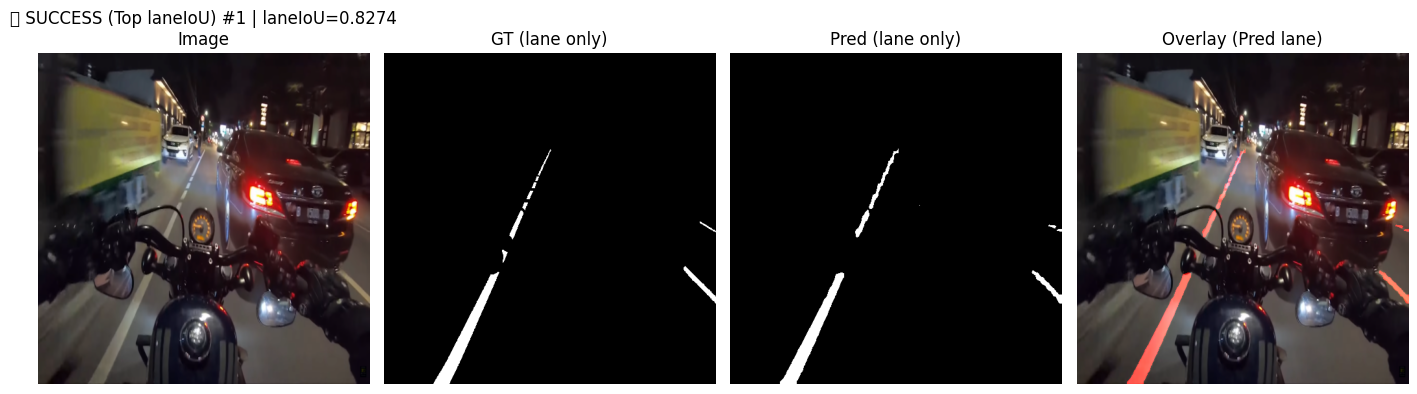

C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\4015832287.py:236: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


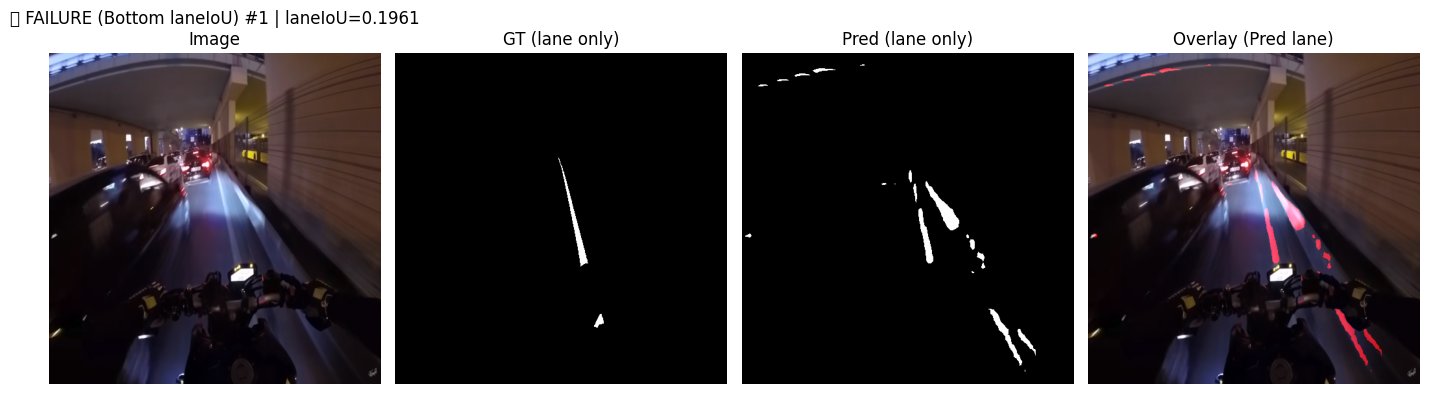

In [343]:
# ============================================================
# ONE-CELL: (1) 5% 유의수준 성능개선 검증 (paired t-test) -> 1%로 변경
#          (2) 성공 3장 / 실패 3장 자동 선택 + 가시화 -> 1장으로 변경
# ------------------------------------------------------------
# ✅ 필요한 것(당신 노트북에 "이미" 있어야 함)
# - test_loader  (또는 val_loader)  : (img, mask, *optional) 배치를 내는 DataLoader
# - NUM_CLASSES  : 클래스 수
# - LANE_TRAIN_ID: lane 클래스 train id (예: 3)
#
# ✅ 아래 "USER SET" 4가지만 채우면 바로 실행됩니다.
# - BASELINE_SUMMARY_JSON 경로
# - LANESPECIAL_SUMMARY_JSON 경로
# - MODEL_BUILDER 함수 (당신이 쓰는 모델 생성 코드 1개)
# - DEVICE / NUM_CLASSES / LANE_TRAIN_ID / test_loader 확인
# ============================================================

import os, json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats

# -------------------------
# USER SET (필수 4개)
# -------------------------
BASELINE_SUMMARY_JSON = r"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260216_174036\baseline_off__crop_45pct\summary.json"
LANESPECIAL_SUMMARY_JSON = r"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260216_202722\laneSpecial__crop_45pct\summary.json"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES   = NUM_CLASSES          # <-- 이미 선언되어 있어야 함
LANE_TRAIN_ID = LANE_TRAIN_ID        # <-- 이미 선언되어 있어야 함 (예: 3)
LOADER        = test_loader          # <-- test_loader가 없으면 val_loader로 바꾸세요

# ✅ 당신이 쓰는 모델 생성 코드를 "여기"에만 넣으세요.
#    (state_dict 로드하기 전에 모델 구조가 같아야 합니다)
def MODEL_BUILDER(num_classes: int):
    # 예시(필요시 교체): torchvision deeplabv3_resnet50
    from torchvision.models.segmentation import deeplabv3_resnet50
    m = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    m.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return m

# -------------------------
# utils
# -------------------------
def load_json(p):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

@torch.no_grad()
def fast_lane_iou(pred_mask: torch.Tensor, gt_mask: torch.Tensor, lane_id: int, eps=1e-6) -> float:
    # pred_mask, gt_mask: (H,W) long
    p = (pred_mask == lane_id)
    g = (gt_mask == lane_id)
    inter = (p & g).sum().item()
    union = (p | g).sum().item()
    return float(inter) / float(union + eps)

def try_get_image_and_mask(batch):
    """
    batch 형태가 (x,y) / (x,y,meta) / dict 등 다양할 수 있어서 최대한 유연하게 처리.
    """
    if isinstance(batch, (list, tuple)):
        x = batch[0]
        y = batch[1]
        return x, y
    if isinstance(batch, dict):
        # 흔한 키 추정
        for kx in ["image", "img", "x"]:
            if kx in batch:
                x = batch[kx]; break
        else:
            raise ValueError("batch(dict)에서 image 키를 못 찾았습니다. batch keys:", batch.keys())
        for ky in ["mask", "y", "label", "target"]:
            if ky in batch:
                y = batch[ky]; break
        else:
            raise ValueError("batch(dict)에서 mask 키를 못 찾았습니다. batch keys:", batch.keys())
        return x, y
    raise ValueError(f"지원하지 않는 batch 타입: {type(batch)}")

def denorm_img(x):
    """
    x: (3,H,W) float tensor, normalize 되어있을 가능성이 높음.
    완벽 복원은 mean/std를 알아야 하지만,
    시각화 목적이라 안전하게 [0,1]로 클램프해서 보여줍니다.
    """
    x = x.detach().float().cpu()
    # 채널별 min/max 기반으로 대충 스케일(보기 좋게)
    cmin = x.amin(dim=(1,2), keepdim=True)
    cmax = x.amax(dim=(1,2), keepdim=True)
    x = (x - cmin) / (cmax - cmin + 1e-6)
    x = x.clamp(0,1)
    return x.permute(1,2,0).numpy()

def colorize_binary(mask_hw: np.ndarray):
    # lane만 강조 (흰색)
    return mask_hw.astype(np.float32)

def overlay_lane_on_img(img_hwc01: np.ndarray, lane_mask_hw: np.ndarray, alpha=0.6):
    # lane_mask_hw: {0,1}
    out = img_hwc01.copy()
    lane = lane_mask_hw.astype(bool)
    # 빨강 채널만 강조 (색 지정 없이 하면 애매해서, 최소한의 표시만)
    out[lane, 0] = np.clip(out[lane, 0] + alpha, 0, 1)
    return out

def load_model_from_ckpt(ckpt_path: str):
    model = MODEL_BUILDER(NUM_CLASSES).to(DEVICE).eval()
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    # state_dict 형태/키가 다를 수 있어 최대한 유연하게
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        sd = ckpt["state_dict"]
    elif isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        sd = ckpt["model_state_dict"]
    elif isinstance(ckpt, dict) and any(k.startswith("classifier") or k.startswith("backbone") for k in ckpt.keys()):
        sd = ckpt
    else:
        # 혹시 전체 모델이 저장된 경우
        if hasattr(ckpt, "state_dict"):
            return ckpt.to(DEVICE).eval()
        raise ValueError(f"체크포인트 포맷을 인식 못했습니다: {type(ckpt)} / keys={list(ckpt.keys())[:10] if isinstance(ckpt, dict) else 'NA'}")

    # 'module.' 제거 (DP/DDP)
    new_sd = {}
    for k,v in sd.items():
        nk = k[7:] if k.startswith("module.") else k
        new_sd[nk] = v
    model.load_state_dict(new_sd, strict=False)
    return model

# ============================================================
# (1) 5% 유의수준 검정 (paired t-test, fold 단위)
# ============================================================
baseline_sum = load_json(BASELINE_SUMMARY_JSON)
lane_sum     = load_json(LANESPECIAL_SUMMARY_JSON)

baseline_scores = np.array(baseline_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)
lane_scores     = np.array(lane_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)

t_stat, p_value = stats.ttest_rel(lane_scores, baseline_scores)

print("\n" + "="*72)
print("[Paired t-test @ alpha=0.05]  (metric = cv_best_laneIoU_per_fold)")
print("- baseline folds:", baseline_scores)
print("- laneSpecial folds:", lane_scores)
print(f"- mean(baseline)   = {baseline_scores.mean():.6f} ± {baseline_scores.std(ddof=1):.6f}")
print(f"- mean(laneSpecial)= {lane_scores.mean():.6f} ± {lane_scores.std(ddof=1):.6f}")
print(f"- t-stat = {t_stat:.6f}")
print(f"- p-value= {p_value:.6g}")
print("✅ 유의한 개선" if (p_value < 0.05) else "❌ 5% 유의수준에서 유의하지 않음")
print("="*72 + "\n")

# ============================================================
# (2) 성공 3장 / 실패 3장 뽑아서 가시화 (laneSpecial best fold model)
# ============================================================
best_model_path = lane_sum.get("best_model_path", None)
if best_model_path is None:
    raise ValueError("LANESPECIAL_SUMMARY_JSON에 'best_model_path'가 없습니다.")
if not os.path.exists(best_model_path):
    # summary에 윈도우 경로(\\)가 들어있을 수 있어 normalize
    best_model_path2 = os.path.normpath(best_model_path)
    if os.path.exists(best_model_path2):
        best_model_path = best_model_path2
    else:
        raise FileNotFoundError(f"best_model_path를 찾을 수 없습니다:\n- {best_model_path}\n- {best_model_path2}")

model = load_model_from_ckpt(best_model_path)

records = []  # (lane_iou, img_np, gt_np, pred_np)

with torch.no_grad():
    for batch in LOADER:
        x, y = try_get_image_and_mask(batch)
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True).long()

        out = model(x)
        # torchvision deeplab은 dict(out) 형태가 흔함
        if isinstance(out, dict) and "out" in out:
            logits = out["out"]
        elif isinstance(out, dict) and "seg" in out:
            logits = out["seg"]
        else:
            logits = out  # (B,C,H,W) 가정

        pred = torch.argmax(logits, dim=1)  # (B,H,W)

        B = x.shape[0]
        for i in range(B):
            lane_iou = fast_lane_iou(pred[i], y[i], LANE_TRAIN_ID)
            img_np = denorm_img(x[i])
            gt_np  = y[i].detach().cpu().numpy()
            pr_np  = pred[i].detach().cpu().numpy()
            records.append((lane_iou, img_np, gt_np, pr_np))

# 정렬해서 top3 / bottom3
records_sorted = sorted(records, key=lambda t: t[0])
worst3 = records_sorted[:1]
best3  = records_sorted[-1:][::-1]

def show_triplet(samples, title):
    n = len(samples)
    plt.figure(figsize=(14, 4*n))
    for r, (iou, img, gt, pr) in enumerate(samples, start=1):
        gt_lane = (gt == LANE_TRAIN_ID).astype(np.uint8)
        pr_lane = (pr == LANE_TRAIN_ID).astype(np.uint8)

        # 1) raw image
        ax1 = plt.subplot(n, 4, (r-1)*4 + 1)
        ax1.imshow(img)
        ax1.set_title(f"{title} #{r} | laneIoU={iou:.4f}\nImage")
        ax1.axis("off")

        # 2) GT lane mask
        ax2 = plt.subplot(n, 4, (r-1)*4 + 2)
        ax2.imshow(colorize_binary(gt_lane), cmap="gray", vmin=0, vmax=1)
        ax2.set_title("GT (lane only)")
        ax2.axis("off")

        # 3) Pred lane mask
        ax3 = plt.subplot(n, 4, (r-1)*4 + 3)
        ax3.imshow(colorize_binary(pr_lane), cmap="gray", vmin=0, vmax=1)
        ax3.set_title("Pred (lane only)")
        ax3.axis("off")

        # 4) Overlay
        ax4 = plt.subplot(n, 4, (r-1)*4 + 4)
        overlay = overlay_lane_on_img(img, pr_lane, alpha=0.7)
        ax4.imshow(overlay)
        ax4.set_title("Overlay (Pred lane)")
        ax4.axis("off")

    plt.tight_layout()
    plt.show()

print(f"[laneSpecial best model] loaded from: {best_model_path}")
print(f"Collected {len(records)} samples from LOADER.")
show_triplet(best3,  "✅ SUCCESS (Top laneIoU)")
show_triplet(worst3, "❌ FAILURE (Bottom laneIoU)")

### 효과 정리
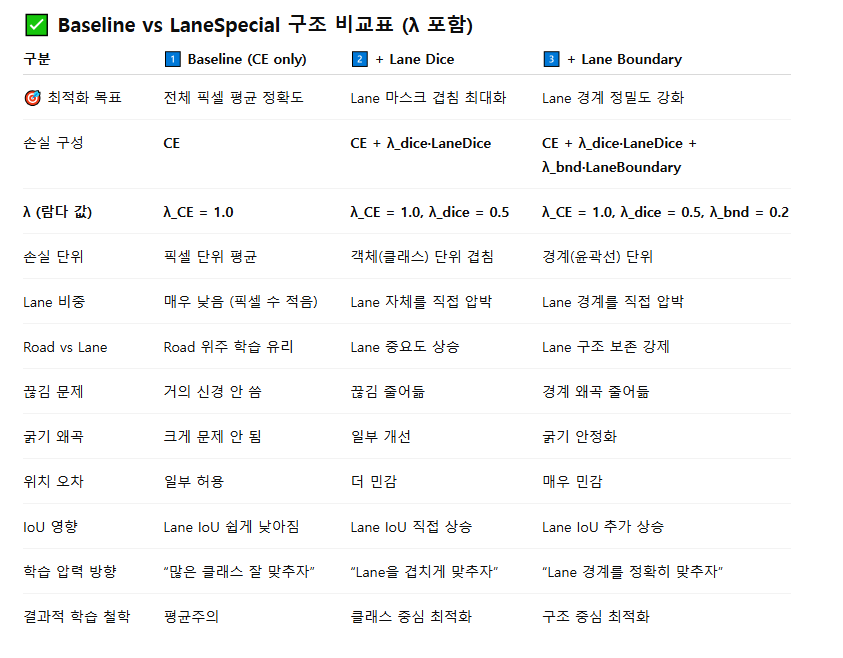
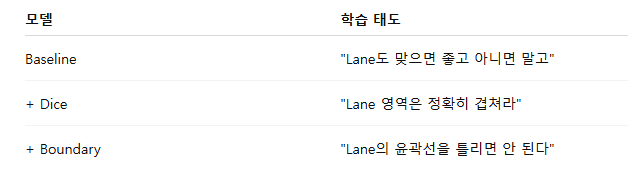
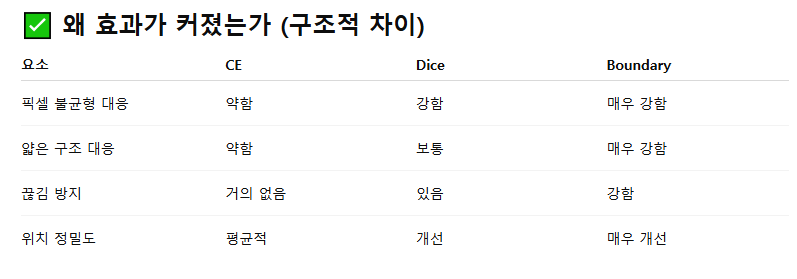

## step 7 추가 Feature Engineering
 - 목표함수(Object) 베이스라인 = Crop 45% + LaneDice + LaneBoundary) 
 - Input Enhancement: 감마, CLAHE 실험

In [394]:
# ==========================================================
# ✅ CELL 1) CONTROL PANEL (Baseline Obj 고정) + Input(Gamma) 1회
# - Baseline(Obj): crop 45% + (CE + LaneDice + LaneBoundary)
# - Input Enhancement: Gamma만 1개 값으로 추가 실험 (sweep 없음)
# ==========================================================

import os, json, time, random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.segmentation import deeplabv3_resnet50

# -----------------------------
# ✅ PATH (본인 환경에 맞게)
# -----------------------------
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ANN_PATH  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

# -----------------------------
# ✅ EXP SETTING
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
NUM_CLASSES = 7

# lane train id (본인 프로젝트에서 쓰던 값으로!)
LANE_TRAIN_ID = 3

# -----------------------------
# ✅ Baseline(Obj) 고정 + Gamma만 비교
# -----------------------------
HP = {
    # === input / feature ===
    "crop_top_pct": 45,            # ✅ 상단에서 45% 컷 (고정)
    "use_gamma": True,             # ✅ Gamma 실험 켜기/끄기
#    "gamma": 0.8,                  # ✅ 야간 밝게: 보통 0.6~0.9 추천 (1.0은 변화 없음)
    "gamma_min": 0.8,
    "gamma_max": 1.2,

    # === optimization ===
    "epochs": 35,
    "lr": 2e-4,
    "wd": 3e-4,
    "batch_size": 4,
    "num_workers": 0,
    "amp": True,
    "grad_clip": 1.0,
    "patience": 5,

    # === objective (Baseline Obj 고정) ===
    "use_lane_dice": True,
    "lane_dice_lambda": 0.5,       # ✅ λ_dice
    "dice_smooth": 1.0,            # ✅ smooth

    "use_lane_boundary": True,
    "lane_boundary_lambda": 0.2,   # ✅ λ_boundary
    "boundary_thick": 2,           # ✅ thick (morph gradient 두께)
}


# -----------------------------
# ✅ 저장 폴더
# -----------------------------
TS = time.strftime("%Y%m%d_%H%M%S")
if HP["use_gamma"]:
    gamma_tag = f"rand_{HP['gamma_min']}-{HP['gamma_max']}"
else:
    gamma_tag = "off"

SAVE_ROOT = rf"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\{TS}\objBase_crop45_gamma_{gamma_tag}"
os.makedirs(SAVE_ROOT, exist_ok=True)


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

# ==========================================================
# ✅ Input Enhancement: Gamma (torchvision TF.adjust_gamma)
# - gamma < 1 : 밝게
# - gamma > 1 : 어둡게
# ==========================================================
def apply_gamma_tensor(img_tensor_0_1, gamma: float):
    # img_tensor_0_1: (3,H,W), [0,1]
    return TF.adjust_gamma(img_tensor_0_1, gamma=gamma, gain=1.0)

# ==========================================================
# ✅ Lane Dice
# ==========================================================
def lane_dice_loss(logits, y, lane_id=LANE_TRAIN_ID, smooth=1.0):
    # logits: (B,C,H,W), y: (B,H,W)
    prob = torch.softmax(logits, dim=1)[:, lane_id]  # (B,H,W)
    gt   = (y == lane_id).float()                    # (B,H,W)

    # dice = 2*|P∩G| / (|P|+|G|)
    inter = (prob * gt).sum(dim=(1,2))
    denom = prob.sum(dim=(1,2)) + gt.sum(dim=(1,2))
    dice  = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

# ==========================================================
# ✅ Lane Boundary Loss (morph gradient 기반)
# - 얇고 긴 lane에서 경계 정렬 압박
# ==========================================================
def morph_gradient(mask01, thick=2):
    # mask01: (B,1,H,W) in {0,1}
    # dilation - erosion (maxpool 이용)
    k = 2*thick + 1
    pad = thick
    dil = F.max_pool2d(mask01, kernel_size=k, stride=1, padding=pad)
    ero = -F.max_pool2d(-mask01, kernel_size=k, stride=1, padding=pad)
    return (dil - ero).clamp(0, 1)

def lane_boundary_loss(logits, y, lane_id=LANE_TRAIN_ID, thick=2, smooth=1.0):
    prob = torch.softmax(logits, dim=1)[:, lane_id:lane_id+1]   # (B,1,H,W)
    gt   = (y == lane_id).float().unsqueeze(1)                  # (B,1,H,W)

    pb = morph_gradient(prob, thick=thick)
    gb = morph_gradient(gt,   thick=thick)

    inter = (pb * gb).sum(dim=(1,2,3))
    denom = pb.sum(dim=(1,2,3)) + gb.sum(dim=(1,2,3))
    dice  = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

# ==========================================================
# ✅ total loss pack
# ==========================================================
def total_loss(logits, y, ce_criterion, hp=HP):
    loss = ce_criterion(logits, y)

    logs = {"ce": float(loss.detach().cpu())}

    if hp["use_lane_dice"]:
        ld = lane_dice_loss(logits, y, lane_id=LANE_TRAIN_ID, smooth=hp["dice_smooth"])
        loss = loss + hp["lane_dice_lambda"] * ld
        logs["lane_dice"] = float(ld.detach().cpu())
        logs["w_lane_dice"] = hp["lane_dice_lambda"]

    if hp["use_lane_boundary"]:
        lb = lane_boundary_loss(logits, y, lane_id=LANE_TRAIN_ID, thick=hp["boundary_thick"], smooth=hp["dice_smooth"])
        loss = loss + hp["lane_boundary_lambda"] * lb
        logs["lane_boundary"] = float(lb.detach().cpu())
        logs["w_lane_boundary"] = hp["lane_boundary_lambda"]
        logs["boundary_thick"] = hp["boundary_thick"]

    return loss, logs

print("SAVE_ROOT:", SAVE_ROOT)
print("DEVICE:", DEVICE)
print("HP:", HP)

SAVE_ROOT: D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260217_065101\objBase_crop45_gamma_rand_0.8-1.2
DEVICE: cuda
HP: {'crop_top_pct': 45, 'use_gamma': True, 'gamma_min': 0.8, 'gamma_max': 1.2, 'epochs': 35, 'lr': 0.0002, 'wd': 0.0003, 'batch_size': 4, 'num_workers': 0, 'amp': True, 'grad_clip': 1.0, 'patience': 5, 'use_lane_dice': True, 'lane_dice_lambda': 0.5, 'dice_smooth': 1.0, 'use_lane_boundary': True, 'lane_boundary_lambda': 0.2, 'boundary_thick': 2}


In [396]:
# ==========================================================
# ✅ CELL 2) COCO 로드 + Dataset/DataLoader + KFold split
# - COCO instance/pixel -> semantic mask (H,W) train_id
# - crop_top_pct=45 고정
# - gamma는 train에서만 적용 (val/test는 OFF)
# ==========================================================

import json
from collections import defaultdict
from pycocotools.coco import COCO
from sklearn.model_selection import KFold

coco = COCO(ANN_PATH)
all_img_ids = list(coco.imgs.keys())
print("num_images:", len(all_img_ids))

# ----------------------------------------------------------
# ✅ id2train (본인 프로젝트에서 쓰던 매핑과 동일해야 함)
#    - 아래는 "그냥 예시"입니다.
#    - 이미 노트북에 id2train이 있으면, 이 블록은 지우고 그걸 쓰세요.
# ----------------------------------------------------------
if "id2train" not in globals():
    # COCO category id -> train id
    # !!! 반드시 본인 프로젝트 매핑과 일치시키세요 !!!
    # categories 확인:
    cats = coco.loadCats(coco.getCatIds())
    print("COCO categories:", [(c["id"], c.get("name","")) for c in cats])

    # 예시: category_id를 1..NUM_CLASSES-1로 매핑한다고 가정
    # (실제와 다르면 반드시 수정)
    id2train = {c["id"]: min(c["id"], NUM_CLASSES-1) for c in cats}
    id2train[0] = 0

print("id2train sample:", list(id2train.items())[:10])

# ----------------------------------------------------------
# ✅ helper: semantic mask 생성
# ----------------------------------------------------------
def build_semantic_mask(coco, img_id, id2train):
    info = coco.loadImgs([img_id])[0]
    H, W = info["height"], info["width"]
    mask = np.zeros((H, W), dtype=np.uint8)

    ann_ids = coco.getAnnIds(imgIds=[img_id])
    anns = coco.loadAnns(ann_ids)

    # 덮어쓰기: annotation 순서대로 (필요하면 priority로 바꾸세요)
    for a in anns:
        cat_id = a["category_id"]
        train_id = id2train.get(cat_id, 0)
        m = coco.annToMask(a)  # (H,W) {0,1}
        mask[m == 1] = train_id

    return mask  # (H,W) uint8

# ----------------------------------------------------------
# ✅ dataset
# ----------------------------------------------------------
class SemSegDS(Dataset):
    def __init__(self, coco, img_dir, img_ids, id2train, train=True, hp=HP):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.train = train
        self.hp = hp

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        img = Image.open(img_path).convert("RGB")
        mask = build_semantic_mask(self.coco, img_id, self.id2train)  # (H,W) uint8

        # --- to tensor [0,1]
        x = TF.to_tensor(img)                 # (3,H,W) float32 [0,1]
        y = torch.from_numpy(mask).long()     # (H,W)

        # ==================================================
        # ✅ Crop: 상단에서 45% 컷 (고정)
        # ==================================================
        pct = self.hp["crop_top_pct"]
        H = y.shape[0]
        top_cut = int(H * (pct / 100.0))
        x = x[:, top_cut:, :]
        y = y[top_cut:, :]

        # ==================================================
        # ✅ Gamma: train에서만 적용 (val/test는 OFF)
        # ==================================================
        # if self.train and self.hp["use_gamma"]:
        #     x = apply_gamma_tensor(x, gamma=float(self.hp["gamma"]))

        if self.train and self.hp["use_gamma"]:
            g = random.uniform(self.hp["gamma_min"], self.hp["gamma_max"])
            x = apply_gamma_tensor(x, gamma=float(g))


        # Normalize (ImageNet)
        x = TF.normalize(x, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

        return x, y, img_id, info["file_name"]

# ----------------------------------------------------------
# ✅ KFold split
# ----------------------------------------------------------
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=SEED)

folds = []
for fold_idx, (tr_idx, va_idx) in enumerate(kf.split(all_img_ids), start=1):
    tr_ids = [all_img_ids[i] for i in tr_idx]
    va_ids = [all_img_ids[i] for i in va_idx]
    folds.append((tr_ids, va_ids))

print("K folds ready:", len(folds))
print("fold1 sizes:", len(folds[0][0]), len(folds[0][1]))

loading annotations into memory...
Done (t=1.13s)
creating index...
index created!
num_images: 200
id2train sample: [(1323880, 1), (1323881, 2), (1323882, 3), (1323884, 4), (1323885, 5), (1329681, 6)]
K folds ready: 5
fold1 sizes: 160 40


In [398]:
# ==========================================================
# ✅ CELL 3) KFold 학습 + fold별 best laneIoU 저장
# - 모델: DeepLabV3 ResNet50 backbone pretrained
# - loss: CE + λ*LaneDice + λ*LaneBoundary (Obj base 고정)
# - metric: laneIoU, mIoU(no-bg)
# - best_fold_model 저장 + summary.json 생성
# ==========================================================

from torch.cuda.amp import autocast, GradScaler

def build_model(num_classes=NUM_CLASSES):
    model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model

@torch.no_grad()
def compute_iou_per_class(pred, y, num_classes=NUM_CLASSES):
    # pred, y: (H,W) long
    ious = []
    for c in range(num_classes):
        p = (pred == c)
        g = (y == c)
        inter = (p & g).sum().item()
        union = (p | g).sum().item()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(inter / union)
    return ious

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses = []
    lane_ious = []
    miou_nobg = []

    ce_criterion = nn.CrossEntropyLoss()

    for x, y, *_ in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        out = model(x)["out"]   # (B,C,H,W)

        loss, _logs = total_loss(out, y, ce_criterion, hp=HP)
        losses.append(float(loss.detach().cpu()))

        pred = out.argmax(1)    # (B,H,W)
        for b in range(pred.shape[0]):
            ious = compute_iou_per_class(pred[b].cpu(), y[b].cpu(), num_classes=NUM_CLASSES)
            lane_ious.append(ious[LANE_TRAIN_ID])

            # mIoU(no-bg): class 1..C-1
            valid = [v for i,v in enumerate(ious) if i != 0 and np.isfinite(v)]
            miou_nobg.append(float(np.mean(valid)) if len(valid) else np.nan)

    return {
        "loss": float(np.mean(losses)),
        "laneIoU": float(np.nanmean(lane_ious)),
        "mIoU_no_bg": float(np.nanmean(miou_nobg)),
    }

def train_one_fold(fold_idx, train_ids, val_ids):
    train_ds = SemSegDS(coco, IMG_DIR, train_ids, id2train, train=True,  hp=HP)
    val_ds   = SemSegDS(coco, IMG_DIR, val_ids,   id2train, train=False, hp=HP)

    train_loader = DataLoader(train_ds, batch_size=HP["batch_size"], shuffle=True,
                              num_workers=HP["num_workers"], pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False,
                              num_workers=HP["num_workers"], pin_memory=True)

    model = build_model().to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=HP["lr"], weight_decay=HP["wd"])
    scaler = GradScaler(enabled=HP["amp"])
    ce_criterion = nn.CrossEntropyLoss()

    best_lane = -1
    best_epoch = -1
    best_path = None
    patience = 0
    stop_epoch = HP["epochs"]

    for ep in range(1, HP["epochs"]+1):
        model.train()
        for x, y, *_ in train_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            optim.zero_grad(set_to_none=True)
            with autocast(enabled=HP["amp"]):
                logits = model(x)["out"]
                loss, _logs = total_loss(logits, y, ce_criterion, hp=HP)

            scaler.scale(loss).backward()
            if HP["grad_clip"] and HP["grad_clip"] > 0:
                scaler.unscale_(optim)
                torch.nn.utils.clip_grad_norm_(model.parameters(), HP["grad_clip"])
            scaler.step(optim)
            scaler.update()

        # --- val
        met = evaluate(model, val_loader)
        lane = met["laneIoU"]

        if lane > best_lane:
            best_lane = lane
            best_epoch = ep
            patience = 0

            best_path = os.path.join(SAVE_ROOT, f"fold{fold_idx}_best.pth")
            torch.save({"model": model.state_dict(), "hp": HP, "fold": fold_idx}, best_path)
        else:
            patience += 1
            if patience >= HP["patience"]:
                stop_epoch = ep
                break

        print(f"[fold {fold_idx}][{ep:02d}] val_loss={met['loss']:.4f} laneIoU={met['laneIoU']:.4f} mIoU(no-bg)={met['mIoU_no_bg']:.4f}"
              f" | best_lane={best_lane:.4f}@{best_epoch}")

    return {
        "best_laneIoU": float(best_lane),
        "best_epoch": int(best_epoch),
        "stop_epoch": int(stop_epoch),
        "best_model_path": best_path,
    }

# -----------------------------
# ✅ run kfold
# -----------------------------
cv_best_lane = []
cv_best_epoch = []
cv_stop_epoch = []
best_fold = -1
best_fold_lane = -1
best_model_path = None

for i, (tr_ids, va_ids) in enumerate(folds, start=1):
    out = train_one_fold(i, tr_ids, va_ids)
    cv_best_lane.append(out["best_laneIoU"])
    cv_best_epoch.append(out["best_epoch"])
    cv_stop_epoch.append(out["stop_epoch"])

    if out["best_laneIoU"] > best_fold_lane:
        best_fold_lane = out["best_laneIoU"]
        best_fold = i
        best_model_path = out["best_model_path"]

summary = {
    "crop_pct": HP["crop_top_pct"],
    "gamma_on": bool(HP["use_gamma"]),
    "gamma": float(HP["gamma"]) if HP["use_gamma"] else None,

    "cv_best_laneIoU_per_fold": cv_best_lane,
    "cv_best_epoch_per_fold": cv_best_epoch,
    "cv_stop_epoch_per_fold": cv_stop_epoch,

    "cv_mean_laneIoU": float(np.mean(cv_best_lane)),
    "cv_std_laneIoU": float(np.std(cv_best_lane, ddof=0)),

    "best_fold": int(best_fold),
    "best_model_path": best_model_path,

    "hp_snapshot": HP,
    "save_dir": SAVE_ROOT,
}

sum_path = os.path.join(SAVE_ROOT, "summary.json")
with open(sum_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("\n✅ saved:", sum_path)
print("summary keys:", summary.keys())
print("cv_best_laneIoU_per_fold:", summary["cv_best_laneIoU_per_fold"])

C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\2951803717.py:75: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=HP["amp"])
C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\2951803717.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=HP["amp"]):


[fold 1][01] val_loss=0.9827 laneIoU=0.2842 mIoU(no-bg)=0.5693 | best_lane=0.2842@1
[fold 1][02] val_loss=0.7510 laneIoU=0.3953 mIoU(no-bg)=0.6343 | best_lane=0.3953@2
[fold 1][03] val_loss=0.6513 laneIoU=0.4407 mIoU(no-bg)=0.6696 | best_lane=0.4407@3
[fold 1][04] val_loss=0.6491 laneIoU=0.4160 mIoU(no-bg)=0.6844 | best_lane=0.4407@3
[fold 1][05] val_loss=0.6429 laneIoU=0.4699 mIoU(no-bg)=0.6715 | best_lane=0.4699@5
[fold 1][06] val_loss=0.6118 laneIoU=0.4738 mIoU(no-bg)=0.6907 | best_lane=0.4738@6
[fold 1][07] val_loss=0.5897 laneIoU=0.4839 mIoU(no-bg)=0.6910 | best_lane=0.4839@7
[fold 1][08] val_loss=0.6148 laneIoU=0.4944 mIoU(no-bg)=0.6751 | best_lane=0.4944@8
[fold 1][09] val_loss=0.5495 laneIoU=0.5125 mIoU(no-bg)=0.7157 | best_lane=0.5125@9
[fold 1][10] val_loss=0.5498 laneIoU=0.5041 mIoU(no-bg)=0.7246 | best_lane=0.5125@9
[fold 1][11] val_loss=0.5763 laneIoU=0.5205 mIoU(no-bg)=0.6924 | best_lane=0.5205@11
[fold 1][12] val_loss=0.5569 laneIoU=0.5325 mIoU(no-bg)=0.7264 | best_lane=

KeyError: 'gamma'

In [410]:
import os, json, numpy as np

def _gamma_summary_fields(hp: dict):
    if not bool(hp.get("use_gamma", False)):
        return {"gamma_on": False, "gamma_mode": "off", "gamma": None, "gamma_min": None, "gamma_max": None}
    if "gamma" in hp:
        return {"gamma_on": True, "gamma_mode": "fixed", "gamma": float(hp["gamma"]), "gamma_min": None, "gamma_max": None}
    if ("gamma_min" in hp) and ("gamma_max" in hp):
        return {"gamma_on": True, "gamma_mode": "rand", "gamma": None, "gamma_min": float(hp["gamma_min"]), "gamma_max": float(hp["gamma_max"])}
    return {"gamma_on": True, "gamma_mode": "unknown", "gamma": None, "gamma_min": None, "gamma_max": None}


gamma_fields = _gamma_summary_fields(HP)

summary = {
    "crop_pct": float(HP["crop_top_pct"]),

    # gamma info (fixed/rand 모두 대응)
    **gamma_fields,

    "cv_best_laneIoU_per_fold": cv_best_lane,
    "cv_best_epoch_per_fold": cv_best_epoch,
    "cv_stop_epoch_per_fold": cv_stop_epoch,

    "cv_mean_laneIoU": float(np.mean(cv_best_lane)),
    "cv_std_laneIoU": float(np.std(cv_best_lane, ddof=0)),

    "best_fold": int(best_fold),
    "best_model_path": best_model_path,

    "hp_snapshot": HP,
    "save_dir": SAVE_ROOT,
}

sum_path = os.path.join(SAVE_ROOT, "summary.json")
with open(sum_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("\n✅ saved:", sum_path)
print("gamma_fields:", gamma_fields)
print("cv_best_laneIoU_per_fold:", summary["cv_best_laneIoU_per_fold"])
print("best_fold:", summary["best_fold"], "| best_model_path:", summary["best_model_path"])


✅ saved: D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260217_065101\objBase_crop45_gamma_rand_0.8-1.2\summary.json
gamma_fields: {'gamma_on': True, 'gamma_mode': 'rand', 'gamma': None, 'gamma_min': 0.8, 'gamma_max': 1.2}
cv_best_laneIoU_per_fold: [0.5394799246420277, 0.5199514896200241, 0.4668992719214721, 0.5145674877453723, 0.5266533440564121]
best_fold: 1 | best_model_path: D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260217_065101\objBase_crop45_gamma_rand_0.8-1.2\fold1_best.pth


[Paired t-test] metric=cv_best_laneIoU_per_fold
- baseline(Obj base) folds: [0.55668432 0.43839952 0.52845818 0.53746802 0.62556899]
- exp folds:               [0.53947992 0.51995149 0.46689927 0.51456749 0.52665334]
- mean(baseline) = 0.537316 ± 0.060044
- mean(exp)      = 0.513510 ± 0.024748
- t-stat = -0.788897
- p-value= 0.474300669
=> 유의수준 5% 개선? NO
=> 유의수준 1% 개선? NO

[CLAHE best fold] 1 path: D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260217_010917\objBase_crop45_clahe_on_clip2.0_tile8\fold1_best.pth

[FAIL 3]
laneIoU= 0.00039949777422668647 | night ride (17).png

[SUCCESS 3]
laneIoU= nan | night ride (77).png


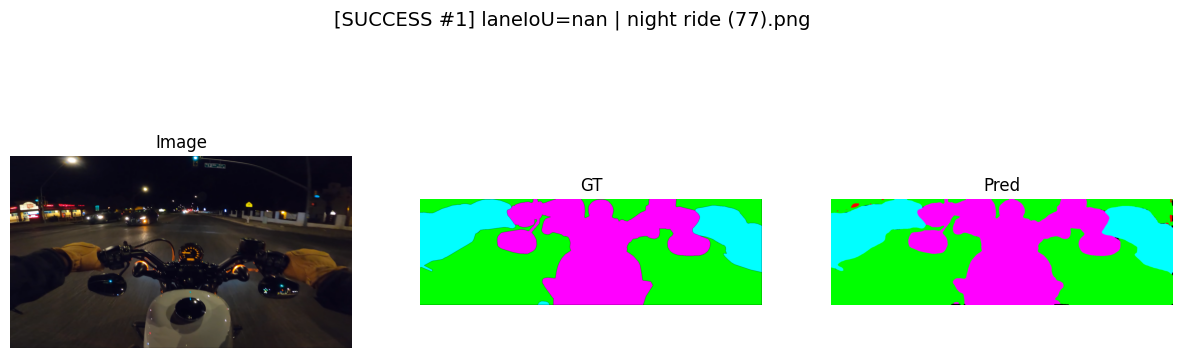

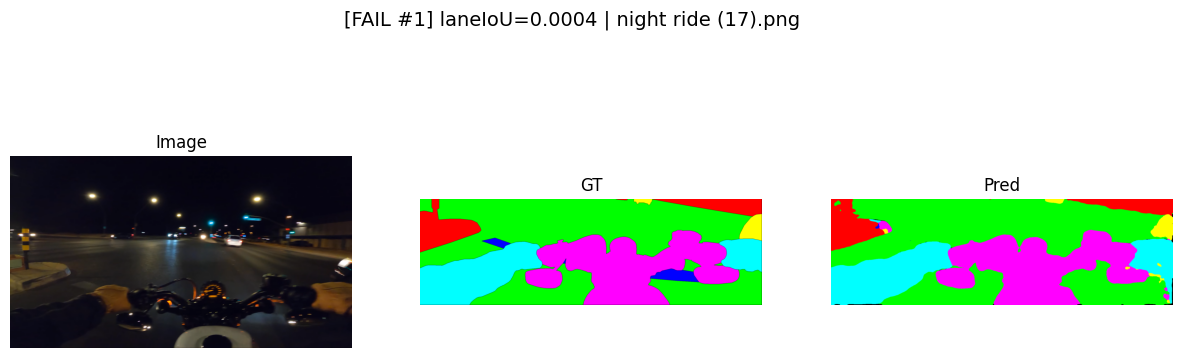

In [412]:
# ==========================================================
# ✅ CELL 4) (1) paired t-test @ alpha=0.01  (1% 유의수준)
#         (2) 성공 1 / 실패 1 가시화 (best_fold 모델로)
# - success/fail 기준: "이미지별 laneIoU" 상위 1 / 하위 1
# - 비교 대상: EXP(예: gamma/clahe) vs baseline(Obj base)
# - ✅ NaN 제거 + GT에 lane이 0픽셀인 샘플 제거(평가 안정화)
# ==========================================================

import os, json
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats

# ----------------------------------------------------------
# ✅ (A) summary.json 경로 2개만 정확히 넣으세요
# ----------------------------------------------------------
BASELINE_SUMMARY_JSON = r"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260216_202722\laneSpecial__crop_45pct\summary.json"  # Obj base
EXP_SUMMARY_JSON      = os.path.join(SAVE_ROOT, "summary.json")  # 예: gamma/clahe 실험 save_root

# ----------------------------------------------------------
# ✅ (B) 이 셀은 "당신 노트북에 이미 존재"해야 정상 작동
# ----------------------------------------------------------
# - DEVICE, NUM_CLASSES, LANE_TRAIN_ID
# - IMG_DIR, coco, id2train, folds
# - build_model() : 학습 때 쓴 모델 구조 동일
# - SemSegDS      : val dataset class (ds[i] -> (x,y,img_id,fname))
# - compute_iou_per_class(pred, gt, num_classes) -> per-class IoU(list/np)
# ----------------------------------------------------------

def load_json(p):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

def _finite(x):
    return np.isfinite(x)

# -------------------------
# (1) paired t-test (alpha=0.01)
# -------------------------
base_sum = load_json(BASELINE_SUMMARY_JSON)
exp_sum  = load_json(EXP_SUMMARY_JSON)

base_scores = np.array(base_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)
exp_scores  = np.array(exp_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)

t_stat, p_value = stats.ttest_rel(exp_scores, base_scores)

print(f"[Paired t-test] metric=cv_best_laneIoU_per_fold")
print(f"- baseline(Obj base) folds: {base_scores}")
print(f"- exp folds:               {exp_scores}")
print(f"- mean(baseline) = {base_scores.mean():.6f} ± {base_scores.std(ddof=0):.6f}")
print(f"- mean(exp)      = {exp_scores.mean():.6f} ± {exp_scores.std(ddof=0):.6f}")
print(f"- t-stat = {t_stat:.6f}")
print(f"- p-value= {p_value:.9f}")
print("=> 유의수준 5% 개선?", "YES" if p_value < 0.05 else "NO")
print("=> 유의수준 1% 개선?", "YES" if p_value < 0.01 else "NO")

# ----------------------------------------------------------
# ✅ (B) best_fold 모델 로드 + 해당 fold의 val set에서 success/fail 3장 추출/시각화
# 특징

# ✔ summary.json의 best_fold 사용
# ✔ 그 fold의 validation id만 사용
# ✔ 해당 fold 모델로 그 fold 데이터만 평가
# 즉
# CV 실험 구조를 정확히 따름
# “그 실험에서 best라고 판단된 fold의 검증셋 기준”

# 장점
# 논문 스타일 평가에 적합
# CV 구조를 정확히 반영
# 통계적 일관성 유지

# 단점
# 전체 데이터 관점은 아님
# 다른 fold는 반영 안 됨
# ----------------------------------------------------------
def load_best_model(path):
    ckpt = torch.load(path, map_location="cpu")
    model = build_model().to(DEVICE)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()
    return model

@torch.no_grad()
def per_image_lane_iou(model, ds):
    scores = []
    for i in range(len(ds)):
        x, y, img_id, fname = ds[i]
        x = x.unsqueeze(0).to(DEVICE)
        y = y.to(DEVICE)

        out = model(x)["out"].squeeze(0)  # (C,H,W)
        pred = out.argmax(0).cpu()

        ious = compute_iou_per_class(pred, y.cpu(), num_classes=NUM_CLASSES)
        lane = ious[LANE_TRAIN_ID]
        scores.append((lane, i, img_id, fname, pred, y.cpu()))
    return scores

def colorize_mask(mask, num_classes=NUM_CLASSES):
    palette = np.array([
        [0,0,0],
        [255,0,0],
        [0,255,0],
        [0,0,255],
        [255,255,0],
        [255,0,255],
        [0,255,255],
        [255,128,0],
    ], dtype=np.uint8)
    m = mask.numpy().astype(np.int64)
    m = np.clip(m, 0, len(palette)-1)
    return palette[m]

def show_triplet(img_path, gt_mask, pred_mask, title):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    gt_rgb   = colorize_mask(gt_mask)
    pred_rgb = colorize_mask(pred_mask)

    plt.figure(figsize=(15,5))
    plt.suptitle(title, fontsize=14)

    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img_np); plt.axis("off")
    plt.subplot(1,3,2); plt.title("GT");    plt.imshow(gt_rgb); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Pred");  plt.imshow(pred_rgb); plt.axis("off")
    plt.show()

# ---- clahe best fold로 뽑기
best_fold = int(clahe_sum["best_fold"])
best_model_path = clahe_sum["best_model_path"]
print("\n[CLAHE best fold]", best_fold, "path:", best_model_path)

# 해당 fold의 val ids 가져오기
tr_ids, va_ids = folds[best_fold-1]
val_ds = SemSegDS(coco, IMG_DIR, va_ids, id2train, train=False, hp=HP)

model = load_best_model(best_model_path)

scores = per_image_lane_iou(model, val_ds)
scores_sorted = sorted(scores, key=lambda x: (np.inf if np.isnan(x[0]) else x[0]))

### 성공 및 실패 이미지 3 -> 1개로 줄임
fails = scores_sorted[:1]
succs = scores_sorted[-1:][::-1]

print("\n[FAIL 3]")
for s in fails:
    print("laneIoU=", s[0], "|", s[3])

print("\n[SUCCESS 3]")
for s in succs:
    print("laneIoU=", s[0], "|", s[3])

# ---- 시각화
for rank, (lane, idx, img_id, fname, pred, gt) in enumerate(succs, start=1):
    img_path = os.path.join(IMG_DIR, fname)
    show_triplet(img_path, gt, pred, title=f"[SUCCESS #{rank}] laneIoU={lane:.4f} | {fname}")

for rank, (lane, idx, img_id, fname, pred, gt) in enumerate(fails, start=1):
    img_path = os.path.join(IMG_DIR, fname)
    show_triplet(img_path, gt, pred, title=f"[FAIL #{rank}] laneIoU={lane:.4f} | {fname}")


[Paired t-test @ alpha=0.01]  metric=cv_best_laneIoU_per_fold
- baseline folds: [0.55668432 0.43839952 0.52845818 0.53746802 0.62556899]
- exp folds     : [0.53947992 0.51995149 0.46689927 0.51456749 0.52665334]
- mean(baseline) = 0.537316 ± 0.067132
- mean(exp)      = 0.513510 ± 0.027669
- t-stat = -0.788897
- p-value= 0.474300669
❌ 유의수준에서 개선 아님

[EXP best model] loaded from: D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260217_065101\objBase_crop45_gamma_rand_0.8-1.2\fold1_best.pth
Collected 20 samples from LOADER.


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\3995607332.py:248: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


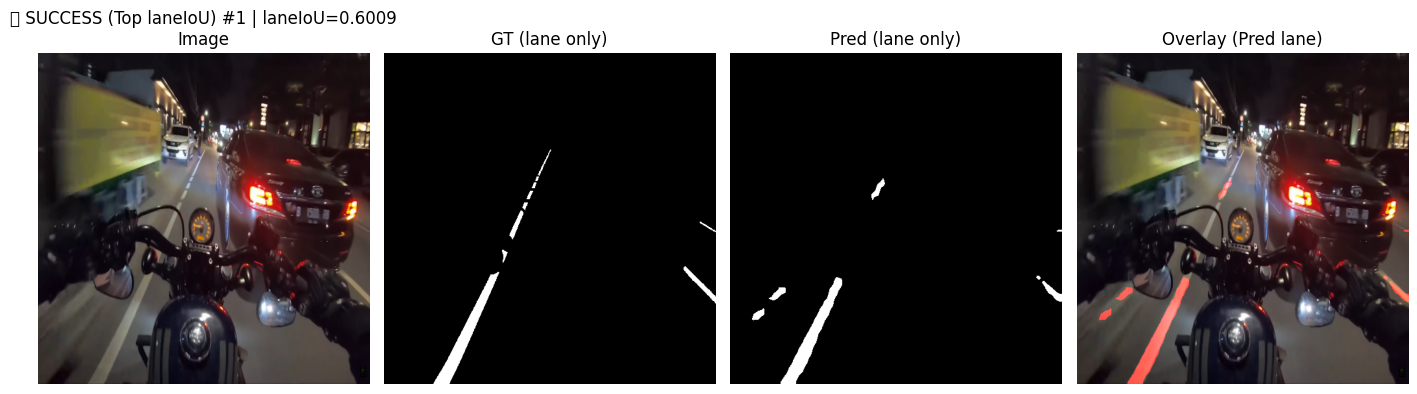

C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\3995607332.py:248: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


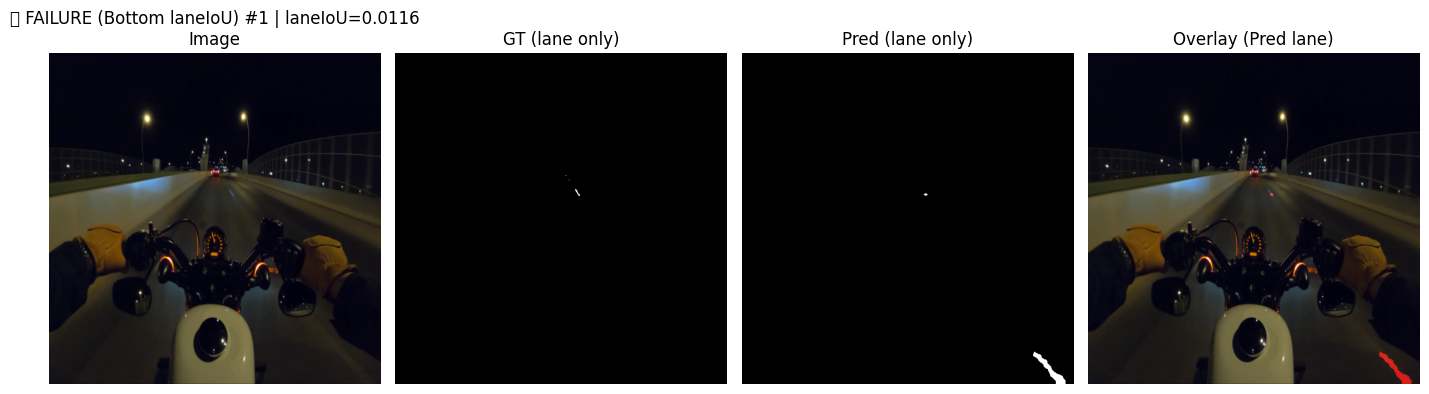

In [414]:
# ============================================================
# ✅ ONE-CELL: (1) paired t-test @ alpha=0.01 (1% 유의수준)
#            (2) best_fold 모델로 "LOADER에서" laneIoU 기준
#                ✅ 성공 1장 / ❌ 실패 1장  (요청하신 4-칸 triplet 스타일)
# ------------------------------------------------------------
# ✅ 필요한 것(이미 노트북에 있어야 함)
# - LOADER: test_loader 또는 val_loader (batch -> (x,y,...) 또는 dict)
# - DEVICE, NUM_CLASSES, LANE_TRAIN_ID
# - MODEL_BUILDER(num_classes)  : 모델 구조 생성 함수 1개 (deeplabv3p 등)
# - BASELINE_SUMMARY_JSON, EXP_SUMMARY_JSON (summary.json 2개)
# ============================================================

import os, json
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

# -------------------------
# USER SET (필수 4개)
# -------------------------
BASELINE_SUMMARY_JSON = r"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260216_202722\laneSpecial__crop_45pct\summary.json"
EXP_SUMMARY_JSON      = os.path.join(SAVE_ROOT, "summary.json")   # gamma/clahe 실험 summary.json
ALPHA = 0.01

# LOADER는 test_loader 없으면 val_loader로 바꿔 쓰세요
LOADER = test_loader
LOADER = LOADER  # <-- 이미 만들어둔 변수가 LOADER라면 그대로. 아니면 위 줄 주석 풀고 바꾸세요.

DEVICE = DEVICE  # 이미 정의돼 있어야 함
NUM_CLASSES = NUM_CLASSES
LANE_TRAIN_ID = LANE_TRAIN_ID

# ✅ 당신이 쓰는 모델 생성 코드를 여기에만 넣으세요.
def MODEL_BUILDER(num_classes: int):
    from torchvision.models.segmentation import deeplabv3_resnet50
    m = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    m.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return m

# -------------------------
# utils
# -------------------------
def load_json(p):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

def try_get_image_and_mask(batch):
    if isinstance(batch, (list, tuple)):
        return batch[0], batch[1]
    if isinstance(batch, dict):
        # image key
        for kx in ["image", "img", "x"]:
            if kx in batch:
                x = batch[kx]; break
        else:
            raise ValueError(f"batch(dict)에서 image 키를 못 찾음. keys={list(batch.keys())}")
        # mask key
        for ky in ["mask", "y", "label", "target"]:
            if ky in batch:
                y = batch[ky]; break
        else:
            raise ValueError(f"batch(dict)에서 mask 키를 못 찾음. keys={list(batch.keys())}")
        return x, y
    raise ValueError(f"지원하지 않는 batch 타입: {type(batch)}")

@torch.no_grad()
def fast_lane_iou(pred_mask: torch.Tensor, gt_mask: torch.Tensor, lane_id: int, eps=1e-6) -> float:
    p = (pred_mask == lane_id)
    g = (gt_mask == lane_id)
    inter = (p & g).sum().item()
    union = (p | g).sum().item()
    return float(inter) / float(union + eps)

def denorm_img(x):
    # x: (3,H,W) tensor -> (H,W,3) numpy [0,1]
    x = x.detach().float().cpu()
    cmin = x.amin(dim=(1,2), keepdim=True)
    cmax = x.amax(dim=(1,2), keepdim=True)
    x = (x - cmin) / (cmax - cmin + 1e-6)
    x = x.clamp(0,1)
    return x.permute(1,2,0).numpy()

def colorize_binary(mask_hw: np.ndarray):
    return mask_hw.astype(np.float32)

def overlay_lane_on_img(img_hwc01: np.ndarray, lane_mask_hw: np.ndarray, alpha=0.6):
    out = img_hwc01.copy()
    lane = lane_mask_hw.astype(bool)
    out[lane, 0] = np.clip(out[lane, 0] + alpha, 0, 1)  # red-ish 강조
    return out

def load_model_from_ckpt(ckpt_path: str):
    ckpt_path = os.path.normpath(ckpt_path)
    model = MODEL_BUILDER(NUM_CLASSES).to(DEVICE).eval()
    ckpt = torch.load(ckpt_path, map_location=DEVICE)

    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        sd = ckpt["state_dict"]
    elif isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        sd = ckpt["model_state_dict"]
    elif isinstance(ckpt, dict) and "model" in ckpt:
        sd = ckpt["model"]
    elif isinstance(ckpt, dict):
        sd = ckpt
    else:
        # 전체 모델 저장인 경우
        if hasattr(ckpt, "state_dict"):
            return ckpt.to(DEVICE).eval()
        raise ValueError(f"체크포인트 포맷을 인식 못함: type={type(ckpt)}")

    new_sd = {}
    for k, v in sd.items():
        nk = k[7:] if k.startswith("module.") else k
        new_sd[nk] = v

    model.load_state_dict(new_sd, strict=False)
    return model

# ============================================================
# (1) paired t-test @ alpha=0.01
# ============================================================
base_sum = load_json(BASELINE_SUMMARY_JSON)
exp_sum  = load_json(EXP_SUMMARY_JSON)

baseline_scores = np.array(base_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)
exp_scores      = np.array(exp_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)

t_stat, p_value = stats.ttest_rel(exp_scores, baseline_scores)

print("\n" + "="*72)
print(f"[Paired t-test @ alpha={ALPHA}]  metric=cv_best_laneIoU_per_fold")
print("- baseline folds:", baseline_scores)
print("- exp folds     :", exp_scores)
print(f"- mean(baseline) = {baseline_scores.mean():.6f} ± {baseline_scores.std(ddof=1):.6f}")
print(f"- mean(exp)      = {exp_scores.mean():.6f} ± {exp_scores.std(ddof=1):.6f}")
print(f"- t-stat = {t_stat:.6f}")
print(f"- p-value= {p_value:.9f}")
print("✅ 유의한 개선" if (p_value < ALPHA) else "❌ 유의수준에서 개선 아님")
print("="*72 + "\n")

# ============================================================
# (2) EXP best_fold 모델로 LOADER 전체에서 per-image laneIoU 계산
#     -> 성공 1장 / 실패 1장 (요청하신 4칸 가시화)

# 특징
# ✔ LOADER 전체를 한 번 쭉 돌면서
# ✔ 각 이미지의 laneIoU를 직접 계산
# ✔ 그걸 정렬해서 top / bottom을 고름

# 즉
# 데이터셋 전체 기준 절대 순위
# fold 개념 없음
# summary.json의 best_fold와 무관
# test_loader / val_loader 아무거나 가능

# 장점
# 전체 데이터에서 진짜 최고/최악을 고름
# 단순하고 직관적
# 디버깅에 좋음

# 단점
# CV fold 구조를 반영하지 않음
# 특정 fold validation만 보고 싶을 때는 부정확

# ============================================================
best_model_path = exp_sum.get("best_model_path", None)
if best_model_path is None:
    raise ValueError("EXP summary.json에 'best_model_path'가 없습니다.")

best_model_path = os.path.normpath(best_model_path)
if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"best_model_path를 찾을 수 없습니다: {best_model_path}")

model = load_model_from_ckpt(best_model_path)

records = []  # (lane_iou, img_np, gt_np, pred_np)

with torch.no_grad():
    for batch in LOADER:
        x, y = try_get_image_and_mask(batch)
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True).long()

        out = model(x)
        if isinstance(out, dict) and "out" in out:
            logits = out["out"]
        elif isinstance(out, dict) and "seg" in out:
            logits = out["seg"]
        else:
            logits = out

        pred = torch.argmax(logits, dim=1)  # (B,H,W)

        B = x.shape[0]
        for i in range(B):
            # ✅ GT에 lane 픽셀이 0이면 laneIoU 왜곡/NaN 유사 -> 제외(원하면 주석처리)
            if int((y[i] == LANE_TRAIN_ID).sum().item()) == 0:
                continue

            lane_iou = fast_lane_iou(pred[i], y[i], LANE_TRAIN_ID)
            img_np = denorm_img(x[i])
            gt_np  = y[i].detach().cpu().numpy()
            pr_np  = pred[i].detach().cpu().numpy()
            records.append((lane_iou, img_np, gt_np, pr_np))

if len(records) == 0:
    raise RuntimeError("records가 0개입니다. (LOADER/GT lane 픽셀 0 필터 때문에 전부 제외됐을 수 있음)")

# 정렬해서 top1 / bottom1  (원하시면 [:3], [-3:]로 즉시 확장 가능)
records_sorted = sorted(records, key=lambda t: t[0])
worst1 = records_sorted[:1]
best1  = records_sorted[-1:][::-1]

def show_triplet(samples, title):
    n = len(samples)
    plt.figure(figsize=(14, 4*n))
    for r, (iou, img, gt, pr) in enumerate(samples, start=1):
        gt_lane = (gt == LANE_TRAIN_ID).astype(np.uint8)
        pr_lane = (pr == LANE_TRAIN_ID).astype(np.uint8)

        # 1) raw image
        ax1 = plt.subplot(n, 4, (r-1)*4 + 1)
        ax1.imshow(img)
        ax1.set_title(f"{title} #{r} | laneIoU={iou:.4f}\nImage")
        ax1.axis("off")

        # 2) GT lane mask
        ax2 = plt.subplot(n, 4, (r-1)*4 + 2)
        ax2.imshow(colorize_binary(gt_lane), cmap="gray", vmin=0, vmax=1)
        ax2.set_title("GT (lane only)")
        ax2.axis("off")

        # 3) Pred lane mask
        ax3 = plt.subplot(n, 4, (r-1)*4 + 3)
        ax3.imshow(colorize_binary(pr_lane), cmap="gray", vmin=0, vmax=1)
        ax3.set_title("Pred (lane only)")
        ax3.axis("off")

        # 4) Overlay
        ax4 = plt.subplot(n, 4, (r-1)*4 + 4)
        overlay = overlay_lane_on_img(img, pr_lane, alpha=0.7)
        ax4.imshow(overlay)
        ax4.set_title("Overlay (Pred lane)")
        ax4.axis("off")

    plt.tight_layout()
    plt.show()

print(f"[EXP best model] loaded from: {best_model_path}")
print(f"Collected {len(records)} samples from LOADER.")
show_triplet(best1,  "✅ SUCCESS (Top laneIoU)")
show_triplet(worst1, "❌ FAILURE (Bottom laneIoU)")

### 1️⃣ Gamma가 성공하려면 필요한 조건
- Gamma는 밝기 분포를 재배치하는 도구입니다.
- 성공하려면 아래 조건이 충족되어야 합니다.

### ✅ 조건 1 — 데이터가 “저조도 한계”에 걸려 있어야 함
- Gamma가 효과적인 상황:
- Lane이 거의 안 보임
- Dynamic range 부족
#### Sensor underexposure
- 실제로 밝기 부족이 원인일 때
- 현재 당신 데이터는: Lane은 이미 보임

#### Boundary가 핵심 문제
- 구조 정밀도가 병목. → 밝기 부족이 병목이 아님

### ✅ 조건 2 — Train 전용 Augmentation으로 사용해야 함
- Gamma는 고정 전처리로 쓰면 위험합니다.
- 올바른 사용 방식:
- train:  gamma ∈ [0.8 ~ 1.2]  랜덤
- val/test:  gamma 적용 X

- 이유: Backbone은 ImageNet 통계 기반
- inference 분포는 원본 유지해야 안정
- train에서만 “강건성” 확보 목적

### ✅ 조건 3 — Gamma 강도는 약해야 함
- 논문 기반 권장 범위:
- γ = 0.9 ~ 1.1 (안전)
- 0.7 이하 → 노이즈 증폭
- 1.3 이상 → 구조 소실
- 당신은 0.8 사용 → 이미 강한 편
    
### ✅ 조건 4 — Boundary Loss가 있을 경우 더 약해야 함
- Boundary loss는: edge precision에 민감

### Gamma는: edge slope를 왜곡 가능
- 따라서: 구조 기반 loss가 있을 때는 입력 대비 왜곡을 최소화해야 함

  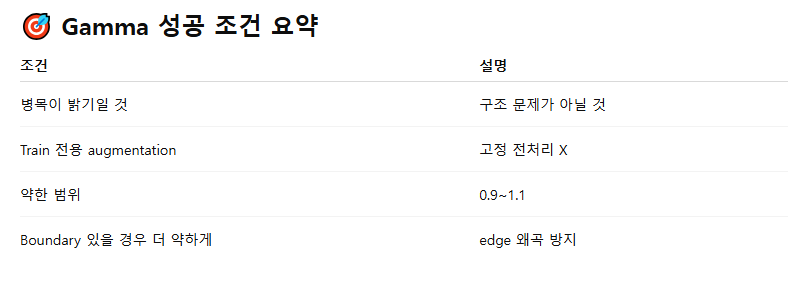

### Input Enhancement = CLAHE 1개 설정값만 적용 (sweep 없음)

In [367]:
# ==========================================================
# ✅ CELL 1) CONTROL PANEL (Baseline Obj 고정) + Input(CLAHE) 1회
# - Baseline(Obj): crop 45% + (CE + LaneDice + LaneBoundary)
# - Input Enhancement: CLAHE만 1개 설정으로 추가 실험 (sweep 없음)
# ==========================================================

import os, json, time, random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.segmentation import deeplabv3_resnet50

# -----------------------------
# ✅ PATH (본인 환경에 맞게)
# -----------------------------
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ANN_PATH  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

# -----------------------------
# ✅ EXP SETTING
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
NUM_CLASSES = 7

# lane train id (본인 프로젝트에서 쓰던 값으로!)
LANE_TRAIN_ID = 3

# -----------------------------
# ✅ Baseline(Obj) 고정 + CLAHE만 비교
# -----------------------------
HP = {
    # === input / feature ===
    "crop_top_pct": 45,            # ✅ 상단에서 45% 컷 (고정)

    "use_clahe": True,             # ✅ CLAHE 실험 on/off
    # CLAHE 대표 파라미터 2개 (감마처럼 1회만 테스트)
    "clahe_clipLimit": 2.0,        # 보통 1.5~3.0 사이
    "clahe_tileGridSize": 8,       # 보통 8 or 16

    # === optimization ===
    "epochs": 35,
    "lr": 2e-4,
    "wd": 3e-4,
    "batch_size": 4,
    "num_workers": 0,
    "amp": True,
    "grad_clip": 1.0,
    "patience": 5,

    # === objective (Baseline Obj 고정) ===
    "use_lane_dice": True,
    "lane_dice_lambda": 0.5,       # ✅ λ_dice
    "dice_smooth": 1.0,            # ✅ smooth

    "use_lane_boundary": True,
    "lane_boundary_lambda": 0.2,   # ✅ λ_boundary
    "boundary_thick": 2,           # ✅ thick
}

# -----------------------------
# ✅ 저장 폴더
# -----------------------------
TS = time.strftime("%Y%m%d_%H%M%S")
SAVE_ROOT = rf"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\{TS}\objBase_crop45_clahe_{'on' if HP['use_clahe'] else 'off'}_clip{HP['clahe_clipLimit']}_tile{HP['clahe_tileGridSize']}"
os.makedirs(SAVE_ROOT, exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

# ==========================================================
# ✅ Input Enhancement: CLAHE (RGB -> LAB, L 채널에만 적용)
# - train에서만 적용, val/test는 OFF
# ==========================================================
def apply_clahe_rgb_uint8(img_rgb_uint8, clipLimit=2.0, tileGridSize=8):
    """
    img_rgb_uint8: (H,W,3) uint8, RGB
    return: (H,W,3) uint8, RGB
    """
    try:
        import cv2
    except Exception as e:
        raise ImportError(
            "cv2(opencv-python)가 필요합니다.\n"
            "설치: pip install opencv-python\n"
            f"원인: {e}"
        )

    # RGB -> BGR (cv2는 BGR 기본)
    bgr = cv2.cvtColor(img_rgb_uint8, cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=float(clipLimit),
                            tileGridSize=(int(tileGridSize), int(tileGridSize)))
    L2 = clahe.apply(L)

    lab2 = cv2.merge([L2, A, B])
    bgr2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    rgb2 = cv2.cvtColor(bgr2, cv2.COLOR_BGR2RGB)
    return rgb2

# ==========================================================
# ✅ Lane Dice
# ==========================================================
def lane_dice_loss(logits, y, lane_id=LANE_TRAIN_ID, smooth=1.0):
    prob = torch.softmax(logits, dim=1)[:, lane_id]  # (B,H,W)
    gt   = (y == lane_id).float()                    # (B,H,W)

    inter = (prob * gt).sum(dim=(1,2))
    denom = prob.sum(dim=(1,2)) + gt.sum(dim=(1,2))
    dice  = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

# ==========================================================
# ✅ Lane Boundary Loss (morph gradient 기반)
# ==========================================================
def morph_gradient(mask01, thick=2):
    k = 2*thick + 1
    pad = thick
    dil = F.max_pool2d(mask01, kernel_size=k, stride=1, padding=pad)
    ero = -F.max_pool2d(-mask01, kernel_size=k, stride=1, padding=pad)
    return (dil - ero).clamp(0, 1)

def lane_boundary_loss(logits, y, lane_id=LANE_TRAIN_ID, thick=2, smooth=1.0):
    prob = torch.softmax(logits, dim=1)[:, lane_id:lane_id+1]   # (B,1,H,W)
    gt   = (y == lane_id).float().unsqueeze(1)                  # (B,1,H,W)

    pb = morph_gradient(prob, thick=thick)
    gb = morph_gradient(gt,   thick=thick)

    inter = (pb * gb).sum(dim=(1,2,3))
    denom = pb.sum(dim=(1,2,3)) + gb.sum(dim=(1,2,3))
    dice  = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

# ==========================================================
# ✅ total loss pack
# ==========================================================
def total_loss(logits, y, ce_criterion, hp=HP):
    loss = ce_criterion(logits, y)
    logs = {"ce": float(loss.detach().cpu())}

    if hp["use_lane_dice"]:
        ld = lane_dice_loss(logits, y, lane_id=LANE_TRAIN_ID, smooth=hp["dice_smooth"])
        loss = loss + hp["lane_dice_lambda"] * ld
        logs["lane_dice"] = float(ld.detach().cpu())
        logs["w_lane_dice"] = hp["lane_dice_lambda"]

    if hp["use_lane_boundary"]:
        lb = lane_boundary_loss(logits, y, lane_id=LANE_TRAIN_ID, thick=hp["boundary_thick"], smooth=hp["dice_smooth"])
        loss = loss + hp["lane_boundary_lambda"] * lb
        logs["lane_boundary"] = float(lb.detach().cpu())
        logs["w_lane_boundary"] = hp["lane_boundary_lambda"]
        logs["boundary_thick"] = hp["boundary_thick"]

    return loss, logs

print("SAVE_ROOT:", SAVE_ROOT)
print("DEVICE:", DEVICE)
print("HP:", HP)


SAVE_ROOT: D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260217_010917\objBase_crop45_clahe_on_clip2.0_tile8
DEVICE: cuda
HP: {'crop_top_pct': 45, 'use_clahe': True, 'clahe_clipLimit': 2.0, 'clahe_tileGridSize': 8, 'epochs': 35, 'lr': 0.0002, 'wd': 0.0003, 'batch_size': 4, 'num_workers': 0, 'amp': True, 'grad_clip': 1.0, 'patience': 5, 'use_lane_dice': True, 'lane_dice_lambda': 0.5, 'dice_smooth': 1.0, 'use_lane_boundary': True, 'lane_boundary_lambda': 0.2, 'boundary_thick': 2}


In [368]:
# ==========================================================
# ✅ CELL 2) COCO 로드 + Dataset/DataLoader + KFold split
# - crop_top_pct=45 고정
# - CLAHE는 train에서만 적용 (val/test는 OFF)
# ==========================================================

import json
from collections import defaultdict
from pycocotools.coco import COCO
from sklearn.model_selection import KFold

coco = COCO(ANN_PATH)
all_img_ids = list(coco.imgs.keys())
print("num_images:", len(all_img_ids))

# ----------------------------------------------------------
# ✅ id2train (본인 프로젝트에서 쓰던 매핑과 동일해야 함)
#    - 이미 노트북에 id2train이 있으면, 이 블록은 지우고 그걸 쓰셔도 됩니다.
# ----------------------------------------------------------
if "id2train" not in globals():
    cats = coco.loadCats(coco.getCatIds())
    print("COCO categories:", [(c["id"], c.get("name","")) for c in cats])

    # 예시(임시): category_id -> train_id
    id2train = {c["id"]: min(c["id"], NUM_CLASSES-1) for c in cats}
    id2train[0] = 0

print("id2train sample:", list(id2train.items())[:10])

# ----------------------------------------------------------
# ✅ helper: semantic mask 생성
# ----------------------------------------------------------
def build_semantic_mask(coco, img_id, id2train):
    info = coco.loadImgs([img_id])[0]
    H, W = info["height"], info["width"]
    mask = np.zeros((H, W), dtype=np.uint8)

    ann_ids = coco.getAnnIds(imgIds=[img_id])
    anns = coco.loadAnns(ann_ids)

    for a in anns:
        cat_id = a["category_id"]
        train_id = id2train.get(cat_id, 0)
        m = coco.annToMask(a)
        mask[m == 1] = train_id

    return mask

# ----------------------------------------------------------
# ✅ dataset
# ----------------------------------------------------------
class SemSegDS(Dataset):
    def __init__(self, coco, img_dir, img_ids, id2train, train=True, hp=HP):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.train = train
        self.hp = hp

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        # PIL로 로드
        img_pil = Image.open(img_path).convert("RGB")
        mask = build_semantic_mask(self.coco, img_id, self.id2train)  # (H,W) uint8
        y = torch.from_numpy(mask).long()

        # ==================================================
        # ✅ Crop: 상단 45% 컷 (고정)
        # ==================================================
        pct = self.hp["crop_top_pct"]
        H = y.shape[0]
        top_cut = int(H * (pct / 100.0))

        # PIL crop (이미지) + mask crop
        # PIL crop box: (left, upper, right, lower)
        w, h = img_pil.size
        img_pil = img_pil.crop((0, top_cut, w, h))
        y = y[top_cut:, :]

        # ==================================================
        # ✅ CLAHE: train에서만 적용 (val/test는 OFF)
        # - uint8 RGB로 변환 -> CLAHE -> 다시 PIL
        # ==================================================
        if self.train and self.hp["use_clahe"]:
            img_np = np.array(img_pil).astype(np.uint8)  # (H,W,3) RGB uint8
            img_np2 = apply_clahe_rgb_uint8(
                img_np,
                clipLimit=self.hp["clahe_clipLimit"],
                tileGridSize=self.hp["clahe_tileGridSize"]
            )
            img_pil = Image.fromarray(img_np2)

        # --- to tensor [0,1]
        x = TF.to_tensor(img_pil)  # (3,H,W) float32 [0,1]

        # Normalize (ImageNet)
        x = TF.normalize(x, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

        return x, y, img_id, info["file_name"]

# ----------------------------------------------------------
# ✅ KFold split
# ----------------------------------------------------------
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=SEED)

folds = []
for fold_idx, (tr_idx, va_idx) in enumerate(kf.split(all_img_ids), start=1):
    tr_ids = [all_img_ids[i] for i in tr_idx]
    va_ids = [all_img_ids[i] for i in va_idx]
    folds.append((tr_ids, va_ids))

print("K folds ready:", len(folds))
print("fold1 sizes:", len(folds[0][0]), len(folds[0][1]))


loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
num_images: 200
id2train sample: [(1323880, 1), (1323881, 2), (1323882, 3), (1323884, 4), (1323885, 5), (1329681, 6)]
K folds ready: 5
fold1 sizes: 160 40


In [369]:
# ==========================================================
# ✅ CELL 3) KFold 학습 + fold별 best laneIoU 저장
# - 모델: DeepLabV3 ResNet50 backbone pretrained
# - loss: CE + λ*LaneDice + λ*LaneBoundary (Obj base 고정)
# - best_fold_model 저장 + summary.json 생성
# ==========================================================

from torch.cuda.amp import autocast, GradScaler

def build_model(num_classes=NUM_CLASSES):
    model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model

@torch.no_grad()
def compute_iou_per_class(pred, y, num_classes=NUM_CLASSES):
    ious = []
    for c in range(num_classes):
        p = (pred == c)
        g = (y == c)
        inter = (p & g).sum().item()
        union = (p | g).sum().item()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(inter / union)
    return ious

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    losses = []
    lane_ious = []
    miou_nobg = []

    ce_criterion = nn.CrossEntropyLoss()

    for x, y, *_ in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        out = model(x)["out"]
        loss, _logs = total_loss(out, y, ce_criterion, hp=HP)
        losses.append(float(loss.detach().cpu()))

        pred = out.argmax(1)
        for b in range(pred.shape[0]):
            ious = compute_iou_per_class(pred[b].cpu(), y[b].cpu(), num_classes=NUM_CLASSES)
            lane_ious.append(ious[LANE_TRAIN_ID])

            valid = [v for i,v in enumerate(ious) if i != 0 and np.isfinite(v)]
            miou_nobg.append(float(np.mean(valid)) if len(valid) else np.nan)

    return {
        "loss": float(np.mean(losses)),
        "laneIoU": float(np.nanmean(lane_ious)),
        "mIoU_no_bg": float(np.nanmean(miou_nobg)),
    }

def train_one_fold(fold_idx, train_ids, val_ids):
    train_ds = SemSegDS(coco, IMG_DIR, train_ids, id2train, train=True,  hp=HP)
    val_ds   = SemSegDS(coco, IMG_DIR, val_ids,   id2train, train=False, hp=HP)

    train_loader = DataLoader(train_ds, batch_size=HP["batch_size"], shuffle=True,
                              num_workers=HP["num_workers"], pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False,
                              num_workers=HP["num_workers"], pin_memory=True)

    model = build_model().to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=HP["lr"], weight_decay=HP["wd"])
    scaler = GradScaler(enabled=HP["amp"])
    ce_criterion = nn.CrossEntropyLoss()

    best_lane = -1
    best_epoch = -1
    best_path = None
    patience = 0
    stop_epoch = HP["epochs"]

    for ep in range(1, HP["epochs"]+1):
        model.train()
        for x, y, *_ in train_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            optim.zero_grad(set_to_none=True)
            with autocast(enabled=HP["amp"]):
                logits = model(x)["out"]
                loss, _logs = total_loss(logits, y, ce_criterion, hp=HP)

            scaler.scale(loss).backward()
            if HP["grad_clip"] and HP["grad_clip"] > 0:
                scaler.unscale_(optim)
                torch.nn.utils.clip_grad_norm_(model.parameters(), HP["grad_clip"])
            scaler.step(optim)
            scaler.update()

        met = evaluate(model, val_loader)
        lane = met["laneIoU"]

        if lane > best_lane:
            best_lane = lane
            best_epoch = ep
            patience = 0

            best_path = os.path.join(SAVE_ROOT, f"fold{fold_idx}_best.pth")
            torch.save({"model": model.state_dict(), "hp": HP, "fold": fold_idx}, best_path)
        else:
            patience += 1
            if patience >= HP["patience"]:
                stop_epoch = ep
                break

        print(f"[fold {fold_idx}][{ep:02d}] val_loss={met['loss']:.4f} laneIoU={met['laneIoU']:.4f} mIoU(no-bg)={met['mIoU_no_bg']:.4f}"
              f" | best_lane={best_lane:.4f}@{best_epoch}")

    return {
        "best_laneIoU": float(best_lane),
        "best_epoch": int(best_epoch),
        "stop_epoch": int(stop_epoch),
        "best_model_path": best_path,
    }

# -----------------------------
# ✅ run kfold
# -----------------------------
cv_best_lane = []
cv_best_epoch = []
cv_stop_epoch = []
best_fold = -1
best_fold_lane = -1
best_model_path = None

for i, (tr_ids, va_ids) in enumerate(folds, start=1):
    out = train_one_fold(i, tr_ids, va_ids)
    cv_best_lane.append(out["best_laneIoU"])
    cv_best_epoch.append(out["best_epoch"])
    cv_stop_epoch.append(out["stop_epoch"])

    if out["best_laneIoU"] > best_fold_lane:
        best_fold_lane = out["best_laneIoU"]
        best_fold = i
        best_model_path = out["best_model_path"]

summary = {
    "crop_pct": HP["crop_top_pct"],
    "clahe_on": bool(HP["use_clahe"]),
    "clahe_clipLimit": float(HP["clahe_clipLimit"]) if HP["use_clahe"] else None,
    "clahe_tileGridSize": int(HP["clahe_tileGridSize"]) if HP["use_clahe"] else None,

    "cv_best_laneIoU_per_fold": cv_best_lane,
    "cv_best_epoch_per_fold": cv_best_epoch,
    "cv_stop_epoch_per_fold": cv_stop_epoch,

    "cv_mean_laneIoU": float(np.mean(cv_best_lane)),
    "cv_std_laneIoU": float(np.std(cv_best_lane, ddof=0)),

    "best_fold": int(best_fold),
    "best_model_path": best_model_path,

    "hp_snapshot": HP,
    "save_dir": SAVE_ROOT,
}

sum_path = os.path.join(SAVE_ROOT, "summary.json")
with open(sum_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("\n✅ saved:", sum_path)
print("summary keys:", summary.keys())
print("cv_best_laneIoU_per_fold:", summary["cv_best_laneIoU_per_fold"])

C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\99247812.py:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=HP["amp"])
C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\99247812.py:87: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=HP["amp"]):


[fold 1][01] val_loss=1.0154 laneIoU=0.3090 mIoU(no-bg)=0.5523 | best_lane=0.3090@1
[fold 1][02] val_loss=0.8205 laneIoU=0.3970 mIoU(no-bg)=0.5915 | best_lane=0.3970@2
[fold 1][03] val_loss=0.7125 laneIoU=0.4314 mIoU(no-bg)=0.6229 | best_lane=0.4314@3
[fold 1][04] val_loss=0.6752 laneIoU=0.4400 mIoU(no-bg)=0.6438 | best_lane=0.4400@4
[fold 1][05] val_loss=0.6847 laneIoU=0.4555 mIoU(no-bg)=0.6528 | best_lane=0.4555@5
[fold 1][06] val_loss=0.6454 laneIoU=0.4538 mIoU(no-bg)=0.6626 | best_lane=0.4555@5
[fold 1][07] val_loss=0.6425 laneIoU=0.4564 mIoU(no-bg)=0.6580 | best_lane=0.4564@7
[fold 1][08] val_loss=0.6205 laneIoU=0.4770 mIoU(no-bg)=0.6656 | best_lane=0.4770@8
[fold 1][09] val_loss=0.6454 laneIoU=0.4576 mIoU(no-bg)=0.6579 | best_lane=0.4770@8
[fold 1][10] val_loss=0.6253 laneIoU=0.4899 mIoU(no-bg)=0.6451 | best_lane=0.4899@10
[fold 1][11] val_loss=0.6188 laneIoU=0.4681 mIoU(no-bg)=0.6698 | best_lane=0.4899@10
[fold 1][12] val_loss=0.6243 laneIoU=0.4767 mIoU(no-bg)=0.6955 | best_lane

[Paired t-test @ alpha=0.05] metric=cv_best_laneIoU_per_fold
- baseline(Obj base) folds: [0.55668432 0.43839952 0.52845818 0.53746802 0.62556899]
- clahe folds:              [0.51060238 0.46777024 0.42044622 0.43063395 0.49321869]
- mean(baseline) = 0.537316 ± 0.060044
- mean(clahe)    = 0.464534 ± 0.034781
- t-stat = -2.489283
- p-value= 0.067536255
=> 유의수준 5% 개선? NO

[CLAHE best fold] 1 path: D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260217_010917\objBase_crop45_clahe_on_clip2.0_tile8\fold1_best.pth

[FAIL 3]
laneIoU= 0.00039949777422668647 | night ride (17).png

[SUCCESS 3]
laneIoU= nan | night ride (77).png


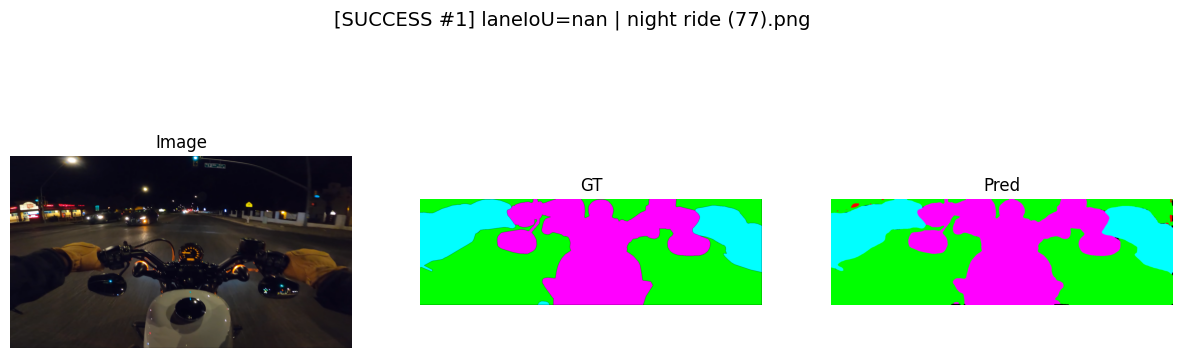

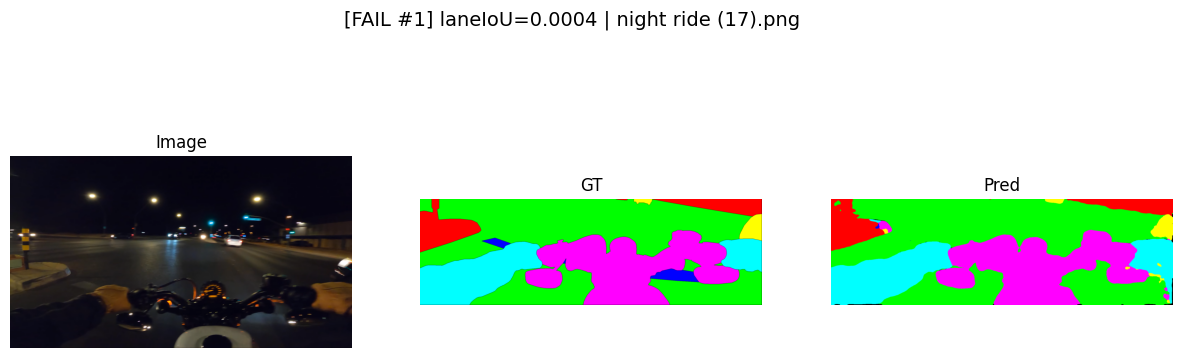

In [370]:
# ==========================================================
# ✅ CELL 4) (1) paired t-test @ alpha=0.05
#         (2) 성공 3 / 실패 3 가시화 (best_fold 모델로)
# - success/fail 기준: "이미지별 laneIoU" 상위 3 / 하위 3
# - 비교는 'CLAHE 실험(best_fold)'에 대해 뽑아줌
# ==========================================================

from scipy import stats
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# ✅ (A) baseline(Obj base) summary.json 경로를 정확히 넣으세요
# ----------------------------------------------------------
LANESPECIAL_BASELINE_SUMMARY_JSON = r"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260216_202722\laneSpecial__crop_45pct\summary.json"
CLAHE_SUMMARY_JSON = os.path.join(SAVE_ROOT, "summary.json")

def load_json(p):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

base_sum  = load_json(LANESPECIAL_BASELINE_SUMMARY_JSON)
clahe_sum = load_json(CLAHE_SUMMARY_JSON)

baseline_scores = np.array(base_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)
clahe_scores    = np.array(clahe_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)

t_stat, p_value = stats.ttest_rel(clahe_scores, baseline_scores)

print(f"[Paired t-test @ alpha=0.05] metric=cv_best_laneIoU_per_fold")
print(f"- baseline(Obj base) folds: {baseline_scores}")
print(f"- clahe folds:              {clahe_scores}")
print(f"- mean(baseline) = {baseline_scores.mean():.6f} ± {baseline_scores.std(ddof=0):.6f}")
print(f"- mean(clahe)    = {clahe_scores.mean():.6f} ± {clahe_scores.std(ddof=0):.6f}")
print(f"- t-stat = {t_stat:.6f}")
print(f"- p-value= {p_value:.9f}")
print("=> 유의수준 5% 개선?", "YES" if p_value < 0.05 else "NO")
print("=> 유의수준 1% 개선?", "YES" if p_value < 0.01 else "NO")
# ----------------------------------------------------------
# ✅ (B) best_fold 모델 로드 + 해당 fold의 val set에서 success/fail 3장 추출/시각화
# 특징

# ✔ summary.json의 best_fold 사용
# ✔ 그 fold의 validation id만 사용
# ✔ 해당 fold 모델로 그 fold 데이터만 평가
# 즉
# CV 실험 구조를 정확히 따름
# “그 실험에서 best라고 판단된 fold의 검증셋 기준”

# 장점
# 논문 스타일 평가에 적합
# CV 구조를 정확히 반영
# 통계적 일관성 유지

# 단점
# 전체 데이터 관점은 아님
# 다른 fold는 반영 안 됨
# ----------------------------------------------------------
def load_best_model(path):
    ckpt = torch.load(path, map_location="cpu")
    model = build_model().to(DEVICE)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()
    return model

@torch.no_grad()
def per_image_lane_iou(model, ds):
    scores = []
    for i in range(len(ds)):
        x, y, img_id, fname = ds[i]
        x = x.unsqueeze(0).to(DEVICE)
        y = y.to(DEVICE)

        out = model(x)["out"].squeeze(0)  # (C,H,W)
        pred = out.argmax(0).cpu()

        ious = compute_iou_per_class(pred, y.cpu(), num_classes=NUM_CLASSES)
        lane = ious[LANE_TRAIN_ID]
        scores.append((lane, i, img_id, fname, pred, y.cpu()))
    return scores

def colorize_mask(mask, num_classes=NUM_CLASSES):
    palette = np.array([
        [0,0,0],
        [255,0,0],
        [0,255,0],
        [0,0,255],
        [255,255,0],
        [255,0,255],
        [0,255,255],
        [255,128,0],
    ], dtype=np.uint8)
    m = mask.numpy().astype(np.int64)
    m = np.clip(m, 0, len(palette)-1)
    return palette[m]

def show_triplet(img_path, gt_mask, pred_mask, title):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    gt_rgb   = colorize_mask(gt_mask)
    pred_rgb = colorize_mask(pred_mask)

    plt.figure(figsize=(15,5))
    plt.suptitle(title, fontsize=14)

    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img_np); plt.axis("off")
    plt.subplot(1,3,2); plt.title("GT");    plt.imshow(gt_rgb); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Pred");  plt.imshow(pred_rgb); plt.axis("off")
    plt.show()

# ---- clahe best fold로 뽑기
best_fold = int(clahe_sum["best_fold"])
best_model_path = clahe_sum["best_model_path"]
print("\n[CLAHE best fold]", best_fold, "path:", best_model_path)

# 해당 fold의 val ids 가져오기
tr_ids, va_ids = folds[best_fold-1]
val_ds = SemSegDS(coco, IMG_DIR, va_ids, id2train, train=False, hp=HP)

model = load_best_model(best_model_path)

scores = per_image_lane_iou(model, val_ds)
scores_sorted = sorted(scores, key=lambda x: (np.inf if np.isnan(x[0]) else x[0]))

### 성공 및 실패 이미지 3 -> 1개로 줄임
fails = scores_sorted[:1]
succs = scores_sorted[-1:][::-1]

print("\n[FAIL 3]")
for s in fails:
    print("laneIoU=", s[0], "|", s[3])

print("\n[SUCCESS 3]")
for s in succs:
    print("laneIoU=", s[0], "|", s[3])

# ---- 시각화
for rank, (lane, idx, img_id, fname, pred, gt) in enumerate(succs, start=1):
    img_path = os.path.join(IMG_DIR, fname)
    show_triplet(img_path, gt, pred, title=f"[SUCCESS #{rank}] laneIoU={lane:.4f} | {fname}")

for rank, (lane, idx, img_id, fname, pred, gt) in enumerate(fails, start=1):
    img_path = os.path.join(IMG_DIR, fname)
    show_triplet(img_path, gt, pred, title=f"[FAIL #{rank}] laneIoU={lane:.4f} | {fname}")


[Paired t-test @ alpha=0.05] metric=cv_best_laneIoU_per_fold
- baseline(Obj base) folds: [0.55668432 0.43839952 0.52845818 0.53746802 0.62556899]
- clahe folds:              [0.51060238 0.46777024 0.42044622 0.43063395 0.49321869]
- mean(baseline) = 0.537316 ± 0.060044
- mean(clahe)    = 0.464534 ± 0.034781
- t-stat = -2.489283
- p-value= 0.067536255
=> 유의수준 5% 개선? NO
=> 유의수준 1% 개선? NO
[EXP best model] loaded from: D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260217_010917\objBase_crop45_clahe_on_clip2.0_tile8\fold1_best.pth
Collected 20 samples from LOADER.


C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\4268854484.py:122: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


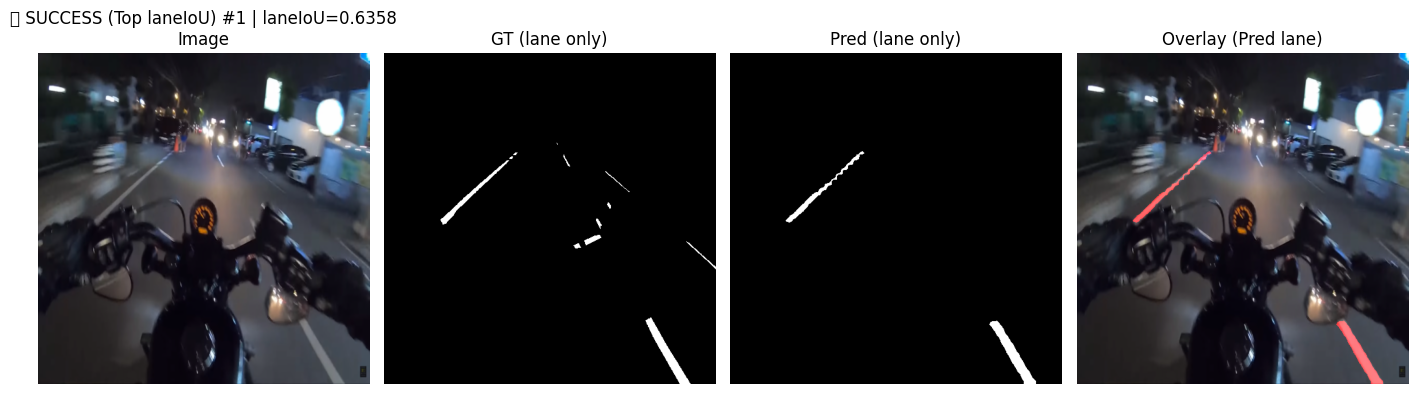

C:\Users\hugctx\AppData\Local\Temp\ipykernel_35268\4268854484.py:122: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda3\envs\torch_first\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


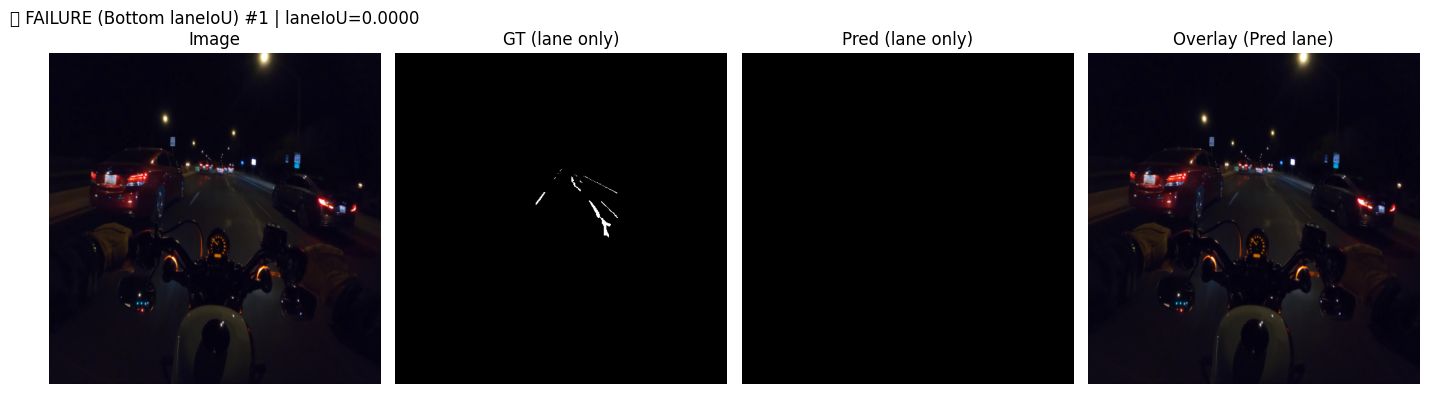

In [386]:
# ==========================================================
# ✅ CELL 4) (1) paired t-test @ alpha=0.05
#         (2) 성공 3 / 실패 3 가시화 (best_fold 모델로)
# - success/fail 기준: "이미지별 laneIoU" 상위 3 / 하위 3
# - 비교는 'CLAHE 실험(best_fold)'에 대해 뽑아줌
# ==========================================================

from scipy import stats
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# ✅ (A) baseline(Obj base) summary.json 경로를 정확히 넣으세요
# ----------------------------------------------------------
LANESPECIAL_BASELINE_SUMMARY_JSON = r"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\20260216_202722\laneSpecial__crop_45pct\summary.json"
CLAHE_SUMMARY_JSON = os.path.join(SAVE_ROOT, "summary.json")

def load_json(p):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

base_sum  = load_json(LANESPECIAL_BASELINE_SUMMARY_JSON)
clahe_sum = load_json(CLAHE_SUMMARY_JSON)

baseline_scores = np.array(base_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)
clahe_scores    = np.array(clahe_sum["cv_best_laneIoU_per_fold"], dtype=np.float64)

t_stat, p_value = stats.ttest_rel(clahe_scores, baseline_scores)

print(f"[Paired t-test @ alpha=0.05] metric=cv_best_laneIoU_per_fold")
print(f"- baseline(Obj base) folds: {baseline_scores}")
print(f"- clahe folds:              {clahe_scores}")
print(f"- mean(baseline) = {baseline_scores.mean():.6f} ± {baseline_scores.std(ddof=0):.6f}")
print(f"- mean(clahe)    = {clahe_scores.mean():.6f} ± {clahe_scores.std(ddof=0):.6f}")
print(f"- t-stat = {t_stat:.6f}")
print(f"- p-value= {p_value:.9f}")
print("=> 유의수준 5% 개선?", "YES" if p_value < 0.05 else "NO")
print("=> 유의수준 1% 개선?", "YES" if p_value < 0.01 else "NO")
# ============================================================
# (2) EXP best_fold 모델로 LOADER 전체에서 per-image laneIoU 계산
#     -> 성공 1장 / 실패 1장 (요청하신 4칸 가시화)

# 특징
# ✔ LOADER 전체를 한 번 쭉 돌면서
# ✔ 각 이미지의 laneIoU를 직접 계산
# ✔ 그걸 정렬해서 top / bottom을 고름

# 즉
# 데이터셋 전체 기준 절대 순위
# fold 개념 없음
# summary.json의 best_fold와 무관
# test_loader / val_loader 아무거나 가능

# 장점
# 전체 데이터에서 진짜 최고/최악을 고름
# 단순하고 직관적
# 디버깅에 좋음

# 단점
# CV fold 구조를 반영하지 않음
# 특정 fold validation만 보고 싶을 때는 부정확

# ============================================================
best_model_path = exp_sum.get("best_model_path", None)
if best_model_path is None:
    raise ValueError("EXP summary.json에 'best_model_path'가 없습니다.")

best_model_path = os.path.normpath(best_model_path)
if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"best_model_path를 찾을 수 없습니다: {best_model_path}")

model = load_model_from_ckpt(best_model_path)

records = []  # (lane_iou, img_np, gt_np, pred_np)

with torch.no_grad():
    for batch in LOADER:
        x, y = try_get_image_and_mask(batch)
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True).long()

        out = model(x)
        if isinstance(out, dict) and "out" in out:
            logits = out["out"]
        elif isinstance(out, dict) and "seg" in out:
            logits = out["seg"]
        else:
            logits = out

        pred = torch.argmax(logits, dim=1)  # (B,H,W)

        B = x.shape[0]
        for i in range(B):
            # ✅ GT에 lane 픽셀이 0이면 laneIoU 왜곡/NaN 유사 -> 제외(원하면 주석처리)
            if int((y[i] == LANE_TRAIN_ID).sum().item()) == 0:
                continue

            lane_iou = fast_lane_iou(pred[i], y[i], LANE_TRAIN_ID)
            img_np = denorm_img(x[i])
            gt_np  = y[i].detach().cpu().numpy()
            pr_np  = pred[i].detach().cpu().numpy()
            records.append((lane_iou, img_np, gt_np, pr_np))

if len(records) == 0:
    raise RuntimeError("records가 0개입니다. (LOADER/GT lane 픽셀 0 필터 때문에 전부 제외됐을 수 있음)")

# 정렬해서 top1 / bottom1  (원하시면 [:3], [-3:]로 즉시 확장 가능)
records_sorted = sorted(records, key=lambda t: t[0])
worst1 = records_sorted[:1]
best1  = records_sorted[-1:][::-1]

def show_triplet(samples, title):
    n = len(samples)
    plt.figure(figsize=(14, 4*n))
    for r, (iou, img, gt, pr) in enumerate(samples, start=1):
        gt_lane = (gt == LANE_TRAIN_ID).astype(np.uint8)
        pr_lane = (pr == LANE_TRAIN_ID).astype(np.uint8)

        # 1) raw image
        ax1 = plt.subplot(n, 4, (r-1)*4 + 1)
        ax1.imshow(img)
        ax1.set_title(f"{title} #{r} | laneIoU={iou:.4f}\nImage")
        ax1.axis("off")

        # 2) GT lane mask
        ax2 = plt.subplot(n, 4, (r-1)*4 + 2)
        ax2.imshow(colorize_binary(gt_lane), cmap="gray", vmin=0, vmax=1)
        ax2.set_title("GT (lane only)")
        ax2.axis("off")

        # 3) Pred lane mask
        ax3 = plt.subplot(n, 4, (r-1)*4 + 3)
        ax3.imshow(colorize_binary(pr_lane), cmap="gray", vmin=0, vmax=1)
        ax3.set_title("Pred (lane only)")
        ax3.axis("off")

        # 4) Overlay
        ax4 = plt.subplot(n, 4, (r-1)*4 + 4)
        overlay = overlay_lane_on_img(img, pr_lane, alpha=0.7)
        ax4.imshow(overlay)
        ax4.set_title("Overlay (Pred lane)")
        ax4.axis("off")

    plt.tight_layout()
    plt.show()

print(f"[EXP best model] loaded from: {best_model_path}")
print(f"Collected {len(records)} samples from LOADER.")
show_triplet(best1,  "✅ SUCCESS (Top laneIoU)")
show_triplet(worst1, "❌ FAILURE (Bottom laneIoU)")

### 2️⃣ CLAHE를 학술적으로 올바르게 쓰는 방법
- CLAHE는 Local Contrast Enhancement입니다.
- 문제는: Lane이 선형 구조
- CLAHE는 텍스처도 강화
- 잘못 쓰면 false positive 증가

### ✅ 학술적으로 맞는 사용법
#### ① LAB 또는 Y 채널에만 적용
- 잘못된 방식: RGB 전체에 CLAHE
- 올바른 방식:
- RGB → LAB: L 채널에만 CLAHE → 다시 RGB

- 이유: 색 왜곡 방지: edge 과강조 감소

#### ② Clip Limit 낮게 설정
- 권장: clipLimit = 1.5 ~ 2.0
- tileGridSize = (8,8)
- 3 이상은 과강조 가능성 높음

#### ③ Train augmentation으로만 사용
- CLAHE는 고정 전처리 X
- if random() < 0.5:
-    apply_CLAHE()
#### ④ Boundary loss와 함께 쓰려면 “약하게”
- Boundary loss는 edge 기반
- CLAHE도 edge 기반
- 둘 다 강하면:
- edge 과민 모델 됨 → FP 증가

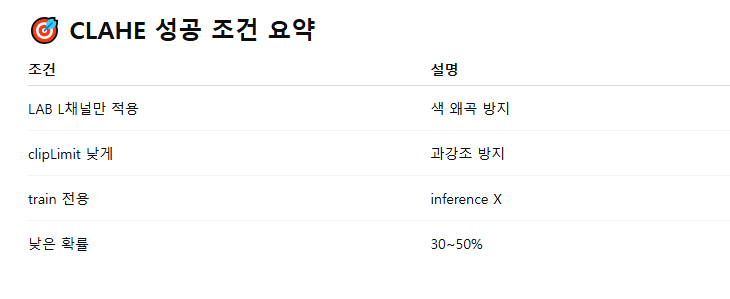

#### 🔥 왜 지금은 안 맞았는가?
- 지금 모델은:
- 구조 정밀도 기반 모델

#### Gamma/CLAHE는:
- 광학 대비 기반 보정
- 현재 병목은: 굵기, 경계, 위치 정밀도, 밝기 아님. 그래서 효과가 없음.

#### 🎯 전략적 판단
- 지금 단계에서 우선순위는:

### 1️⃣ Optimization Engineering (LR schedule, warmup, cosine, EMA)
### 2️⃣ Hard negative mining
### 3️⃣ Lane width normalization
- Gamma/CLAHE는: 최종 강건성 확보 단계에서만 고려

#### 🔥 결론
- Gamma와 CLAHE는 틀린 게 아니라, “지금 문제에 맞지 않는 도구” 였습니다.

In [ ]:
# ==========================================================
# ✅ CELL 1) CONTROL PANEL (Baseline Obj 고정) + Input(CLAHE) 1회 (학술적으로 올바른 방식)
# - Baseline(Obj): crop 45% + (CE + LaneDice + LaneBoundary)
# - Input Enhancement: CLAHE (LAB의 L 채널만) / train aug only / 낮은 확률 / 약한 clipLimit
# ==========================================================

import os, json, time, random
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.segmentation import deeplabv3_resnet50

# -----------------------------
# ✅ PATH (본인 환경에 맞게)
# -----------------------------
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ANN_PATH  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

# -----------------------------
# ✅ EXP SETTING
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
NUM_CLASSES = 7

# lane train id (본인 프로젝트에서 쓰던 값으로!)
LANE_TRAIN_ID = 3

# -----------------------------
# ✅ Baseline(Obj) 고정 + CLAHE만 비교
# -----------------------------
HP = {
    # === input / feature ===
    "crop_top_pct": 45,             # ✅ 상단에서 45% 컷 (고정)

    "use_clahe": True,              # ✅ CLAHE 실험 on/off
    "clahe_prob": 0.5,              # ✅ (중요) train augmentation으로만, 30~50% 권장
    "clahe_clipLimit": 2.0,         # ✅ 1.5~2.0 권장 (3 이상 과강조 위험↑)
    "clahe_tileGridSize": 8,        # ✅ (8,8) 권장
    # "clahe_tileGridSize": 16,     # 필요하면 16으로 바꿔 테스트

    # === optimization ===
    "epochs": 35,
    "lr": 2e-4,
    "wd": 3e-4,
    "batch_size": 4,
    "num_workers": 0,
    "amp": True,
    "grad_clip": 1.0,
    "patience": 5,

    # === objective (Baseline Obj 고정) ===
    "use_lane_dice": True,
    "lane_dice_lambda": 0.5,        # ✅ λ_dice
    "dice_smooth": 1.0,             # ✅ smooth

    "use_lane_boundary": True,
    "lane_boundary_lambda": 0.2,    # ✅ λ_boundary
    "boundary_thick": 2,            # ✅ thick
}

# -----------------------------
# ✅ 저장 폴더
# -----------------------------
TS = time.strftime("%Y%m%d_%H%M%S")
if HP["use_clahe"]:
    clahe_tag = f"p{HP['clahe_prob']}_clip{HP['clahe_clipLimit']}_tile{HP['clahe_tileGridSize']}"
else:
    clahe_tag = "off"

SAVE_ROOT = rf"D:\PyProject\AIFFEL_AI\CNN\checkpoints_kfold\{TS}\objBase_crop45_clahe_{clahe_tag}"
os.makedirs(SAVE_ROOT, exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

# ==========================================================
# ✅ Input Enhancement: CLAHE (RGB -> LAB, L 채널만 적용 -> RGB)
# - 주의: RGB 전체 CLAHE는 색 왜곡/edge 과강조 가능성↑ (피함)
# ==========================================================
def apply_clahe_rgb_uint8(img_rgb_uint8, clipLimit=2.0, tileGridSize=8):
    """
    img_rgb_uint8: (H,W,3) uint8, RGB
    return: (H,W,3) uint8, RGB
    """
    try:
        import cv2
    except Exception as e:
        raise ImportError(
            "cv2(opencv-python)가 필요합니다.\n"
            "설치: pip install opencv-python\n"
            f"원인: {e}"
        )

    # RGB -> BGR (cv2는 BGR 기본)
    bgr = cv2.cvtColor(img_rgb_uint8, cv2.COLOR_RGB2BGR)

    # BGR -> LAB
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    # L 채널에만 CLAHE
    clahe = cv2.createCLAHE(
        clipLimit=float(clipLimit),
        tileGridSize=(int(tileGridSize), int(tileGridSize))
    )
    L2 = clahe.apply(L)

    # LAB -> BGR -> RGB
    lab2 = cv2.merge([L2, A, B])
    bgr2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    rgb2 = cv2.cvtColor(bgr2, cv2.COLOR_BGR2RGB)
    return rgb2

# ==========================================================
# ✅ Lane Dice
# ==========================================================
def lane_dice_loss(logits, y, lane_id=LANE_TRAIN_ID, smooth=1.0):
    prob = torch.softmax(logits, dim=1)[:, lane_id]  # (B,H,W)
    gt   = (y == lane_id).float()                    # (B,H,W)

    inter = (prob * gt).sum(dim=(1,2))
    denom = prob.sum(dim=(1,2)) + gt.sum(dim=(1,2))
    dice  = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

# ==========================================================
# ✅ Lane Boundary Loss (morph gradient 기반)
# ==========================================================
def morph_gradient(mask01, thick=2):
    k = 2*thick + 1
    pad = thick
    dil = F.max_pool2d(mask01, kernel_size=k, stride=1, padding=pad)
    ero = -F.max_pool2d(-mask01, kernel_size=k, stride=1, padding=pad)
    return (dil - ero).clamp(0, 1)

def lane_boundary_loss(logits, y, lane_id=LANE_TRAIN_ID, thick=2, smooth=1.0):
    prob = torch.softmax(logits, dim=1)[:, lane_id:lane_id+1]   # (B,1,H,W)
    gt   = (y == lane_id).float().unsqueeze(1)                  # (B,1,H,W)

    pb = morph_gradient(prob, thick=thick)
    gb = morph_gradient(gt,   thick=thick)

    inter = (pb * gb).sum(dim=(1,2,3))
    denom = pb.sum(dim=(1,2,3)) + gb.sum(dim=(1,2,3))
    dice  = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

# ==========================================================
# ✅ total loss pack
# ==========================================================
def total_loss(logits, y, ce_criterion, hp=HP):
    loss = ce_criterion(logits, y)
    logs = {"ce": float(loss.detach().cpu())}

    if hp["use_lane_dice"]:
        ld = lane_dice_loss(logits, y, lane_id=LANE_TRAIN_ID, smooth=hp["dice_smooth"])
        loss = loss + hp["lane_dice_lambda"] * ld
        logs["lane_dice"] = float(ld.detach().cpu())
        logs["w_lane_dice"] = hp["lane_dice_lambda"]

    if hp["use_lane_boundary"]:
        lb = lane_boundary_loss(logits, y, lane_id=LANE_TRAIN_ID, thick=hp["boundary_thick"], smooth=hp["dice_smooth"])
        loss = loss + hp["lane_boundary_lambda"] * lb
        logs["lane_boundary"] = float(lb.detach().cpu())
        logs["w_lane_boundary"] = hp["lane_boundary_lambda"]
        logs["boundary_thick"] = hp["boundary_thick"]

    return loss, logs

print("SAVE_ROOT:", SAVE_ROOT)
print("DEVICE:", DEVICE)
print("HP:", HP)

In [ ]:
# ==========================================================
# ✅ CELL 2) COCO 로드 + Dataset/DataLoader + KFold split
# - crop_top_pct=45 고정
# - CLAHE는 train에서만 적용 (val/test는 OFF)
# - train에서도 clahe_prob 확률로만 적용 (30~50% 권장)
# ==========================================================

import json
from pycocotools.coco import COCO
from sklearn.model_selection import KFold

coco = COCO(ANN_PATH)
all_img_ids = list(coco.imgs.keys())
print("num_images:", len(all_img_ids))

# ----------------------------------------------------------
# ✅ id2train (본인 프로젝트에서 쓰던 매핑과 동일해야 함)
#    - 이미 노트북에 id2train이 있으면, 이 블록은 지우고 그걸 쓰셔도 됩니다.
# ----------------------------------------------------------
if "id2train" not in globals():
    cats = coco.loadCats(coco.getCatIds())
    print("COCO categories:", [(c["id"], c.get("name","")) for c in cats])

    # 예시(임시): category_id -> train_id
    # ⚠️ 반드시 본인 프로젝트와 일치하게 수정하세요.
    id2train = {c["id"]: min(c["id"], NUM_CLASSES-1) for c in cats}
    id2train[0] = 0

print("id2train sample:", list(id2train.items())[:10])

# ----------------------------------------------------------
# ✅ helper: semantic mask 생성
# ----------------------------------------------------------
def build_semantic_mask(coco, img_id, id2train):
    info = coco.loadImgs([img_id])[0]
    H, W = info["height"], info["width"]
    mask = np.zeros((H, W), dtype=np.uint8)

    ann_ids = coco.getAnnIds(imgIds=[img_id])
    anns = coco.loadAnns(ann_ids)

    for a in anns:
        cat_id = a["category_id"]
        train_id = id2train.get(cat_id, 0)
        m = coco.annToMask(a)
        mask[m == 1] = train_id

    return mask

# ----------------------------------------------------------
# ✅ dataset
# ----------------------------------------------------------
class SemSegDS(Dataset):
    def __init__(self, coco, img_dir, img_ids, id2train, train=True, hp=HP):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.train = train
        self.hp = hp

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs([img_id])[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        # PIL로 로드
        img_pil = Image.open(img_path).convert("RGB")
        mask = build_semantic_mask(self.coco, img_id, self.id2train)  # (H,W) uint8
        y = torch.from_numpy(mask).long()

        # ==================================================
        # ✅ Crop: 상단 45% 컷 (고정)
        # ==================================================
        pct = float(self.hp["crop_top_pct"])
        H = y.shape[0]
        top_cut = int(H * (pct / 100.0))

        # PIL crop (이미지) + mask crop
        w, h = img_pil.size
        img_pil = img_pil.crop((0, top_cut, w, h))
        y = y[top_cut:, :]

        # ==================================================
        # ✅ CLAHE: train에서만 + 확률적으로만 적용 (val/test OFF)
        # ==================================================
        if self.train and self.hp["use_clahe"]:
            if random.random() < float(self.hp.get("clahe_prob", 0.5)):
                img_np = np.array(img_pil).astype(np.uint8)  # (H,W,3) RGB uint8
                img_np2 = apply_clahe_rgb_uint8(
                    img_np,
                    clipLimit=self.hp["clahe_clipLimit"],
                    tileGridSize=self.hp["clahe_tileGridSize"]
                )
                img_pil = Image.fromarray(img_np2)

        # --- to tensor [0,1]
        x = TF.to_tensor(img_pil)  # (3,H,W) float32 [0,1]

        # Normalize (ImageNet)
        x = TF.normalize(x, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

        return x, y, img_id, info["file_name"]

# ----------------------------------------------------------
# ✅ KFold split
# ----------------------------------------------------------
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=SEED)

folds = []
for fold_idx, (tr_idx, va_idx) in enumerate(kf.split(all_img_ids), start=1):
    tr_ids = [all_img_ids[i] for i in tr_idx]
    va_ids = [all_img_ids[i] for i in va_idx]
    folds.append((tr_ids, va_ids))

print("K folds ready:", len(folds))
print("fold1 sizes:", len(folds[0][0]), len(folds[0][1]))